In [9]:
#%tensorflow_version 2.x
import tensorflow as tf
print(f'Tensorflow version {tf.__version__}')
from tensorflow import keras
import tensorflow_addons as tfa
import tensorflow_probability as tfp
print(f'Tensorflow Probability version {tfp.__version__}')
tfb = tfp.bijectors
tfd = tfp.distributions

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

import json
import sys
import h5py
import glob

sys.path.append('../scripts/')
sys.path.append('../data/')
import flow_tf
import serializers_tf
import potential_tf
import potential_frameshift_tf
import importlib
import toy_systems
import flow_ffjord_tf
import utils
import fit_all

from scipy.misc import derivative

params = fit_all.load_params("../options.json")
params['Phi'].pop('n_samples') # This and the next arg is not necessary
params['Phi'].pop('grad_batch_size')
params['Phi'].pop('sample_batch_size')

potential_loss = 'plots/potential_loss_history.png'
loss_history = 'data/loss_history_{:02d}.txt'

Tensorflow version 2.3.0
Tensorflow Probability version 0.11.0


## Basic tests for frameshift

Collisionless BE:
$$
\frac{\partial f}{\partial t} + \vec v \cdot \frac{\partial f}{\partial \vec x} - \frac{\partial\Phi(\vec x, t)}{\partial\vec x} \cdot \frac{\partial f}{\partial \vec v}= 0,
$$
Stationarity defined by a flow:
$$
\frac{\partial f}{\partial t} + \vec u \cdot \frac{\partial f}{\partial \vec x} + \dot{\vec{u}} \cdot \frac{\partial f}{\partial \vec v}= 0,
$$

Combined: $$(\vec v - \vec u) \cdot \frac{\partial f}{\partial \vec x} - \left(\frac{\partial\Phi(\vec x, t)}{\partial\vec x} + \dot{\vec u}\right)\cdot \frac{\partial f}{\partial \vec v} = 0 = \vec A \cdot \frac{\partial f}{\partial \vec x} + \vec B \cdot \frac{\partial f}{\partial \vec v} $$ where $\Phi(\vec x, t) = \Phi(\vec x')$ and $f(\vec x, \vec v, t) = f'(\vec x', \vec v')$ are stationary in the frame defined by $\vec u$. We constrain ourselves to

$\vec u = \vec u_{LSR} + \Omega \vec e_z \times (\vec x - \vec x_c) = (u_{LSRx} - \Omega \Delta x, u_{LSRy} + \Omega\Delta y, u_{LSRz})$ and

$\dot{\vec u} = \Omega \vec e_z\times \vec v = \Omega (-v_x, v_y, 0)$.

The frameshift $(\vec q, \vec p, t) = (\vec x, \vec v, t) \rightarrow (q', p', t') = (\vec x', \vec v', t')$ is defined by
$$\vec q'(t) = R(-\Omega t)(\vec q - \vec x_c),$$
$$\vec p'(t) = \vec p - \vec u,$$
$$t' = t,$$
with 
$$
R(\Omega t) = \left(\begin{array}{ccc} 
\cos\Omega t & -\sin\Omega t &\\
\sin\Omega t & \cos\Omega t &\\
&&1
\end{array}\right).
$$
<!---Hence
$$
\frac{\partial\Phi(\vec x, t)}{\partial\vec x} = \frac{\partial\Phi(\vec x')}{\partial \vec x'} \frac{\partial\vec x'}{\partial \vec x} = R(\Omega t)\frac{\partial\Phi(\vec x')}{\partial \vec x'}.
$$
-->
We fit $f$, $\Phi$, $\vec u$ at $t = 0$ in lab frame:
$$
(\vec v - \vec u) \cdot \frac{\partial f}{\partial \vec x} - \left(\frac{\partial\Phi}{\partial\vec x} + \dot{\vec u}\right)\cdot \frac{\partial f}{\partial \vec v} = 0, \quad\vec x' = \vec x - \vec x_c
$$

We perform basic tests by constructing $\vec \eta$ and $\dot{\vec\eta}$ such that the stationarity/Boltzmann are satisfied.

<hr style="border:2px solid gray">

**1.** 
$$
\vec u = 0, \Phi = -\frac{1}{\sqrt{1+r^2}}
$$

Construction: Choose $\vec \eta$ and $\partial f / \partial \eta$ randomly except for one parameter which we choose to satisfy the equation

In [41]:
# Generate the data!
n = 2**13
print(f'n={n}')

n_dim = 3
def phi(q):
    x, y, z = q[:, 0], q[:, 1], q[:, 2]
    r2 = x*x + y*y + z*z
    return -1/(1 + r2)**0.5

def deriv(f, q):
    dl = 1e-6
    n_dim = 3
    ret = np.zeros_like(q)
    for i in range(n_dim):
        qn = np.copy(q)
        qn[:, i] += dl
        ret[:, i] = (f(qn) - f(q)) / dl
    return ret



eta = np.random.normal(0, 1.0, size=(n, 2*n_dim))
df_deta = np.random.normal(0, 1.0, size=(n, 2*n_dim))

# Calculate df/dx such that Stationarity/BE is satisfied
q, p = eta[:, :n_dim], eta[:, n_dim:]
df_dq, df_dp = df_deta[:, :n_dim], df_deta[:, n_dim:]

dphi_dq = deriv(phi, q)
rhs = np.sum(dphi_dq*df_dp, axis=1)
rhs -= np.sum(p[:, 1:]*df_dq[:, 1:], axis=1)
df_dq[:, 0] = rhs/p[:, 0]


df_data = {'eta': eta, 'df_deta': df_deta}

# Sanity check
eq_val = np.sum(np.sum(np.hstack((df_data['eta'][:, n_dim:], -dphi_dq))*df_data['df_deta'], axis=1))
print(f'validation (should be 0): {eq_val:.1e}')

n=8192
validation (should be 0): -7.8e-15


In [45]:
importlib.reload(potential_frameshift_tf)
importlib.reload(fit_all)

# Train a model

print(params['Phi'])
directory = '../runs/sanity_checks/phi_fsv2/'
potential_fname = f'{directory}Phi/phi'
potential_loss = f'{directory}potential_loss_history.png'
loss_history = f'{directory}loss_history_{{:02d}}.txt'
phi_model = fit_all.train_potential(
            df_data,
            potential_fname,
            potential_loss,
            loss_history,
            **params['Phi'], include_frameshift=True)

Tensorflow version 2.3.0
Tensorflow Probability version 0.11.0
Tensorflow version 2.3.0
Tensorflow Probability version 0.11.0
{'n_hidden': 4, 'hidden_size': 512, 'xi': 1.0, 'lam': 1.0, 'l2': 0.1, 'n_epochs': 4096, 'batch_size': 32768, 'lr': {'type': 'step', 'init': 0.001, 'patience': 2048, 'min_delta': 0.005, 'final': 0.0001}, 'optimizer': 'RAdam', 'warmup_proportion': 0.015625, 'max_checkpoints': 128, 'checkpoint_every': 8, 'validation_frac': 0.25}
Using coordinate scale: [1.00107205 0.98796914 0.997586  ]
790528 variables in the gravitational potential model.
3 variables in the frameshift model.
768 steps planned.
Optimizer: <tensorflow_addons.optimizers.rectified_adam.RectifiedAdam object at 0x7f526836ada0>
Tracing training_step with batch shape (32768, 4, 3) ...
c = 1.0
l2 = 0.1
L2 penalty on <tf.Variable 'Phi/hidden_0/w:0' shape=(3, 512) dtype=float32>
L2 penalty on <tf.Variable 'Phi/hidden_1/w:0' shape=(512, 512) dtype=float32>
L2 penalty on <tf.Variable 'Phi/hidden_2/w:0' shape=

|            |  0% |Elapsed: 0:00:00|ETA:  00:00:00|loss: -0.9191, lr:    0.001

likelihood: 0.318864226
prior_neg: 0.0707333386
loss (before penalty): -0.94264096
L2 penalty: 0.0267001335

global norm: 8.58711624
likelihood: 0.321363658
prior_neg: 0.0691839382
loss (before penalty): -0.940205455
L2 penalty: 0.0267001279


|            |  0% |Elapsed: 0:00:01|ETA:   0:07:01|loss: -0.9175, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-1


../scripts/utils.py:93: UserWarning: Attempting to set identical left == right == 1 results in singular transformations; automatically expanding.
  ax.set_xlim(n[0], n[-1])


likelihood: 0.317504436
prior_neg: 0.0704748183
loss (before penalty): -0.946803331
L2 penalty: 0.0267001279

global norm: 8.52608395
likelihood: 0.320899367
prior_neg: 0.0688221082
loss (before penalty): -0.94232285
L2 penalty: 0.0267001241


|            |  0% |Elapsed: 0:00:02|ETA:   0:10:12|loss: -0.9184, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-2
likelihood: 0.3173455
prior_neg: 0.0700376779
loss (before penalty): -0.948340893
L2 penalty: 0.0267001241

global norm: 8.53991413
likelihood: 0.320282936
prior_neg: 0.0683446378
loss (before penalty): -0.945133746
L2 penalty: 0.0267001223


|            |  0% |Elapsed: 0:00:03|ETA:   0:16:37|loss: -0.9192, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-3
likelihood: 0.316856384
prior_neg: 0.0693487
loss (before penalty): -0.95138675
L2 penalty: 0.0267001223

global norm: 8.44396687
likelihood: 0.319525063
prior_neg: 0.0677538216
loss (before penalty): -0.948610127
L2 penalty: 0.0267001148


|            |  0% |Elapsed: 0:00:05|ETA:   0:16:39|loss: -0.9203, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-4
likelihood: 0.315851837
prior_neg: 0.0691078901
loss (before penalty): -0.954616487
L2 penalty: 0.0267001148

global norm: 8.41238403
likelihood: 0.314370424
prior_neg: 0.0576811805
loss (before penalty): -0.988722801
L2 penalty: 0.026700018


|            |  0% |Elapsed: 0:00:06|ETA:   0:16:34|loss: -0.9216, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-5
likelihood: 0.311277181
prior_neg: 0.0582130179
loss (before penalty): -0.995631218
L2 penalty: 0.026700018

global norm: 7.20265436
likelihood: 0.311621219
prior_neg: 0.0484718606
loss (before penalty): -1.02139294
L2 penalty: 0.0266998857


|            |  0% |Elapsed: 0:00:07|ETA:   0:16:31|loss: -0.9283, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-6
likelihood: 0.309673965
prior_neg: 0.0488415137
loss (before penalty): -1.02578342
L2 penalty: 0.0266998857

global norm: 6.81584167
likelihood: 0.313261241
prior_neg: 0.0453981683
loss (before penalty): -1.02538228
L2 penalty: 0.0266997013


|            |  1% |Elapsed: 0:00:08|ETA:   0:16:34|loss: -0.9372, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-7
likelihood: 0.313132167
prior_neg: 0.0460324362
loss (before penalty): -1.02397454
L2 penalty: 0.0266997013

global norm: 9.38386536
likelihood: 0.317370355
prior_neg: 0.0480092615
loss (before penalty): -1.00681853
L2 penalty: 0.0266994778


|            |  1% |Elapsed: 0:00:10|ETA:   0:16:37|loss: -0.9439, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-8
likelihood: 0.318097353
prior_neg: 0.048555579
loss (before penalty): -1.00333965
L2 penalty: 0.0266994778

global norm: 11.1025324
likelihood: 0.319354057
prior_neg: 0.0541185178
loss (before penalty): -0.984910727
L2 penalty: 0.0266991984


|            |  1% |Elapsed: 0:00:11|ETA:   0:16:35|loss: -0.9471, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-9
likelihood: 0.318611205
prior_neg: 0.0551065356
loss (before penalty): -0.984254658
L2 penalty: 0.0266991984

global norm: 11.3452435
likelihood: 0.316215
prior_neg: 0.0579307526
loss (before penalty): -0.983109832
L2 penalty: 0.0266988464


|            |  1% |Elapsed: 0:00:13|ETA:   0:17:30|loss: -0.9481, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-10
likelihood: 0.316474557
prior_neg: 0.0590403304
loss (before penalty): -0.979457259
L2 penalty: 0.0266988464

global norm: 10.4113255
likelihood: 0.310629576
prior_neg: 0.0589328371
loss (before penalty): -0.995435596
L2 penalty: 0.0266984049


|            |  1% |Elapsed: 0:00:14|ETA:   0:17:24|loss: -0.9485, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-11
likelihood: 0.311512619
prior_neg: 0.0586790666
loss (before penalty): -0.9937343
L2 penalty: 0.0266984049

global norm: 8.57214546
likelihood: 0.308612168
prior_neg: 0.063083224
loss (before penalty): -0.989680588
L2 penalty: 0.0266978778


|            |  1% |Elapsed: 0:00:15|ETA:   0:16:23|loss: -0.9499, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-12
likelihood: 0.306269139
prior_neg: 0.0618388802
loss (before penalty): -0.99937892
L2 penalty: 0.0266978778

global norm: 6.89514589
likelihood: 0.31089133
prior_neg: 0.0693019927
loss (before penalty): -0.967075586
L2 penalty: 0.0266972538


|            |  1% |Elapsed: 0:00:16|ETA:   0:16:16|loss: -0.9515, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-13
likelihood: 0.309817731
prior_neg: 0.067963779
loss (before penalty): -0.973439217
L2 penalty: 0.0266972538

global norm: 7.72118235
likelihood: 0.312915921
prior_neg: 0.0676557422
loss (before penalty): -0.966080904
L2 penalty: 0.0266965535


|            |  1% |Elapsed: 0:00:18|ETA:   0:16:19|loss: -0.9512, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-14
likelihood: 0.311565161
prior_neg: 0.0665660575
loss (before penalty): -0.972514093
L2 penalty: 0.0266965535

global norm: 8.11988354
likelihood: 0.31124
prior_neg: 0.0581953824
loss (before penalty): -0.995779395
L2 penalty: 0.0266958028


|            |  2% |Elapsed: 0:00:19|ETA:   0:16:43|loss: -0.9509, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-15
likelihood: 0.309126914
prior_neg: 0.0569860339
loss (before penalty): -1.00481343
L2 penalty: 0.0266958028

global norm: 8.16115856
likelihood: 0.306663483
prior_neg: 0.0431824811
loss (before penalty): -1.05026269
L2 penalty: 0.026695013


|            |  2% |Elapsed: 0:00:20|ETA:   0:16:48|loss: -0.9525, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-16
likelihood: 0.303219587
prior_neg: 0.0424302
loss (before penalty): -1.06232905
L2 penalty: 0.026695013

global norm: 7.23515463
likelihood: 0.304004818
prior_neg: 0.0309096668
loss (before penalty): -1.09387994
L2 penalty: 0.0266941935


|            |  2% |Elapsed: 0:00:22|ETA:   0:16:29|loss: -0.9571, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-17
likelihood: 0.301709205
prior_neg: 0.0310603976
loss (before penalty): -1.10030496
L2 penalty: 0.0266941935

global norm: 7.19421244
likelihood: 0.305010557
prior_neg: 0.0304877236
loss (before penalty): -1.09213853
L2 penalty: 0.0266934037


|            |  2% |Elapsed: 0:00:23|ETA:   0:16:28|loss: -0.9632, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-18
likelihood: 0.303407937
prior_neg: 0.0307278261
loss (before penalty): -1.09620786
L2 penalty: 0.0266934037

global norm: 9.79597759
likelihood: 0.304182529
prior_neg: 0.0298351701
loss (before penalty): -1.09656119
L2 penalty: 0.0266926344


|            |  2% |Elapsed: 0:00:24|ETA:   0:16:33|loss: -0.9685, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-19
likelihood: 0.301776141
prior_neg: 0.0297805723
loss (before penalty): -1.10395646
L2 penalty: 0.0266926344

global norm: 9.29952717
likelihood: 0.302738547
prior_neg: 0.0294804052
loss (before penalty): -1.1019609
L2 penalty: 0.0266918689


|            |  2% |Elapsed: 0:00:26|ETA:   0:16:30|loss: -0.9737, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-20
likelihood: 0.300135672
prior_neg: 0.0292199887
loss (before penalty): -1.11061716
L2 penalty: 0.0266918689

global norm: 7.76282
likelihood: 0.3037498
prior_neg: 0.0330648497
loss (before penalty): -1.08822238
L2 penalty: 0.0266910829


|            |  2% |Elapsed: 0:00:27|ETA:   0:16:22|loss: -0.9787, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-21
likelihood: 0.301241636
prior_neg: 0.03292799
loss (before penalty): -1.09610653
L2 penalty: 0.0266910829

global norm: 8.01425648
likelihood: 0.304536492
prior_neg: 0.0366099849
loss (before penalty): -1.07544327
L2 penalty: 0.0266902633


|            |  2% |Elapsed: 0:00:29|ETA:   0:17:20|loss: -0.9827, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-22
likelihood: 0.303018481
prior_neg: 0.0372183323
loss (before penalty): -1.07811332
L2 penalty: 0.0266902633

global norm: 9.48656464
likelihood: 0.302411377
prior_neg: 0.0327407
loss (before penalty): -1.09317088
L2 penalty: 0.0266894232


|            |  3% |Elapsed: 0:00:30|ETA:   0:17:16|loss: -0.9855, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-23
likelihood: 0.301040918
prior_neg: 0.0334671
loss (before penalty): -1.09509444
L2 penalty: 0.0266894232

global norm: 8.70910454
likelihood: 0.299883723
prior_neg: 0.0272117481
loss (before penalty): -1.11750329
L2 penalty: 0.0266885497


|            |  3% |Elapsed: 0:00:31|ETA:   0:16:07|loss: -0.9888, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-24
likelihood: 0.299307406
prior_neg: 0.0279434063
loss (before penalty): -1.11702847
L2 penalty: 0.0266885497

global norm: 8.72193718
likelihood: 0.297964245
prior_neg: 0.0204996876
loss (before penalty): -1.14424598
L2 penalty: 0.0266877


|            |  3% |Elapsed: 0:00:32|ETA:   0:16:11|loss: -0.9928, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-25
likelihood: 0.297701091
prior_neg: 0.0215350911
loss (before penalty): -1.14182401
L2 penalty: 0.0266877

global norm: 7.59703
likelihood: 0.298181325
prior_neg: 0.0185469165
loss (before penalty): -1.14971113
L2 penalty: 0.0266868416


|            |  3% |Elapsed: 0:00:34|ETA:   0:16:14|loss: -0.9973, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-26
likelihood: 0.297432363
prior_neg: 0.0197095759
loss (before penalty): -1.14840579
L2 penalty: 0.0266868416

global norm: 9.46084595
likelihood: 0.297241
prior_neg: 0.0148450984
loss (before penalty): -1.16447604
L2 penalty: 0.0266860034


|             |  3% |Elapsed: 0:00:35|ETA:   0:16:13|loss: -1.002, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-27
likelihood: 0.295801
prior_neg: 0.0158384498
loss (before penalty): -1.16590834
L2 penalty: 0.0266860034

global norm: 8.17160702
likelihood: 0.296191752
prior_neg: 0.0163594447
loss (before penalty): -1.16298699
L2 penalty: 0.0266851932


|             |  3% |Elapsed: 0:00:36|ETA:   0:16:06|loss: -1.006, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-28
likelihood: 0.294375747
prior_neg: 0.0168035366
loss (before penalty): -1.16738605
L2 penalty: 0.0266851932

global norm: 7.10695553
likelihood: 0.29624778
prior_neg: 0.0214485116
loss (before penalty): -1.14665926
L2 penalty: 0.0266843829


|             |  3% |Elapsed: 0:00:38|ETA:   0:15:58|loss: -1.011, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-29
likelihood: 0.294226
prior_neg: 0.0214492828
loss (before penalty): -1.15304124
L2 penalty: 0.0266843829

global norm: 8.78030205
likelihood: 0.295241833
prior_neg: 0.0205811616
loss (before penalty): -1.15257347
L2 penalty: 0.0266835671


|             |  4% |Elapsed: 0:00:39|ETA:   0:15:55|loss: -1.015, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-30
likelihood: 0.294948429
prior_neg: 0.0208180249
loss (before penalty): -1.15275228
L2 penalty: 0.0266835671

global norm: 7.31161594
likelihood: 0.293924361
prior_neg: 0.0178380013
loss (before penalty): -1.16551411
L2 penalty: 0.0266827494


|             |  4% |Elapsed: 0:00:40|ETA:   0:16:03|loss: -1.018, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-31
likelihood: 0.292401671
prior_neg: 0.0182068497
loss (before penalty): -1.16922188
L2 penalty: 0.0266827494

global norm: 7.25715923
likelihood: 0.293194324
prior_neg: 0.0127783753
loss (before penalty): -1.18425941
L2 penalty: 0.0266819485


|             |  4% |Elapsed: 0:00:42|ETA:   0:16:10|loss: -1.022, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-32
likelihood: 0.292508185
prior_neg: 0.0130490521
loss (before penalty): -1.18561816
L2 penalty: 0.0266819485

global norm: 7.98009396
likelihood: 0.292611271
prior_neg: 0.00825391896
loss (before penalty): -1.20109308
L2 penalty: 0.0266811643


|             |  4% |Elapsed: 0:00:43|ETA:   0:17:14|loss: -1.026, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-33
likelihood: 0.291448742
prior_neg: 0.00870758109
loss (before penalty): -1.20345175
L2 penalty: 0.0266811643

global norm: 7.15958881
likelihood: 0.292750359
prior_neg: 0.0116101634
loss (before penalty): -1.18954241
L2 penalty: 0.026680395


|             |  4% |Elapsed: 0:00:44|ETA:   0:17:08|loss:  -1.03, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-34
likelihood: 0.291233063
prior_neg: 0.0123041188
loss (before penalty): -1.19225121
L2 penalty: 0.026680395

global norm: 7.543221
likelihood: 0.292835593
prior_neg: 0.0137749631
loss (before penalty): -1.18217695
L2 penalty: 0.0266796444


|             |  4% |Elapsed: 0:00:46|ETA:   0:15:53|loss: -1.034, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-35
likelihood: 0.290933669
prior_neg: 0.0145023335
loss (before penalty): -1.18601489
L2 penalty: 0.0266796444

global norm: 7.54029512
likelihood: 0.29174608
prior_neg: 0.0109941158
loss (before penalty): -1.19488025
L2 penalty: 0.0266788788


|             |  4% |Elapsed: 0:00:47|ETA:   0:15:53|loss: -1.037, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-36
likelihood: 0.290643692
prior_neg: 0.0118233189
loss (before penalty): -1.19578302
L2 penalty: 0.0266788788

global norm: 7.08617401
likelihood: 0.290469
prior_neg: 0.0078290794
loss (before penalty): -1.20966196
L2 penalty: 0.0266781058


|             |  4% |Elapsed: 0:00:48|ETA:   0:15:48|loss: -1.041, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-37
likelihood: 0.289147615
prior_neg: 0.00842162594
loss (before penalty): -1.21210837
L2 penalty: 0.0266781058

global norm: 7.8947072
likelihood: 0.289948016
prior_neg: 0.00819016621
loss (before penalty): -1.21019793
L2 penalty: 0.0266773403


|             |  5% |Elapsed: 0:00:50|ETA:   0:15:38|loss: -1.045, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-38
likelihood: 0.288730085
prior_neg: 0.00837467331
loss (before penalty): -1.21367037
L2 penalty: 0.0266773403

global norm: 8.46676445
likelihood: 0.289024442
prior_neg: 0.00995869376
loss (before penalty): -1.20736802
L2 penalty: 0.0266765803


|             |  5% |Elapsed: 0:00:51|ETA:   0:15:38|loss: -1.048, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-39
likelihood: 0.287071049
prior_neg: 0.0100048734
loss (before penalty): -1.21376777
L2 penalty: 0.0266765803

global norm: 7.54765034
likelihood: 0.288377255
prior_neg: 0.0112466244
loss (before penalty): -1.20522726
L2 penalty: 0.0266758241


|             |  5% |Elapsed: 0:00:52|ETA:   0:15:40|loss: -1.052, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-40
likelihood: 0.287388444
prior_neg: 0.0113111157
loss (before penalty): -1.20831704
L2 penalty: 0.0266758241

global norm: 7.43603373
likelihood: 0.287833482
prior_neg: 0.0089960359
loss (before penalty): -1.21459734
L2 penalty: 0.0266750809


|             |  5% |Elapsed: 0:00:53|ETA:   0:15:45|loss: -1.055, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-41
likelihood: 0.285779178
prior_neg: 0.00899440609
loss (before penalty): -1.22154772
L2 penalty: 0.0266750809

global norm: 7.45339823
likelihood: 0.287577689
prior_neg: 0.00672606798
loss (before penalty): -1.22314286
L2 penalty: 0.0266743433


|             |  5% |Elapsed: 0:00:55|ETA:   0:15:43|loss: -1.058, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-42
likelihood: 0.286567479
prior_neg: 0.00668607419
loss (before penalty): -1.22671771
L2 penalty: 0.0266743433

global norm: 8.12305546
likelihood: 0.286788672
prior_neg: 0.00702742534
loss (before penalty): -1.2248013
L2 penalty: 0.0266736336


|             |  5% |Elapsed: 0:00:56|ETA:   0:15:36|loss: -1.061, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-43
likelihood: 0.28502354
prior_neg: 0.00690917904
loss (before penalty): -1.23123193
L2 penalty: 0.0266736336

global norm: 8.21977711
likelihood: 0.285756588
prior_neg: 0.00787175819
loss (before penalty): -1.22544038
L2 penalty: 0.0266729277


|             |  5% |Elapsed: 0:00:57|ETA:   0:15:45|loss: -1.064, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-44
likelihood: 0.284514546
prior_neg: 0.00804833788
loss (before penalty): -1.22907555
L2 penalty: 0.0266729277

global norm: 7.75619507
likelihood: 0.285719305
prior_neg: 0.00788555294
loss (before penalty): -1.22552049
L2 penalty: 0.0266722329


|             |  5% |Elapsed: 0:00:59|ETA:   0:16:58|loss: -1.067, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-45
likelihood: 0.284715116
prior_neg: 0.00786153786
loss (before penalty): -1.22902846
L2 penalty: 0.0266722329

global norm: 8.12943935
likelihood: 0.284424394
prior_neg: 0.00510068564
loss (before penalty): -1.23951352
L2 penalty: 0.0266715325


|             |  6% |Elapsed: 0:01:00|ETA:   0:16:52|loss:  -1.07, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-46
likelihood: 0.282409668
prior_neg: 0.00513995625
loss (before penalty): -1.24635983
L2 penalty: 0.0266715325

global norm: 7.05485678
likelihood: 0.283598542
prior_neg: 0.0057446612
loss (before penalty): -1.24014187
L2 penalty: 0.0266708583


|             |  6% |Elapsed: 0:01:01|ETA:   0:15:36|loss: -1.073, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-47
likelihood: 0.281507671
prior_neg: 0.00577026838
loss (before penalty): -1.24730515
L2 penalty: 0.0266708583

global norm: 8.16288948
likelihood: 0.28362298
prior_neg: 0.00610932242
loss (before penalty): -1.2387979
L2 penalty: 0.0266702119


|             |  6% |Elapsed: 0:01:03|ETA:   0:15:37|loss: -1.076, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-48
likelihood: 0.281372666
prior_neg: 0.0061371522
loss (before penalty): -1.24649835
L2 penalty: 0.0266702119

global norm: 8.23675442
likelihood: 0.281982064
prior_neg: 0.00614240579
loss (before penalty): -1.24436271
L2 penalty: 0.0266695805


|             |  6% |Elapsed: 0:01:04|ETA:   0:15:48|loss: -1.079, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-49
likelihood: 0.281445682
prior_neg: 0.00592567213
loss (before penalty): -1.24698007
L2 penalty: 0.0266695805

global norm: 7.03899
likelihood: 0.281139761
prior_neg: 0.00610402972
loss (before penalty): -1.24742389
L2 penalty: 0.0266689211


|             |  6% |Elapsed: 0:01:05|ETA:   0:15:37|loss: -1.085, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-50
likelihood: 0.280093372
prior_neg: 0.00577284768
loss (before penalty): -1.25223136
L2 penalty: 0.0266689211

global norm: 7.69684696
likelihood: 0.280980885
prior_neg: 0.00432695448
loss (before penalty): -1.25418687
L2 penalty: 0.0266682636


|             |  6% |Elapsed: 0:01:07|ETA:   0:15:25|loss: -1.091, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-51
likelihood: 0.279335976
prior_neg: 0.00412157644
loss (before penalty): -1.26069307
L2 penalty: 0.0266682636

global norm: 8.11420345
likelihood: 0.279914111
prior_neg: 0.00463625416
loss (before penalty): -1.256845
L2 penalty: 0.0266676042


|             |  6% |Elapsed: 0:01:08|ETA:   0:15:34|loss: -1.098, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-52
likelihood: 0.278348207
prior_neg: 0.00458272
loss (before penalty): -1.26255238
L2 penalty: 0.0266676042

global norm: 8.34033775
likelihood: 0.279494017
prior_neg: 0.0063751475
loss (before penalty): -1.25222099
L2 penalty: 0.0266669635


|             |  7% |Elapsed: 0:01:09|ETA:   0:15:40|loss: -1.104, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-53
likelihood: 0.277920425
prior_neg: 0.00654167123
loss (before penalty): -1.2571553
L2 penalty: 0.0266669635

global norm: 8.96252155
likelihood: 0.278816819
prior_neg: 0.00525163719
loss (before penalty): -1.25854015
L2 penalty: 0.0266663376


|             |  7% |Elapsed: 0:01:11|ETA:   0:15:29|loss:  -1.11, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-54
likelihood: 0.276822507
prior_neg: 0.00522667449
loss (before penalty): -1.26567364
L2 penalty: 0.0266663376

global norm: 9.01645565
likelihood: 0.277239472
prior_neg: 0.00323428307
loss (before penalty): -1.27127516
L2 penalty: 0.0266657416


|             |  7% |Elapsed: 0:01:12|ETA:   0:15:29|loss: -1.116, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-55
likelihood: 0.276020646
prior_neg: 0.00313644437
loss (before penalty): -1.27598047
L2 penalty: 0.0266657416

global norm: 7.48043633
likelihood: 0.276430666
prior_neg: 0.00430302881
loss (before penalty): -1.27034879
L2 penalty: 0.0266651399


|             |  7% |Elapsed: 0:01:13|ETA:   0:16:45|loss: -1.122, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-56
likelihood: 0.275542408
prior_neg: 0.0041340664
loss (before penalty): -1.27412176
L2 penalty: 0.0266651399

global norm: 8.37048721
likelihood: 0.276219904
prior_neg: 0.00527323689
loss (before penalty): -1.26764715
L2 penalty: 0.0266645607


|             |  7% |Elapsed: 0:01:15|ETA:   0:16:37|loss: -1.127, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-57
likelihood: 0.274503082
prior_neg: 0.00514780078
loss (before penalty): -1.27421331
L2 penalty: 0.0266645607

global norm: 9.24985218
likelihood: 0.275057882
prior_neg: 0.00469371863
loss (before penalty): -1.2738533
L2 penalty: 0.0266639721


|             |  7% |Elapsed: 0:01:16|ETA:   0:15:32|loss: -1.132, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-58
likelihood: 0.273508
prior_neg: 0.00465670088
loss (before penalty): -1.27954197
L2 penalty: 0.0266639721

global norm: 8.87453461
likelihood: 0.273861647
prior_neg: 0.00390885444
loss (before penalty): -1.28095984
L2 penalty: 0.0266633965


|#            |  7% |Elapsed: 0:01:17|ETA:   0:15:34|loss: -1.137, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-59
likelihood: 0.27292794
prior_neg: 0.00388385402
loss (before penalty): -1.28441739
L2 penalty: 0.0266633965

global norm: 8.62728691
likelihood: 0.273421
prior_neg: 0.00305593968
loss (before penalty): -1.28562784
L2 penalty: 0.026662821


|#            |  7% |Elapsed: 0:01:19|ETA:   0:15:29|loss: -1.143, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-60
likelihood: 0.271990538
prior_neg: 0.00310077704
loss (before penalty): -1.29065204
L2 penalty: 0.026662821

global norm: 8.35641575
likelihood: 0.272121668
prior_neg: 0.00281730806
loss (before penalty): -1.29120624
L2 penalty: 0.0266622491


|#            |  8% |Elapsed: 0:01:20|ETA:   0:15:30|loss:  -1.15, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-61
likelihood: 0.270517617
prior_neg: 0.00274159759
loss (before penalty): -1.29733455
L2 penalty: 0.0266622491

global norm: 7.65437078
likelihood: 0.271292925
prior_neg: 0.00300015928
loss (before penalty): -1.293558
L2 penalty: 0.0266616922


|#            |  8% |Elapsed: 0:01:21|ETA:   0:15:27|loss: -1.156, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-62
likelihood: 0.269510567
prior_neg: 0.00283896876
loss (before penalty): -1.30066895
L2 penalty: 0.0266616922

global norm: 7.95304966
likelihood: 0.270772427
prior_neg: 0.00386540825
loss (before penalty): -1.29230213
L2 penalty: 0.0266611483


|#            |  8% |Elapsed: 0:01:23|ETA:   0:15:20|loss: -1.162, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-63
likelihood: 0.270113647
prior_neg: 0.00380892307
loss (before penalty): -1.29490983
L2 penalty: 0.0266611483

global norm: 9.22521
likelihood: 0.269474834
prior_neg: 0.00391175738
loss (before penalty): -1.29686832
L2 penalty: 0.0266606044


|#            |  8% |Elapsed: 0:01:24|ETA:   0:15:17|loss: -1.168, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-64
likelihood: 0.267923832
prior_neg: 0.00382519513
loss (before penalty): -1.30287623
L2 penalty: 0.0266606044

global norm: 9.01008511
likelihood: 0.268086106
prior_neg: 0.00303856842
loss (before penalty): -1.30517662
L2 penalty: 0.0266600642


|#            |  8% |Elapsed: 0:01:25|ETA:   0:15:14|loss: -1.175, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-65
likelihood: 0.267630279
prior_neg: 0.00286389841
loss (before penalty): -1.30750477
L2 penalty: 0.0266600642

global norm: 7.78735971
likelihood: 0.267626226
prior_neg: 0.00342765357
loss (before penalty): -1.30543768
L2 penalty: 0.0266595166


|#            |  8% |Elapsed: 0:01:27|ETA:   0:15:18|loss: -1.181, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-66
likelihood: 0.265970498
prior_neg: 0.00312162
loss (before penalty): -1.31270146
L2 penalty: 0.0266595166

global norm: 8.24606419
likelihood: 0.266554594
prior_neg: 0.00369388587
loss (before penalty): -1.30841339
L2 penalty: 0.0266589522


|#            |  8% |Elapsed: 0:01:28|ETA:   0:16:20|loss: -1.186, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-67
likelihood: 0.264862776
prior_neg: 0.00367558794
loss (before penalty): -1.3147614
L2 penalty: 0.0266589522

global norm: 9.56441784
likelihood: 0.265691
prior_neg: 0.00379767874
loss (before penalty): -1.31122875
L2 penalty: 0.0266584065


|#            |  8% |Elapsed: 0:01:29|ETA:   0:16:16|loss:  -1.19, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-68
likelihood: 0.26521647
prior_neg: 0.00388355716
loss (before penalty): -1.31267214
L2 penalty: 0.0266584065

global norm: 9.21307468
likelihood: 0.26455158
prior_neg: 0.0024185467
loss (before penalty): -1.32061827
L2 penalty: 0.0266578551


|#            |  9% |Elapsed: 0:01:31|ETA:   0:15:25|loss: -1.194, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-69
likelihood: 0.262599
prior_neg: 0.00245797168
loss (before penalty): -1.32781065
L2 penalty: 0.0266578551

global norm: 8.04292107
likelihood: 0.263367057
prior_neg: 0.0031448435
loss (before penalty): -1.32233644
L2 penalty: 0.0266573261


|#            |  9% |Elapsed: 0:01:32|ETA:   0:15:27|loss: -1.199, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-70
likelihood: 0.262008548
prior_neg: 0.00302702561
loss (before penalty): -1.32789123
L2 penalty: 0.0266573261

global norm: 8.75505
likelihood: 0.262543827
prior_neg: 0.00361158676
loss (before penalty): -1.3236748
L2 penalty: 0.0266567972


|#            |  9% |Elapsed: 0:01:33|ETA:   0:15:21|loss: -1.203, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-71
likelihood: 0.260842532
prior_neg: 0.00335392123
loss (before penalty): -1.33106232
L2 penalty: 0.0266567972

global norm: 9.11365318
likelihood: 0.260809094
prior_neg: 0.00261917431
loss (before penalty): -1.333974
L2 penalty: 0.0266562738


|#            |  9% |Elapsed: 0:01:35|ETA:   0:15:18|loss: -1.208, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-72
likelihood: 0.259733379
prior_neg: 0.00247400743
loss (before penalty): -1.33861947
L2 penalty: 0.0266562738

global norm: 8.4224987
likelihood: 0.259272426
prior_neg: 0.0030295602
loss (before penalty): -1.33825886
L2 penalty: 0.0266557429


|#            |  9% |Elapsed: 0:01:36|ETA:   0:15:13|loss: -1.213, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-73
likelihood: 0.258672416
prior_neg: 0.00281421
loss (before penalty): -1.34137213
L2 penalty: 0.0266557429

global norm: 8.48919
likelihood: 0.259084821
prior_neg: 0.00280713197
loss (before penalty): -1.33982337
L2 penalty: 0.0266552065


|#            |  9% |Elapsed: 0:01:37|ETA:   0:15:07|loss: -1.218, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-74
likelihood: 0.257392585
prior_neg: 0.0026421363
loss (before penalty): -1.34694
L2 penalty: 0.0266552065

global norm: 8.62160301
likelihood: 0.257412881
prior_neg: 0.00209412072
loss (before penalty): -1.34897149
L2 penalty: 0.0266546663


|#            |  9% |Elapsed: 0:01:39|ETA:   0:15:04|loss: -1.223, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-75
likelihood: 0.256462336
prior_neg: 0.00199413835
loss (before penalty): -1.35302782
L2 penalty: 0.0266546663

global norm: 8.32983589
likelihood: 0.256055236
prior_neg: 0.00285923807
loss (before penalty): -1.35125744
L2 penalty: 0.0266541485


|#            | 10% |Elapsed: 0:01:40|ETA:   0:15:03|loss: -1.227, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-76
likelihood: 0.254890084
prior_neg: 0.00285563595
loss (before penalty): -1.35578167
L2 penalty: 0.0266541485

global norm: 8.91613865
likelihood: 0.254853845
prior_neg: 0.0023717843
loss (before penalty): -1.3578018
L2 penalty: 0.0266536307


|#            | 10% |Elapsed: 0:01:41|ETA:   0:14:55|loss: -1.231, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-77
likelihood: 0.253894687
prior_neg: 0.0024420449
loss (before penalty): -1.36126328
L2 penalty: 0.0266536307

global norm: 8.67707634
likelihood: 0.253290921
prior_neg: 0.00215353933
loss (before penalty): -1.36475027
L2 penalty: 0.026653111


|#            | 10% |Elapsed: 0:01:43|ETA:   0:14:53|loss: -1.235, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-78
likelihood: 0.252362818
prior_neg: 0.00215896266
loss (before penalty): -1.36836886
L2 penalty: 0.026653111

global norm: 8.48734188
likelihood: 0.252234042
prior_neg: 0.00274276477
loss (before penalty): -1.36658263
L2 penalty: 0.0266525988


|#            | 10% |Elapsed: 0:01:44|ETA:   0:15:51|loss: -1.239, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-79
likelihood: 0.250461608
prior_neg: 0.00243941508
loss (before penalty): -1.37475705
L2 penalty: 0.0266525988

global norm: 8.79990578
likelihood: 0.250666142
prior_neg: 0.0025164918
loss (before penalty): -1.37364435
L2 penalty: 0.0266520735


|#            | 10% |Elapsed: 0:01:45|ETA:   0:15:44|loss: -1.243, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-80
likelihood: 0.249923915
prior_neg: 0.00251864735
loss (before penalty): -1.37657154
L2 penalty: 0.0266520735

global norm: 9.11307144
likelihood: 0.248264983
prior_neg: 0.00240086066
loss (before penalty): -1.38363445
L2 penalty: 0.0266515557


|#            | 10% |Elapsed: 0:01:47|ETA:   0:14:52|loss: -1.248, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-81
likelihood: 0.246820018
prior_neg: 0.00231596199
loss (before penalty): -1.38975644
L2 penalty: 0.0266515557

global norm: 8.52073288
likelihood: 0.247308135
prior_neg: 0.00205797702
loss (before penalty): -1.38883317
L2 penalty: 0.0266510285


|#            | 10% |Elapsed: 0:01:48|ETA:   0:14:56|loss: -1.252, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-82
likelihood: 0.246689349
prior_neg: 0.00193087524
loss (before penalty): -1.39182878
L2 penalty: 0.0266510285

global norm: 8.595644
likelihood: 0.246225536
prior_neg: 0.00242538238
loss (before penalty): -1.39170539
L2 penalty: 0.0266504977


|#            | 10% |Elapsed: 0:01:49|ETA:   0:14:56|loss: -1.256, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-83
likelihood: 0.245047957
prior_neg: 0.00230971165
loss (before penalty): -1.39692
L2 penalty: 0.0266504977

global norm: 9.29691696
likelihood: 0.244391635
prior_neg: 0.00249985442
loss (before penalty): -1.39880633
L2 penalty: 0.0266499966


|#            | 11% |Elapsed: 0:01:51|ETA:   0:14:58|loss:  -1.26, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-84
likelihood: 0.243533581
prior_neg: 0.00239291531
loss (before penalty): -1.4027226
L2 penalty: 0.0266499966

global norm: 9.35010242
likelihood: 0.242112577
prior_neg: 0.00143412722
loss (before penalty): -1.41244662
L2 penalty: 0.0266494956


|#            | 11% |Elapsed: 0:01:52|ETA:   0:14:57|loss: -1.265, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-85
likelihood: 0.241201594
prior_neg: 0.00157093024
loss (before penalty): -1.41563046
L2 penalty: 0.0266494956

global norm: 8.66116619
likelihood: 0.24030894
prior_neg: 0.00167627
loss (before penalty): -1.41887867
L2 penalty: 0.026649002


|#            | 11% |Elapsed: 0:01:53|ETA:   0:14:52|loss: -1.269, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-86
likelihood: 0.23928985
prior_neg: 0.00172903016
loss (before penalty): -1.42287993
L2 penalty: 0.026649002

global norm: 8.83366203
likelihood: 0.238969237
prior_neg: 0.00250079669
loss (before penalty): -1.42100978
L2 penalty: 0.0266485047


|#            | 11% |Elapsed: 0:01:54|ETA:   0:14:53|loss: -1.274, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-87
likelihood: 0.239324123
prior_neg: 0.00231597805
loss (before penalty): -1.42030585
L2 penalty: 0.0266485047

global norm: 9.64025688
likelihood: 0.236875325
prior_neg: 0.00182223355
loss (before penalty): -1.43255794
L2 penalty: 0.0266480036


|#            | 11% |Elapsed: 0:01:56|ETA:   0:14:52|loss: -1.278, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-88
likelihood: 0.234732926
prior_neg: 0.00186268019
loss (before penalty): -1.44140291
L2 penalty: 0.0266480036

global norm: 9.31267548
likelihood: 0.234578788
prior_neg: 0.0017276078
loss (before penalty): -1.442626
L2 penalty: 0.0266475137


|#            | 11% |Elapsed: 0:01:57|ETA:   0:14:43|loss: -1.282, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-89
likelihood: 0.233493671
prior_neg: 0.00172997359
loss (before penalty): -1.44721854
L2 penalty: 0.0266475137

global norm: 9.07726097
likelihood: 0.232251316
prior_neg: 0.00166345877
loss (before penalty): -1.45279837
L2 penalty: 0.0266470164


|#            | 11% |Elapsed: 0:01:59|ETA:   0:15:42|loss: -1.287, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-90
likelihood: 0.232168213
prior_neg: 0.0016833212
loss (before penalty): -1.45306885
L2 penalty: 0.0266470164

global norm: 9.09592342
likelihood: 0.230763674
prior_neg: 0.00172030251
loss (before penalty): -1.45893383
L2 penalty: 0.026646534


|#            | 11% |Elapsed: 0:02:00|ETA:   0:15:36|loss: -1.292, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-91
likelihood: 0.229677498
prior_neg: 0.00170443091
loss (before penalty): -1.46368551
L2 penalty: 0.026646534

global norm: 9.68035698
likelihood: 0.228461251
prior_neg: 0.00208264333
loss (before penalty): -1.467314
L2 penalty: 0.0266460627


|#            | 12% |Elapsed: 0:02:01|ETA:   0:14:33|loss: -1.297, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-92
likelihood: 0.2284123
prior_neg: 0.00197011884
loss (before penalty): -1.4680146
L2 penalty: 0.0266460627

global norm: 9.87990856
likelihood: 0.225930929
prior_neg: 0.00159495976
loss (before penalty): -1.48049128
L2 penalty: 0.0266455915


|#            | 12% |Elapsed: 0:02:02|ETA:   0:14:40|loss: -1.302, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-93
likelihood: 0.224321604
prior_neg: 0.00164393452
loss (before penalty): -1.48737288
L2 penalty: 0.0266455915

global norm: 9.72869301
likelihood: 0.223237261
prior_neg: 0.00172102684
loss (before penalty): -1.49184024
L2 penalty: 0.0266451146


|#            | 12% |Elapsed: 0:02:04|ETA:   0:14:37|loss: -1.307, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-94
likelihood: 0.222833693
prior_neg: 0.0016860303
loss (before penalty): -1.49379182
L2 penalty: 0.0266451146

global norm: 9.73602772
likelihood: 0.220832229
prior_neg: 0.00186929142
loss (before penalty): -1.50192273
L2 penalty: 0.0266446453


|#            | 12% |Elapsed: 0:02:05|ETA:   0:14:25|loss: -1.312, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-95
likelihood: 0.220300257
prior_neg: 0.00179755338
loss (before penalty): -1.50463748
L2 penalty: 0.0266446453

global norm: 10.124547
likelihood: 0.219161898
prior_neg: 0.0020982381
loss (before penalty): -1.50841618
L2 penalty: 0.0266441647


|#            | 12% |Elapsed: 0:02:06|ETA:   0:14:23|loss: -1.318, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-96
likelihood: 0.21860683
prior_neg: 0.00205741497
loss (before penalty): -1.51111305
L2 penalty: 0.0266441647

global norm: 11.039094
likelihood: 0.2156526
prior_neg: 0.00248762895
loss (before penalty): -1.5226171
L2 penalty: 0.0266436879


|#            | 12% |Elapsed: 0:02:08|ETA:   0:14:30|loss: -1.323, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-97
likelihood: 0.21557641
prior_neg: 0.00246529607
loss (before penalty): -1.5230689
L2 penalty: 0.0266436879

global norm: 11.3287392
likelihood: 0.213132441
prior_neg: 0.00195141789
loss (before penalty): -1.53672719
L2 penalty: 0.0266432296


|#            | 12% |Elapsed: 0:02:09|ETA:   0:14:27|loss: -1.328, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-98
likelihood: 0.213008493
prior_neg: 0.00198108773
loss (before penalty): -1.53716564
L2 penalty: 0.0266432296

global norm: 10.8347569
likelihood: 0.210460842
prior_neg: 0.00191845826
loss (before penalty): -1.54938138
L2 penalty: 0.026642764


|#            | 13% |Elapsed: 0:02:10|ETA:   0:14:25|loss: -1.334, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-99
likelihood: 0.210062623
prior_neg: 0.00194005168
loss (before penalty): -1.5511564
L2 penalty: 0.026642764

global norm: 11.4443808
likelihood: 0.209126711
prior_neg: 0.00345203071
loss (before penalty): -1.54844284
L2 penalty: 0.0266423076


|#            | 13% |Elapsed: 0:02:12|ETA:   0:14:32|loss:  -1.34, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-100
likelihood: 0.208170205
prior_neg: 0.00319387647
loss (before penalty): -1.55417311
L2 penalty: 0.0266423076

global norm: 13.2976513
likelihood: 0.205518126
prior_neg: 0.00240340107
loss (before penalty): -1.57059467
L2 penalty: 0.0266418513


|#            | 13% |Elapsed: 0:02:13|ETA:   0:14:34|loss: -1.346, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-101
likelihood: 0.205045462
prior_neg: 0.00239611557
loss (before penalty): -1.57290554
L2 penalty: 0.0266418513

global norm: 13.3562527
likelihood: 0.202287152
prior_neg: 0.00284178578
loss (before penalty): -1.58411658
L2 penalty: 0.0266414043


|#            | 13% |Elapsed: 0:02:14|ETA:   0:15:31|loss: -1.353, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-102
likelihood: 0.202534765
prior_neg: 0.00280348794
loss (before penalty): -1.5830965
L2 penalty: 0.0266414043

global norm: 13.0612631
likelihood: 0.19847402
prior_neg: 0.00235403422
loss (before penalty): -1.60530627
L2 penalty: 0.0266409311


|#            | 13% |Elapsed: 0:02:16|ETA:   0:15:30|loss: -1.359, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-103
likelihood: 0.19872953
prior_neg: 0.00228720205
loss (before penalty): -1.60436702
L2 penalty: 0.0266409311

global norm: 12.8337173
likelihood: 0.19632712
prior_neg: 0.002695309
loss (before penalty): -1.6143378
L2 penalty: 0.0266404655


|#            | 13% |Elapsed: 0:02:17|ETA:   0:14:30|loss: -1.366, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-104
likelihood: 0.195472822
prior_neg: 0.00261121406
loss (before penalty): -1.61906385
L2 penalty: 0.0266404655

global norm: 13.7845392
likelihood: 0.193498746
prior_neg: 0.00313334889
loss (before penalty): -1.62642074
L2 penalty: 0.0266399961


|#            | 13% |Elapsed: 0:02:18|ETA:   0:14:26|loss: -1.373, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-105
likelihood: 0.194603771
prior_neg: 0.00300685083
loss (before penalty): -1.62145674
L2 penalty: 0.0266399961

global norm: 14.761322
likelihood: 0.189969629
prior_neg: 0.00234600343
loss (before penalty): -1.64861727
L2 penalty: 0.0266395304


|#            | 13% |Elapsed: 0:02:20|ETA:   0:14:26|loss:  -1.38, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-106
likelihood: 0.189409345
prior_neg: 0.00238766032
loss (before penalty): -1.65131783
L2 penalty: 0.0266395304

global norm: 14.4342699
likelihood: 0.185878679
prior_neg: 0.00233276933
loss (before penalty): -1.67018914
L2 penalty: 0.0266390592


|#            | 14% |Elapsed: 0:02:21|ETA:   0:14:28|loss: -1.387, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-107
likelihood: 0.186090469
prior_neg: 0.00225668424
loss (before penalty): -1.66946852
L2 penalty: 0.0266390592

global norm: 14.145606
likelihood: 0.184335262
prior_neg: 0.00296782423
loss (before penalty): -1.67502725
L2 penalty: 0.0266385954


|#            | 14% |Elapsed: 0:02:22|ETA:   0:14:28|loss: -1.395, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-108
likelihood: 0.184482992
prior_neg: 0.00284074
loss (before penalty): -1.67491698
L2 penalty: 0.0266385954

global norm: 16.5083027
likelihood: 0.183714375
prior_neg: 0.00395907927
loss (before penalty): -1.67305183
L2 penalty: 0.0266381111


|#            | 14% |Elapsed: 0:02:24|ETA:   0:14:20|loss: -1.403, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-109
likelihood: 0.184517056
prior_neg: 0.00382323423
loss (before penalty): -1.66950488
L2 penalty: 0.0266381111

global norm: 19.5064354
likelihood: 0.17791748
prior_neg: 0.00305541512
loss (before penalty): -1.70940793
L2 penalty: 0.0266376417


|#            | 14% |Elapsed: 0:02:25|ETA:   0:14:09|loss: -1.411, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-110
likelihood: 0.177994579
prior_neg: 0.00285749184
loss (before penalty): -1.71007586
L2 penalty: 0.0266376417

global norm: 17.1980171
likelihood: 0.174491853
prior_neg: 0.00231098337
loss (before penalty): -1.73272
L2 penalty: 0.0266371649


|#            | 14% |Elapsed: 0:02:26|ETA:   0:14:13|loss: -1.419, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-111
likelihood: 0.175180197
prior_neg: 0.00232653902
loss (before penalty): -1.72874665
L2 penalty: 0.0266371649

global norm: 17.5596275
likelihood: 0.172848374
prior_neg: 0.00376806129
loss (before penalty): -1.7337749
L2 penalty: 0.0266366638


|#            | 14% |Elapsed: 0:02:27|ETA:   0:14:25|loss: -1.428, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-112
likelihood: 0.173662692
prior_neg: 0.00355174462
loss (before penalty): -1.73039484
L2 penalty: 0.0266366638

global norm: 19.3807907
likelihood: 0.168693751
prior_neg: 0.0025267445
loss (before penalty): -1.76480305
L2 penalty: 0.026636187


|#            | 14% |Elapsed: 0:02:29|ETA:   0:15:31|loss: -1.437, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-113
likelihood: 0.169703469
prior_neg: 0.00256911898
loss (before penalty): -1.75867724
L2 penalty: 0.026636187

global norm: 18.2474422
likelihood: 0.164680392
prior_neg: 0.0025950023
loss (before penalty): -1.78811383
L2 penalty: 0.0266356654


|#            | 14% |Elapsed: 0:02:30|ETA:   0:15:24|loss: -1.446, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-114
likelihood: 0.164405644
prior_neg: 0.00239635585
loss (before penalty): -1.79094768
L2 penalty: 0.0266356654

global norm: 17.7283058
likelihood: 0.163881958
prior_neg: 0.00284716766
loss (before penalty): -1.79138482
L2 penalty: 0.0266351551


|#            | 15% |Elapsed: 0:02:32|ETA:   0:14:26|loss: -1.456, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-115
likelihood: 0.164946482
prior_neg: 0.00281713833
loss (before penalty): -1.78519928
L2 penalty: 0.0266351551

global norm: 20.3245621
likelihood: 0.164214626
prior_neg: 0.00407585083
loss (before penalty): -1.78206372
L2 penalty: 0.0266346037


|#            | 15% |Elapsed: 0:02:33|ETA:   0:14:24|loss: -1.465, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-116
likelihood: 0.165147975
prior_neg: 0.0038869055
loss (before penalty): -1.77765024
L2 penalty: 0.0266346037

global norm: 24.4609928
likelihood: 0.16071409
prior_neg: 0.0033898144
loss (before penalty): -1.80725574
L2 penalty: 0.026634071


|#            | 15% |Elapsed: 0:02:34|ETA:   0:14:19|loss: -1.474, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-117
likelihood: 0.162468821
prior_neg: 0.00326931267
loss (before penalty): -1.79734623
L2 penalty: 0.026634071

global norm: 22.8706112
likelihood: 0.158177748
prior_neg: 0.0032069541
loss (before penalty): -1.82396436
L2 penalty: 0.0266334917


|##           | 15% |Elapsed: 0:02:36|ETA:   0:14:13|loss: -1.484, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-118
likelihood: 0.158593103
prior_neg: 0.00314068701
loss (before penalty): -1.82180357
L2 penalty: 0.0266334917

global norm: 23.6165962
likelihood: 0.16099152
prior_neg: 0.00425073784
loss (before penalty): -1.80034256
L2 penalty: 0.0266328957


|##           | 15% |Elapsed: 0:02:37|ETA:   0:14:03|loss: -1.494, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-119
likelihood: 0.161450788
prior_neg: 0.00396385929
loss (before penalty): -1.79929984
L2 penalty: 0.0266328957

global norm: 25.9209709
likelihood: 0.153190464
prior_neg: 0.00252157263
loss (before penalty): -1.85974693
L2 penalty: 0.0266323127


|##           | 15% |Elapsed: 0:02:38|ETA:   0:13:57|loss: -1.504, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-120
likelihood: 0.152835906
prior_neg: 0.00256522675
loss (before penalty): -1.86174548
L2 penalty: 0.0266323127

global norm: 22.690979
likelihood: 0.153267935
prior_neg: 0.00346163614
loss (before penalty): -1.85323346
L2 penalty: 0.0266317017


|##           | 15% |Elapsed: 0:02:39|ETA:   0:13:54|loss: -1.514, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-121
likelihood: 0.153645575
prior_neg: 0.00317762396
loss (before penalty): -1.85263622
L2 penalty: 0.0266317017

global norm: 24.0778885
likelihood: 0.157460481
prior_neg: 0.00405452168
loss (before penalty): -1.82315707
L2 penalty: 0.0266310703


|##           | 16% |Elapsed: 0:02:41|ETA:   0:13:57|loss: -1.525, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-122
likelihood: 0.159720808
prior_neg: 0.00402595196
loss (before penalty): -1.80943418
L2 penalty: 0.0266310703

global norm: 29.3886108
likelihood: 0.152192324
prior_neg: 0.00363303861
loss (before penalty): -1.85901952
L2 penalty: 0.0266304445


|##           | 16% |Elapsed: 0:02:42|ETA:   0:14:01|loss: -1.534, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-123
likelihood: 0.152235314
prior_neg: 0.00347867096
loss (before penalty): -1.8597343
L2 penalty: 0.0266304445

global norm: 25.6623039
likelihood: 0.151489198
prior_neg: 0.00330062257
loss (before penalty): -1.86568701
L2 penalty: 0.0266297497


|##           | 16% |Elapsed: 0:02:43|ETA:   0:14:03|loss: -1.545, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-124
likelihood: 0.152024269
prior_neg: 0.00308881747
loss (before penalty): -1.86360085
L2 penalty: 0.0266297497

global norm: 25.5890617
likelihood: 0.150745898
prior_neg: 0.00320661557
loss (before penalty): -1.87111092
L2 penalty: 0.0266290791


|##           | 16% |Elapsed: 0:02:45|ETA:   0:14:55|loss: -1.555, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-125
likelihood: 0.1505678
prior_neg: 0.00313524809
loss (before penalty): -1.87273288
L2 penalty: 0.0266290791

global norm: 26.2880726
likelihood: 0.147975579
prior_neg: 0.00291386456
loss (before penalty): -1.89120781
L2 penalty: 0.0266283341


|##           | 16% |Elapsed: 0:02:46|ETA:   0:14:50|loss: -1.565, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-126
likelihood: 0.149693012
prior_neg: 0.00273738662
loss (before penalty): -1.88104725
L2 penalty: 0.0266283341

global norm: 24.8849182
likelihood: 0.150580332
prior_neg: 0.00374121359
loss (before penalty): -1.86871672
L2 penalty: 0.0266276188


|##           | 16% |Elapsed: 0:02:47|ETA:   0:13:53|loss: -1.576, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-127
likelihood: 0.15092504
prior_neg: 0.00347540947
loss (before penalty): -1.86820567
L2 penalty: 0.0266276188

global norm: 28.0675602
likelihood: 0.151663482
prior_neg: 0.00387337874
loss (before penalty): -1.86087239
L2 penalty: 0.02662687


|##           | 16% |Elapsed: 0:02:49|ETA:   0:13:55|loss: -1.586, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-128
likelihood: 0.153848767
prior_neg: 0.00374262314
loss (before penalty): -1.84774971
L2 penalty: 0.02662687

global norm: 30.6247597
likelihood: 0.145845413
prior_neg: 0.00265200762
loss (before penalty): -1.9071877
L2 penalty: 0.026626138


|##           | 16% |Elapsed: 0:02:50|ETA:   0:13:50|loss: -1.596, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-129
likelihood: 0.14623493
prior_neg: 0.00252695614
loss (before penalty): -1.90540826
L2 penalty: 0.026626138

global norm: 25.0574551
likelihood: 0.145215452
prior_neg: 0.0026244123
loss (before penalty): -1.91162562
L2 penalty: 0.026625393


|##           | 17% |Elapsed: 0:02:51|ETA:   0:13:49|loss: -1.606, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-130
likelihood: 0.146386847
prior_neg: 0.0025915266
loss (before penalty): -1.90395415
L2 penalty: 0.026625393

global norm: 25.2684288
likelihood: 0.148483008
prior_neg: 0.00323889917
loss (before penalty): -1.88570607
L2 penalty: 0.0266246106


|##           | 17% |Elapsed: 0:02:53|ETA:   0:13:56|loss: -1.617, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-131
likelihood: 0.148819596
prior_neg: 0.00295316149
loss (before penalty): -1.88537097
L2 penalty: 0.0266246106

global norm: 27.5651417
likelihood: 0.144377708
prior_neg: 0.0028660344
loss (before penalty): -1.91566598
L2 penalty: 0.0266238544


|##           | 17% |Elapsed: 0:02:54|ETA:   0:13:57|loss: -1.627, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-132
likelihood: 0.14501524
prior_neg: 0.00260143238
loss (before penalty): -1.91313648
L2 penalty: 0.0266238544

global norm: 26.0466194
likelihood: 0.144964352
prior_neg: 0.00283144508
loss (before penalty): -1.91192389
L2 penalty: 0.0266230702


|##           | 17% |Elapsed: 0:02:55|ETA:   0:13:54|loss: -1.637, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-133
likelihood: 0.147340238
prior_neg: 0.00265609939
loss (before penalty): -1.89714432
L2 penalty: 0.0266230702

global norm: 27.5913544
likelihood: 0.147279739
prior_neg: 0.00393366534
loss (before penalty): -1.88906312
L2 penalty: 0.0266222786


|##           | 17% |Elapsed: 0:02:57|ETA:   0:13:56|loss: -1.647, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-134
likelihood: 0.149541646
prior_neg: 0.00350544113
loss (before penalty): -1.87700963
L2 penalty: 0.0266222786

global norm: 30.3630219
likelihood: 0.14165999
prior_neg: 0.00247439975
loss (before penalty): -1.93700922
L2 penalty: 0.0266214963


|##           | 17% |Elapsed: 0:02:58|ETA:   0:13:53|loss: -1.657, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-135
likelihood: 0.142613143
prior_neg: 0.00248009083
loss (before penalty): -1.93037868
L2 penalty: 0.0266214963

global norm: 26.1603756
likelihood: 0.141912416
prior_neg: 0.00279012346
loss (before penalty): -1.93307519
L2 penalty: 0.0266206767


|##           | 17% |Elapsed: 0:02:59|ETA:   0:14:59|loss: -1.667, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-136
likelihood: 0.142499059
prior_neg: 0.0025224709
loss (before penalty): -1.93087304
L2 penalty: 0.0266206767

global norm: 26.8197136
likelihood: 0.144568846
prior_neg: 0.00261189789
loss (before penalty): -1.91609371
L2 penalty: 0.0266198795


|##           | 17% |Elapsed: 0:03:01|ETA:   0:14:59|loss: -1.677, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-137
likelihood: 0.144561768
prior_neg: 0.00270125386
loss (before penalty): -1.91553497
L2 penalty: 0.0266198795

global norm: 29.7949
likelihood: 0.141147569
prior_neg: 0.00274402066
loss (before penalty): -1.93869519
L2 penalty: 0.0266190767


|##           | 18% |Elapsed: 0:03:02|ETA:   0:13:52|loss: -1.687, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-138
likelihood: 0.142113268
prior_neg: 0.00245348481
loss (before penalty): -1.93401384
L2 penalty: 0.0266190767

global norm: 27.5861988
likelihood: 0.141725421
prior_neg: 0.00269686454
loss (before penalty): -1.93501365
L2 penalty: 0.0266182665


|##           | 18% |Elapsed: 0:03:03|ETA:   0:13:47|loss: -1.697, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-139
likelihood: 0.14304179
prior_neg: 0.00254739402
loss (before penalty): -1.92696655
L2 penalty: 0.0266182665

global norm: 30.3519878
likelihood: 0.145931035
prior_neg: 0.00357416645
loss (before penalty): -1.90042412
L2 penalty: 0.0266174916


|##           | 18% |Elapsed: 0:03:05|ETA:   0:13:40|loss: -1.706, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-140
likelihood: 0.145883158
prior_neg: 0.0034494102
loss (before penalty): -1.9015795
L2 penalty: 0.0266174916

global norm: 32.1978149
likelihood: 0.136448488
prior_neg: 0.00219027372
loss (before penalty): -1.9758836
L2 penalty: 0.0266166832


|##           | 18% |Elapsed: 0:03:06|ETA:   0:13:44|loss: -1.715, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-141
likelihood: 0.138122156
prior_neg: 0.00201494526
loss (before penalty): -1.96513402
L2 penalty: 0.0266166832

global norm: 26.2061443
likelihood: 0.136803
prior_neg: 0.00230325758
loss (before penalty): -1.97251713
L2 penalty: 0.0266159065


|##           | 18% |Elapsed: 0:03:07|ETA:   0:13:44|loss: -1.725, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-142
likelihood: 0.137254938
prior_neg: 0.00220393715
loss (before penalty): -1.96998537
L2 penalty: 0.0266159065

global norm: 27.4887447
likelihood: 0.141629726
prior_neg: 0.00293835113
loss (before penalty): -1.93400466
L2 penalty: 0.0266150925


|##           | 18% |Elapsed: 0:03:09|ETA:   0:13:31|loss: -1.735, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-143
likelihood: 0.142279267
prior_neg: 0.00280242646
loss (before penalty): -1.93045831
L2 penalty: 0.0266150925

global norm: 31.7035484
likelihood: 0.135667413
prior_neg: 0.0025288905
loss (before penalty): -1.97908008
L2 penalty: 0.026614327


|##           | 18% |Elapsed: 0:03:10|ETA:   0:13:27|loss: -1.744, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-144
likelihood: 0.137320429
prior_neg: 0.0022642964
loss (before penalty): -1.96908343
L2 penalty: 0.026614327

global norm: 29.3950596
likelihood: 0.138028815
prior_neg: 0.00248759123
loss (before penalty): -1.96243107
L2 penalty: 0.0266135577


|##           | 19% |Elapsed: 0:03:11|ETA:   0:13:35|loss: -1.754, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-145
likelihood: 0.139987707
prior_neg: 0.00248011062
loss (before penalty): -1.94863927
L2 penalty: 0.0266135577

global norm: 31.8713398
likelihood: 0.135296673
prior_neg: 0.00249894313
loss (before penalty): -1.98198366
L2 penalty: 0.026612794


|##           | 19% |Elapsed: 0:03:13|ETA:   0:13:36|loss: -1.763, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-146
likelihood: 0.135665298
prior_neg: 0.00224839337
loss (before penalty): -1.98112714
L2 penalty: 0.026612794

global norm: 30.3754635
likelihood: 0.131166399
prior_neg: 0.00189134688
loss (before penalty): -2.01697206
L2 penalty: 0.0266120564


|##           | 19% |Elapsed: 0:03:14|ETA:   0:14:33|loss: -1.772, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-147
likelihood: 0.132012233
prior_neg: 0.00180899224
loss (before penalty): -2.0112505
L2 penalty: 0.0266120564

global norm: 27.6771202
likelihood: 0.133543432
prior_neg: 0.0023990646
loss (before penalty): -1.99552333
L2 penalty: 0.0266112965


|##           | 19% |Elapsed: 0:03:15|ETA:   0:14:26|loss: -1.782, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-148
likelihood: 0.134411603
prior_neg: 0.00214336906
loss (before penalty): -1.99102807
L2 penalty: 0.0266112965

global norm: 29.6742172
likelihood: 0.134075299
prior_neg: 0.0024223025
loss (before penalty): -1.99144828
L2 penalty: 0.0266105626


|##           | 19% |Elapsed: 0:03:17|ETA:   0:13:24|loss: -1.791, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-149
likelihood: 0.134609208
prior_neg: 0.00227836659
loss (before penalty): -1.98859525
L2 penalty: 0.0266105626

global norm: 31.803709
likelihood: 0.131916195
prior_neg: 0.002186222
loss (before penalty): -2.00915146
L2 penalty: 0.0266098026


|##           | 19% |Elapsed: 0:03:18|ETA:   0:13:32|loss:   -1.8, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-150
likelihood: 0.133871734
prior_neg: 0.00199274765
loss (before penalty): -1.99609733
L2 penalty: 0.0266098026

global norm: 31.6307468
likelihood: 0.13615635
prior_neg: 0.00307969307
loss (before penalty): -1.97158456
L2 penalty: 0.0266090818


|##           | 19% |Elapsed: 0:03:19|ETA:   0:13:34|loss: -1.808, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-151
likelihood: 0.13601613
prior_neg: 0.00261003664
loss (before penalty): -1.97597444
L2 penalty: 0.0266090818

global norm: 34.0401421
likelihood: 0.130773231
prior_neg: 0.00184636959
loss (before penalty): -2.02027059
L2 penalty: 0.0266083535


|##           | 19% |Elapsed: 0:03:21|ETA:   0:13:30|loss: -1.817, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-152
likelihood: 0.131851703
prior_neg: 0.00177299674
loss (before penalty): -2.01272
L2 penalty: 0.0266083535

global norm: 32.8342438
likelihood: 0.130309433
prior_neg: 0.00210354617
loss (before penalty): -2.02182961
L2 penalty: 0.0266076475


|##           | 20% |Elapsed: 0:03:22|ETA:   0:13:27|loss: -1.825, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-153
likelihood: 0.129992872
prior_neg: 0.0019331153
loss (before penalty): -2.02551436
L2 penalty: 0.0266076475

global norm: 31.6654949
likelihood: 0.128581464
prior_neg: 0.00164794014
loss (before penalty): -2.03845763
L2 penalty: 0.0266069751


|##           | 20% |Elapsed: 0:03:23|ETA:   0:13:22|loss: -1.834, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-154
likelihood: 0.129681855
prior_neg: 0.00166318624
loss (before penalty): -2.02992749
L2 penalty: 0.0266069751

global norm: 31.9705257
likelihood: 0.129087463
prior_neg: 0.00222790521
loss (before penalty): -2.03015351
L2 penalty: 0.0266062915


|##           | 20% |Elapsed: 0:03:25|ETA:   0:13:23|loss: -1.842, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-155
likelihood: 0.129220873
prior_neg: 0.00201573712
loss (before penalty): -2.03075337
L2 penalty: 0.0266062915

global norm: 32.1083755
likelihood: 0.128388524
prior_neg: 0.00194254145
loss (before penalty): -2.03767729
L2 penalty: 0.0266056247


|##           | 20% |Elapsed: 0:03:26|ETA:   0:13:22|loss:  -1.85, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-156
likelihood: 0.129777625
prior_neg: 0.00174226891
loss (before penalty): -2.02859712
L2 penalty: 0.0266056247

global norm: 34.3718719
likelihood: 0.13075158
prior_neg: 0.00259520486
loss (before penalty): -2.01480222
L2 penalty: 0.0266049951


|##           | 20% |Elapsed: 0:03:27|ETA:   0:13:22|loss: -1.858, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-157
likelihood: 0.131770372
prior_neg: 0.00224597054
loss (before penalty): -2.00979352
L2 penalty: 0.0266049951

global norm: 34.90028
likelihood: 0.12525472
prior_neg: 0.00184888486
loss (before penalty): -2.06275272
L2 penalty: 0.0266043432


|##           | 20% |Elapsed: 0:03:29|ETA:   0:13:19|loss: -1.864, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-158
likelihood: 0.127166241
prior_neg: 0.0015891447
loss (before penalty): -2.04984093
L2 penalty: 0.0266043432

global norm: 32.090435
likelihood: 0.125050485
prior_neg: 0.00180493633
loss (before penalty): -2.06470728
L2 penalty: 0.0266037267


|##           | 20% |Elapsed: 0:03:30|ETA:   0:14:09|loss: -1.872, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-159
likelihood: 0.125105992
prior_neg: 0.00165799644
loss (before penalty): -2.06542826
L2 penalty: 0.0266037267

global norm: 33.0148659
likelihood: 0.125678375
prior_neg: 0.00214872742
loss (before penalty): -2.05707669
L2 penalty: 0.0266030915


|##           | 20% |Elapsed: 0:03:31|ETA:   0:14:13|loss:  -1.88, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-160
likelihood: 0.127646267
prior_neg: 0.00183838245
loss (before penalty): -2.04419279
L2 penalty: 0.0266030915

global norm: 34.3001213
likelihood: 0.124321543
prior_neg: 0.0018109926
loss (before penalty): -2.07042193
L2 penalty: 0.0266024899


|##           | 21% |Elapsed: 0:03:33|ETA:   0:13:15|loss: -1.886, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-161
likelihood: 0.126306146
prior_neg: 0.00173147593
loss (before penalty): -2.05543137
L2 penalty: 0.0266024899

global norm: 34.7091827
likelihood: 0.124543786
prior_neg: 0.00221832772
loss (before penalty): -2.06544304
L2 penalty: 0.0266018957


|##           | 21% |Elapsed: 0:03:34|ETA:   0:13:13|loss: -1.893, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-162
likelihood: 0.126585811
prior_neg: 0.00199850323
loss (before penalty): -2.05117035
L2 penalty: 0.0266018957

global norm: 34.9444237
likelihood: 0.123340935
prior_neg: 0.00190516096
loss (before penalty): -2.07747483
L2 penalty: 0.0266012885


|##           | 21% |Elapsed: 0:03:35|ETA:   0:13:18|loss: -1.899, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-163
likelihood: 0.124353454
prior_neg: 0.00176624081
loss (before penalty): -2.07052398
L2 penalty: 0.0266012885

global norm: 35.4361496
likelihood: 0.123321503
prior_neg: 0.00189103861
loss (before penalty): -2.07774258
L2 penalty: 0.0266007315


|##           | 21% |Elapsed: 0:03:37|ETA:   0:13:20|loss: -1.906, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-164
likelihood: 0.124486357
prior_neg: 0.00176106649
loss (before penalty): -2.06951141
L2 penalty: 0.0266007315

global norm: 34.7216492
likelihood: 0.120536849
prior_neg: 0.00162205112
loss (before penalty): -2.10243273
L2 penalty: 0.0266001467


|##           | 21% |Elapsed: 0:03:38|ETA:   0:13:21|loss: -1.911, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-165
likelihood: 0.122021437
prior_neg: 0.00147333706
loss (before penalty): -2.09155655
L2 penalty: 0.0266001467

global norm: 34.3030434
likelihood: 0.123480067
prior_neg: 0.00214960868
loss (before penalty): -2.07441688
L2 penalty: 0.0265996158


|##           | 21% |Elapsed: 0:03:39|ETA:   0:13:23|loss: -1.917, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-166
likelihood: 0.123833157
prior_neg: 0.00181560451
loss (before penalty): -2.07426476
L2 penalty: 0.0265996158

global norm: 37.1550293
likelihood: 0.122649021
prior_neg: 0.00191044086
loss (before penalty): -2.08297205
L2 penalty: 0.0265990496


|##           | 21% |Elapsed: 0:03:41|ETA:   0:13:22|loss: -1.923, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-167
likelihood: 0.124194443
prior_neg: 0.00169262802
loss (before penalty): -2.07237
L2 penalty: 0.0265990496

global norm: 37.863327
likelihood: 0.119446516
prior_neg: 0.0017935721
loss (before penalty): -2.10998249
L2 penalty: 0.0265985038


|##           | 22% |Elapsed: 0:03:42|ETA:   0:13:22|loss: -1.929, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-168
likelihood: 0.119757
prior_neg: 0.00156746875
loss (before penalty): -2.10928679
L2 penalty: 0.0265985038

global norm: 35.597477
likelihood: 0.119325034
prior_neg: 0.00156532135
loss (before penalty): -2.11287117
L2 penalty: 0.0265979674


|##           | 22% |Elapsed: 0:03:43|ETA:   0:13:16|loss: -1.935, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-169
likelihood: 0.120987594
prior_neg: 0.00149815646
loss (before penalty): -2.09976053
L2 penalty: 0.0265979674

global norm: 36.7964325
likelihood: 0.118189499
prior_neg: 0.00174470921
loss (before penalty): -2.12081194
L2 penalty: 0.0265974253


|##           | 22% |Elapsed: 0:03:45|ETA:   0:14:04|loss: -1.941, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-170
likelihood: 0.118987419
prior_neg: 0.0016491001
loss (before penalty): -2.11497331
L2 penalty: 0.0265974253

global norm: 35.7251205
likelihood: 0.114833832
prior_neg: 0.0013822827
loss (before penalty): -2.15230393
L2 penalty: 0.0265969131


|##           | 22% |Elapsed: 0:03:46|ETA:   0:14:02|loss: -1.946, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-171
likelihood: 0.116818443
prior_neg: 0.00128802983
loss (before penalty): -2.13616872
L2 penalty: 0.0265969131

global norm: 35.0184784
likelihood: 0.118175298
prior_neg: 0.00191098615
loss (before penalty): -2.11954474
L2 penalty: 0.026596386


|##           | 22% |Elapsed: 0:03:47|ETA:   0:13:05|loss: -1.951, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-172
likelihood: 0.119185165
prior_neg: 0.00176165369
loss (before penalty): -2.11240435
L2 penalty: 0.026596386

global norm: 38.384861
likelihood: 0.117161103
prior_neg: 0.00209577405
loss (before penalty): -2.12647557
L2 penalty: 0.0265958756


|##           | 22% |Elapsed: 0:03:49|ETA:   0:13:07|loss: -1.957, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-173
likelihood: 0.119922496
prior_neg: 0.00179199385
loss (before penalty): -2.10607719
L2 penalty: 0.0265958756

global norm: 39.6174889
likelihood: 0.114181295
prior_neg: 0.00154503039
loss (before penalty): -2.15652728
L2 penalty: 0.026595382


|##           | 22% |Elapsed: 0:03:50|ETA:   0:13:03|loss: -1.962, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-174
likelihood: 0.115885288
prior_neg: 0.00141995749
loss (before penalty): -2.14297581
L2 penalty: 0.026595382

global norm: 37.5611153
likelihood: 0.114292927
prior_neg: 0.0017981159
loss (before penalty): -2.15338039
L2 penalty: 0.0265948717


|##           | 22% |Elapsed: 0:03:51|ETA:   0:12:56|loss: -1.968, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-175
likelihood: 0.115781754
prior_neg: 0.00153624616
loss (before penalty): -2.14286709
L2 penalty: 0.0265948717

global norm: 38.3774109
likelihood: 0.113789976
prior_neg: 0.00158549543
loss (before penalty): -2.15956354
L2 penalty: 0.0265943855


|##           | 23% |Elapsed: 0:03:53|ETA:   0:13:01|loss: -1.973, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-176
likelihood: 0.11580205
prior_neg: 0.00151346519
loss (before penalty): -2.14288831
L2 penalty: 0.0265943855

global norm: 38.2559433
likelihood: 0.110993132
prior_neg: 0.00160441932
loss (before penalty): -2.1839354
L2 penalty: 0.0265938882


|###          | 23% |Elapsed: 0:03:54|ETA:   0:12:54|loss: -1.978, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-177
likelihood: 0.111399107
prior_neg: 0.00133565371
loss (before penalty): -2.18271732
L2 penalty: 0.0265938882

global norm: 37.4142647
likelihood: 0.112881169
prior_neg: 0.00156771834
loss (before penalty): -2.1676271
L2 penalty: 0.026593402


|###          | 23% |Elapsed: 0:03:55|ETA:   0:12:49|loss: -1.985, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-178
likelihood: 0.114974469
prior_neg: 0.00149129308
loss (before penalty): -2.15015793
L2 penalty: 0.026593402

global norm: 39.9200554
likelihood: 0.112341344
prior_neg: 0.0018533098
loss (before penalty): -2.16985083
L2 penalty: 0.0265929196


|###          | 23% |Elapsed: 0:03:57|ETA:   0:12:58|loss: -1.991, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-179
likelihood: 0.114588782
prior_neg: 0.00153416744
loss (before penalty): -2.15310574
L2 penalty: 0.0265929196

global norm: 39.5000381
likelihood: 0.110121146
prior_neg: 0.00141989288
loss (before penalty): -2.19336271
L2 penalty: 0.0265924372


|###          | 23% |Elapsed: 0:03:58|ETA:   0:12:56|loss: -1.996, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-180
likelihood: 0.11182791
prior_neg: 0.00129653804
loss (before penalty): -2.17926669
L2 penalty: 0.0265924372

global norm: 40.0454369
likelihood: 0.113353685
prior_neg: 0.00178510416
loss (before penalty): -2.16161704
L2 penalty: 0.0265919864


|###          | 23% |Elapsed: 0:03:59|ETA:   0:12:55|loss: -2.001, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-181
likelihood: 0.114261582
prior_neg: 0.00166086538
loss (before penalty): -2.15483379
L2 penalty: 0.0265919864

global norm: 41.2110901
likelihood: 0.107484274
prior_neg: 0.00128502387
loss (before penalty): -2.21852612
L2 penalty: 0.0265914984


|###          | 23% |Elapsed: 0:04:01|ETA:   0:13:49|loss: -2.007, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-182
likelihood: 0.10846559
prior_neg: 0.00115218735
loss (before penalty): -2.21075583
L2 penalty: 0.0265914984

global norm: 38.3139458
likelihood: 0.109589837
prior_neg: 0.00160641456
loss (before penalty): -2.19645858
L2 penalty: 0.0265910514


|###          | 23% |Elapsed: 0:04:02|ETA:   0:13:45|loss: -2.013, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-183
likelihood: 0.110526137
prior_neg: 0.00140456727
loss (before penalty): -2.18987536
L2 penalty: 0.0265910514

global norm: 41.524437
likelihood: 0.113065422
prior_neg: 0.00196879683
loss (before penalty): -2.16252565
L2 penalty: 0.0265905745


|###          | 24% |Elapsed: 0:04:03|ETA:   0:12:45|loss: -2.018, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-184
likelihood: 0.114856578
prior_neg: 0.00167400518
loss (before penalty): -2.14960146
L2 penalty: 0.0265905745

global norm: 44.5124969
likelihood: 0.106644168
prior_neg: 0.00156752148
loss (before penalty): -2.22366571
L2 penalty: 0.0265901238


|###          | 24% |Elapsed: 0:04:05|ETA:   0:12:44|loss: -2.024, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-185
likelihood: 0.107479319
prior_neg: 0.00132862781
loss (before penalty): -2.21817088
L2 penalty: 0.0265901238

global norm: 41.2723732
likelihood: 0.109646313
prior_neg: 0.00156212458
loss (before penalty): -2.19634891
L2 penalty: 0.0265896562


|###          | 24% |Elapsed: 0:04:06|ETA:   0:12:44|loss:  -2.03, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-186
likelihood: 0.111676246
prior_neg: 0.00141551893
loss (before penalty): -2.17955565
L2 penalty: 0.0265896562

global norm: 44.2041588
likelihood: 0.106275424
prior_neg: 0.00157995685
loss (before penalty): -2.226964
L2 penalty: 0.0265891887


|###          | 24% |Elapsed: 0:04:07|ETA:   0:12:40|loss: -2.035, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-187
likelihood: 0.10653235
prior_neg: 0.00143562304
loss (before penalty): -2.22592068
L2 penalty: 0.0265891887

global norm: 41.9407616
likelihood: 0.101608247
prior_neg: 0.00116415415
loss (before penalty): -2.27523851
L2 penalty: 0.0265887436


|###          | 24% |Elapsed: 0:04:09|ETA:   0:12:37|loss: -2.041, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-188
likelihood: 0.103150353
prior_neg: 0.00104373833
loss (before penalty): -2.2615
L2 penalty: 0.0265887436

global norm: 40.1152077
likelihood: 0.106018469
prior_neg: 0.00164104579
loss (before penalty): -2.2287817
L2 penalty: 0.0265882853


|###          | 24% |Elapsed: 0:04:10|ETA:   0:12:39|loss: -2.047, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-189
likelihood: 0.107732743
prior_neg: 0.00146220834
loss (before penalty): -2.21462035
L2 penalty: 0.0265882853

global norm: 43.9379044
likelihood: 0.104178943
prior_neg: 0.00164637
loss (before penalty): -2.24596548
L2 penalty: 0.0265878569


|###          | 24% |Elapsed: 0:04:11|ETA:   0:12:47|loss: -2.053, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-190
likelihood: 0.106828541
prior_neg: 0.00145222282
loss (before penalty): -2.22302771
L2 penalty: 0.0265878569

global norm: 44.7528267
likelihood: 0.101830691
prior_neg: 0.00133860647
loss (before penalty): -2.271384
L2 penalty: 0.0265874099


|###          | 25% |Elapsed: 0:04:13|ETA:   0:12:54|loss:  -2.06, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-191
likelihood: 0.104148328
prior_neg: 0.00118877389
loss (before penalty): -2.25058937
L2 penalty: 0.0265874099

global norm: 43.8604736
likelihood: 0.10485962
prior_neg: 0.00175156491
loss (before penalty): -2.23856688
L2 penalty: 0.0265869778


|###          | 25% |Elapsed: 0:04:14|ETA:   0:12:50|loss: -2.065, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-192
likelihood: 0.10651888
prior_neg: 0.00156077626
loss (before penalty): -2.22488666
L2 penalty: 0.0265869778

global norm: 46.3211708
likelihood: 0.100203209
prior_neg: 0.00123510673
loss (before penalty): -2.28830433
L2 penalty: 0.0265865624


|###          | 25% |Elapsed: 0:04:15|ETA:   0:12:50|loss:  -2.07, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-193
likelihood: 0.10161157
prior_neg: 0.0011853131
loss (before penalty): -2.275
L2 penalty: 0.0265865624

global norm: 43.9065132
likelihood: 0.0995263532
prior_neg: 0.00135316094
loss (before penalty): -2.29382825
L2 penalty: 0.0265861247


|###          | 25% |Elapsed: 0:04:17|ETA:   0:13:41|loss: -2.077, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-194
likelihood: 0.100357816
prior_neg: 0.00121505465
loss (before penalty): -2.28697872
L2 penalty: 0.0265861247

global norm: 42.4424095
likelihood: 0.101245984
prior_neg: 0.00137113896
loss (before penalty): -2.27675033
L2 penalty: 0.0265857223


|###          | 25% |Elapsed: 0:04:18|ETA:   0:13:29|loss: -2.084, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-195
likelihood: 0.102490366
prior_neg: 0.00127366674
loss (before penalty): -2.26563597
L2 penalty: 0.0265857223

global norm: 45.6916046
likelihood: 0.0990125611
prior_neg: 0.00135347317
loss (before penalty): -2.29893136
L2 penalty: 0.0265852865


|###          | 25% |Elapsed: 0:04:20|ETA:   0:12:32|loss:  -2.09, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-196
likelihood: 0.0995318666
prior_neg: 0.00124675711
loss (before penalty): -2.29482889
L2 penalty: 0.0265852865

global norm: 44.2577362
likelihood: 0.098235935
prior_neg: 0.00143041112
loss (before penalty): -2.30592728
L2 penalty: 0.0265848916


|###          | 25% |Elapsed: 0:04:21|ETA:   0:12:39|loss: -2.096, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-197
likelihood: 0.099674508
prior_neg: 0.0012264722
loss (before penalty): -2.29361558
L2 penalty: 0.0265848916

global norm: 46.0354576
likelihood: 0.10234879
prior_neg: 0.00156210409
loss (before penalty): -2.26422167
L2 penalty: 0.0265844706


|###          | 25% |Elapsed: 0:04:22|ETA:   0:12:32|loss: -2.102, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-198
likelihood: 0.104864538
prior_neg: 0.00140919699
loss (before penalty): -2.24173713
L2 penalty: 0.0265844706

global norm: 49.1881981
likelihood: 0.0966721177
prior_neg: 0.00135369471
loss (before penalty): -2.32252455
L2 penalty: 0.0265840776


|###          | 26% |Elapsed: 0:04:24|ETA:   0:12:24|loss: -2.107, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-199
likelihood: 0.0973591581
prior_neg: 0.00110377884
loss (before penalty): -2.31807518
L2 penalty: 0.0265840776

global norm: 47.1979027
likelihood: 0.0990690142
prior_neg: 0.00123665878
loss (before penalty): -2.29953289
L2 penalty: 0.0265836772


|###          | 26% |Elapsed: 0:04:25|ETA:   0:12:24|loss: -2.114, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-200
likelihood: 0.10016638
prior_neg: 0.00119487091
loss (before penalty): -2.28906441
L2 penalty: 0.0265836772

global norm: 49.0532227
likelihood: 0.0975518078
prior_neg: 0.00155434338
loss (before penalty): -2.31156373
L2 penalty: 0.0265832786


|###          | 26% |Elapsed: 0:04:26|ETA:   0:12:30|loss: -2.119, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-201
likelihood: 0.0976441354
prior_neg: 0.00134114362
loss (before penalty): -2.31278419
L2 penalty: 0.0265832786

global norm: 49.4653282
likelihood: 0.0938274413
prior_neg: 0.00136202062
loss (before penalty): -2.35188627
L2 penalty: 0.0265828911


|###          | 26% |Elapsed: 0:04:28|ETA:   0:12:31|loss: -2.126, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-202
likelihood: 0.0968870223
prior_neg: 0.00115020515
loss (before penalty): -2.32240796
L2 penalty: 0.0265828911

global norm: 49.5999
likelihood: 0.10075666
prior_neg: 0.00195439486
loss (before penalty): -2.27583551
L2 penalty: 0.0265825074


|###          | 26% |Elapsed: 0:04:29|ETA:   0:12:27|loss: -2.132, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-203
likelihood: 0.102071151
prior_neg: 0.00176031014
loss (before penalty): -2.26498628
L2 penalty: 0.0265825074

global norm: 52.6886444
likelihood: 0.0913954526
prior_neg: 0.00119219872
loss (before penalty): -2.37959957
L2 penalty: 0.0265821107


|###          | 26% |Elapsed: 0:04:30|ETA:   0:12:18|loss: -2.137, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-204
likelihood: 0.0934992582
prior_neg: 0.00103935506
loss (before penalty): -2.35874701
L2 penalty: 0.0265821107

global norm: 48.9450531
likelihood: 0.0926956236
prior_neg: 0.00121653685
loss (before penalty): -2.36539555
L2 penalty: 0.02658174


|###          | 26% |Elapsed: 0:04:31|ETA:   0:12:18|loss: -2.144, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-205
likelihood: 0.0936668292
prior_neg: 0.00107412448
loss (before penalty): -2.35660887
L2 penalty: 0.02658174

global norm: 49.9915237
likelihood: 0.0938381702
prior_neg: 0.00130599947
loss (before penalty): -2.35236216
L2 penalty: 0.0265813377


|###          | 26% |Elapsed: 0:04:33|ETA:   0:13:13|loss:  -2.15, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-206
likelihood: 0.0943896547
prior_neg: 0.00117850048
loss (before penalty): -2.34791565
L2 penalty: 0.0265813377

global norm: 51.2416191
likelihood: 0.0903244764
prior_neg: 0.00122271338
loss (before penalty): -2.39090061
L2 penalty: 0.0265809875


|###          | 27% |Elapsed: 0:04:34|ETA:   0:13:11|loss: -2.157, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-207
likelihood: 0.0920344442
prior_neg: 0.00103123114
loss (before penalty): -2.37444973
L2 penalty: 0.0265809875

global norm: 50.7185364
likelihood: 0.0934601948
prior_neg: 0.00132020446
loss (before penalty): -2.35619259
L2 penalty: 0.0265806


|###          | 27% |Elapsed: 0:04:36|ETA:   0:12:18|loss: -2.164, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-208
likelihood: 0.0949243903
prior_neg: 0.00112891919
loss (before penalty): -2.34285188
L2 penalty: 0.0265806

global norm: 53.8950119
likelihood: 0.0940932408
prior_neg: 0.00166383339
loss (before penalty): -2.34594083
L2 penalty: 0.0265802536


|###          | 27% |Elapsed: 0:04:37|ETA:   0:12:13|loss:  -2.17, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-209
likelihood: 0.0950057805
prior_neg: 0.0013234932
loss (before penalty): -2.33998299
L2 penalty: 0.0265802536

global norm: 55.2094193
likelihood: 0.0878509805
prior_neg: 0.00105565693
loss (before penalty): -2.4201684
L2 penalty: 0.0265798811


|###          | 27% |Elapsed: 0:04:38|ETA:   0:12:11|loss: -2.175, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-210
likelihood: 0.088581264
prior_neg: 0.000894627185
loss (before penalty): -2.41378593
L2 penalty: 0.0265798811

global norm: 54.0039101
likelihood: 0.0908445418
prior_neg: 0.00149480056
loss (before penalty): -2.38228512
L2 penalty: 0.0265795179


|###          | 27% |Elapsed: 0:04:40|ETA:   0:12:10|loss: -2.183, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-211
likelihood: 0.0920567662
prior_neg: 0.0011903384
loss (before penalty): -2.37250233
L2 penalty: 0.0265795179

global norm: 55.0534096
likelihood: 0.0875821486
prior_neg: 0.0011056962
loss (before penalty): -2.42263246
L2 penalty: 0.0265791602


|###          | 27% |Elapsed: 0:04:41|ETA:   0:12:20|loss: -2.189, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-212
likelihood: 0.0890507549
prior_neg: 0.000957241515
loss (before penalty): -2.40785694
L2 penalty: 0.0265791602

global norm: 54.9681244
likelihood: 0.0863296539
prior_neg: 0.00129166758
loss (before penalty): -2.43473101
L2 penalty: 0.0265788138


|###          | 27% |Elapsed: 0:04:42|ETA:   0:12:27|loss: -2.196, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-213
likelihood: 0.0875205919
prior_neg: 0.00103576854
loss (before penalty): -2.42411613
L2 penalty: 0.0265788138

global norm: 55.2924347
likelihood: 0.0891423672
prior_neg: 0.00137838558
loss (before penalty): -2.40217614
L2 penalty: 0.0265784618


|###          | 27% |Elapsed: 0:04:44|ETA:   0:12:25|loss: -2.203, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-214
likelihood: 0.0919011682
prior_neg: 0.00115910883
loss (before penalty): -2.3745079
L2 penalty: 0.0265784618

global norm: 58.1458817
likelihood: 0.0855754316
prior_neg: 0.00128938281
loss (before penalty): -2.44340205
L2 penalty: 0.0265781339


|###          | 28% |Elapsed: 0:04:45|ETA:   0:12:22|loss: -2.209, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-215
likelihood: 0.0875243917
prior_neg: 0.00103064685
loss (before penalty): -2.42413116
L2 penalty: 0.0265781339

global norm: 56.9925804
likelihood: 0.0843721703
prior_neg: 0.00115865888
loss (before penalty): -2.45887828
L2 penalty: 0.0265777893


|###          | 28% |Elapsed: 0:04:46|ETA:   0:12:21|loss: -2.216, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-216
likelihood: 0.0854532868
prior_neg: 0.00100601651
loss (before penalty): -2.44808149
L2 penalty: 0.0265777893

global norm: 57.5728188
likelihood: 0.0855395645
prior_neg: 0.00126047689
loss (before penalty): -2.4441483
L2 penalty: 0.0265774708


|###          | 28% |Elapsed: 0:04:48|ETA:   0:12:12|loss: -2.223, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-217
likelihood: 0.0871095806
prior_neg: 0.00111271476
loss (before penalty): -2.42789555
L2 penalty: 0.0265774708

global norm: 58.5257912
likelihood: 0.080490537
prior_neg: 0.00104755594
loss (before penalty): -2.50668502
L2 penalty: 0.0265771244


|###          | 28% |Elapsed: 0:04:49|ETA:   0:12:49|loss: -2.231, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-218
likelihood: 0.0824212134
prior_neg: 0.000884096
loss (before penalty): -2.48524284
L2 penalty: 0.0265771244

global norm: 57.2710762
likelihood: 0.0847893655
prior_neg: 0.00134540745
loss (before penalty): -2.45184183
L2 penalty: 0.0265768114


|###          | 28% |Elapsed: 0:04:50|ETA:   0:12:47|loss: -2.238, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-219
likelihood: 0.0853807852
prior_neg: 0.00107893895
loss (before penalty): -2.44807673
L2 penalty: 0.0265768114

global norm: 60.6591415
likelihood: 0.0835696608
prior_neg: 0.00124928739
loss (before penalty): -2.46723628
L2 penalty: 0.026576465


|###          | 28% |Elapsed: 0:04:52|ETA:   0:12:00|loss: -2.245, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-220
likelihood: 0.0863364935
prior_neg: 0.00100908475
loss (before penalty): -2.4378829
L2 penalty: 0.026576465

global norm: 61.331768
likelihood: 0.0796078369
prior_neg: 0.00121513079
loss (before penalty): -2.51549411
L2 penalty: 0.0265761502


|###          | 28% |Elapsed: 0:04:53|ETA:   0:12:03|loss: -2.251, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-221
likelihood: 0.0806453824
prior_neg: 0.00091520173
loss (before penalty): -2.50640917
L2 penalty: 0.0265761502

global norm: 60.2527237
likelihood: 0.0830453336
prior_neg: 0.00119345845
loss (before penalty): -2.47409987
L2 penalty: 0.0265758242


|###          | 29% |Elapsed: 0:04:54|ETA:   0:12:08|loss: -2.259, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-222
likelihood: 0.0848041773
prior_neg: 0.00101940846
loss (before penalty): -2.4554615
L2 penalty: 0.0265758242

global norm: 63.1699333
likelihood: 0.0797095075
prior_neg: 0.00125587475
loss (before penalty): -2.51373363
L2 penalty: 0.0265755113


|###          | 29% |Elapsed: 0:04:56|ETA:   0:12:05|loss: -2.266, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-223
likelihood: 0.0807752684
prior_neg: 0.000949987967
loss (before penalty): -2.50439215
L2 penalty: 0.0265755113

global norm: 62.1592064
likelihood: 0.0777191222
prior_neg: 0.00094827771
loss (before penalty): -2.54252648
L2 penalty: 0.0265751909


|###          | 29% |Elapsed: 0:04:57|ETA:   0:11:58|loss: -2.274, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-224
likelihood: 0.0791854
prior_neg: 0.000822923845
loss (before penalty): -2.52562475
L2 penalty: 0.0265751909

global norm: 63.0657
likelihood: 0.0814138204
prior_neg: 0.00141132704
loss (before penalty): -2.49102354
L2 penalty: 0.0265748929


|###          | 29% |Elapsed: 0:04:58|ETA:   0:11:55|loss: -2.281, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-225
likelihood: 0.0822509378
prior_neg: 0.00108571351
loss (before penalty): -2.48486686
L2 penalty: 0.0265748929

global norm: 64.7389603
likelihood: 0.0775444731
prior_neg: 0.00101503939
loss (before penalty): -2.54389906
L2 penalty: 0.0265745725


|###          | 29% |Elapsed: 0:05:00|ETA:   0:11:50|loss: -2.288, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-226
likelihood: 0.0792457461
prior_neg: 0.000884055102
loss (before penalty): -2.52410746
L2 penalty: 0.0265745725

global norm: 65.6337051
likelihood: 0.0776276588
prior_neg: 0.00126076536
loss (before penalty): -2.53972077
L2 penalty: 0.0265742894


|###          | 29% |Elapsed: 0:05:01|ETA:   0:11:47|loss: -2.296, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-227
likelihood: 0.0799950361
prior_neg: 0.00102792645
loss (before penalty): -2.51302266
L2 penalty: 0.0265742894

global norm: 65.3967361
likelihood: 0.0769000128
prior_neg: 0.00116878445
loss (before penalty): -2.55016494
L2 penalty: 0.0265739709


|###          | 29% |Elapsed: 0:05:02|ETA:   0:11:50|loss: -2.302, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-228
likelihood: 0.0790372714
prior_neg: 0.0010224306
loss (before penalty): -2.52498269
L2 penalty: 0.0265739709

global norm: 66.1968079
likelihood: 0.0731503665
prior_neg: 0.0010893282
loss (before penalty): -2.60045648
L2 penalty: 0.0265736822


|###          | 29% |Elapsed: 0:05:04|ETA:   0:11:51|loss:  -2.31, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-229
likelihood: 0.0753689408
prior_neg: 0.000915142533
loss (before penalty): -2.57329106
L2 penalty: 0.0265736822

global norm: 66.146759
likelihood: 0.0744906664
prior_neg: 0.00113085529
loss (before penalty): -2.58201432
L2 penalty: 0.026573373


|###          | 30% |Elapsed: 0:05:05|ETA:   0:12:35|loss: -2.318, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-230
likelihood: 0.0762074515
prior_neg: 0.000959312427
loss (before penalty): -2.56178641
L2 penalty: 0.026573373

global norm: 68.0177307
likelihood: 0.0732276
prior_neg: 0.00117675459
loss (before penalty): -2.59824085
L2 penalty: 0.0265730768


|###          | 30% |Elapsed: 0:05:06|ETA:   0:12:36|loss: -2.326, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-231
likelihood: 0.0763732195
prior_neg: 0.00099633
loss (before penalty): -2.55916214
L2 penalty: 0.0265730768

global norm: 68.9211044
likelihood: 0.0715240464
prior_neg: 0.0010517732
loss (before penalty): -2.62312365
L2 penalty: 0.0265727732


|###          | 30% |Elapsed: 0:05:08|ETA:   0:11:50|loss: -2.334, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-232
likelihood: 0.0735539198
prior_neg: 0.000911219628
loss (before penalty): -2.59742427
L2 penalty: 0.0265727732

global norm: 69.686821
likelihood: 0.0717589
prior_neg: 0.00117492536
loss (before penalty): -2.61820269
L2 penalty: 0.0265724789


|###          | 30% |Elapsed: 0:05:09|ETA:   0:11:44|loss: -2.342, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-233
likelihood: 0.074997209
prior_neg: 0.000966146938
loss (before penalty): -2.5775044
L2 penalty: 0.0265724789

global norm: 70.5669098
likelihood: 0.0722596
prior_neg: 0.00113455323
loss (before penalty): -2.61191106
L2 penalty: 0.0265721921


|###          | 30% |Elapsed: 0:05:10|ETA:   0:11:39|loss:  -2.35, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-234
likelihood: 0.0735046193
prior_neg: 0.00100419135
loss (before penalty): -2.59683776
L2 penalty: 0.0265721921

global norm: 72.2360687
likelihood: 0.0684443563
prior_neg: 0.00105996314
loss (before penalty): -2.66636634
L2 penalty: 0.0265718885


|###          | 30% |Elapsed: 0:05:12|ETA:   0:11:39|loss: -2.358, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-235
likelihood: 0.0709268153
prior_neg: 0.000884056091
loss (before penalty): -2.63371944
L2 penalty: 0.0265718885

global norm: 72.8286514
likelihood: 0.0718270093
prior_neg: 0.00123103417
loss (before penalty): -2.61650109
L2 penalty: 0.0265716203


|####         | 30% |Elapsed: 0:05:13|ETA:   0:11:41|loss: -2.367, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-236
likelihood: 0.0729045868
prior_neg: 0.000997072319
loss (before penalty): -2.60502
L2 penalty: 0.0265716203

global norm: 73.8545837
likelihood: 0.0691665411
prior_neg: 0.00117681874
loss (before penalty): -2.65436697
L2 penalty: 0.0265713278


|####         | 30% |Elapsed: 0:05:14|ETA:   0:11:36|loss: -2.375, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-237
likelihood: 0.071232155
prior_neg: 0.000921694096
loss (before penalty): -2.62895465
L2 penalty: 0.0265713278

global norm: 76.2458191
likelihood: 0.0705557689
prior_neg: 0.00136582041
loss (before penalty): -2.63217878
L2 penalty: 0.0265710596


|####         | 31% |Elapsed: 0:05:16|ETA:   0:11:34|loss: -2.383, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-238
likelihood: 0.0715615451
prior_neg: 0.000991857145
loss (before penalty): -2.6234324
L2 penalty: 0.0265710596

global norm: 77.1413879
likelihood: 0.0693708211
prior_neg: 0.00105923
loss (before penalty): -2.6531353
L2 penalty: 0.0265707672


|####         | 31% |Elapsed: 0:05:17|ETA:   0:11:35|loss: -2.391, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-239
likelihood: 0.0709188282
prior_neg: 0.000867313938
loss (before penalty): -2.63406372
L2 penalty: 0.0265707672

global norm: 77.7480316
likelihood: 0.0666778237
prior_neg: 0.00113992707
loss (before penalty): -2.69093132
L2 penalty: 0.0265704989


|####         | 31% |Elapsed: 0:05:18|ETA:   0:11:30|loss: -2.399, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-240
likelihood: 0.0676413178
prior_neg: 0.000826182542
loss (before penalty): -2.68139601
L2 penalty: 0.0265704989

global norm: 77.4292679
likelihood: 0.0673080534
prior_neg: 0.000928998576
loss (before penalty): -2.68476772
L2 penalty: 0.0265702307


|####         | 31% |Elapsed: 0:05:20|ETA:   0:12:19|loss: -2.408, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-241
likelihood: 0.0685041323
prior_neg: 0.000861942302
loss (before penalty): -2.66835737
L2 penalty: 0.0265702307

global norm: 78.5579147
likelihood: 0.0640524179
prior_neg: 0.00102076097
loss (before penalty): -2.73224282
L2 penalty: 0.0265699662


|####         | 31% |Elapsed: 0:05:21|ETA:   0:12:18|loss: -2.417, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-242
likelihood: 0.0660128
prior_neg: 0.000777489855
loss (before penalty): -2.70619774
L2 penalty: 0.0265699662

global norm: 79.0718155
likelihood: 0.0652265549
prior_neg: 0.000960416917
loss (before penalty): -2.71527171
L2 penalty: 0.0265697


|####         | 31% |Elapsed: 0:05:22|ETA:   0:11:26|loss: -2.426, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-243
likelihood: 0.0673842
prior_neg: 0.000872397795
loss (before penalty): -2.68448114
L2 penalty: 0.0265697

global norm: 81.9376221
likelihood: 0.064106524
prior_neg: 0.00106588204
loss (before penalty): -2.73071909
L2 penalty: 0.026569454


|####         | 31% |Elapsed: 0:05:24|ETA:   0:11:24|loss: -2.434, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-244
likelihood: 0.0669710711
prior_neg: 0.000919002283
loss (before penalty): -2.68986535
L2 penalty: 0.026569454

global norm: 82.1082077
likelihood: 0.0620100908
prior_neg: 0.000978224911
loss (before penalty): -2.76480603
L2 penalty: 0.0265691821


|####         | 32% |Elapsed: 0:05:25|ETA:   0:11:21|loss: -2.442, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-245
likelihood: 0.0639333948
prior_neg: 0.000878983294
loss (before penalty): -2.73625875
L2 penalty: 0.0265691821

global norm: 83.4560776
likelihood: 0.0618394613
prior_neg: 0.000961189799
loss (before penalty): -2.76778984
L2 penalty: 0.0265689399


|####         | 32% |Elapsed: 0:05:26|ETA:   0:11:22|loss: -2.452, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-246
likelihood: 0.0638412833
prior_neg: 0.000846679788
loss (before penalty): -2.73818016
L2 penalty: 0.0265689399

global norm: 84.9575577
likelihood: 0.0610792376
prior_neg: 0.000989603344
loss (before penalty): -2.77951097
L2 penalty: 0.0265686642


|####         | 32% |Elapsed: 0:05:28|ETA:   0:11:26|loss: -2.461, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-247
likelihood: 0.062431626
prior_neg: 0.000868832
loss (before penalty): -2.7598629
L2 penalty: 0.0265686642

global norm: 85.5429611
likelihood: 0.0590503663
prior_neg: 0.000914075528
loss (before penalty): -2.81400347
L2 penalty: 0.0265684221


|####         | 32% |Elapsed: 0:05:29|ETA:   0:11:21|loss:  -2.47, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-248
likelihood: 0.0609347522
prior_neg: 0.000803126721
loss (before penalty): -2.78485751
L2 penalty: 0.0265684221

global norm: 87.5004501
likelihood: 0.0598612353
prior_neg: 0.000969349756
loss (before penalty): -2.79966259
L2 penalty: 0.0265681483


|####         | 32% |Elapsed: 0:05:30|ETA:   0:11:24|loss: -2.481, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-249
likelihood: 0.0612891912
prior_neg: 0.000858821324
loss (before penalty): -2.77823639
L2 penalty: 0.0265681483

global norm: 88.5413742
likelihood: 0.0588590577
prior_neg: 0.00100102928
loss (before penalty): -2.81574535
L2 penalty: 0.0265679099


|####         | 32% |Elapsed: 0:05:32|ETA:   0:11:24|loss:  -2.49, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-250
likelihood: 0.0609426685
prior_neg: 0.000833657163
loss (before penalty): -2.784235
L2 penalty: 0.0265679099

global norm: 90.802948
likelihood: 0.0591664836
prior_neg: 0.000937635428
loss (before penalty): -2.81167698
L2 penalty: 0.0265676361


|####         | 32% |Elapsed: 0:05:33|ETA:   0:11:21|loss:   -2.5, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-251
likelihood: 0.0606354438
prior_neg: 0.0008099759
loss (before penalty): -2.78960609
L2 penalty: 0.0265676361

global norm: 92.6796875
likelihood: 0.0584172755
prior_neg: 0.00108514423
loss (before penalty): -2.82173824
L2 penalty: 0.0265673976


|####         | 32% |Elapsed: 0:05:34|ETA:   0:11:19|loss: -2.509, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-252
likelihood: 0.0598378815
prior_neg: 0.00079173618
loss (before penalty): -2.8029716
L2 penalty: 0.0265673976

global norm: 94.6924515
likelihood: 0.0582103878
prior_neg: 0.000980985817
loss (before penalty): -2.8269794
L2 penalty: 0.0265671369


|####         | 33% |Elapsed: 0:05:36|ETA:   0:12:04|loss: -2.519, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-253
likelihood: 0.0594571158
prior_neg: 0.000800858601
loss (before penalty): -2.80912042
L2 penalty: 0.0265671369

global norm: 96.616806
likelihood: 0.0564842969
prior_neg: 0.00109587144
loss (before penalty): -2.85457706
L2 penalty: 0.026566891


|####         | 33% |Elapsed: 0:05:37|ETA:   0:12:06|loss:  -2.53, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-254
likelihood: 0.0576671
prior_neg: 0.000805404969
loss (before penalty): -2.83919859
L2 penalty: 0.026566891

global norm: 98.6180496
likelihood: 0.0558880121
prior_neg: 0.00102787372
loss (before penalty): -2.86618066
L2 penalty: 0.0265666395


|####         | 33% |Elapsed: 0:05:38|ETA:   0:11:15|loss:  -2.54, lr:    0.001

New minimum loss: -1.782208674121648.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-255
likelihood: 0.0579606853
prior_neg: 0.000829781056
loss (before penalty): -2.83377552
L2 penalty: 0.0265666395

global norm: 100.022148
likelihood: 0.0542959683
prior_neg: 0.00108468777
loss (before penalty): -2.89352489
L2 penalty: 0.0265664


|####         | 33% |Elapsed: 0:05:40|ETA:   0:11:12|loss: -2.549, lr:    0.001

New minimum loss: -1.789584188722074.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-256
likelihood: 0.0558815859
prior_neg: 0.000833547325
loss (before penalty): -2.86971426
L2 penalty: 0.0265664

global norm: 102.16404
likelihood: 0.0535151064
prior_neg: 0.00105247041
loss (before penalty): -2.90831518
L2 penalty: 0.0265661478


|####         | 33% |Elapsed: 0:05:41|ETA:   0:11:16|loss:  -2.56, lr:    0.001

New minimum loss: -1.797112340806052.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-257
likelihood: 0.0567162707
prior_neg: 0.000900706043
loss (before penalty): -2.8539381
L2 penalty: 0.0265661478

global norm: 104.178413
likelihood: 0.0524046905
prior_neg: 0.00101881218
loss (before penalty): -2.92950463
L2 penalty: 0.0265659187


|####         | 33% |Elapsed: 0:05:42|ETA:   0:11:13|loss: -2.569, lr:    0.001

New minimum loss: -1.8045626098755747.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-258
likelihood: 0.053691268
prior_neg: 0.000828877965
loss (before penalty): -2.90918493
L2 penalty: 0.0265659187

global norm: 106.907104
likelihood: 0.0505639762
prior_neg: 0.000915873155
loss (before penalty): -2.96656466
L2 penalty: 0.0265656747


|####         | 33% |Elapsed: 0:05:44|ETA:   0:11:10|loss:  -2.58, lr:    0.001

New minimum loss: -1.8122226807754487.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-259
likelihood: 0.053401731
prior_neg: 0.000784341537
loss (before penalty): -2.91533136
L2 penalty: 0.0265656747

global norm: 107.040283
likelihood: 0.0512715504
prior_neg: 0.000988232205
loss (before penalty): -2.95152807
L2 penalty: 0.0265654568


|####         | 33% |Elapsed: 0:05:45|ETA:   0:11:14|loss: -2.592, lr:    0.001

New minimum loss: -1.8198948642238975.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-260
likelihood: 0.0526031926
prior_neg: 0.000807362143
loss (before penalty): -2.92974687
L2 penalty: 0.0265654568

global norm: 110.084831
likelihood: 0.0504796952
prior_neg: 0.000928554742
loss (before penalty): -2.96795678
L2 penalty: 0.0265652146


|####         | 34% |Elapsed: 0:05:46|ETA:   0:11:12|loss: -2.602, lr:    0.001

New minimum loss: -1.8276107429992408.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-261
likelihood: 0.0519217961
prior_neg: 0.000772056403
loss (before penalty): -2.94325638
L2 penalty: 0.0265652146

global norm: 110.995132
likelihood: 0.0488651022
prior_neg: 0.000957438373
loss (before penalty): -2.99928784
L2 penalty: 0.0265650041


|####         | 34% |Elapsed: 0:05:48|ETA:   0:11:09|loss: -2.614, lr:    0.001

New minimum loss: -1.8352191799785942.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-262
likelihood: 0.050152313
prior_neg: 0.000714772497
loss (before penalty): -2.97853923
L2 penalty: 0.0265650041

global norm: 115.865189
likelihood: 0.0497629642
prior_neg: 0.000956381962
loss (before penalty): -2.98144794
L2 penalty: 0.0265647676


|####         | 34% |Elapsed: 0:05:49|ETA:   0:11:10|loss: -2.625, lr:    0.001

New minimum loss: -1.8428476590197533.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-263
likelihood: 0.0510861091
prior_neg: 0.000749397674
loss (before penalty): -2.95967984
L2 penalty: 0.0265647676

global norm: 116.149635
likelihood: 0.0488307253
prior_neg: 0.00108032685
loss (before penalty): -2.99751282
L2 penalty: 0.0265645627


|####         | 34% |Elapsed: 0:05:51|ETA:   0:11:58|loss: -2.636, lr:    0.001

New minimum loss: -1.8504095347598195.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-264
likelihood: 0.0498658158
prior_neg: 0.000767932215
loss (before penalty): -2.98313689
L2 penalty: 0.0265645627

global norm: 118.948914
likelihood: 0.046929732
prior_neg: 0.00086844695
loss (before penalty): -3.04076767
L2 penalty: 0.0265643336


|####         | 34% |Elapsed: 0:05:52|ETA:   0:11:52|loss: -2.648, lr:    0.001

New minimum loss: -1.8581436446402222.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-265
likelihood: 0.0480994023
prior_neg: 0.000711796
loss (before penalty): -3.01979542
L2 penalty: 0.0265643336

global norm: 122.776443
likelihood: 0.0467091426
prior_neg: 0.00104809785
loss (before penalty): -3.04162455
L2 penalty: 0.0265641157


|####         | 34% |Elapsed: 0:05:53|ETA:   0:11:04|loss:  -2.66, lr:    0.001

New minimum loss: -1.8660955023951828.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-266
likelihood: 0.0479641482
prior_neg: 0.000758183887
loss (before penalty): -3.02161765
L2 penalty: 0.0265641157

global norm: 125.033081
likelihood: 0.0460818969
prior_neg: 0.000826920848
loss (before penalty): -3.05954957
L2 penalty: 0.0265638977


|####         | 34% |Elapsed: 0:05:55|ETA:   0:11:05|loss: -2.671, lr:    0.001

New minimum loss: -1.8740732176229358.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-267
likelihood: 0.0464680679
prior_neg: 0.000725415302
loss (before penalty): -3.05349946
L2 penalty: 0.0265638977

global norm: 127.133995
likelihood: 0.0429886505
prior_neg: 0.00091718958
loss (before penalty): -3.12570786
L2 penalty: 0.0265636873


|####         | 35% |Elapsed: 0:05:56|ETA:   0:11:00|loss: -2.684, lr:    0.001

New minimum loss: -1.8821197007782757.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-268
likelihood: 0.0440312773
prior_neg: 0.000671588583
loss (before penalty): -3.10771751
L2 penalty: 0.0265636873

global norm: 132.752258
likelihood: 0.0459114611
prior_neg: 0.000842913054
loss (before penalty): -3.06284738
L2 penalty: 0.0265634712


|####         | 35% |Elapsed: 0:05:57|ETA:   0:10:57|loss: -2.696, lr:    0.001

New minimum loss: -1.8903559227474034.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-269
likelihood: 0.0467146784
prior_neg: 0.000726725732
loss (before penalty): -3.04826
L2 penalty: 0.0265634712

global norm: 132.255417
likelihood: 0.0415678248
prior_neg: 0.000868934381
loss (before penalty): -3.15974021
L2 penalty: 0.0265632719


|####         | 35% |Elapsed: 0:05:58|ETA:   0:10:54|loss: -2.708, lr:    0.001

New minimum loss: -1.8984612142667174.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-270
likelihood: 0.0423158333
prior_neg: 0.000625553192
loss (before penalty): -3.14791918
L2 penalty: 0.0265632719

global norm: 140.278442
likelihood: 0.0440545417
prior_neg: 0.000864014961
loss (before penalty): -3.10290432
L2 penalty: 0.0265630484


|####         | 35% |Elapsed: 0:06:00|ETA:   0:10:51|loss: -2.723, lr:    0.001

New minimum loss: -1.9069594114553183.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-271
likelihood: 0.0446735248
prior_neg: 0.000743113284
loss (before penalty): -3.09187675
L2 penalty: 0.0265630484

global norm: 137.970901
likelihood: 0.0413433313
prior_neg: 0.000884495908
loss (before penalty): -3.16467595
L2 penalty: 0.0265628584


|####         | 35% |Elapsed: 0:06:01|ETA:   0:10:52|loss: -2.734, lr:    0.001

New minimum loss: -1.9151125214993954.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-272
likelihood: 0.0418559238
prior_neg: 0.000655897369
loss (before penalty): -3.15797329
L2 penalty: 0.0265628584

global norm: 146.90155
likelihood: 0.039534688
prior_neg: 0.000811177306
loss (before penalty): -3.21026635
L2 penalty: 0.0265626367


|####         | 35% |Elapsed: 0:06:02|ETA:   0:10:52|loss: -2.748, lr:    0.001

New minimum loss: -1.923299147747457.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-273
likelihood: 0.0405909494
prior_neg: 0.00068376027
loss (before penalty): -3.18750525
L2 penalty: 0.0265626367

global norm: 147.62088
likelihood: 0.041121088
prior_neg: 0.000894238241
loss (before penalty): -3.16972089
L2 penalty: 0.0265624505


|####         | 35% |Elapsed: 0:06:04|ETA:   0:10:49|loss: -2.762, lr:    0.001

New minimum loss: -1.9314527874812484.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-274
likelihood: 0.0415421426
prior_neg: 0.000721552467
loss (before penalty): -3.1638267
L2 penalty: 0.0265624505

global norm: 151.221771
likelihood: 0.0363513678
prior_neg: 0.000783895433
loss (before penalty): -3.2931881
L2 penalty: 0.0265622195


|####         | 35% |Elapsed: 0:06:05|ETA:   0:11:35|loss: -2.775, lr:    0.001

New minimum loss: -1.9395299348980188.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-275
likelihood: 0.0371445194
prior_neg: 0.000673001749
loss (before penalty): -3.27498293
L2 penalty: 0.0265622195

global norm: 159.979034
likelihood: 0.0382155254
prior_neg: 0.000864138943
loss (before penalty): -3.24215293
L2 penalty: 0.0265620388


|####         | 36% |Elapsed: 0:06:07|ETA:   0:11:36|loss: -2.791, lr:    0.001

New minimum loss: -1.948011016473174.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-276
likelihood: 0.0385829136
prior_neg: 0.000697025796
loss (before penalty): -3.23704123
L2 penalty: 0.0265620388

global norm: 164.838669
likelihood: 0.0359321833
prior_neg: 0.000812025275
loss (before penalty): -3.3037746
L2 penalty: 0.0265618116


|####         | 36% |Elapsed: 0:06:08|ETA:   0:10:49|loss: -2.805, lr:    0.001

New minimum loss: -1.9563178680837154.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-277
likelihood: 0.0366362259
prior_neg: 0.000671965186
loss (before penalty): -3.28854251
L2 penalty: 0.0265618116

global norm: 170.291794
likelihood: 0.035766229
prior_neg: 0.000851947174
loss (before penalty): -3.30721045
L2 penalty: 0.0265616272


|####         | 36% |Elapsed: 0:06:09|ETA:   0:10:46|loss:  -2.82, lr:    0.001

New minimum loss: -1.9648825763724744.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-278
likelihood: 0.0358658507
prior_neg: 0.000650809845
loss (before penalty): -3.30998659
L2 penalty: 0.0265616272

global norm: 180.488907
likelihood: 0.0342438519
prior_neg: 0.000778278278
loss (before penalty): -3.35177517
L2 penalty: 0.0265614148


|####         | 36% |Elapsed: 0:06:11|ETA:   0:10:50|loss: -2.836, lr:    0.001

New minimum loss: -1.9736013333313167.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-279
likelihood: 0.0342456028
prior_neg: 0.00062886643
loss (before penalty): -3.35600019
L2 penalty: 0.0265614148

global norm: 186.795776
likelihood: 0.0335865021
prior_neg: 0.000862691435
loss (before penalty): -3.36826968
L2 penalty: 0.0265612248


|####         | 36% |Elapsed: 0:06:12|ETA:   0:10:50|loss: -2.852, lr:    0.001

New minimum loss: -1.982433496043086.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-280
likelihood: 0.0336043388
prior_neg: 0.00058882474
loss (before penalty): -3.37572956
L2 penalty: 0.0265612248

global norm: 193.191742
likelihood: 0.0333418958
prior_neg: 0.000780915958
loss (before penalty): -3.37778902
L2 penalty: 0.0265610274


|####         | 36% |Elapsed: 0:06:13|ETA:   0:10:41|loss: -2.868, lr:    0.001

New minimum loss: -1.9912570444867015.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-281
likelihood: 0.0328635648
prior_neg: 0.000647468
loss (before penalty): -3.39588046
L2 penalty: 0.0265610274

global norm: 159.569962
likelihood: 0.0515090562
prior_neg: 0.00165518408
loss (before penalty): -2.93436933
L2 penalty: 0.0265608411


|####         | 36% |Elapsed: 0:06:15|ETA:   0:10:36|loss: -2.885, lr:    0.001

New minimum loss: -2.0000624475069344.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-282
likelihood: 0.0510949939
prior_neg: 0.00125911017
loss (before penalty): -2.94972491
L2 penalty: 0.0265608411

global norm: 144.409073
likelihood: 0.0256591737
prior_neg: 0.000720399839
loss (before penalty): -3.63516521
L2 penalty: 0.02656064


|####         | 36% |Elapsed: 0:06:16|ETA:   0:10:33|loss: -2.892, lr:    0.001

New minimum loss: -2.007099342532456.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-283
likelihood: 0.026403483
prior_neg: 0.000482783653
loss (before penalty): -3.61613965
L2 penalty: 0.02656064

global norm: 220.93219
likelihood: 0.092849195
prior_neg: 0.00508904038
loss (before penalty): -2.32341814
L2 penalty: 0.0265604351


|####         | 37% |Elapsed: 0:06:17|ETA:   0:10:34|loss: -2.913, lr:    0.001

New minimum loss: -2.016671048477292.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-284
likelihood: 0.0919949859
prior_neg: 0.00490455655
loss (before penalty): -2.33408046
L2 penalty: 0.0265604351

global norm: 78.933754
likelihood: 0.0796402395
prior_neg: 0.00345033198
loss (before penalty): -2.48782396
L2 penalty: 0.0265602227


|####         | 37% |Elapsed: 0:06:18|ETA:   0:10:34|loss: -2.907, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-285
likelihood: 0.0787863284
prior_neg: 0.00329998042
loss (before penalty): -2.49998403
L2 penalty: 0.0265602227

global norm: 90.8243179
likelihood: 0.0493520759
prior_neg: 0.00142229837
loss (before penalty): -2.98036361
L2 penalty: 0.0265600029


|####         | 37% |Elapsed: 0:06:20|ETA:   0:11:13|loss: -2.905, lr:    0.001

New minimum loss: -2.026490915566683.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-286
likelihood: 0.0493778437
prior_neg: 0.00109344302
loss (before penalty): -2.98635054
L2 penalty: 0.0265600029

global norm: 142.294586
likelihood: 0.0567027181
prior_neg: 0.00183064479
loss (before penalty): -2.83815837
L2 penalty: 0.0265597831


|####         | 37% |Elapsed: 0:06:21|ETA:   0:11:05|loss: -2.912, lr:    0.001

New minimum loss: -2.0336538911797106.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-287
likelihood: 0.0566095822
prior_neg: 0.00145078334
loss (before penalty): -2.84627199
L2 penalty: 0.0265597831

global norm: 126.10891
likelihood: 0.0472666621
prior_neg: 0.00114248146
loss (before penalty): -3.02806664
L2 penalty: 0.0265595466


|####         | 37% |Elapsed: 0:06:23|ETA:   0:10:42|loss: -2.917, lr:    0.001

New minimum loss: -2.0402053482830524.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-288
likelihood: 0.0475159213
prior_neg: 0.00103200378
loss (before penalty): -3.02520394
L2 penalty: 0.0265595466

global norm: 146.518158
likelihood: 0.0356051102
prior_neg: 0.000771255349
loss (before penalty): -3.3138361
L2 penalty: 0.0265593268


|####         | 37% |Elapsed: 0:06:24|ETA:   0:10:45|loss: -2.925, lr:    0.001

New minimum loss: -2.047391708008945.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-289
likelihood: 0.0358601175
prior_neg: 0.000674438139
loss (before penalty): -3.30949664
L2 penalty: 0.0265593268

global norm: 179.120956
likelihood: 0.080462724
prior_neg: 0.00380538264
loss (before penalty): -2.47375178
L2 penalty: 0.0265591051


|####         | 37% |Elapsed: 0:06:25|ETA:   0:10:24|loss: -2.938, lr:    0.001

New minimum loss: -2.0556189217604697.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-290
likelihood: 0.0792928487
prior_neg: 0.00319622038
loss (before penalty): -2.49508953
L2 penalty: 0.0265591051

global norm: 92.390564
likelihood: 0.0725406632
prior_neg: 0.00301066926
loss (before penalty): -2.5829432
L2 penalty: 0.0265588742


|####         | 38% |Elapsed: 0:06:27|ETA:   0:10:24|loss: -2.934, lr:    0.001

New minimum loss: -2.060708607546985.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-291
likelihood: 0.0714536905
prior_neg: 0.00245926157
loss (before penalty): -2.60486722
L2 penalty: 0.0265588742

global norm: 100.664841
likelihood: 0.0450243503
prior_neg: 0.00116075785
loss (before penalty): -3.0750978
L2 penalty: 0.026558632


|####         | 38% |Elapsed: 0:06:28|ETA:   0:10:31|loss: -2.933, lr:    0.001

New minimum loss: -2.066251471173018.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-292
likelihood: 0.0451106355
prior_neg: 0.000951831462
loss (before penalty): -3.07775688
L2 penalty: 0.026558632

global norm: 152.641846
likelihood: 0.0457607061
prior_neg: 0.00120904157
loss (before penalty): -3.05825162
L2 penalty: 0.0265584


|####         | 38% |Elapsed: 0:06:29|ETA:   0:10:31|loss: -2.941, lr:    0.001

New minimum loss: -2.073603401426226.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-293
likelihood: 0.0456562489
prior_neg: 0.00101437513
loss (before penalty): -3.06464028
L2 penalty: 0.0265584

global norm: 152.421265
likelihood: 0.0569519438
prior_neg: 0.0018545679
loss (before penalty): -2.83350277
L2 penalty: 0.0265581701


|####         | 38% |Elapsed: 0:06:31|ETA:   0:10:28|loss: -2.948, lr:    0.001

New minimum loss: -2.0808403217233717.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-294
likelihood: 0.0559866577
prior_neg: 0.00138393673
loss (before penalty): -2.85822344
L2 penalty: 0.0265581701

global norm: 125.584549
likelihood: 0.0448443778
prior_neg: 0.00124724698
loss (before penalty): -3.07712412
L2 penalty: 0.026557941


|#####        | 38% |Elapsed: 0:06:32|ETA:   0:10:33|loss: -2.952, lr:    0.001

New minimum loss: -2.087264822795987.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-295
likelihood: 0.0443548746
prior_neg: 0.000922299922
loss (before penalty): -3.09495211
L2 penalty: 0.026557941

global norm: 161.356354
likelihood: 0.0628755465
prior_neg: 0.00187976006
loss (before penalty): -2.7371397
L2 penalty: 0.0265577119


|#####        | 38% |Elapsed: 0:06:33|ETA:   0:10:33|loss: -2.959, lr:    0.001

New minimum loss: -2.094613662455231.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-296
likelihood: 0.0621675663
prior_neg: 0.00174261618
loss (before penalty): -2.75027657
L2 penalty: 0.0265577119

global norm: 114.579063
likelihood: 0.0557979196
prior_neg: 0.00144779147
loss (before penalty): -2.86040258
L2 penalty: 0.0265574809


|#####        | 38% |Elapsed: 0:06:35|ETA:   0:10:25|loss: -2.959, lr:    0.001

New minimum loss: -2.100637403316796.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-297
likelihood: 0.0546295643
prior_neg: 0.00137930701
loss (before penalty): -2.8822453
L2 penalty: 0.0265574809

global norm: 131.369415
likelihood: 0.0501330346
prior_neg: 0.00129418913
loss (before penalty): -2.96758771
L2 penalty: 0.0265572574


|#####        | 38% |Elapsed: 0:06:36|ETA:   0:11:04|loss: -2.961, lr:    0.001

New minimum loss: -2.1071249628439546.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-298
likelihood: 0.0493646599
prior_neg: 0.000988398097
loss (before penalty): -2.98869586
L2 penalty: 0.0265572574

global norm: 140.412827
likelihood: 0.0457393266
prior_neg: 0.00108829956
loss (before penalty): -3.06128216
L2 penalty: 0.0265570339


|#####        | 39% |Elapsed: 0:06:37|ETA:   0:11:02|loss: -2.965, lr:    0.001

New minimum loss: -2.1140081477351487.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-299
likelihood: 0.0453328714
prior_neg: 0.000851540768
loss (before penalty): -3.07511282
L2 penalty: 0.0265570339

global norm: 150.668167
likelihood: 0.0587339811
prior_neg: 0.00155957753
loss (before penalty): -2.80852985
L2 penalty: 0.0265568029


|#####        | 39% |Elapsed: 0:06:39|ETA:   0:10:14|loss: -2.971, lr:    0.001

New minimum loss: -2.1212112633511424.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-300
likelihood: 0.0577639937
prior_neg: 0.00147544243
loss (before penalty): -2.82616782
L2 penalty: 0.0265568029

global norm: 120.254944
likelihood: 0.0522128418
prior_neg: 0.00122145039
loss (before penalty): -2.92930269
L2 penalty: 0.0265565757


|#####        | 39% |Elapsed: 0:06:40|ETA:   0:10:10|loss: -2.972, lr:    0.001

New minimum loss: -2.12745035905391.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-301
likelihood: 0.0514810979
prior_neg: 0.00117172906
loss (before penalty): -2.94403529
L2 penalty: 0.0265565757

global norm: 136.980026
likelihood: 0.0517986864
prior_neg: 0.00131823763
loss (before penalty): -2.93525958
L2 penalty: 0.0265563484


|#####        | 39% |Elapsed: 0:06:41|ETA:   0:10:11|loss: -2.975, lr:    0.001

New minimum loss: -2.1341500566340983.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-302
likelihood: 0.0512126088
prior_neg: 0.000963088823
loss (before penalty): -2.95313835
L2 penalty: 0.0265563484

global norm: 133.954453
likelihood: 0.0459259152
prior_neg: 0.00112676527
loss (before penalty): -3.05648732
L2 penalty: 0.0265561193


|#####        | 39% |Elapsed: 0:06:43|ETA:   0:10:12|loss: -2.978, lr:    0.001

New minimum loss: -2.1408176105469465.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-303
likelihood: 0.0454395637
prior_neg: 0.000786026882
loss (before penalty): -3.07422161
L2 penalty: 0.0265561193

global norm: 148.60463
likelihood: 0.0574537218
prior_neg: 0.00142775616
loss (before penalty): -2.83222866
L2 penalty: 0.0265558865


|#####        | 39% |Elapsed: 0:06:44|ETA:   0:10:12|loss: -2.984, lr:    0.001

New minimum loss: -2.1479544513858855.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-304
likelihood: 0.0568055138
prior_neg: 0.00127199793
loss (before penalty): -2.84597683
L2 penalty: 0.0265558865

global norm: 124.78476
likelihood: 0.0533808433
prior_neg: 0.00123983598
loss (before penalty): -2.90734267
L2 penalty: 0.0265556667


|#####        | 39% |Elapsed: 0:06:45|ETA:   0:10:12|loss: -2.984, lr:    0.001

New minimum loss: -2.1542028612457216.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-305
likelihood: 0.0526116863
prior_neg: 0.00109984458
loss (before penalty): -2.92412758
L2 penalty: 0.0265556667

global norm: 132.61264
likelihood: 0.0472417697
prior_neg: 0.00123763713
loss (before penalty): -3.0266161
L2 penalty: 0.0265554469


|#####        | 39% |Elapsed: 0:06:47|ETA:   0:10:31|loss: -2.986, lr:    0.001

New minimum loss: -2.1607546634040773.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-306
likelihood: 0.0462631546
prior_neg: 0.000885431597
loss (before penalty): -3.05445099
L2 penalty: 0.0265554469

global norm: 147.607193
likelihood: 0.0431708395
prior_neg: 0.00109450833
loss (before penalty): -3.11755323
L2 penalty: 0.0265552197


|#####        | 40% |Elapsed: 0:06:48|ETA:   0:10:50|loss: -2.989, lr:    0.001

New minimum loss: -2.1677950266748667.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-307
likelihood: 0.042161949
prior_neg: 0.000804048381
loss (before penalty): -3.14734602
L2 penalty: 0.0265552197

global norm: 157.044922
likelihood: 0.0552801862
prior_neg: 0.00132536748
loss (before penalty): -2.87164807
L2 penalty: 0.0265550017


|#####        | 40% |Elapsed: 0:06:49|ETA:   0:10:26|loss: -2.995, lr:    0.001

New minimum loss: -2.175165206193924.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-308
likelihood: 0.0544480644
prior_neg: 0.00116931088
loss (before penalty): -2.88925958
L2 penalty: 0.0265550017

global norm: 104.669212
likelihood: 0.0326647
prior_neg: 0.000732680433
loss (before penalty): -3.39927793
L2 penalty: 0.0265547819


|#####        | 40% |Elapsed: 0:06:51|ETA:   0:10:48|loss: -2.995, lr:    0.001

New minimum loss: -2.1815199707634747.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-309
likelihood: 0.0325126573
prior_neg: 0.000621187617
loss (before penalty): -3.4072
L2 penalty: 0.0265547819

global norm: 191.732986
likelihood: 0.0779017508
prior_neg: 0.0030663847
loss (before penalty): -2.51369953
L2 penalty: 0.0265545603


|#####        | 40% |Elapsed: 0:06:52|ETA:   0:10:51|loss: -3.005, lr:    0.001

New minimum loss: -2.189919021446258.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-310
likelihood: 0.0760900602
prior_neg: 0.00261879899
loss (before penalty): -2.54199958
L2 penalty: 0.0265545603

global norm: 93.0811462
likelihood: 0.0791020244
prior_neg: 0.0031592804
loss (before penalty): -2.49785423
L2 penalty: 0.0265543312


|#####        | 40% |Elapsed: 0:06:54|ETA:   0:10:09|loss: -2.997, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-311
likelihood: 0.0770984963
prior_neg: 0.00268885028
loss (before penalty): -2.52839041
L2 penalty: 0.0265543312

global norm: 93.0608902
likelihood: 0.0216750987
prior_neg: 0.00063916645
loss (before penalty): -3.8025291
L2 penalty: 0.0265540965


|#####        | 40% |Elapsed: 0:06:55|ETA:   0:10:05|loss: -2.989, lr:    0.001

New minimum loss: -2.199797767214477.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-312
likelihood: 0.0224756822
prior_neg: 0.000504851108
loss (before penalty): -3.77310777
L2 penalty: 0.0265540965

global norm: 236.397644
likelihood: 0.0455637872
prior_neg: 0.00110818283
loss (before penalty): -3.06461143
L2 penalty: 0.026553873


|#####        | 40% |Elapsed: 0:06:56|ETA:   0:10:02|loss: -3.004, lr:    0.001

New minimum loss: -2.2095598648302257.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-313
likelihood: 0.0450542197
prior_neg: 0.000942941755
loss (before penalty): -3.07917547
L2 penalty: 0.026553873

global norm: 150.804901
likelihood: 0.0235471539
prior_neg: 0.000767264
loss (before penalty): -3.71668577
L2 penalty: 0.0265536495


|#####        | 41% |Elapsed: 0:06:58|ETA:   0:10:00|loss: -3.007, lr:    0.001

New minimum loss: -2.2166109308600426.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-314
likelihood: 0.023353355
prior_neg: 0.000533740968
loss (before penalty): -3.73441672
L2 penalty: 0.0265536495

global norm: 239.998444
likelihood: 0.0230456423
prior_neg: 0.000769610633
loss (before penalty): -3.7374289
L2 penalty: 0.0265534371


|#####        | 41% |Elapsed: 0:06:59|ETA:   0:09:59|loss: -3.022, lr:    0.001

New minimum loss: -2.2262007165700197.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-315
likelihood: 0.0234421976
prior_neg: 0.000571021927
loss (before penalty): -3.72915077
L2 penalty: 0.0265534371

global norm: 240.239822
likelihood: 0.0541754328
prior_neg: 0.0021049357
loss (before penalty): -2.87740946
L2 penalty: 0.0265532341


|#####        | 41% |Elapsed: 0:07:00|ETA:   0:10:02|loss: -3.036, lr:    0.001

New minimum loss: -2.235750886145979.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-316
likelihood: 0.056246914
prior_neg: 0.00192294153
loss (before penalty): -2.84438801
L2 penalty: 0.0265532341

global norm: 116.29203
likelihood: 0.0194754116
prior_neg: 0.000625540502
loss (before penalty): -3.90698791
L2 penalty: 0.0265530236


|#####        | 41% |Elapsed: 0:07:02|ETA:   0:10:06|loss: -3.032, lr:    0.001

New minimum loss: -2.241820595692843.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-317
likelihood: 0.0200687274
prior_neg: 0.000452290929
loss (before penalty): -3.88630581
L2 penalty: 0.0265530236

global norm: 268.235077
likelihood: 0.088596344
prior_neg: 0.00609167758
loss (before penalty): -2.35716772
L2 penalty: 0.0265528113


|#####        | 41% |Elapsed: 0:07:03|ETA:   0:10:09|loss: -3.049, lr:    0.001

New minimum loss: -2.2519341916777194.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-318
likelihood: 0.0916895717
prior_neg: 0.00554803479
loss (before penalty): -2.33059788
L2 penalty: 0.0265528113

global norm: 79.2320633
likelihood: 0.0818336
prior_neg: 0.00485987402
loss (before penalty): -2.44537687
L2 penalty: 0.0265525915


|#####        | 41% |Elapsed: 0:07:05|ETA:   0:11:11|loss: -3.034, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-319
likelihood: 0.0838621184
prior_neg: 0.00434670132
loss (before penalty): -2.42804837
L2 penalty: 0.0265525915

global norm: 85.6291046
likelihood: 0.0313560888
prior_neg: 0.000904606539
loss (before penalty): -3.4339056
L2 penalty: 0.0265523642


|#####        | 41% |Elapsed: 0:07:06|ETA:   0:11:17|loss: -3.021, lr:    0.001

New minimum loss: -2.2603845223784447.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-320
likelihood: 0.0320302658
prior_neg: 0.00071253581
loss (before penalty): -3.41907215
L2 penalty: 0.0265523642

global norm: 207.778519
likelihood: 0.0550255701
prior_neg: 0.00186727196
loss (before penalty): -2.86658573
L2 penalty: 0.0265521444


|#####        | 41% |Elapsed: 0:07:07|ETA:   0:10:30|loss: -3.027, lr:    0.001

New minimum loss: -2.2686513350345194.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-321
likelihood: 0.0536914319
prior_neg: 0.00190203043
loss (before penalty): -2.88968968
L2 penalty: 0.0265521444

global norm: 122.315193
likelihood: 0.0350041427
prior_neg: 0.00115899206
loss (before penalty): -3.31971502
L2 penalty: 0.0265519079


|#####        | 42% |Elapsed: 0:07:09|ETA:   0:10:16|loss: -3.023, lr:    0.001

New minimum loss: -2.2748321662656963.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-322
likelihood: 0.036337208
prior_neg: 0.000918819627
loss (before penalty): -3.28994155
L2 penalty: 0.0265519079

global norm: 181.703018
likelihood: 0.0570266135
prior_neg: 0.00234243833
loss (before penalty): -2.823982
L2 penalty: 0.0265516881


|#####        | 42% |Elapsed: 0:07:10|ETA:   0:09:51|loss: -3.025, lr:    0.001

New minimum loss: -2.2825561803765595.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-323
likelihood: 0.0559767112
prior_neg: 0.00194927189
loss (before penalty): -2.84858918
L2 penalty: 0.0265516881

global norm: 108.646805
likelihood: 0.0330303833
prior_neg: 0.000978256343
loss (before penalty): -3.38114071
L2 penalty: 0.026551459


|#####        | 42% |Elapsed: 0:07:11|ETA:   0:09:46|loss: -3.018, lr:    0.001

New minimum loss: -2.288548114243895.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-324
likelihood: 0.0337096155
prior_neg: 0.00068795227
loss (before penalty): -3.36976933
L2 penalty: 0.026551459

global norm: 202.592361
likelihood: 0.0743808076
prior_neg: 0.00389645109
loss (before penalty): -2.54749799
L2 penalty: 0.0265512317


|#####        | 42% |Elapsed: 0:07:13|ETA:   0:09:45|loss: -3.023, lr:    0.001

New minimum loss: -2.296584067866206.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-325
likelihood: 0.0731169879
prior_neg: 0.00349808717
loss (before penalty): -2.56896138
L2 penalty: 0.0265512317

global norm: 98.0191422
likelihood: 0.0743858665
prior_neg: 0.00391393434
loss (before penalty): -2.54721045
L2 penalty: 0.0265510064


|#####        | 42% |Elapsed: 0:07:14|ETA:   0:09:44|loss: -3.008, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-326
likelihood: 0.0734073371
prior_neg: 0.00348375039
loss (before penalty): -2.56536531
L2 penalty: 0.0265510064

global norm: 97.2859116
likelihood: 0.0238870829
prior_neg: 0.000938369893
loss (before penalty): -3.69588566
L2 penalty: 0.0265507828


|#####        | 42% |Elapsed: 0:07:15|ETA:   0:09:44|loss: -2.995, lr:    0.001

New minimum loss: -2.3062670277431607.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-327
likelihood: 0.0239185095
prior_neg: 0.00058977789
loss (before penalty): -3.70874405
L2 penalty: 0.0265507828

global norm: 261.520142
likelihood: 0.0328180045
prior_neg: 0.00106166722
loss (before penalty): -3.38494015
L2 penalty: 0.0265505519


|#####        | 42% |Elapsed: 0:07:17|ETA:   0:09:41|loss: -3.003, lr:    0.001

New minimum loss: -2.3155552609823644.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-328
likelihood: 0.0325824469
prior_neg: 0.00073780166
loss (before penalty): -3.40159
L2 penalty: 0.0265505519

global norm: 208.789276
likelihood: 0.038955763
prior_neg: 0.00125801167
loss (before penalty): -3.2135458
L2 penalty: 0.026550347


|#####        | 42% |Elapsed: 0:07:18|ETA:   0:09:39|loss: -3.005, lr:    0.001

New minimum loss: -2.3236141530796885.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-329
likelihood: 0.0381338857
prior_neg: 0.00103417528
loss (before penalty): -3.23989367
L2 penalty: 0.026550347

global norm: 166.900543
likelihood: 0.0208694972
prior_neg: 0.000786098884
loss (before penalty): -3.8324914
L2 penalty: 0.0265501384


|#####        | 43% |Elapsed: 0:07:20|ETA:   0:10:38|loss: -3.003, lr:    0.001

New minimum loss: -2.3310306649655104.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-330
likelihood: 0.0208453704
prior_neg: 0.000641926
loss (before penalty): -3.84029341
L2 penalty: 0.0265501384

global norm: 253.122238
likelihood: 0.0705105662
prior_neg: 0.00343831652
loss (before penalty): -2.60438108
L2 penalty: 0.0265499335


|#####        | 43% |Elapsed: 0:07:21|ETA:   0:10:35|loss: -3.012, lr:    0.001

New minimum loss: -2.3407707372680306.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-331
likelihood: 0.0698974282
prior_neg: 0.00300511299
loss (before penalty): -2.61863184
L2 penalty: 0.0265499335

global norm: 97.320015
likelihood: 0.0572411
prior_neg: 0.00218876684
loss (before penalty): -2.82295847
L2 penalty: 0.0265497211


|#####        | 43% |Elapsed: 0:07:22|ETA:   0:09:37|loss: -2.997, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-332
likelihood: 0.0569760948
prior_neg: 0.00184699637
loss (before penalty): -2.83322072
L2 penalty: 0.0265497211

global norm: 120.173004
likelihood: 0.0448912904
prior_neg: 0.00139356765
loss (before penalty): -3.07294059
L2 penalty: 0.0265495181


|#####        | 43% |Elapsed: 0:07:24|ETA:   0:09:38|loss: -2.994, lr:    0.001

New minimum loss: -2.351486566476524.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-333
likelihood: 0.0439846292
prior_neg: 0.00147266383
loss (before penalty): -3.09098196
L2 penalty: 0.0265495181

global norm: 148.302658
likelihood: 0.0465926938
prior_neg: 0.0013965019
loss (before penalty): -3.03677917
L2 penalty: 0.0265493095


|#####        | 43% |Elapsed: 0:07:25|ETA:   0:09:37|loss: -2.984, lr:    0.001

New minimum loss: -2.3582436866126955.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-334
likelihood: 0.0452801697
prior_neg: 0.00135251065
loss (before penalty): -3.06545377
L2 penalty: 0.0265493095

global norm: 138.385529
likelihood: 0.045851022
prior_neg: 0.00137774239
loss (before penalty): -3.05275202
L2 penalty: 0.0265490953


|#####        | 43% |Elapsed: 0:07:26|ETA:   0:09:36|loss: -2.998, lr:    0.001

New minimum loss: -2.36487332964316.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-335
likelihood: 0.0457493588
prior_neg: 0.0011343722
loss (before penalty): -3.06008458
L2 penalty: 0.0265490953

global norm: 143.713013
likelihood: 0.0429917872
prior_neg: 0.00112806261
loss (before penalty): -3.12084556
L2 penalty: 0.0265488978


|#####        | 43% |Elapsed: 0:07:28|ETA:   0:09:33|loss:  -3.01, lr:    0.001

New minimum loss: -2.3714570445008576.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-336
likelihood: 0.0421558619
prior_neg: 0.000882706954
loss (before penalty): -3.14565849
L2 penalty: 0.0265488978

global norm: 144.54097
likelihood: 0.0504907444
prior_neg: 0.00157627568
loss (before penalty): -2.95522356
L2 penalty: 0.0265486967


|#####        | 44% |Elapsed: 0:07:29|ETA:   0:09:30|loss: -3.013, lr:    0.001

New minimum loss: -2.378367943689227.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-337
likelihood: 0.0498889759
prior_neg: 0.00144678261
loss (before penalty): -2.96936774
L2 penalty: 0.0265486967

global norm: 139.935
likelihood: 0.0520469844
prior_neg: 0.00156118837
loss (before penalty): -2.92605376
L2 penalty: 0.0265484881


|#####        | 44% |Elapsed: 0:07:30|ETA:   0:09:26|loss: -3.015, lr:    0.001

New minimum loss: -2.384538702201098.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-338
likelihood: 0.0512461029
prior_neg: 0.00131301791
loss (before penalty): -2.94581652
L2 penalty: 0.0265484881

global norm: 134.979
likelihood: 0.0327440836
prior_neg: 0.000917203142
loss (before penalty): -3.39140701
L2 penalty: 0.0265482794


|#####        | 44% |Elapsed: 0:07:32|ETA:   0:09:27|loss: -3.014, lr:    0.001

New minimum loss: -2.390609367750585.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-339
likelihood: 0.0325699896
prior_neg: 0.000656610238
loss (before penalty): -3.4044044
L2 penalty: 0.0265482794

global norm: 194.57663
likelihood: 0.0413739793
prior_neg: 0.00129250193
loss (before penalty): -3.1543417
L2 penalty: 0.0265480783


|#####        | 44% |Elapsed: 0:07:33|ETA:   0:09:28|loss: -3.016, lr:    0.001

New minimum loss: -2.3984515029005706.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-340
likelihood: 0.041083537
prior_neg: 0.000938160578
loss (before penalty): -3.16956902
L2 penalty: 0.0265480783

global norm: 152.439011
likelihood: 0.0288038813
prior_neg: 0.000728174637
loss (before penalty): -3.52227902
L2 penalty: 0.0265478734


|#####        | 44% |Elapsed: 0:07:35|ETA:   0:10:05|loss: -3.029, lr:    0.001

New minimum loss: -2.4053536443971097.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-341
likelihood: 0.0285582803
prior_neg: 0.000561629888
loss (before penalty): -3.53633308
L2 penalty: 0.0265478734

global norm: 189.457657
likelihood: 0.0221640579
prior_neg: 0.000651193666
loss (before penalty): -3.78032613
L2 penalty: 0.0265476611


|#####        | 44% |Elapsed: 0:07:36|ETA:   0:10:08|loss: -3.048, lr:    0.001

New minimum loss: -2.4136380357667804.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-342
likelihood: 0.0226799659
prior_neg: 0.000499378
loss (before penalty): -3.7644937
L2 penalty: 0.0265476611

global norm: 277.180573
likelihood: 0.0427049585
prior_neg: 0.00146758137
loss (before penalty): -3.11965203
L2 penalty: 0.0265474655


|#####        | 44% |Elapsed: 0:07:37|ETA:   0:09:26|loss: -3.061, lr:    0.001

New minimum loss: -2.422785360366106.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-343
likelihood: 0.0439526
prior_neg: 0.00129467249
loss (before penalty): -3.095613
L2 penalty: 0.0265474655

global norm: 147.855759
likelihood: 0.0168656744
prior_neg: 0.000622867898
loss (before penalty): -4.04620934
L2 penalty: 0.0265472513


|#####        | 44% |Elapsed: 0:07:39|ETA:   0:09:27|loss: -3.062, lr:    0.001

New minimum loss: -2.4293299238197505.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-344
likelihood: 0.0170218013
prior_neg: 0.000513184292
loss (before penalty): -4.04355717
L2 penalty: 0.0265472513

global norm: 268.941376
likelihood: 0.0421462469
prior_neg: 0.00114561268
loss (before penalty): -3.13979077
L2 penalty: 0.0265470296


|#####        | 45% |Elapsed: 0:07:40|ETA:   0:09:34|loss: -3.086, lr:    0.001

New minimum loss: -2.4394949818961322.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-345
likelihood: 0.0416392684
prior_neg: 0.000999905285
loss (before penalty): -3.15498185
L2 penalty: 0.0265470296

global norm: 133.001236
likelihood: 0.0269060209
prior_neg: 0.000782918534
loss (before penalty): -3.58672237
L2 penalty: 0.0265468359


|#####        | 45% |Elapsed: 0:07:41|ETA:   0:09:36|loss: -3.087, lr:    0.001

New minimum loss: -2.4461663253605366.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-346
likelihood: 0.0270375386
prior_neg: 0.000547025236
loss (before penalty): -3.59049892
L2 penalty: 0.0265468359

global norm: 248.0289
likelihood: 0.0373182222
prior_neg: 0.00103685656
loss (before penalty): -3.26086855
L2 penalty: 0.026546631


|#####        | 45% |Elapsed: 0:07:43|ETA:   0:09:36|loss: -3.104, lr:    0.001

New minimum loss: -2.4545160522684455.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-347
likelihood: 0.0369295701
prior_neg: 0.000813554099
loss (before penalty): -3.27695203
L2 penalty: 0.026546631

global norm: 185.596512
likelihood: 0.0195702147
prior_neg: 0.000696700881
loss (before penalty): -3.89876556
L2 penalty: 0.0265464392


|#####        | 45% |Elapsed: 0:07:44|ETA:   0:09:31|loss: -3.112, lr:    0.001

New minimum loss: -2.4615995143540204.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-348
likelihood: 0.0196060203
prior_neg: 0.000502501382
loss (before penalty): -3.90661168
L2 penalty: 0.0265464392

global norm: 317.993317
likelihood: 0.0557912812
prior_neg: 0.00223273691
loss (before penalty): -2.84689808
L2 penalty: 0.0265462697


|#####        | 45% |Elapsed: 0:07:45|ETA:   0:09:25|loss:  -3.13, lr:    0.001

New minimum loss: -2.4711256730370224.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-349
likelihood: 0.0564105622
prior_neg: 0.00183373748
loss (before penalty): -2.84310889
L2 penalty: 0.0265462697

global norm: 119.098351
likelihood: 0.0269040056
prior_neg: 0.000737312133
loss (before penalty): -3.58844376
L2 penalty: 0.0265460704


|#####        | 45% |Elapsed: 0:07:47|ETA:   0:09:20|loss: -3.125, lr:    0.001

New minimum loss: -2.4764219047501683.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-350
likelihood: 0.0267316774
prior_neg: 0.000585630536
loss (before penalty): -3.60023475
L2 penalty: 0.0265460704

global norm: 195.422043
likelihood: 0.102213398
prior_neg: 0.007630907
loss (before penalty): -2.20869136
L2 penalty: 0.0265458524


|#####        | 45% |Elapsed: 0:07:48|ETA:   0:09:17|loss: -3.141, lr:    0.001

New minimum loss: -2.4846505844034255.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-351
likelihood: 0.103862166
prior_neg: 0.0073471521
loss (before penalty): -2.19634104
L2 penalty: 0.0265458524

global norm: 64.8918
likelihood: 0.119897991
prior_neg: 0.0109285405
loss (before penalty): -2.03388286
L2 penalty: 0.0265456326


|#####        | 45% |Elapsed: 0:07:50|ETA:   0:10:06|loss: -3.126, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-352
likelihood: 0.121956363
prior_neg: 0.0106321983
loss (before penalty): -2.02050447
L2 penalty: 0.0265456326

global norm: 55.2895164
likelihood: 0.0449703559
prior_neg: 0.00145903113
loss (before penalty): -3.06982279
L2 penalty: 0.0265453942


|#####        | 46% |Elapsed: 0:07:51|ETA:   0:09:57|loss: -3.107, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-353
likelihood: 0.0459893048
prior_neg: 0.00123355258
loss (before penalty): -3.05287743
L2 penalty: 0.0265453942

global norm: 144.918625
likelihood: 0.110364579
prior_neg: 0.00923998
loss (before penalty): -2.12356424
L2 penalty: 0.0265451912


|######       | 46% |Elapsed: 0:07:52|ETA:   0:09:04|loss: -3.107, lr:    0.001

New minimum loss: -2.4953193310648203.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-354
likelihood: 0.111321211
prior_neg: 0.00835448597
loss (before penalty): -2.12296987
L2 penalty: 0.0265451912

global norm: 55.6959457
likelihood: 0.145923018
prior_neg: 0.0164481588
loss (before penalty): -1.81787062
L2 penalty: 0.026544923


|######       | 46% |Elapsed: 0:07:54|ETA:   0:09:05|loss: -3.092, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-355
likelihood: 0.146705747
prior_neg: 0.0154513111
loss (before penalty): -1.81918979
L2 penalty: 0.026544923

global norm: 42.2831345
likelihood: 0.0827601701
prior_neg: 0.00440227613
loss (before penalty): -2.4399817
L2 penalty: 0.0265445895


|######       | 46% |Elapsed: 0:07:55|ETA:   0:08:59|loss:  -3.07, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-356
likelihood: 0.0829025432
prior_neg: 0.00393641042
loss (before penalty): -2.44369984
L2 penalty: 0.0265445895

global norm: 77.4886703
likelihood: 0.0679386556
prior_neg: 0.00281481817
loss (before penalty): -2.64855361
L2 penalty: 0.0265442319


|######       | 46% |Elapsed: 0:07:56|ETA:   0:08:53|loss: -3.058, lr:    0.001

New minimum loss: -2.5021304949186742.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-357
likelihood: 0.0694404
prior_neg: 0.0023215618
loss (before penalty): -2.63440061
L2 penalty: 0.0265442319

global norm: 89.0551758
likelihood: 0.108055554
prior_neg: 0.00783566
loss (before penalty): -2.15510321
L2 penalty: 0.0265438911


|######       | 46% |Elapsed: 0:07:57|ETA:   0:08:51|loss: -3.048, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-358
likelihood: 0.109570265
prior_neg: 0.00739283
loss (before penalty): -2.14589691
L2 penalty: 0.0265438911

global norm: 59.5506554
likelihood: 0.0571697
prior_neg: 0.00197430607
loss (before penalty): -2.82778
L2 penalty: 0.026543567


|######       | 46% |Elapsed: 0:07:59|ETA:   0:08:52|loss: -3.033, lr:    0.001

New minimum loss: -2.5084761609323323.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-359
likelihood: 0.0583271459
prior_neg: 0.00155656238
loss (before penalty): -2.81535077
L2 penalty: 0.026543567

global norm: 98.9632568
likelihood: 0.0837023854
prior_neg: 0.00370283099
loss (before penalty): -2.43720031
L2 penalty: 0.0265432745


|######       | 47% |Elapsed: 0:08:00|ETA:   0:08:47|loss: -3.021, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-360
likelihood: 0.0840139538
prior_neg: 0.00334783504
loss (before penalty): -2.43769741
L2 penalty: 0.0265432745

global norm: 78.4750671
likelihood: 0.121844977
prior_neg: 0.0096168
loss (before penalty): -2.02903914
L2 penalty: 0.0265429523


|######       | 47% |Elapsed: 0:08:01|ETA:   0:08:45|loss: -3.019, lr:    0.001

New minimum loss: -2.5164051125757396.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-361
likelihood: 0.122708343
prior_neg: 0.00867330842
loss (before penalty): -2.02964902
L2 penalty: 0.0265429523

global norm: 54.6498795
likelihood: 0.0752345398
prior_neg: 0.0028675939
loss (before penalty): -2.54973793
L2 penalty: 0.0265425835


|######       | 47% |Elapsed: 0:08:03|ETA:   0:08:53|loss: -3.009, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-362
likelihood: 0.0759063736
prior_neg: 0.0026621155
loss (before penalty): -2.54378462
L2 penalty: 0.0265425835

global norm: 86.2563
likelihood: 0.0500593074
prior_neg: 0.00154486881
loss (before penalty): -2.96415281
L2 penalty: 0.0265421961


|######       | 47% |Elapsed: 0:08:04|ETA:   0:08:53|loss: -2.984, lr:    0.001

New minimum loss: -2.521486569661647.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-363
likelihood: 0.0510379
prior_neg: 0.00117090007
loss (before penalty): -2.95250416
L2 penalty: 0.0265421961

global norm: 115.552658
likelihood: 0.0759091675
prior_neg: 0.0030337479
loss (before penalty): -2.53903031
L2 penalty: 0.0265418477


|######       | 47% |Elapsed: 0:08:06|ETA:   0:09:28|loss: -2.982, lr:    0.001

New minimum loss: -2.5264988061971962.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-364
likelihood: 0.0770552903
prior_neg: 0.00260396581
loss (before penalty): -2.52999711
L2 penalty: 0.0265418477

global norm: 81.0228348
likelihood: 0.0274145678
prior_neg: 0.00109594152
loss (before penalty): -3.55748248
L2 penalty: 0.0265415069


|######       | 47% |Elapsed: 0:08:07|ETA:   0:09:27|loss: -2.958, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-365
likelihood: 0.0275727771
prior_neg: 0.000793122395
loss (before penalty): -3.56256771
L2 penalty: 0.0265415069

global norm: 173.860046
likelihood: 0.0864822865
prior_neg: 0.00421820069
loss (before penalty): -2.4001925
L2 penalty: 0.0265412219


|######       | 47% |Elapsed: 0:08:08|ETA:   0:08:43|loss: -2.955, lr:    0.001

New minimum loss: -2.5372344949282706.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-366
likelihood: 0.0868638754
prior_neg: 0.00403647171
loss (before penalty): -2.39799166
L2 penalty: 0.0265412219

global norm: 71.4744
likelihood: 0.0989667699
prior_neg: 0.00595080387
loss (before penalty): -2.25458
L2 penalty: 0.0265408941


|######       | 47% |Elapsed: 0:08:09|ETA:   0:08:43|loss: -2.946, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-367
likelihood: 0.0995955691
prior_neg: 0.00553978607
loss (before penalty): -2.25250673
L2 penalty: 0.0265408941

global norm: 64.4257202
likelihood: 0.0383046381
prior_neg: 0.00150240911
loss (before penalty): -3.22371125
L2 penalty: 0.0265405308


|######       | 48% |Elapsed: 0:08:11|ETA:   0:08:45|loss: -2.913, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-368
likelihood: 0.0378806591
prior_neg: 0.00135553291
loss (before penalty): -3.23815584
L2 penalty: 0.0265405308

global norm: 121.845634
likelihood: 0.10663446
prior_neg: 0.00657814648
loss (before penalty): -2.17848778
L2 penalty: 0.0265401546


|######       | 48% |Elapsed: 0:08:12|ETA:   0:08:59|loss: -2.931, lr:    0.001

New minimum loss: -2.547858423553407.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-369
likelihood: 0.108116627
prior_neg: 0.00655447878
loss (before penalty): -2.16568732
L2 penalty: 0.0265401546

global norm: 57.7148285
likelihood: 0.149983883
prior_neg: 0.0154669443
loss (before penalty): -1.79908133
L2 penalty: 0.0265397914


|######       | 48% |Elapsed: 0:08:13|ETA:   0:08:54|loss: -2.926, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-370
likelihood: 0.151646256
prior_neg: 0.0153906494
loss (before penalty): -1.78954065
L2 penalty: 0.0265397914

global norm: 42.1953
likelihood: 0.114129938
prior_neg: 0.00804625731
loss (before penalty): -2.10229111
L2 penalty: 0.02653943


|######       | 48% |Elapsed: 0:08:15|ETA:   0:08:34|loss: -2.893, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-371
likelihood: 0.115349695
prior_neg: 0.00781982951
loss (before penalty): -2.09419346
L2 penalty: 0.02653943

global norm: 49.4992027
likelihood: 0.0235184729
prior_neg: 0.00102942076
loss (before penalty): -3.70712924
L2 penalty: 0.0265390761


|######       | 48% |Elapsed: 0:08:16|ETA:   0:08:35|loss: -2.877, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-372
likelihood: 0.02344184
prior_neg: 0.000816526473
loss (before penalty): -3.7189939
L2 penalty: 0.0265390761

global norm: 177.435883
likelihood: 0.107794821
prior_neg: 0.00666067563
loss (before penalty): -2.16756892
L2 penalty: 0.0265387539


|######       | 48% |Elapsed: 0:08:17|ETA:   0:08:39|loss: -2.886, lr:    0.001

New minimum loss: -2.558234690222889.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-373
likelihood: 0.108905539
prior_neg: 0.00601779856
loss (before penalty): -2.16349
L2 penalty: 0.0265387539

global norm: 58.7943306
likelihood: 0.127778
prior_neg: 0.0105691124
loss (before penalty): -1.97798967
L2 penalty: 0.0265383963


|######       | 48% |Elapsed: 0:08:19|ETA:   0:08:37|loss: -2.872, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-374
likelihood: 0.129210234
prior_neg: 0.009624606
loss (before penalty): -1.97447014
L2 penalty: 0.0265383963

global norm: 48.9421844
likelihood: 0.074103564
prior_neg: 0.0025103651
loss (before penalty): -2.5689764
L2 penalty: 0.0265379976


|######       | 48% |Elapsed: 0:08:20|ETA:   0:08:34|loss: -2.844, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-375
likelihood: 0.0746779889
prior_neg: 0.00242508296
loss (before penalty): -2.56261206
L2 penalty: 0.0265379976

global norm: 73.4024506
likelihood: 0.0578953028
prior_neg: 0.00198894367
loss (before penalty): -2.81534171
L2 penalty: 0.0265375711


|######       | 49% |Elapsed: 0:08:21|ETA:   0:08:28|loss: -2.844, lr:    0.001

New minimum loss: -2.563244096469134.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-376
likelihood: 0.0588800833
prior_neg: 0.00166550721
loss (before penalty): -2.80435848
L2 penalty: 0.0265375711

global norm: 102.002785
likelihood: 0.102601565
prior_neg: 0.00584971
loss (before penalty): -2.22145414
L2 penalty: 0.0265371855


|######       | 49% |Elapsed: 0:08:23|ETA:   0:09:04|loss: -2.849, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-377
likelihood: 0.103550121
prior_neg: 0.00555985514
loss (before penalty): -2.21539903
L2 penalty: 0.0265371855

global norm: 60.3756523
likelihood: 0.0753876343
prior_neg: 0.00279549509
loss (before penalty): -2.54870129
L2 penalty: 0.0265368167


|######       | 49% |Elapsed: 0:08:24|ETA:   0:09:04|loss: -2.819, lr:    0.001

New minimum loss: -2.568343959748745.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-378
likelihood: 0.0755986944
prior_neg: 0.00251057418
loss (before penalty): -2.54964638
L2 penalty: 0.0265368167

global norm: 78.6796112
likelihood: 0.0334469676
prior_neg: 0.00120543712
loss (before penalty): -3.36238813
L2 penalty: 0.0265364684


|######       | 49% |Elapsed: 0:08:25|ETA:   0:08:24|loss: -2.802, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-379
likelihood: 0.0332867652
prior_neg: 0.000869546493
loss (before penalty): -3.37680769
L2 penalty: 0.0265364684

global norm: 148.588669
likelihood: 0.0681528524
prior_neg: 0.00237293239
loss (before penalty): -2.65177679
L2 penalty: 0.0265361127


|######       | 49% |Elapsed: 0:08:27|ETA:   0:08:27|loss: -2.805, lr:    0.001

New minimum loss: -2.577162217348814.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-380
likelihood: 0.0675073564
prior_neg: 0.00216850429
loss (before penalty): -2.66390133
L2 penalty: 0.0265361127

global norm: 87.4185333
likelihood: 0.0500948057
prior_neg: 0.00188994338
loss (before penalty): -2.95680475
L2 penalty: 0.0265357494


|######       | 49% |Elapsed: 0:08:28|ETA:   0:08:25|loss: -2.781, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-381
likelihood: 0.049119059
prior_neg: 0.00158428075
loss (before penalty): -2.9817636
L2 penalty: 0.0265357494

global norm: 126.909248
likelihood: 0.0378903411
prior_neg: 0.00134755636
loss (before penalty): -3.23811221
L2 penalty: 0.0265353918


|######       | 49% |Elapsed: 0:08:29|ETA:   0:08:21|loss: -2.789, lr:    0.001

New minimum loss: -2.5846212725155056.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-382
likelihood: 0.0368932374
prior_neg: 0.00103952293
loss (before penalty): -3.27194023
L2 penalty: 0.0265353918

global norm: 159.266
likelihood: 0.050704252
prior_neg: 0.00172079308
loss (before penalty): -2.9483707
L2 penalty: 0.026535077


|######       | 50% |Elapsed: 0:08:31|ETA:   0:08:21|loss: -2.797, lr:    0.001

New minimum loss: -2.5900548109784722.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-383
likelihood: 0.0497126132
prior_neg: 0.00137230346
loss (before penalty): -2.97426605
L2 penalty: 0.026535077

global norm: 104.416405
likelihood: 0.0233788
prior_neg: 0.000892723212
loss (before penalty): -3.7184515
L2 penalty: 0.0265347939


|######       | 50% |Elapsed: 0:08:32|ETA:   0:08:17|loss: -2.795, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-384
likelihood: 0.0232536327
prior_neg: 0.000619593542
loss (before penalty): -3.73499751
L2 penalty: 0.0265347939

global norm: 150.629517
likelihood: 0.041478578
prior_neg: 0.00152198179
loss (before penalty): -3.14654207
L2 penalty: 0.0265345182


|######       | 50% |Elapsed: 0:08:33|ETA:   0:08:18|loss: -2.808, lr:    0.001

New minimum loss: -2.6017481423914433.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-385
likelihood: 0.0432610214
prior_neg: 0.00114037807
loss (before penalty): -3.11448455
L2 penalty: 0.0265345182

global norm: 134.343903
likelihood: 0.0194950197
prior_neg: 0.000979161821
loss (before penalty): -3.88859057
L2 penalty: 0.0265342351


|######       | 50% |Elapsed: 0:08:35|ETA:   0:08:20|loss: -2.809, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-386
likelihood: 0.01929323
prior_neg: 0.000666353
loss (before penalty): -3.91404581
L2 penalty: 0.0265342351

global norm: 154.030075
likelihood: 0.063310504
prior_neg: 0.00322118402
loss (before penalty): -2.71007705
L2 penalty: 0.0265339557


|######       | 50% |Elapsed: 0:08:36|ETA:   0:08:16|loss: -2.825, lr:    0.001

New minimum loss: -2.6143237305805087.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-387
likelihood: 0.0632744208
prior_neg: 0.00299864286
loss (before penalty): -2.71397185
L2 penalty: 0.0265339557

global norm: 84.9415359
likelihood: 0.0458775572
prior_neg: 0.00176353147
loss (before penalty): -3.04405975
L2 penalty: 0.0265336912


|######       | 50% |Elapsed: 0:08:37|ETA:   0:08:13|loss:  -2.82, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-388
likelihood: 0.0459922105
prior_neg: 0.00160524796
loss (before penalty): -3.04497576
L2 penalty: 0.0265336912

global norm: 115.642738
likelihood: 0.0519523136
prior_neg: 0.00213562185
loss (before penalty): -2.91714406
L2 penalty: 0.0265334584


|######       | 50% |Elapsed: 0:08:39|ETA:   0:08:21|loss: -2.822, lr:    0.001

New minimum loss: -2.621982406824827.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-389
likelihood: 0.0512783155
prior_neg: 0.00174219965
loss (before penalty): -2.93707657
L2 penalty: 0.0265334584

global norm: 118.182884
likelihood: 0.0656578094
prior_neg: 0.00346555747
loss (before penalty): -2.67186236
L2 penalty: 0.0265332051


|######       | 50% |Elapsed: 0:08:40|ETA:   0:08:58|loss: -2.812, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-390
likelihood: 0.0651883483
prior_neg: 0.00299946591
loss (before penalty): -2.68548965
L2 penalty: 0.0265332051

global norm: 92.4223099
likelihood: 0.0154845407
prior_neg: 0.000891182455
loss (before penalty): -4.11195564
L2 penalty: 0.0265329182


|######       | 51% |Elapsed: 0:08:41|ETA:   0:08:53|loss: -2.803, lr:    0.001

New minimum loss: -2.6292034657672048.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-391
likelihood: 0.0155334566
prior_neg: 0.000779228692
loss (before penalty): -4.1158123
L2 penalty: 0.0265329182

global norm: 274.802856
likelihood: 0.0863515735
prior_neg: 0.00650868937
loss (before penalty): -2.37665963
L2 penalty: 0.0265326388


|######       | 51% |Elapsed: 0:08:43|ETA:   0:08:20|loss: -2.814, lr:    0.001

New minimum loss: -2.6377406609244645.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-392
likelihood: 0.0891468599
prior_neg: 0.00631742273
loss (before penalty): -2.34900331
L2 penalty: 0.0265326388

global norm: 66.5548706
likelihood: 0.100168027
prior_neg: 0.00885402318
loss (before penalty): -2.21620536
L2 penalty: 0.0265323725


|######       | 51% |Elapsed: 0:08:44|ETA:   0:08:21|loss: -2.786, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-393
likelihood: 0.102885157
prior_neg: 0.00868816674
loss (before penalty): -2.19307327
L2 penalty: 0.0265323725

global norm: 57.178
likelihood: 0.0445216186
prior_neg: 0.0020638234
loss (before penalty): -3.06646729
L2 penalty: 0.0265321042


|######       | 51% |Elapsed: 0:08:46|ETA:   0:08:44|loss: -2.768, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-394
likelihood: 0.0456846207
prior_neg: 0.00201446423
loss (before penalty): -3.0428431
L2 penalty: 0.0265321042

global norm: 121.095123
likelihood: 0.0796976835
prior_neg: 0.0063246619
loss (before penalty): -2.45314813
L2 penalty: 0.0265318695


|######       | 51% |Elapsed: 0:08:47|ETA:   0:08:38|loss: -2.748, lr:    0.001

New minimum loss: -2.6447905055247247.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-395
likelihood: 0.0817837
prior_neg: 0.00549499504
loss (before penalty): -2.43864894
L2 penalty: 0.0265318695

global norm: 76.235733
likelihood: 0.12209551
prior_neg: 0.0134706805
loss (before penalty): -1.99829531
L2 penalty: 0.0265315957


|######       | 51% |Elapsed: 0:08:48|ETA:   0:08:08|loss: -2.734, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-396
likelihood: 0.124021038
prior_neg: 0.0122517385
loss (before penalty): -1.99309671
L2 penalty: 0.0265315957

global norm: 48.4501343
likelihood: 0.0956853852
prior_neg: 0.00833233166
loss (before penalty): -2.26319408
L2 penalty: 0.0265312735


|######       | 51% |Elapsed: 0:08:49|ETA:   0:08:09|loss: -2.702, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-397
likelihood: 0.0966209471
prior_neg: 0.00730686
loss (before penalty): -2.26405859
L2 penalty: 0.0265312735

global norm: 63.3079033
likelihood: 0.0207614526
prior_neg: 0.00101525942
loss (before penalty): -3.82691407
L2 penalty: 0.0265309121


|######       | 51% |Elapsed: 0:08:51|ETA:   0:08:09|loss: -2.681, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-398
likelihood: 0.0204995386
prior_neg: 0.00103071542
loss (before penalty): -3.83829618
L2 penalty: 0.0265309121

global norm: 265.975067
likelihood: 0.100795612
prior_neg: 0.00725490646
loss (before penalty): -2.22515655
L2 penalty: 0.0265305489


|######       | 52% |Elapsed: 0:08:52|ETA:   0:08:06|loss:  -2.68, lr:    0.001

New minimum loss: -2.655613855458796.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-399
likelihood: 0.100619942
prior_neg: 0.00725750346
loss (before penalty): -2.22675943
L2 penalty: 0.0265305489

global norm: 59.7810593
likelihood: 0.13024658
prior_neg: 0.0126773622
loss (before penalty): -1.94544256
L2 penalty: 0.0265302099


|######       | 52% |Elapsed: 0:08:53|ETA:   0:08:05|loss: -2.668, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-400
likelihood: 0.129551
prior_neg: 0.012939617
loss (before penalty): -1.94847918
L2 penalty: 0.0265302099

global norm: 47.2612114
likelihood: 0.0911068618
prior_neg: 0.00607695431
loss (before penalty): -2.33115101
L2 penalty: 0.0265298765


|######       | 52% |Elapsed: 0:08:55|ETA:   0:08:06|loss: -2.635, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-401
likelihood: 0.0911356211
prior_neg: 0.00624570344
loss (before penalty): -2.32912087
L2 penalty: 0.0265298765

global norm: 66.8624
likelihood: 0.020223612
prior_neg: 0.00132042891
loss (before penalty): -3.83765602
L2 penalty: 0.0265295561


|######       | 52% |Elapsed: 0:08:56|ETA:   0:08:04|loss: -2.637, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-402
likelihood: 0.0200591013
prior_neg: 0.000994315604
loss (before penalty): -3.8606925
L2 penalty: 0.0265295561

global norm: 226.959625
likelihood: 0.0686984882
prior_neg: 0.00347916805
loss (before penalty): -2.62862492
L2 penalty: 0.0265292209


|######       | 52% |Elapsed: 0:08:58|ETA:   0:08:43|loss: -2.674, lr:    0.001

New minimum loss: -2.6655204161070287.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-403
likelihood: 0.0696486905
prior_neg: 0.00317883817
loss (before penalty): -2.61966133
L2 penalty: 0.0265292209

global norm: 73.9597626
likelihood: 0.056742847
prior_neg: 0.00220401073
loss (before penalty): -2.83111882
L2 penalty: 0.0265288502


|######       | 52% |Elapsed: 0:08:59|ETA:   0:08:44|loss: -2.665, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-404
likelihood: 0.0578606501
prior_neg: 0.00196871464
loss (before penalty): -2.81625867
L2 penalty: 0.0265288502

global norm: 103.144493
likelihood: 0.0193465687
prior_neg: 0.000821100897
loss (before penalty): -3.9036746
L2 penalty: 0.0265284814


|######       | 52% |Elapsed: 0:09:00|ETA:   0:08:02|loss: -2.679, lr:    0.001

New minimum loss: -2.6711212233640254.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-405
likelihood: 0.0195992738
prior_neg: 0.000560747343
loss (before penalty): -3.90405369
L2 penalty: 0.0265284814

global norm: 275.560669
likelihood: 0.0433046147
prior_neg: 0.00162672636
loss (before penalty): -3.10261965
L2 penalty: 0.0265281629


|######       | 52% |Elapsed: 0:09:02|ETA:   0:07:58|loss: -2.721, lr:    0.001

New minimum loss: -2.6786038032732904.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-406
likelihood: 0.0449548736
prior_neg: 0.00133133982
loss (before penalty): -3.07291102
L2 penalty: 0.0265281629

global norm: 113.849472
likelihood: 0.0141269565
prior_neg: 0.000815251435
loss (before penalty): -4.20356512
L2 penalty: 0.0265278555


|######       | 53% |Elapsed: 0:09:03|ETA:   0:07:59|loss: -2.734, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-407
likelihood: 0.0140006151
prior_neg: 0.000619327184
loss (before penalty): -4.22536898
L2 penalty: 0.0265278555

global norm: 184.651291
likelihood: 0.0412573889
prior_neg: 0.00122465449
loss (before penalty): -3.15867376
L2 penalty: 0.0265275631


|######       | 53% |Elapsed: 0:09:04|ETA:   0:08:01|loss: -2.765, lr:    0.001

New minimum loss: -2.6915974402800202.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-408
likelihood: 0.0402166247
prior_neg: 0.00109167874
loss (before penalty): -3.18669176
L2 penalty: 0.0265275631

global norm: 140.867371
likelihood: 0.0180647895
prior_neg: 0.000946181419
loss (before penalty): -3.96273899
L2 penalty: 0.0265272707


|######       | 53% |Elapsed: 0:09:06|ETA:   0:07:59|loss: -2.786, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-409
likelihood: 0.018010579
prior_neg: 0.000756031077
loss (before penalty): -3.97567606
L2 penalty: 0.0265272707

global norm: 224.779861
likelihood: 0.0737477541
prior_neg: 0.00345181045
loss (before penalty): -2.56136131
L2 penalty: 0.0265269633


|######       | 53% |Elapsed: 0:09:07|ETA:   0:07:54|loss: -2.809, lr:    0.001

New minimum loss: -2.703801715746522.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-410
likelihood: 0.0717509
prior_neg: 0.00338788
loss (before penalty): -2.58841848
L2 penalty: 0.0265269633

global norm: 73.2347488
likelihood: 0.0798976496
prior_neg: 0.00399078708
loss (before penalty): -2.47826743
L2 penalty: 0.0265266784


|######       | 53% |Elapsed: 0:09:08|ETA:   0:07:50|loss: -2.812, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-411
likelihood: 0.0778933391
prior_neg: 0.00394269358
loss (before penalty): -2.50303769
L2 penalty: 0.0265266784

global norm: 67.3380585
likelihood: 0.024218278
prior_neg: 0.000984879909
loss (before penalty): -3.68078613
L2 penalty: 0.0265264045


|######       | 53% |Elapsed: 0:09:10|ETA:   0:07:50|loss: -2.822, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-412
likelihood: 0.0243776292
prior_neg: 0.000757614966
loss (before penalty): -3.68348432
L2 penalty: 0.0265264045

global norm: 222.634628
likelihood: 0.0800692737
prior_neg: 0.00436049467
loss (before penalty): -2.47183537
L2 penalty: 0.0265261587


|#######      | 53% |Elapsed: 0:09:11|ETA:   0:07:52|loss: -2.845, lr:    0.001

New minimum loss: -2.714293518103659.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-413
likelihood: 0.0797134787
prior_neg: 0.00407049805
loss (before penalty): -2.47951365
L2 penalty: 0.0265261587

global norm: 72.6007919
likelihood: 0.108589768
prior_neg: 0.00877295341
loss (before penalty): -2.1424861
L2 penalty: 0.0265258942


|#######      | 54% |Elapsed: 0:09:12|ETA:   0:07:48|loss: -2.835, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-414
likelihood: 0.108507253
prior_neg: 0.00795460492
loss (before penalty): -2.15019155
L2 penalty: 0.0265258942

global norm: 47.8363266
likelihood: 0.0696175471
prior_neg: 0.00357788289
loss (before penalty): -2.61462235
L2 penalty: 0.0265255924


|#######      | 54% |Elapsed: 0:09:14|ETA:   0:08:24|loss: -2.828, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-415
likelihood: 0.0702289715
prior_neg: 0.00336110871
loss (before penalty): -2.60924506
L2 penalty: 0.0265255924

global norm: 82.2917
likelihood: 0.0289872922
prior_neg: 0.00137538067
loss (before penalty): -3.49454117
L2 penalty: 0.0265252739


|#######      | 54% |Elapsed: 0:09:15|ETA:   0:08:19|loss: -2.809, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-416
likelihood: 0.0285803117
prior_neg: 0.00104949332
loss (before penalty): -3.51897454
L2 penalty: 0.0265252739

global norm: 198.860321
likelihood: 0.0628435
prior_neg: 0.00269073597
loss (before penalty): -2.72518253
L2 penalty: 0.0265249796


|#######      | 54% |Elapsed: 0:09:16|ETA:   0:07:38|loss: -2.831, lr:    0.001

New minimum loss: -2.724406730849296.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-417
likelihood: 0.062419951
prior_neg: 0.00262897834
loss (before penalty): -2.73261547
L2 penalty: 0.0265249796

global norm: 95.0385284
likelihood: 0.0451792
prior_neg: 0.00151779607
loss (before penalty): -3.06407547
L2 penalty: 0.0265247077


|#######      | 54% |Elapsed: 0:09:18|ETA:   0:07:41|loss: -2.841, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-418
likelihood: 0.0446092561
prior_neg: 0.00141791417
loss (before penalty): -3.0785234
L2 penalty: 0.0265247077

global norm: 117.91111
likelihood: 0.0337944143
prior_neg: 0.00115528575
loss (before penalty): -3.35384536
L2 penalty: 0.0265244693


|#######      | 54% |Elapsed: 0:09:19|ETA:   0:07:43|loss: -2.837, lr:    0.001

New minimum loss: -2.7310656826011837.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-419
likelihood: 0.0342586227
prior_neg: 0.000974655792
loss (before penalty): -3.34576416
L2 penalty: 0.0265244693

global norm: 172.464935
likelihood: 0.0507698245
prior_neg: 0.00185792265
loss (before penalty): -2.94451165
L2 penalty: 0.0265242159


|#######      | 54% |Elapsed: 0:09:20|ETA:   0:07:42|loss: -2.861, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-420
likelihood: 0.0513027385
prior_neg: 0.00173840357
loss (before penalty): -2.93668747
L2 penalty: 0.0265242159

global norm: 116.650703
likelihood: 0.0205852333
prior_neg: 0.000996517
loss (before penalty): -3.83590722
L2 penalty: 0.0265239459


|#######      | 54% |Elapsed: 0:09:22|ETA:   0:07:38|loss: -2.884, lr:    0.001

New minimum loss: -2.739435094874352.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-421
likelihood: 0.0206839107
prior_neg: 0.00076647586
loss (before penalty): -3.84201264
L2 penalty: 0.0265239459

global norm: 260.131775
likelihood: 0.0538471825
prior_neg: 0.0017426752
loss (before penalty): -2.88975453
L2 penalty: 0.0265236739


|#######      | 55% |Elapsed: 0:09:23|ETA:   0:07:35|loss: -2.919, lr:    0.001

New minimum loss: -2.7462731120176613.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-422
likelihood: 0.0528730378
prior_neg: 0.00161942863
loss (before penalty): -2.90969276
L2 penalty: 0.0265236739

global norm: 108.005257
likelihood: 0.0599027686
prior_neg: 0.00205471832
loss (before penalty): -2.78130674
L2 penalty: 0.0265234299


|#######      | 55% |Elapsed: 0:09:24|ETA:   0:07:37|loss: -2.903, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-423
likelihood: 0.0591334
prior_neg: 0.00182649237
loss (before penalty): -2.79753923
L2 penalty: 0.0265234299

global norm: 95.1338577
likelihood: 0.0198359229
prior_neg: 0.000803138479
loss (before penalty): -3.8805697
L2 penalty: 0.0265232064


|#######      | 55% |Elapsed: 0:09:26|ETA:   0:07:37|loss: -2.915, lr:    0.001

New minimum loss: -2.752369787078351.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-424
likelihood: 0.0195335522
prior_neg: 0.000605693262
loss (before penalty): -3.90508485
L2 penalty: 0.0265232064

global norm: 281.331085
likelihood: 0.0616442561
prior_neg: 0.00225366652
loss (before penalty): -2.75046849
L2 penalty: 0.0265230034


|#######      | 55% |Elapsed: 0:09:27|ETA:   0:07:31|loss: -2.954, lr:    0.001

New minimum loss: -2.759384917560965.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-425
likelihood: 0.0620363764
prior_neg: 0.00214615394
loss (before penalty): -2.74602437
L2 penalty: 0.0265230034

global norm: 88.1993713
likelihood: 0.0708077773
prior_neg: 0.00297463639
loss (before penalty): -2.60663486
L2 penalty: 0.026522791


|#######      | 55% |Elapsed: 0:09:28|ETA:   0:07:31|loss: -2.958, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-426
likelihood: 0.0709636062
prior_neg: 0.00275072153
loss (before penalty): -2.60755801
L2 penalty: 0.026522791

global norm: 69.6586227
likelihood: 0.0221720319
prior_neg: 0.000744730234
loss (before penalty): -3.77588677
L2 penalty: 0.02652256


|#######      | 55% |Elapsed: 0:09:30|ETA:   0:08:02|loss: -2.954, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-427
likelihood: 0.0220415536
prior_neg: 0.000529973651
loss (before penalty): -3.79106593
L2 penalty: 0.02652256

global norm: 221.687546
likelihood: 0.0739824399
prior_neg: 0.00314059947
loss (before penalty): -2.56235313
L2 penalty: 0.0265223142


|#######      | 55% |Elapsed: 0:09:31|ETA:   0:07:57|loss: -2.985, lr:    0.001

New minimum loss: -2.7702988614328206.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-428
likelihood: 0.0730466619
prior_neg: 0.00276647
loss (before penalty): -2.57948375
L2 penalty: 0.0265223142

global norm: 75.6590576
likelihood: 0.100119948
prior_neg: 0.00601875503
loss (before penalty): -2.24300861
L2 penalty: 0.0265220888


|#######      | 55% |Elapsed: 0:09:33|ETA:   0:07:27|loss: -2.986, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-429
likelihood: 0.0989729837
prior_neg: 0.00587548222
loss (before penalty): -2.25523925
L2 penalty: 0.0265220888

global norm: 52.1497765
likelihood: 0.0655041337
prior_neg: 0.00238057179
loss (before penalty): -2.68994474
L2 penalty: 0.0265218616


|#######      | 56% |Elapsed: 0:09:34|ETA:   0:07:28|loss: -2.963, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-430
likelihood: 0.0647636205
prior_neg: 0.00213676668
loss (before penalty): -2.7045505
L2 penalty: 0.0265218616

global norm: 76.3856049
likelihood: 0.0293230154
prior_neg: 0.000786672696
loss (before penalty): -3.50290847
L2 penalty: 0.0265216529


|#######      | 56% |Elapsed: 0:09:35|ETA:   0:07:28|loss: -2.964, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-431
likelihood: 0.0292379912
prior_neg: 0.000641052611
loss (before penalty): -3.51059794
L2 penalty: 0.0265216529

global norm: 203.352859
likelihood: 0.0655822
prior_neg: 0.00216016779
loss (before penalty): -2.6920433
L2 penalty: 0.0265214425


|#######      | 56% |Elapsed: 0:09:37|ETA:   0:07:27|loss: -2.975, lr:    0.001

New minimum loss: -2.780243553686887.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-432
likelihood: 0.0659190267
prior_neg: 0.00217060838
loss (before penalty): -2.68693018
L2 penalty: 0.0265214425

global norm: 86.3108902
likelihood: 0.0523337945
prior_neg: 0.00140518183
loss (before penalty): -2.92361665
L2 penalty: 0.0265212096


|#######      | 56% |Elapsed: 0:09:38|ETA:   0:07:25|loss: -2.963, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-433
likelihood: 0.0530169979
prior_neg: 0.00135718321
loss (before penalty): -2.91186595
L2 penalty: 0.0265212096

global norm: 94.9865799
likelihood: 0.0217111968
prior_neg: 0.000736273301
loss (before penalty): -3.79657745
L2 penalty: 0.026520947


|#######      | 56% |Elapsed: 0:09:39|ETA:   0:07:24|loss: -2.962, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-434
likelihood: 0.0211110301
prior_neg: 0.000537041
loss (before penalty): -3.83283901
L2 penalty: 0.026520947

global norm: 244.234009
likelihood: 0.0490935519
prior_neg: 0.00147615618
loss (before penalty): -2.98440242
L2 penalty: 0.0265207198


|#######      | 56% |Elapsed: 0:09:41|ETA:   0:07:21|loss: -2.964, lr:    0.001

New minimum loss: -2.7917907792143524.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-435
likelihood: 0.0499237403
prior_neg: 0.00121682533
loss (before penalty): -2.97317719
L2 penalty: 0.0265207198

global norm: 108.43692
likelihood: 0.0320969149
prior_neg: 0.00093773
loss (before penalty): -3.41019845
L2 penalty: 0.0265205093


|#######      | 56% |Elapsed: 0:09:42|ETA:   0:07:18|loss: -2.961, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-436
likelihood: 0.0329121
prior_neg: 0.000750306237
loss (before penalty): -3.39137363
L2 penalty: 0.0265205093

global norm: 155.2547
likelihood: 0.041107066
prior_neg: 0.00165505835
loss (before penalty): -3.15210247
L2 penalty: 0.0265203267


|#######      | 57% |Elapsed: 0:09:43|ETA:   0:07:15|loss: -2.951, lr:    0.001

New minimum loss: -2.7997295395471156.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-437
likelihood: 0.0419234559
prior_neg: 0.00120208622
loss (before penalty): -3.1436398
L2 penalty: 0.0265203267

global norm: 130.925552
likelihood: 0.0506533869
prior_neg: 0.00189397496
loss (before penalty): -2.94604015
L2 penalty: 0.0265201312


|#######      | 57% |Elapsed: 0:09:44|ETA:   0:07:13|loss: -2.959, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-438
likelihood: 0.0513171107
prior_neg: 0.001484568
loss (before penalty): -2.94121242
L2 penalty: 0.0265201312

global norm: 112.498199
likelihood: 0.0255890563
prior_neg: 0.000846524315
loss (before penalty): -3.63304448
L2 penalty: 0.0265199039


|#######      | 57% |Elapsed: 0:09:46|ETA:   0:07:29|loss: -2.957, lr:    0.001

New minimum loss: -2.8064459688030183.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-439
likelihood: 0.0250151921
prior_neg: 0.00064643228
loss (before penalty): -3.66275859
L2 penalty: 0.0265199039

global norm: 235.108521
likelihood: 0.0393552706
prior_neg: 0.00103229
loss (before penalty): -3.20923328
L2 penalty: 0.0265196804


|#######      | 57% |Elapsed: 0:09:47|ETA:   0:08:03|loss: -2.972, lr:    0.001

New minimum loss: -2.812199696432799.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-440
likelihood: 0.0391801894
prior_neg: 0.000912946474
loss (before penalty): -3.21655
L2 penalty: 0.0265196804

global norm: 120.698555
likelihood: 0.0356120467
prior_neg: 0.000972273527
loss (before penalty): -3.30813551
L2 penalty: 0.0265194979


|#######      | 57% |Elapsed: 0:09:49|ETA:   0:07:44|loss: -2.982, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-441
likelihood: 0.0351275727
prior_neg: 0.000837055733
loss (before penalty): -3.32521939
L2 penalty: 0.0265194979

global norm: 146.175552
likelihood: 0.0244284235
prior_neg: 0.000715340604
loss (before penalty): -3.68314528
L2 penalty: 0.0265193377


|#######      | 57% |Elapsed: 0:09:50|ETA:   0:07:12|loss: -2.966, lr:    0.001

New minimum loss: -2.8206924251280725.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-442
likelihood: 0.0241557863
prior_neg: 0.000578081352
loss (before penalty): -3.69958186
L2 penalty: 0.0265193377

global norm: 222.906723
likelihood: 0.0345881954
prior_neg: 0.00102918665
loss (before penalty): -3.3349216
L2 penalty: 0.0265191477


|#######      | 57% |Elapsed: 0:09:51|ETA:   0:07:10|loss: -2.993, lr:    0.001

New minimum loss: -2.8266303022392094.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-443
likelihood: 0.0343718678
prior_neg: 0.00101738377
loss (before penalty): -3.34134722
L2 penalty: 0.0265191477

global norm: 151.627365
likelihood: 0.0165492799
prior_neg: 0.000742609787
loss (before penalty): -4.05751753
L2 penalty: 0.0265189596


|#######      | 57% |Elapsed: 0:09:53|ETA:   0:07:06|loss: -3.016, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-444
likelihood: 0.0166033134
prior_neg: 0.000571358192
loss (before penalty): -4.06431961
L2 penalty: 0.0265189596

global norm: 254.136215
likelihood: 0.0561664626
prior_neg: 0.00234273262
loss (before penalty): -2.83857131
L2 penalty: 0.0265188105


|#######      | 58% |Elapsed: 0:09:54|ETA:   0:07:07|loss: -3.037, lr:    0.001

New minimum loss: -2.838030248414725.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-445
likelihood: 0.0552134737
prior_neg: 0.00185232027
loss (before penalty): -2.86355042
L2 penalty: 0.0265188105

global norm: 102.872887
likelihood: 0.0534427837
prior_neg: 0.00206645019
loss (before penalty): -2.89120603
L2 penalty: 0.0265186466


|#######      | 58% |Elapsed: 0:09:55|ETA:   0:07:05|loss: -3.045, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-446
likelihood: 0.0522375852
prior_neg: 0.00154862809
loss (before penalty): -2.92273808
L2 penalty: 0.0265186466

global norm: 109.774467
likelihood: 0.0167412013
prior_neg: 0.00083265244
loss (before penalty): -4.04134321
L2 penalty: 0.0265184622


|#######      | 58% |Elapsed: 0:09:57|ETA:   0:07:05|loss: -3.064, lr:    0.001

New minimum loss: -2.843298917170614.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-447
likelihood: 0.0173425
prior_neg: 0.00062612223
loss (before penalty): -4.01912832
L2 penalty: 0.0265184622

global norm: 333.105377
likelihood: 0.0371686742
prior_neg: 0.00128571794
loss (before penalty): -3.25828242
L2 penalty: 0.0265183039


|#######      | 58% |Elapsed: 0:09:58|ETA:   0:07:05|loss: -3.099, lr:    0.001

New minimum loss: -2.8502075425349176.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-448
likelihood: 0.0361381732
prior_neg: 0.00111214723
loss (before penalty): -3.29009485
L2 penalty: 0.0265183039

global norm: 156.076569
likelihood: 0.0198706593
prior_neg: 0.000795940869
loss (before penalty): -3.87923646
L2 penalty: 0.0265181568


|#######      | 58% |Elapsed: 0:09:59|ETA:   0:07:02|loss: -3.088, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-449
likelihood: 0.0195483491
prior_neg: 0.000659885
loss (before penalty): -3.90166497
L2 penalty: 0.0265181568

global norm: 278.28006
likelihood: 0.0490816459
prior_neg: 0.00177132478
loss (before penalty): -2.97881675
L2 penalty: 0.0265179966


|#######      | 58% |Elapsed: 0:10:01|ETA:   0:07:00|loss: -3.122, lr:    0.001

New minimum loss: -2.8607232072390616.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-450
likelihood: 0.0489587747
prior_neg: 0.00155473431
loss (before penalty): -2.98551464
L2 penalty: 0.0265179966

global norm: 124.915306
likelihood: 0.0500073805
prior_neg: 0.00170404685
loss (before penalty): -2.96207643
L2 penalty: 0.0265178382


|#######      | 58% |Elapsed: 0:10:02|ETA:   0:06:58|loss: -3.142, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-451
likelihood: 0.0495022051
prior_neg: 0.00162335462
loss (before penalty): -2.97347069
L2 penalty: 0.0265178382

global norm: 122.015442
likelihood: 0.0169657767
prior_neg: 0.000796279113
loss (before penalty): -4.03069115
L2 penalty: 0.0265176781


|#######      | 58% |Elapsed: 0:10:04|ETA:   0:07:23|loss: -3.155, lr:    0.001

New minimum loss: -2.866217373404652.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-452
likelihood: 0.0178622901
prior_neg: 0.000651260721
loss (before penalty): -3.98925233
L2 penalty: 0.0265176781

global norm: 275.354156
likelihood: 0.0365140587
prior_neg: 0.00140804215
loss (before penalty): -3.27222133
L2 penalty: 0.0265175458


|#######      | 59% |Elapsed: 0:10:05|ETA:   0:07:24|loss: -3.158, lr:    0.001

New minimum loss: -2.8728364794515073.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-453
likelihood: 0.0357329026
prior_neg: 0.00139693415
loss (before penalty): -3.29333448
L2 penalty: 0.0265175458

global norm: 167.808853
likelihood: 0.0332039483
prior_neg: 0.00132459612
loss (before penalty): -3.36596894
L2 penalty: 0.0265173968


|#######      | 59% |Elapsed: 0:10:06|ETA:   0:06:56|loss: -3.171, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-454
likelihood: 0.0332569256
prior_neg: 0.00130613544
loss (before penalty): -3.36496973
L2 penalty: 0.0265173968

global norm: 184.220871
likelihood: 0.0161124337
prior_neg: 0.000726739701
loss (before penalty): -4.08404732
L2 penalty: 0.0265172422


|#######      | 59% |Elapsed: 0:10:08|ETA:   0:06:55|loss: -3.182, lr:    0.001

New minimum loss: -2.8811297831125557.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-455
likelihood: 0.0159355979
prior_neg: 0.000555214938
loss (before penalty): -4.10495186
L2 penalty: 0.0265172422

global norm: 348.462952
likelihood: 0.0246631671
prior_neg: 0.000903870678
loss (before penalty): -3.66645145
L2 penalty: 0.0265170913


|#######      | 59% |Elapsed: 0:10:09|ETA:   0:06:52|loss: -3.186, lr:    0.001

New minimum loss: -2.8881100309081376.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-456
likelihood: 0.0254781023
prior_neg: 0.000768881524
loss (before penalty): -3.64020419
L2 penalty: 0.0265170913

global norm: 205.769836
likelihood: 0.0123255141
prior_neg: 0.000656549702
loss (before penalty): -4.34418631
L2 penalty: 0.0265169628


|#######      | 59% |Elapsed: 0:10:10|ETA:   0:06:52|loss: -3.198, lr:    0.001

New minimum loss: -2.893388180527836.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-457
likelihood: 0.0126479082
prior_neg: 0.000513379229
loss (before penalty): -4.33047581
L2 penalty: 0.0265169628

global norm: 364.319641
likelihood: 0.0278439634
prior_neg: 0.000860276341
loss (before penalty): -3.55071044
L2 penalty: 0.0265168305


|#######      | 59% |Elapsed: 0:10:12|ETA:   0:06:52|loss:   -3.2, lr:    0.001

New minimum loss: -2.9012700472958386.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-458
likelihood: 0.026976468
prior_neg: 0.000604736095
loss (before penalty): -3.59062076
L2 penalty: 0.0265168305

global norm: 202.139404
likelihood: 0.0131392898
prior_neg: 0.000624116336
loss (before penalty): -4.28574181
L2 penalty: 0.0265166853


|#######      | 59% |Elapsed: 0:10:13|ETA:   0:06:46|loss: -3.208, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-459
likelihood: 0.0132132675
prior_neg: 0.000480317598
loss (before penalty): -4.29082775
L2 penalty: 0.0265166853

global norm: 408.551605
likelihood: 0.0210304
prior_neg: 0.000639029196
loss (before penalty): -3.83185267
L2 penalty: 0.0265165698


|#######      | 60% |Elapsed: 0:10:14|ETA:   0:06:45|loss: -3.214, lr:    0.001

New minimum loss: -2.9141379608772695.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-460
likelihood: 0.0205599125
prior_neg: 0.000508700381
loss (before penalty): -3.85997081
L2 penalty: 0.0265165698

global norm: 262.667938
likelihood: 0.0147291403
prior_neg: 0.000661822618
loss (before penalty): -4.17397499
L2 penalty: 0.0265164524


|#######      | 60% |Elapsed: 0:10:15|ETA:   0:06:46|loss: -3.239, lr:    0.001

New minimum loss: -2.9200023715384305.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-461
likelihood: 0.0146525577
prior_neg: 0.000475587556
loss (before penalty): -4.19119835
L2 penalty: 0.0265164524

global norm: 353.856201
likelihood: 0.0200598501
prior_neg: 0.000810240395
loss (before penalty): -3.86943817
L2 penalty: 0.0265163183


|#######      | 60% |Elapsed: 0:10:17|ETA:   0:06:46|loss: -3.273, lr:    0.001

New minimum loss: -2.927168991882354.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-462
likelihood: 0.0205759108
prior_neg: 0.000601036707
loss (before penalty): -3.85484195
L2 penalty: 0.0265163183

global norm: 260.565521
likelihood: 0.00908265635
prior_neg: 0.000621896
loss (before penalty): -4.63516
L2 penalty: 0.0265162028


|#######      | 60% |Elapsed: 0:10:18|ETA:   0:06:45|loss: -3.277, lr:    0.001

New minimum loss: -2.933055676985532.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-463
likelihood: 0.00913325
prior_neg: 0.000482342
loss (before penalty): -4.64436913
L2 penalty: 0.0265162028

global norm: 392.24826
likelihood: 0.0349623561
prior_neg: 0.000947740627
loss (before penalty): -3.32673669
L2 penalty: 0.0265160836


|#######      | 60% |Elapsed: 0:10:20|ETA:   0:07:07|loss:  -3.32, lr:    0.001

New minimum loss: -2.9419228020124137.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-464
likelihood: 0.034893427
prior_neg: 0.000841067929
loss (before penalty): -3.33163881
L2 penalty: 0.0265160836

global norm: 165.496155
likelihood: 0.013844437
prior_neg: 0.000599809457
loss (before penalty): -4.23745918
L2 penalty: 0.0265159458


|#######      | 60% |Elapsed: 0:10:21|ETA:   0:07:03|loss: -3.344, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-465
likelihood: 0.0135546289
prior_neg: 0.000505531207
loss (before penalty): -4.26441
L2 penalty: 0.0265159458

global norm: 387.526367
likelihood: 0.0593432784
prior_neg: 0.00270198472
loss (before penalty): -2.77989101
L2 penalty: 0.0265158266


|#######      | 60% |Elapsed: 0:10:22|ETA:   0:06:37|loss: -3.377, lr:    0.001

New minimum loss: -2.953303046990186.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-466
likelihood: 0.0597493723
prior_neg: 0.00241364352
loss (before penalty): -2.77799511
L2 penalty: 0.0265158266

global norm: 94.9084244
likelihood: 0.0636827871
prior_neg: 0.00299449638
loss (before penalty): -2.70789099
L2 penalty: 0.0265157055


|#######      | 60% |Elapsed: 0:10:24|ETA:   0:06:37|loss: -3.362, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-467
likelihood: 0.0635665804
prior_neg: 0.00269133
loss (before penalty): -2.7142005
L2 penalty: 0.0265157055

global norm: 89.536026
likelihood: 0.0220699739
prior_neg: 0.000879092
loss (before penalty): -3.77447796
L2 penalty: 0.0265155714


|#######      | 61% |Elapsed: 0:10:25|ETA:   0:06:37|loss: -3.361, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-468
likelihood: 0.0215805098
prior_neg: 0.000670392707
loss (before penalty): -3.80537248
L2 penalty: 0.0265155714

global norm: 266.318542
likelihood: 0.0568125583
prior_neg: 0.00195628055
loss (before penalty): -2.83414364
L2 penalty: 0.0265154373


|#######      | 61% |Elapsed: 0:10:26|ETA:   0:06:36|loss: -3.376, lr:    0.001

New minimum loss: -2.9615202913992107.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-469
likelihood: 0.0559508353
prior_neg: 0.00188972347
loss (before penalty): -2.85006499
L2 penalty: 0.0265154373

global norm: 100.382462
likelihood: 0.0656956211
prior_neg: 0.00243962696
loss (before penalty): -2.6862607
L2 penalty: 0.0265153106


|#######      | 61% |Elapsed: 0:10:28|ETA:   0:06:36|loss: -3.366, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-470
likelihood: 0.0638692528
prior_neg: 0.00241204887
loss (before penalty): -2.7138474
L2 penalty: 0.0265153106

global norm: 88.4190598
likelihood: 0.0334041044
prior_neg: 0.000965732732
loss (before penalty): -3.3705759
L2 penalty: 0.0265151747


|#######      | 61% |Elapsed: 0:10:29|ETA:   0:06:36|loss: -3.362, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-471
likelihood: 0.0330845043
prior_neg: 0.00101408968
loss (before penalty): -3.37849903
L2 penalty: 0.0265151747

global norm: 190.517792
likelihood: 0.0433134921
prior_neg: 0.00132706983
loss (before penalty): -3.1091125
L2 penalty: 0.0265150405


|########     | 61% |Elapsed: 0:10:30|ETA:   0:06:34|loss: -3.352, lr:    0.001

New minimum loss: -2.9682384389452636.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-472
likelihood: 0.042719
prior_neg: 0.00110819202
loss (before penalty): -3.12750077
L2 penalty: 0.0265150405

global norm: 137.244797
likelihood: 0.0548717789
prior_neg: 0.00209939922
loss (before penalty): -2.86520982
L2 penalty: 0.0265149


|########     | 61% |Elapsed: 0:10:32|ETA:   0:06:31|loss: -3.357, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-473
likelihood: 0.0535427481
prior_neg: 0.00181253161
loss (before penalty): -2.89398313
L2 penalty: 0.0265149

global norm: 91.4955139
likelihood: 0.0287802666
prior_neg: 0.00104456604
loss (before penalty): -3.51241398
L2 penalty: 0.0265147444


|########     | 61% |Elapsed: 0:10:33|ETA:   0:06:28|loss: -3.359, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-474
likelihood: 0.0298549645
prior_neg: 0.000811050064
loss (before penalty): -3.48460031
L2 penalty: 0.0265147444

global norm: 184.762817
likelihood: 0.0401746258
prior_neg: 0.00125820935
loss (before penalty): -3.18368149
L2 penalty: 0.0265146028


|########     | 61% |Elapsed: 0:10:34|ETA:   0:06:54|loss:  -3.35, lr:    0.001

New minimum loss: -2.976617548149079.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-475
likelihood: 0.0391369872
prior_neg: 0.00113254716
loss (before penalty): -3.21215987
L2 penalty: 0.0265146028

global norm: 138.535263
likelihood: 0.045370508
prior_neg: 0.00158983027
loss (before penalty): -3.05845189
L2 penalty: 0.0265144706


|########     | 62% |Elapsed: 0:10:36|ETA:   0:06:57|loss:  -3.36, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-476
likelihood: 0.0449427851
prior_neg: 0.00155951653
loss (before penalty): -3.06825352
L2 penalty: 0.0265144706

global norm: 105.008972
likelihood: 0.0235019736
prior_neg: 0.00080975052
loss (before penalty): -3.7167964
L2 penalty: 0.0265143253


|########     | 62% |Elapsed: 0:10:37|ETA:   0:06:29|loss: -3.369, lr:    0.001

New minimum loss: -2.982065118383616.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-477
likelihood: 0.0230290871
prior_neg: 0.00062075106
loss (before penalty): -3.74439907
L2 penalty: 0.0265143253

global norm: 227.80043
likelihood: 0.0393096171
prior_neg: 0.00128809526
loss (before penalty): -3.20404339
L2 penalty: 0.0265141707


|########     | 62% |Elapsed: 0:10:38|ETA:   0:06:24|loss: -3.368, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-478
likelihood: 0.0394252799
prior_neg: 0.00105585728
loss (before penalty): -3.20691919
L2 penalty: 0.0265141707

global norm: 120.562538
likelihood: 0.0386739671
prior_neg: 0.00129392534
loss (before penalty): -3.21967888
L2 penalty: 0.0265140291


|########     | 62% |Elapsed: 0:10:40|ETA:   0:06:21|loss:  -3.38, lr:    0.001

New minimum loss: -2.9898368804715574.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-479
likelihood: 0.0387989767
prior_neg: 0.00112142391
loss (before penalty): -3.22086787
L2 penalty: 0.0265140291

global norm: 118.426689
likelihood: 0.0179453585
prior_neg: 0.00063433405
loss (before penalty): -3.9856863
L2 penalty: 0.0265139136


|########     | 62% |Elapsed: 0:10:41|ETA:   0:06:18|loss:   -3.4, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-480
likelihood: 0.017988028
prior_neg: 0.000460357289
loss (before penalty): -3.9927783
L2 penalty: 0.0265139136

global norm: 328.375885
likelihood: 0.0385499485
prior_neg: 0.00105931575
loss (before penalty): -3.22869229
L2 penalty: 0.0265138


|########     | 62% |Elapsed: 0:10:42|ETA:   0:06:21|loss: -3.425, lr:    0.001

New minimum loss: -2.9983671619556844.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-481
likelihood: 0.0381068401
prior_neg: 0.000941807753
loss (before penalty): -3.2429471
L2 penalty: 0.0265138

global norm: 125.638214
likelihood: 0.0197894908
prior_neg: 0.000592640485
loss (before penalty): -3.89309692
L2 penalty: 0.0265136603


|########     | 62% |Elapsed: 0:10:44|ETA:   0:06:20|loss:  -3.42, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-482
likelihood: 0.0192784667
prior_neg: 0.000405208
loss (before penalty): -3.92796564
L2 penalty: 0.0265136603

global norm: 300.53009
likelihood: 0.0439456105
prior_neg: 0.00150626281
loss (before penalty): -3.09110117
L2 penalty: 0.026513502


|########     | 63% |Elapsed: 0:10:45|ETA:   0:06:20|loss: -3.445, lr:    0.001

New minimum loss: -3.0068127107806504.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-483
likelihood: 0.0434119068
prior_neg: 0.00128634635
loss (before penalty): -3.10782099
L2 penalty: 0.026513502

global norm: 126.991196
likelihood: 0.0486096703
prior_neg: 0.00171833369
loss (before penalty): -2.98919368
L2 penalty: 0.0265133735


|########     | 63% |Elapsed: 0:10:46|ETA:   0:06:23|loss: -3.449, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-484
likelihood: 0.0480442196
prior_neg: 0.00148354087
loss (before penalty): -3.00522208
L2 penalty: 0.0265133735

global norm: 110.165878
likelihood: 0.015266927
prior_neg: 0.000579030369
loss (before penalty): -4.14484072
L2 penalty: 0.0265132636


|########     | 63% |Elapsed: 0:10:48|ETA:   0:06:19|loss: -3.432, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-485
likelihood: 0.0156894252
prior_neg: 0.000382469269
loss (before penalty): -4.13068342
L2 penalty: 0.0265132636

global norm: 349.951233
likelihood: 0.0465672165
prior_neg: 0.00148566696
loss (before penalty): -3.03545308
L2 penalty: 0.0265131593


|########     | 63% |Elapsed: 0:10:49|ETA:   0:06:15|loss: -3.455, lr:    0.001

New minimum loss: -3.01709635136649.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-486
likelihood: 0.0478849858
prior_neg: 0.00124769751
loss (before penalty): -3.0132308
L2 penalty: 0.0265131593

global norm: 117.811356
likelihood: 0.0542257056
prior_neg: 0.00192530476
loss (before penalty): -2.87971067
L2 penalty: 0.0265130289


|########     | 63% |Elapsed: 0:10:51|ETA:   0:06:38|loss: -3.448, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-487
likelihood: 0.0561340414
prior_neg: 0.00173052819
loss (before penalty): -2.84965
L2 penalty: 0.0265130289

global norm: 98.0494614
likelihood: 0.0238827951
prior_neg: 0.000714719
loss (before penalty): -3.70510983
L2 penalty: 0.0265128799


|########     | 63% |Elapsed: 0:10:52|ETA:   0:06:35|loss: -3.442, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-488
likelihood: 0.0241973661
prior_neg: 0.000569498399
loss (before penalty): -3.69824862
L2 penalty: 0.0265128799

global norm: 216.453659
likelihood: 0.0454363525
prior_neg: 0.00150461099
loss (before penalty): -3.05886459
L2 penalty: 0.0265127178


|########     | 63% |Elapsed: 0:10:53|ETA:   0:06:08|loss: -3.457, lr:    0.001

New minimum loss: -3.024295323062688.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-489
likelihood: 0.0471562222
prior_neg: 0.00141325663
loss (before penalty): -3.02476
L2 penalty: 0.0265127178

global norm: 115.054779
likelihood: 0.0626763701
prior_neg: 0.00252540503
loss (before penalty): -2.73026848
L2 penalty: 0.026512567


|########     | 63% |Elapsed: 0:10:55|ETA:   0:06:06|loss: -3.444, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-490
likelihood: 0.0639546812
prior_neg: 0.00243094843
loss (before penalty): -2.71227455
L2 penalty: 0.026512567

global norm: 86.9862671
likelihood: 0.0422083437
prior_neg: 0.00123369554
loss (before penalty): -3.13632774
L2 penalty: 0.0265124198


|########     | 64% |Elapsed: 0:10:56|ETA:   0:06:06|loss: -3.434, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-491
likelihood: 0.0422279499
prior_neg: 0.00113832648
loss (before penalty): -3.13807321
L2 penalty: 0.0265124198

global norm: 107.526657
likelihood: 0.0297757983
prior_neg: 0.000873665558
loss (before penalty): -3.48514
L2 penalty: 0.026512295


|########     | 64% |Elapsed: 0:10:57|ETA:   0:06:07|loss: -3.431, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-492
likelihood: 0.0311585013
prior_neg: 0.000652324525
loss (before penalty): -3.44794869
L2 penalty: 0.026512295

global norm: 186.642822
likelihood: 0.0537446067
prior_neg: 0.00155158492
loss (before penalty): -2.89505124
L2 penalty: 0.0265121609


|########     | 64% |Elapsed: 0:10:59|ETA:   0:06:05|loss: -3.426, lr:    0.001

New minimum loss: -3.0317570925690234.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-493
likelihood: 0.0540174507
prior_neg: 0.00155650475
loss (before penalty): -2.89004064
L2 penalty: 0.0265121609

global norm: 102.631889
likelihood: 0.0478406847
prior_neg: 0.00127946818
loss (before penalty): -3.01348567
L2 penalty: 0.0265120119


|########     | 64% |Elapsed: 0:11:00|ETA:   0:06:03|loss: -3.417, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-494
likelihood: 0.046922408
prior_neg: 0.00127156707
loss (before penalty): -3.03252149
L2 penalty: 0.0265120119

global norm: 112.695511
likelihood: 0.0157632846
prior_neg: 0.000578572159
loss (before penalty): -4.11402559
L2 penalty: 0.026511848


|########     | 64% |Elapsed: 0:11:01|ETA:   0:06:02|loss: -3.396, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-495
likelihood: 0.0161297712
prior_neg: 0.000435969967
loss (before penalty): -4.10041857
L2 penalty: 0.026511848

global norm: 299.590363
likelihood: 0.0552191623
prior_neg: 0.00210008258
loss (before penalty): -2.85911894
L2 penalty: 0.0265117083


|########     | 64% |Elapsed: 0:11:03|ETA:   0:06:00|loss: -3.421, lr:    0.001

New minimum loss: -3.0401036054827273.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-496
likelihood: 0.0544240922
prior_neg: 0.00200413959
loss (before penalty): -2.87478566
L2 penalty: 0.0265117083

global norm: 100.066147
likelihood: 0.0640403405
prior_neg: 0.00271265162
loss (before penalty): -2.70675611
L2 penalty: 0.0265115704


|########     | 64% |Elapsed: 0:11:04|ETA:   0:05:58|loss:  -3.42, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-497
likelihood: 0.0626499653
prior_neg: 0.00256873877
loss (before penalty): -2.73000884
L2 penalty: 0.0265115704

global norm: 89.2780151
likelihood: 0.0305144377
prior_neg: 0.000860044442
loss (before penalty): -3.46176052
L2 penalty: 0.0265114438


|########     | 64% |Elapsed: 0:11:05|ETA:   0:05:58|loss: -3.394, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-498
likelihood: 0.0298113599
prior_neg: 0.00061983976
loss (before penalty): -3.49228692
L2 penalty: 0.0265114438

global norm: 173.764542
likelihood: 0.0460627377
prior_neg: 0.0013807076
loss (before penalty): -3.04821706
L2 penalty: 0.0265113208


|########     | 65% |Elapsed: 0:11:07|ETA:   0:06:21|loss: -3.398, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-499
likelihood: 0.045470275
prior_neg: 0.0012512689
loss (before penalty): -3.06354976
L2 penalty: 0.0265113208

global norm: 123.068153
likelihood: 0.0667566583
prior_neg: 0.00258938456
loss (before penalty): -2.66864634
L2 penalty: 0.0265111923


|########     | 65% |Elapsed: 0:11:08|ETA:   0:06:18|loss: -3.381, lr:    0.001

New minimum loss: -3.0456521729938686.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-500
likelihood: 0.0649980828
prior_neg: 0.00243583787
loss (before penalty): -2.69660711
L2 penalty: 0.0265111923

global norm: 72.0487595
likelihood: 0.0421517789
prior_neg: 0.0011468993
loss (before penalty): -3.13963318
L2 penalty: 0.0265110414


|########     | 65% |Elapsed: 0:11:09|ETA:   0:05:51|loss: -3.375, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-501
likelihood: 0.0417061038
prior_neg: 0.00108746556
loss (before penalty): -3.15136743
L2 penalty: 0.0265110414

global norm: 121.959442
likelihood: 0.0324007683
prior_neg: 0.00098881009
loss (before penalty): -3.39951134
L2 penalty: 0.026510885


|########     | 65% |Elapsed: 0:11:11|ETA:   0:05:54|loss: -3.379, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-502
likelihood: 0.0322518088
prior_neg: 0.000750957697
loss (before penalty): -3.41116405
L2 penalty: 0.026510885

global norm: 168.098969
likelihood: 0.0495020524
prior_neg: 0.00147920824
loss (before penalty): -2.97629714
L2 penalty: 0.0265107285


|########     | 65% |Elapsed: 0:11:12|ETA:   0:05:55|loss: -3.367, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-503
likelihood: 0.0479014851
prior_neg: 0.00121247908
loss (before penalty): -3.01361179
L2 penalty: 0.0265107285

global norm: 97.0122604
likelihood: 0.0389004871
prior_neg: 0.00120828499
loss (before penalty): -3.2161603
L2 penalty: 0.0265105795


|########     | 65% |Elapsed: 0:11:13|ETA:   0:05:50|loss: -3.362, lr:    0.001

New minimum loss: -3.050920983310789.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-504
likelihood: 0.0393119752
prior_neg: 0.000963919912
loss (before penalty): -3.21200228
L2 penalty: 0.0265105795

global norm: 118.403717
likelihood: 0.0256531
prior_neg: 0.000782717485
loss (before penalty): -3.63303566
L2 penalty: 0.026510438


|########     | 65% |Elapsed: 0:11:15|ETA:   0:05:49|loss: -3.359, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-505
likelihood: 0.0250258632
prior_neg: 0.000605684589
loss (before penalty): -3.66393137
L2 penalty: 0.026510438

global norm: 227.14267
likelihood: 0.0423226804
prior_neg: 0.00146546343
loss (before penalty): -3.12839222
L2 penalty: 0.0265103262


|########     | 66% |Elapsed: 0:11:16|ETA:   0:05:48|loss:  -3.35, lr:    0.001

New minimum loss: -3.0560497152619064.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-506
likelihood: 0.0428146273
prior_neg: 0.00136566674
loss (before penalty): -3.11947656
L2 penalty: 0.0265103262

global norm: 124.350624
likelihood: 0.0379818231
prior_neg: 0.00136127602
loss (before penalty): -3.23543477
L2 penalty: 0.0265101921


|########     | 66% |Elapsed: 0:11:18|ETA:   0:05:56|loss: -3.339, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-507
likelihood: 0.0389577299
prior_neg: 0.00120379741
loss (before penalty): -3.21484566
L2 penalty: 0.0265101921

global norm: 138.653549
likelihood: 0.0199755095
prior_neg: 0.000602195272
loss (before penalty): -3.88354707
L2 penalty: 0.0265100449


|########     | 66% |Elapsed: 0:11:19|ETA:   0:05:55|loss: -3.317, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-508
likelihood: 0.0198267587
prior_neg: 0.000450438063
loss (before penalty): -3.89825821
L2 penalty: 0.0265100449

global norm: 308.100037
likelihood: 0.0363734
prior_neg: 0.00120031869
loss (before penalty): -3.28145051
L2 penalty: 0.0265099052


|########     | 66% |Elapsed: 0:11:20|ETA:   0:05:43|loss: -3.323, lr:    0.001

New minimum loss: -3.0632994822226465.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-509
likelihood: 0.0364946648
prior_neg: 0.0010936819
loss (before penalty): -3.28106117
L2 penalty: 0.0265099052

global norm: 149.604
likelihood: 0.0362216681
prior_neg: 0.00116949191
loss (before penalty): -3.28632092
L2 penalty: 0.0265097804


|########     | 66% |Elapsed: 0:11:22|ETA:   0:06:16|loss: -3.303, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-510
likelihood: 0.0357803702
prior_neg: 0.00102963275
loss (before penalty): -3.30198574
L2 penalty: 0.0265097804

global norm: 134.235
likelihood: 0.0120652169
prior_neg: 0.000560936518
loss (before penalty): -4.37198496
L2 penalty: 0.026509678


|########     | 66% |Elapsed: 0:11:23|ETA:   0:06:14|loss: -3.292, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-511
likelihood: 0.012536996
prior_neg: 0.000366895983
loss (before penalty): -4.3502264
L2 penalty: 0.026509678

global norm: 447.639038
likelihood: 0.024102211
prior_neg: 0.000742117758
loss (before penalty): -3.69512582
L2 penalty: 0.0265095718


|########     | 66% |Elapsed: 0:11:24|ETA:   0:05:40|loss: -3.295, lr:    0.001

New minimum loss: -3.072875068988651.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-512
likelihood: 0.0239828769
prior_neg: 0.000548727578
loss (before penalty): -3.707793
L2 penalty: 0.0265095718

global norm: 246.412292
likelihood: 0.00681807613
prior_neg: 0.000512449944
loss (before penalty): -4.91570807
L2 penalty: 0.0265094396


|########     | 66% |Elapsed: 0:11:26|ETA:   0:05:41|loss: -3.292, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-513
likelihood: 0.00696396828
prior_neg: 0.000325671688
loss (before penalty): -4.92130089
L2 penalty: 0.0265094396

global norm: 736.920471
likelihood: 0.017356595
prior_neg: 0.000572879391
loss (before penalty): -4.02130938
L2 penalty: 0.0265093353


|########     | 67% |Elapsed: 0:11:27|ETA:   0:05:38|loss: -3.298, lr:    0.001

New minimum loss: -3.0842248941771686.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-514
likelihood: 0.0170404464
prior_neg: 0.000433333073
loss (before penalty): -4.04705381
L2 penalty: 0.0265093353

global norm: 293.077942
likelihood: 0.00746687781
prior_neg: 0.000534358318
loss (before penalty): -4.82815933
L2 penalty: 0.0265092496


|########     | 67% |Elapsed: 0:11:29|ETA:   0:05:36|loss: -3.312, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-515
likelihood: 0.00741131837
prior_neg: 0.000422861136
loss (before penalty): -4.84925938
L2 penalty: 0.0265092496

global norm: 693.695679
likelihood: 0.0139304195
prior_neg: 0.000599982799
loss (before penalty): -4.23151207
L2 penalty: 0.0265091695


|########     | 67% |Elapsed: 0:11:30|ETA:   0:05:35|loss: -3.324, lr:    0.001

New minimum loss: -3.096224543172866.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-516
likelihood: 0.0140514746
prior_neg: 0.000506577082
loss (before penalty): -4.22961092
L2 penalty: 0.0265091695

global norm: 371.030396
likelihood: 0.0221353974
prior_neg: 0.000636165845
loss (before penalty): -3.78224277
L2 penalty: 0.0265090968


|########     | 67% |Elapsed: 0:11:31|ETA:   0:05:35|loss: -3.353, lr:    0.001

New minimum loss: -3.1013023569248617.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-517
likelihood: 0.0228228904
prior_neg: 0.00051588926
loss (before penalty): -3.75763893
L2 penalty: 0.0265090968

global norm: 237.302795
likelihood: 0.00779979676
prior_neg: 0.000482692383
loss (before penalty): -4.79361153
L2 penalty: 0.0265090223


|########     | 67% |Elapsed: 0:11:33|ETA:   0:05:53|loss: -3.374, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-518
likelihood: 0.00789734814
prior_neg: 0.000355373428
loss (before penalty): -4.79721212
L2 penalty: 0.0265090223

global norm: 634.608765
likelihood: 0.0382111296
prior_neg: 0.00118870311
loss (before penalty): -3.23399353
L2 penalty: 0.0265089571


|########     | 67% |Elapsed: 0:11:34|ETA:   0:05:51|loss: -3.394, lr:    0.001

New minimum loss: -3.1115881693549454.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-519
likelihood: 0.0384403728
prior_neg: 0.00107346056
loss (before penalty): -3.23110437
L2 penalty: 0.0265089571

global norm: 138.277847
likelihood: 0.0306556653
prior_neg: 0.000919953687
loss (before penalty): -3.45537
L2 penalty: 0.0265088826


|########     | 67% |Elapsed: 0:11:35|ETA:   0:05:31|loss: -3.401, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-520
likelihood: 0.0305194333
prior_neg: 0.000778195623
loss (before penalty): -3.46421289
L2 penalty: 0.0265088826

global norm: 169.173492
likelihood: 0.0295895264
prior_neg: 0.000847193063
loss (before penalty): -3.49210548
L2 penalty: 0.0265088025


|########     | 67% |Elapsed: 0:11:37|ETA:   0:05:29|loss: -3.416, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-521
likelihood: 0.0291539356
prior_neg: 0.000654079835
loss (before penalty): -3.51297808
L2 penalty: 0.0265088025

global norm: 185.979813
likelihood: 0.0316864364
prior_neg: 0.0011656601
loss (before penalty): -3.41573977
L2 penalty: 0.0265087038


|########     | 68% |Elapsed: 0:11:38|ETA:   0:05:48|loss: -3.419, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-522
likelihood: 0.0314555392
prior_neg: 0.000843137503
loss (before penalty): -3.43272901
L2 penalty: 0.0265087038

global norm: 151.939682
likelihood: 0.0272052139
prior_neg: 0.000810018333
loss (before penalty): -3.57500696
L2 penalty: 0.0265086051


|########     | 68% |Elapsed: 0:11:40|ETA:   0:05:47|loss: -3.425, lr:    0.001

New minimum loss: -3.118060891982168.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-523
likelihood: 0.0272734016
prior_neg: 0.000689537323
loss (before penalty): -3.57687521
L2 penalty: 0.0265086051

global norm: 174.297
likelihood: 0.0199781507
prior_neg: 0.000596402446
loss (before penalty): -3.88370037
L2 penalty: 0.026508525


|########     | 68% |Elapsed: 0:11:41|ETA:   0:05:23|loss: -3.439, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-524
likelihood: 0.0198714845
prior_neg: 0.000473995053
loss (before penalty): -3.89489651
L2 penalty: 0.026508525

global norm: 232.348373
likelihood: 0.0379473791
prior_neg: 0.000888380921
loss (before penalty): -3.2484138
L2 penalty: 0.0265084505


|########     | 68% |Elapsed: 0:11:42|ETA:   0:05:20|loss: -3.447, lr:    0.001

New minimum loss: -3.1231806776486337.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-525
likelihood: 0.0374685191
prior_neg: 0.000795117696
loss (before penalty): -3.26325536
L2 penalty: 0.0265084505

global norm: 130.116241
likelihood: 0.0295532346
prior_neg: 0.000763009419
loss (before penalty): -3.49607158
L2 penalty: 0.0265083369


|########     | 68% |Elapsed: 0:11:44|ETA:   0:05:21|loss: -3.448, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-526
likelihood: 0.0291039683
prior_neg: 0.000573130441
loss (before penalty): -3.51737952
L2 penalty: 0.0265083369

global norm: 184.485199
likelihood: 0.0282961056
prior_neg: 0.000850196753
loss (before penalty): -3.53542733
L2 penalty: 0.0265082121


|########     | 68% |Elapsed: 0:11:45|ETA:   0:05:20|loss: -3.457, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-527
likelihood: 0.0281367674
prior_neg: 0.000698807184
loss (before penalty): -3.54614544
L2 penalty: 0.0265082121

global norm: 170.18454
likelihood: 0.0250067487
prior_neg: 0.000766951358
loss (before penalty): -3.65840077
L2 penalty: 0.0265081078


|########     | 68% |Elapsed: 0:11:46|ETA:   0:05:19|loss: -3.453, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-528
likelihood: 0.0243708268
prior_neg: 0.000627770438
loss (before penalty): -3.68893552
L2 penalty: 0.0265081078

global norm: 200.497665
likelihood: 0.0304797441
prior_neg: 0.000721197168
loss (before penalty): -3.46730709
L2 penalty: 0.0265080221


|########     | 69% |Elapsed: 0:11:48|ETA:   0:05:19|loss: -3.462, lr:    0.001

New minimum loss: -3.1293131220154464.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-529
likelihood: 0.0306942631
prior_neg: 0.000621839543
loss (before penalty): -3.46362281
L2 penalty: 0.0265080221

global norm: 175.936661
likelihood: 0.0309534688
prior_neg: 0.000695543946
loss (before penalty): -3.45304823
L2 penalty: 0.0265079197


|########     | 69% |Elapsed: 0:11:49|ETA:   0:05:18|loss: -3.467, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-530
likelihood: 0.0304099359
prior_neg: 0.000553811667
loss (before penalty): -3.47493815
L2 penalty: 0.0265079197

global norm: 176.971695
likelihood: 0.0198757835
prior_neg: 0.000631974894
loss (before penalty): -3.88695192
L2 penalty: 0.0265077949


|#########    | 69% |Elapsed: 0:11:50|ETA:   0:05:16|loss: -3.457, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-531
likelihood: 0.0207884
prior_neg: 0.000463115925
loss (before penalty): -3.85132718
L2 penalty: 0.0265077949

global norm: 275.799347
likelihood: 0.0234573651
prior_neg: 0.000664279738
loss (before penalty): -3.72464585
L2 penalty: 0.0265076794


|#########    | 69% |Elapsed: 0:11:52|ETA:   0:05:13|loss: -3.469, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-532
likelihood: 0.0230691023
prior_neg: 0.000523603812
loss (before penalty): -3.74681783
L2 penalty: 0.0265076794

global norm: 209.585846
likelihood: 0.0271664485
prior_neg: 0.000776872155
loss (before penalty): -3.57757711
L2 penalty: 0.0265075862


|#########    | 69% |Elapsed: 0:11:53|ETA:   0:05:31|loss: -3.466, lr:    0.001

New minimum loss: -3.135850496124476.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-533
likelihood: 0.0279627349
prior_neg: 0.000588539289
loss (before penalty): -3.55605364
L2 penalty: 0.0265075862

global norm: 197.912628
likelihood: 0.0244957283
prior_neg: 0.000627316069
loss (before penalty): -3.68396974
L2 penalty: 0.0265074968


|#########    | 69% |Elapsed: 0:11:54|ETA:   0:05:31|loss: -3.474, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-534
likelihood: 0.0241333731
prior_neg: 0.000457613845
loss (before penalty): -3.70537519
L2 penalty: 0.0265074968

global norm: 225.387665
likelihood: 0.0238002669
prior_neg: 0.000709997257
loss (before penalty): -3.70866346
L2 penalty: 0.0265073925


|#########    | 69% |Elapsed: 0:11:56|ETA:   0:05:10|loss: -3.488, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-535
likelihood: 0.0250881128
prior_neg: 0.000553202699
loss (before penalty): -3.66355038
L2 penalty: 0.0265073925

global norm: 224.357864
likelihood: 0.0221220925
prior_neg: 0.000640480954
loss (before penalty): -3.7826376
L2 penalty: 0.0265072882


|#########    | 69% |Elapsed: 0:11:57|ETA:   0:05:09|loss: -3.479, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-536
likelihood: 0.0224425942
prior_neg: 0.000483895856
loss (before penalty): -3.77546215
L2 penalty: 0.0265072882

global norm: 250.667084
likelihood: 0.0229932442
prior_neg: 0.000587201794
loss (before penalty): -3.74733734
L2 penalty: 0.0265071969


|#########    | 70% |Elapsed: 0:11:58|ETA:   0:05:05|loss: -3.494, lr:    0.001

New minimum loss: -3.1412036172114313.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-537
likelihood: 0.023889387
prior_neg: 0.000433270412
loss (before penalty): -3.71634698
L2 penalty: 0.0265071969

global norm: 259.596924
likelihood: 0.0244756229
prior_neg: 0.000602857559
loss (before penalty): -3.68574524
L2 penalty: 0.0265071


|#########    | 70% |Elapsed: 0:12:00|ETA:   0:05:04|loss: -3.512, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-538
likelihood: 0.0250229146
prior_neg: 0.000448043051
loss (before penalty): -3.67021632
L2 penalty: 0.0265071

global norm: 226.16394
likelihood: 0.0174075067
prior_neg: 0.000591325341
loss (before penalty): -4.01744843
L2 penalty: 0.0265070144


|#########    | 70% |Elapsed: 0:12:01|ETA:   0:05:08|loss: -3.511, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-539
likelihood: 0.0181006044
prior_neg: 0.000433164299
loss (before penalty): -3.98816085
L2 penalty: 0.0265070144

global norm: 341.476135
likelihood: 0.0184639078
prior_neg: 0.000588046503
loss (before penalty): -3.96058559
L2 penalty: 0.0265069306


|#########    | 70% |Elapsed: 0:12:02|ETA:   0:05:04|loss:  -3.53, lr:    0.001

New minimum loss: -3.1467236964963377.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-540
likelihood: 0.0188274831
prior_neg: 0.000451918226
loss (before penalty): -3.94871807
L2 penalty: 0.0265069306

global norm: 305.189392
likelihood: 0.0209844727
prior_neg: 0.000571035082
loss (before penalty): -3.83712387
L2 penalty: 0.0265068542


|#########    | 70% |Elapsed: 0:12:04|ETA:   0:05:00|loss: -3.555, lr:    0.001

New minimum loss: -3.1530310842208564.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-541
likelihood: 0.0215939339
prior_neg: 0.000437007897
loss (before penalty): -3.81530738
L2 penalty: 0.0265068542

global norm: 243.703491
likelihood: 0.0138087422
prior_neg: 0.000485447119
loss (before penalty): -4.24790239
L2 penalty: 0.0265067797


|#########    | 70% |Elapsed: 0:12:05|ETA:   0:04:58|loss: -3.569, lr:    0.001

New minimum loss: -3.1581692746840417.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-542
likelihood: 0.0140452664
prior_neg: 0.000326147972
loss (before penalty): -4.24251413
L2 penalty: 0.0265067797

global norm: 408.54187
likelihood: 0.0288727358
prior_neg: 0.000753753469
loss (before penalty): -3.51908636
L2 penalty: 0.0265067015


|#########    | 70% |Elapsed: 0:12:06|ETA:   0:04:57|loss: -3.585, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-543
likelihood: 0.0296659935
prior_neg: 0.000638789148
loss (before penalty): -3.49644971
L2 penalty: 0.0265067015

global norm: 187.115341
likelihood: 0.0238085315
prior_neg: 0.000636250712
loss (before penalty): -3.71133852
L2 penalty: 0.0265066326


|#########    | 70% |Elapsed: 0:12:08|ETA:   0:05:18|loss: -3.597, lr:    0.001

New minimum loss: -3.165616335812956.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-544
likelihood: 0.0246698689
prior_neg: 0.000507402525
loss (before penalty): -3.68181372
L2 penalty: 0.0265066326

global norm: 239.425278
likelihood: 0.0205144603
prior_neg: 0.000524729956
loss (before penalty): -3.86136842
L2 penalty: 0.0265065618


|#########    | 71% |Elapsed: 0:12:09|ETA:   0:05:17|loss:  -3.61, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-545
likelihood: 0.0204877239
prior_neg: 0.000368191279
loss (before penalty): -3.87011766
L2 penalty: 0.0265065618

global norm: 270.558411
likelihood: 0.0192836449
prior_neg: 0.000539937115
loss (before penalty): -3.92088294
L2 penalty: 0.0265064873


|#########    | 71% |Elapsed: 0:12:11|ETA:   0:04:56|loss: -3.605, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-546
likelihood: 0.0194981918
prior_neg: 0.000370905444
loss (before penalty): -3.91858959
L2 penalty: 0.0265064873

global norm: 276.782196
likelihood: 0.0232586861
prior_neg: 0.000645839726
loss (before penalty): -3.7336874
L2 penalty: 0.0265064072


|#########    | 71% |Elapsed: 0:12:12|ETA:   0:04:55|loss: -3.626, lr:    0.001

New minimum loss: -3.1759323091246188.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-547
likelihood: 0.0238220468
prior_neg: 0.00054860377
loss (before penalty): -3.71437573
L2 penalty: 0.0265064072

global norm: 240.186249
likelihood: 0.0214700811
prior_neg: 0.000591493212
loss (before penalty): -3.81391788
L2 penalty: 0.0265063383


|#########    | 71% |Elapsed: 0:12:13|ETA:   0:04:53|loss: -3.646, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-548
likelihood: 0.0222176854
prior_neg: 0.000480602641
loss (before penalty): -3.78546572
L2 penalty: 0.0265063383

global norm: 260.017242
likelihood: 0.0187110752
prior_neg: 0.000489691854
loss (before penalty): -3.95280504
L2 penalty: 0.0265062694


|#########    | 71% |Elapsed: 0:12:15|ETA:   0:04:51|loss: -3.652, lr:    0.001

New minimum loss: -3.1830312232486904.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-549
likelihood: 0.0187752564
prior_neg: 0.000363024359
loss (before penalty): -3.9560647
L2 penalty: 0.0265062694

global norm: 315.494293
likelihood: 0.0176071301
prior_neg: 0.00048834912
loss (before penalty): -4.01209307
L2 penalty: 0.0265061948


|#########    | 71% |Elapsed: 0:12:16|ETA:   0:04:50|loss: -3.669, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-550
likelihood: 0.0177881569
prior_neg: 0.00035667693
loss (before penalty): -4.00936937
L2 penalty: 0.0265061948

global norm: 299.615448
likelihood: 0.0238580611
prior_neg: 0.000633887947
loss (before penalty): -3.70941091
L2 penalty: 0.0265061166


|#########    | 71% |Elapsed: 0:12:17|ETA:   0:04:50|loss: -3.696, lr:    0.001

New minimum loss: -3.191010420676321.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-551
likelihood: 0.0242209453
prior_neg: 0.00051735586
loss (before penalty): -3.69940257
L2 penalty: 0.0265061166

global norm: 239.965378
likelihood: 0.0233777333
prior_neg: 0.000618154125
loss (before penalty): -3.7298727
L2 penalty: 0.0265060421


|#########    | 72% |Elapsed: 0:12:19|ETA:   0:04:49|loss: -3.707, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-552
likelihood: 0.0238223709
prior_neg: 0.000494076288
loss (before penalty): -3.71660233
L2 penalty: 0.0265060421

global norm: 233.200027
likelihood: 0.0160124376
prior_neg: 0.000473461958
loss (before penalty): -4.10525
L2 penalty: 0.0265059806


|#########    | 72% |Elapsed: 0:12:20|ETA:   0:04:46|loss: -3.713, lr:    0.001

New minimum loss: -3.197146669495851.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-553
likelihood: 0.0161627494
prior_neg: 0.000344838656
loss (before penalty): -4.10393524
L2 penalty: 0.0265059806

global norm: 359.1651
likelihood: 0.0152431503
prior_neg: 0.000460052514
loss (before penalty): -4.15389061
L2 penalty: 0.0265059061


|#########    | 72% |Elapsed: 0:12:21|ETA:   0:04:45|loss: -3.735, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-554
likelihood: 0.0153327063
prior_neg: 0.000325851957
loss (before penalty): -4.1567378
L2 penalty: 0.0265059061

global norm: 377.583313
likelihood: 0.021274386
prior_neg: 0.000574029342
loss (before penalty): -3.82362676
L2 penalty: 0.0265058316


|#########    | 72% |Elapsed: 0:12:23|ETA:   0:05:05|loss: -3.753, lr:    0.001

New minimum loss: -3.206481961067766.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-555
likelihood: 0.0217978526
prior_neg: 0.000426753482
loss (before penalty): -3.80655527
L2 penalty: 0.0265058316

global norm: 236.345779
likelihood: 0.013724966
prior_neg: 0.000486523146
loss (before penalty): -4.25370455
L2 penalty: 0.0265057571


|#########    | 72% |Elapsed: 0:12:24|ETA:   0:05:03|loss: -3.756, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-556
likelihood: 0.0139390817
prior_neg: 0.000343083346
loss (before penalty): -4.24874353
L2 penalty: 0.0265057571

global norm: 383.323669
likelihood: 0.0299342722
prior_neg: 0.000634120312
loss (before penalty): -3.48778868
L2 penalty: 0.0265056975


|#########    | 72% |Elapsed: 0:12:26|ETA:   0:04:41|loss: -3.779, lr:    0.001

New minimum loss: -3.2148964921943843.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-557
likelihood: 0.0303099658
prior_neg: 0.000495221117
loss (before penalty): -3.48007226
L2 penalty: 0.0265056975

global norm: 195.891968
likelihood: 0.0332297496
prior_neg: 0.000687006628
loss (before penalty): -3.38384604
L2 penalty: 0.026505623


|#########    | 72% |Elapsed: 0:12:27|ETA:   0:04:39|loss: -3.784, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-558
likelihood: 0.0333194733
prior_neg: 0.000550205819
loss (before penalty): -3.38523507
L2 penalty: 0.026505623

global norm: 165.796661
likelihood: 0.00769691169
prior_neg: 0.000429166481
loss (before penalty): -4.81267691
L2 penalty: 0.0265055392


|#########    | 72% |Elapsed: 0:12:28|ETA:   0:04:36|loss: -3.774, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-559
likelihood: 0.0078482423
prior_neg: 0.00029055652
loss (before penalty): -4.81111288
L2 penalty: 0.0265055392

global norm: 610.184326
likelihood: 0.0292849541
prior_neg: 0.000731508073
loss (before penalty): -3.50600934
L2 penalty: 0.026505474


|#########    | 73% |Elapsed: 0:12:30|ETA:   0:04:38|loss: -3.804, lr:    0.001

New minimum loss: -3.2254635891877115.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-560
likelihood: 0.0291982144
prior_neg: 0.000627103
loss (before penalty): -3.51239777
L2 penalty: 0.026505474

global norm: 178.391
likelihood: 0.021789
prior_neg: 0.000589390052
loss (before penalty): -3.79965949
L2 penalty: 0.0265054144


|#########    | 73% |Elapsed: 0:12:31|ETA:   0:04:37|loss: -3.809, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-561
likelihood: 0.0213730484
prior_neg: 0.000447805185
loss (before penalty): -3.82488918
L2 penalty: 0.0265054144

global norm: 237.36264
likelihood: 0.0217012335
prior_neg: 0.000532931299
loss (before penalty): -3.80612516
L2 penalty: 0.026505366


|#########    | 73% |Elapsed: 0:12:32|ETA:   0:04:33|loss: -3.798, lr:    0.001

New minimum loss: -3.2315857890062034.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-562
likelihood: 0.021776706
prior_neg: 0.000381130551
loss (before penalty): -3.80956411
L2 penalty: 0.026505366

global norm: 268.607727
likelihood: 0.0265519153
prior_neg: 0.000612079282
loss (before penalty): -3.60586286
L2 penalty: 0.0265053194


|#########    | 73% |Elapsed: 0:12:34|ETA:   0:04:51|loss:   -3.8, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-563
likelihood: 0.0260054283
prior_neg: 0.000492007355
loss (before penalty): -3.63070726
L2 penalty: 0.0265053194

global norm: 171.272659
likelihood: 0.0170812402
prior_neg: 0.000545245828
loss (before penalty): -4.03835249
L2 penalty: 0.0265052505


|#########    | 73% |Elapsed: 0:12:35|ETA:   0:04:50|loss: -3.774, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-564
likelihood: 0.0180162229
prior_neg: 0.00041623463
loss (before penalty): -3.99364209
L2 penalty: 0.0265052505

global norm: 325.012115
likelihood: 0.0205613691
prior_neg: 0.00058463926
loss (before penalty): -3.85630393
L2 penalty: 0.0265051872


|#########    | 73% |Elapsed: 0:12:36|ETA:   0:04:30|loss: -3.773, lr:    0.001

New minimum loss: -3.2407381595112383.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-565
likelihood: 0.0202886034
prior_neg: 0.000443576311
loss (before penalty): -3.87606812
L2 penalty: 0.0265051872

global norm: 262.613342
likelihood: 0.0197956357
prior_neg: 0.00056227122
loss (before penalty): -3.89428592
L2 penalty: 0.0265051406


|#########    | 73% |Elapsed: 0:12:38|ETA:   0:04:48|loss: -3.754, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-566
likelihood: 0.0204930399
prior_neg: 0.000387738924
loss (before penalty): -3.86892629
L2 penalty: 0.0265051406

global norm: 253.073746
likelihood: 0.0142725017
prior_neg: 0.000418662967
loss (before penalty): -4.22050905
L2 penalty: 0.0265050884


|#########    | 73% |Elapsed: 0:12:39|ETA:   0:04:49|loss: -3.747, lr:    0.001

New minimum loss: -3.247753369156271.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-567
likelihood: 0.0143110491
prior_neg: 0.000294893
loss (before penalty): -4.22632694
L2 penalty: 0.0265050884

global norm: 387.265198
likelihood: 0.0227316227
prior_neg: 0.000674319686
loss (before penalty): -3.75476527
L2 penalty: 0.0265050363


|#########    | 74% |Elapsed: 0:12:41|ETA:   0:04:28|loss: -3.756, lr:    0.001

New minimum loss: -3.2543861265294254.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-568
likelihood: 0.0240864418
prior_neg: 0.000534103601
loss (before penalty): -3.70417404
L2 penalty: 0.0265050363

global norm: 223.095551
likelihood: 0.0174652636
prior_neg: 0.000576033606
loss (before penalty): -4.0150919
L2 penalty: 0.0265049785


|#########    | 74% |Elapsed: 0:12:42|ETA:   0:04:25|loss: -3.734, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-569
likelihood: 0.0184085816
prior_neg: 0.000412717578
loss (before penalty): -3.97276616
L2 penalty: 0.0265049785

global norm: 309.298645
likelihood: 0.0200398043
prior_neg: 0.00059480872
loss (before penalty): -3.88078523
L2 penalty: 0.0265049245


|#########    | 74% |Elapsed: 0:12:43|ETA:   0:04:25|loss: -3.749, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-570
likelihood: 0.0208715964
prior_neg: 0.00041964103
loss (before penalty): -3.84945965
L2 penalty: 0.0265049245

global norm: 253.720581
likelihood: 0.018808458
prior_neg: 0.000553751073
loss (before penalty): -3.94443226
L2 penalty: 0.0265048724


|#########    | 74% |Elapsed: 0:12:45|ETA:   0:04:23|loss: -3.757, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-571
likelihood: 0.0196511447
prior_neg: 0.000400574936
loss (before penalty): -3.90944028
L2 penalty: 0.0265048724

global norm: 283.603058
likelihood: 0.0147691248
prior_neg: 0.000524303643
loss (before penalty): -4.18033218
L2 penalty: 0.0265048184


|#########    | 74% |Elapsed: 0:12:46|ETA:   0:04:22|loss: -3.765, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-572
likelihood: 0.0155653711
prior_neg: 0.000371060567
loss (before penalty): -4.13914776
L2 penalty: 0.0265048184

global norm: 296.702209
likelihood: 0.00915052556
prior_neg: 0.000437338313
loss (before penalty): -4.64725685
L2 penalty: 0.0265047643


|#########    | 74% |Elapsed: 0:12:47|ETA:   0:04:21|loss: -3.779, lr:    0.001

New minimum loss: -3.263819691259414.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-573
likelihood: 0.00950725935
prior_neg: 0.00027106225
loss (before penalty): -4.62758732
L2 penalty: 0.0265047643

global norm: 601.478271
likelihood: 0.0213041212
prior_neg: 0.000569755211
loss (before penalty): -3.82246232
L2 penalty: 0.0265047103


|#########    | 74% |Elapsed: 0:12:49|ETA:   0:04:28|loss:   -3.8, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-574
likelihood: 0.0222260896
prior_neg: 0.000411358458
loss (before penalty): -3.78814983
L2 penalty: 0.0265047103

global norm: 234.180862
likelihood: 0.0152461231
prior_neg: 0.000507910037
loss (before penalty): -4.15065908
L2 penalty: 0.0265046563


|#########    | 75% |Elapsed: 0:12:50|ETA:   0:04:27|loss: -3.798, lr:    0.001

New minimum loss: -3.2724092598073184.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-575
likelihood: 0.0156674441
prior_neg: 0.000344846922
loss (before penalty): -4.13439846
L2 penalty: 0.0265046563

global norm: 317.301849
likelihood: 0.0223250538
prior_neg: 0.0006828435
loss (before penalty): -3.77191758
L2 penalty: 0.0265046153


|#########    | 75% |Elapsed: 0:12:52|ETA:   0:04:16|loss: -3.815, lr:    0.001

New minimum loss: -3.2790748779661953.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-576
likelihood: 0.0235664733
prior_neg: 0.000498090289
loss (before penalty): -3.72701502
L2 penalty: 0.0265046153

global norm: 241.8022
likelihood: 0.0242422484
prior_neg: 0.000695594063
loss (before penalty): -3.69136882
L2 penalty: 0.0265045762


|#########    | 75% |Elapsed: 0:12:53|ETA:   0:04:31|loss: -3.819, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-577
likelihood: 0.0257044
prior_neg: 0.000511956867
loss (before penalty): -3.64137173
L2 penalty: 0.0265045762

global norm: 206.434296
likelihood: 0.0131597128
prior_neg: 0.000448274106
loss (before penalty): -4.29709816
L2 penalty: 0.0265045203


|#########    | 75% |Elapsed: 0:12:54|ETA:   0:04:29|loss: -3.821, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-578
likelihood: 0.0130477082
prior_neg: 0.000301229156
loss (before penalty): -4.31631851
L2 penalty: 0.0265045203

global norm: 335.209351
likelihood: 0.0206611063
prior_neg: 0.000567126845
loss (before penalty): -3.85242319
L2 penalty: 0.0265044626


|#########    | 75% |Elapsed: 0:12:56|ETA:   0:04:13|loss: -3.834, lr:    0.001

New minimum loss: -3.2872238815762103.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-579
likelihood: 0.0206306502
prior_neg: 0.000436672126
loss (before penalty): -3.86003208
L2 penalty: 0.0265044626

global norm: 249.016586
likelihood: 0.0197329167
prior_neg: 0.000616780249
loss (before penalty): -3.89468908
L2 penalty: 0.0265044179


|#########    | 75% |Elapsed: 0:12:57|ETA:   0:04:13|loss: -3.842, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-580
likelihood: 0.0194819979
prior_neg: 0.00049748359
loss (before penalty): -3.91304922
L2 penalty: 0.0265044179

global norm: 270.428711
likelihood: 0.0108097866
prior_neg: 0.000467943231
loss (before penalty): -4.48492527
L2 penalty: 0.0265043881


|#########    | 75% |Elapsed: 0:12:58|ETA:   0:04:10|loss:  -3.85, lr:    0.001

New minimum loss: -3.2932973853312433.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-581
likelihood: 0.0110694319
prior_neg: 0.000331714313
loss (before penalty): -4.47404146
L2 penalty: 0.0265043881

global norm: 391.309143
likelihood: 0.0157163423
prior_neg: 0.000464184734
loss (before penalty): -4.12394667
L2 penalty: 0.0265043434


|#########    | 75% |Elapsed: 0:13:00|ETA:   0:04:07|loss: -3.863, lr:    0.001

New minimum loss: -3.3007392869330943.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-582
likelihood: 0.0154532529
prior_neg: 0.000326351495
loss (before penalty): -4.14903688
L2 penalty: 0.0265043434

global norm: 334.516266
likelihood: 0.00622003805
prior_neg: 0.000429490872
loss (before penalty): -5.01320934
L2 penalty: 0.0265043061


|#########    | 76% |Elapsed: 0:13:01|ETA:   0:04:07|loss: -3.871, lr:    0.001

New minimum loss: -3.306925685610622.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-583
likelihood: 0.00603612838
prior_neg: 0.000272783916
loss (before penalty): -5.06579208
L2 penalty: 0.0265043061

global norm: 701.904907
likelihood: 0.0168008097
prior_neg: 0.00052328431
loss (before penalty): -4.05565691
L2 penalty: 0.0265042819


|#########    | 76% |Elapsed: 0:13:02|ETA:   0:04:05|loss: -3.901, lr:    0.001

New minimum loss: -3.3122268351726234.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-584
likelihood: 0.0171525124
prior_neg: 0.000338125159
loss (before penalty): -4.04608965
L2 penalty: 0.0265042819

global norm: 289.743439
likelihood: 0.00869489647
prior_neg: 0.000451641186
loss (before penalty): -4.69438
L2 penalty: 0.0265042484


|#########    | 76% |Elapsed: 0:13:04|ETA:   0:04:13|loss: -3.908, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-585
likelihood: 0.00857730769
prior_neg: 0.000316837541
loss (before penalty): -4.72236204
L2 penalty: 0.0265042484

global norm: 457.495148
likelihood: 0.0241203643
prior_neg: 0.000616958947
loss (before penalty): -3.69944215
L2 penalty: 0.0265042037


|#########    | 76% |Elapsed: 0:13:05|ETA:   0:04:10|loss: -3.929, lr:    0.001

New minimum loss: -3.3205356639809906.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-586
likelihood: 0.0239305403
prior_neg: 0.00053404877
loss (before penalty): -3.71052861
L2 penalty: 0.0265042037

global norm: 224.233719
likelihood: 0.0252596624
prior_neg: 0.000634024967
loss (before penalty): -3.65375614
L2 penalty: 0.0265041739


|#########    | 76% |Elapsed: 0:13:07|ETA:   0:03:57|loss: -3.928, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-587
likelihood: 0.0250794701
prior_neg: 0.000545998802
loss (before penalty): -3.6641686
L2 penalty: 0.0265041739

global norm: 210.235931
likelihood: 0.00704614166
prior_neg: 0.000419378717
loss (before penalty): -4.89746
L2 penalty: 0.0265041571


|#########    | 76% |Elapsed: 0:13:08|ETA:   0:04:14|loss: -3.927, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-588
likelihood: 0.00693121925
prior_neg: 0.000267652096
loss (before penalty): -4.93383121
L2 penalty: 0.0265041571

global norm: 742.368042
likelihood: 0.027822461
prior_neg: 0.000616737758
loss (before penalty): -3.55998683
L2 penalty: 0.0265041292


|#########    | 76% |Elapsed: 0:13:09|ETA:   0:04:12|loss: -3.952, lr:    0.001

New minimum loss: -3.3323189434595406.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-589
likelihood: 0.0273371935
prior_neg: 0.000510387239
loss (before penalty): -3.58100915
L2 penalty: 0.0265041292

global norm: 192.334686
likelihood: 0.0290367901
prior_neg: 0.000647415349
loss (before penalty): -3.51714015
L2 penalty: 0.0265040975


|##########   | 76% |Elapsed: 0:13:11|ETA:   0:03:56|loss: -3.944, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-590
likelihood: 0.0285136
prior_neg: 0.000542845111
loss (before penalty): -3.53851509
L2 penalty: 0.0265040975

global norm: 187.197906
likelihood: 0.00665938901
prior_neg: 0.000422439043
loss (before penalty): -4.95022297
L2 penalty: 0.0265040491


|##########   | 77% |Elapsed: 0:13:12|ETA:   0:03:56|loss: -3.936, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-591
likelihood: 0.0067667
prior_neg: 0.000274556805
loss (before penalty): -4.95596838
L2 penalty: 0.0265040491

global norm: 780.108398
likelihood: 0.0322096758
prior_neg: 0.000851372723
loss (before penalty): -3.40939951
L2 penalty: 0.0265040044


|##########   | 77% |Elapsed: 0:13:13|ETA:   0:03:52|loss: -3.958, lr:    0.001

New minimum loss: -3.3434873349033296.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-592
likelihood: 0.0315892138
prior_neg: 0.000688184286
loss (before penalty): -3.43338799
L2 penalty: 0.0265040044

global norm: 171.49118
likelihood: 0.0393905789
prior_neg: 0.00105964718
loss (before penalty): -3.20768309
L2 penalty: 0.0265039597


|##########   | 77% |Elapsed: 0:13:15|ETA:   0:03:48|loss: -3.942, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-593
likelihood: 0.038733568
prior_neg: 0.000928099267
loss (before penalty): -3.22737
L2 penalty: 0.0265039597

global norm: 130.272369
likelihood: 0.0200104266
prior_neg: 0.000562145491
loss (before penalty): -3.88379669
L2 penalty: 0.0265039187


|##########   | 77% |Elapsed: 0:13:16|ETA:   0:03:50|loss: -3.937, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-594
likelihood: 0.0197547097
prior_neg: 0.000400359364
loss (before penalty): -3.9042995
L2 penalty: 0.0265039187

global norm: 266.122864
likelihood: 0.0224589538
prior_neg: 0.000586487586
loss (before penalty): -3.77028728
L2 penalty: 0.0265038908


|##########   | 77% |Elapsed: 0:13:17|ETA:   0:03:56|loss: -3.941, lr:    0.001

New minimum loss: -3.3493636972270906.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-595
likelihood: 0.0222406704
prior_neg: 0.000499841
loss (before penalty): -3.78360724
L2 penalty: 0.0265038908

global norm: 257.166626
likelihood: 0.036770273
prior_neg: 0.000929999806
loss (before penalty): -3.27808785
L2 penalty: 0.0265038554


|##########   | 77% |Elapsed: 0:13:19|ETA:   0:03:55|loss:  -3.94, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-596
likelihood: 0.0365180746
prior_neg: 0.000966838154
loss (before penalty): -3.28381681
L2 penalty: 0.0265038554

global norm: 141.454636
likelihood: 0.0250475146
prior_neg: 0.000646791887
loss (before penalty): -3.66148567
L2 penalty: 0.0265038069


|##########   | 77% |Elapsed: 0:13:20|ETA:   0:03:48|loss: -3.927, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-597
likelihood: 0.0251243673
prior_neg: 0.000564096554
loss (before penalty): -3.66171336
L2 penalty: 0.0265038069

global norm: 199.434448
likelihood: 0.0124464976
prior_neg: 0.000510715588
loss (before penalty): -4.34610271
L2 penalty: 0.0265037455


|##########   | 77% |Elapsed: 0:13:22|ETA:   0:03:45|loss: -3.926, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-598
likelihood: 0.0121136187
prior_neg: 0.000325106725
loss (before penalty): -4.38694048
L2 penalty: 0.0265037455

global norm: 462.818268
likelihood: 0.0242294371
prior_neg: 0.000608897943
loss (before penalty): -3.6953671
L2 penalty: 0.026503697


|##########   | 78% |Elapsed: 0:13:23|ETA:   0:04:00|loss: -3.938, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-599
likelihood: 0.0241013132
prior_neg: 0.000448599458
loss (before penalty): -3.70704699
L2 penalty: 0.026503697

global norm: 216.402542
likelihood: 0.0134064294
prior_neg: 0.00045003515
loss (before penalty): -4.27900314
L2 penalty: 0.0265036561


|##########   | 78% |Elapsed: 0:13:24|ETA:   0:03:59|loss: -3.933, lr:    0.001

New minimum loss: -3.3566017146222293.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-600
likelihood: 0.013235257
prior_neg: 0.000298000115
loss (before penalty): -4.30260515
L2 penalty: 0.0265036561

global norm: 377.108978
likelihood: 0.0208944846
prior_neg: 0.000496284338
loss (before penalty): -3.8447957
L2 penalty: 0.0265036281


|##########   | 78% |Elapsed: 0:13:26|ETA:   0:03:42|loss: -3.939, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-601
likelihood: 0.021278495
prior_neg: 0.000365222339
loss (before penalty): -3.83304
L2 penalty: 0.0265036281

global norm: 244.756729
likelihood: 0.0270807184
prior_neg: 0.000603472814
loss (before penalty): -3.5868938
L2 penalty: 0.0265035871


|##########   | 78% |Elapsed: 0:13:27|ETA:   0:03:41|loss: -3.941, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-602
likelihood: 0.0274645872
prior_neg: 0.000483988115
loss (before penalty): -3.577389
L2 penalty: 0.0265035871

global norm: 186.214157
likelihood: 0.0105822
prior_neg: 0.000449856569
loss (before penalty): -4.50695
L2 penalty: 0.0265035313


|##########   | 78% |Elapsed: 0:13:28|ETA:   0:03:40|loss: -3.939, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-603
likelihood: 0.01062111
prior_neg: 0.000289231684
loss (before penalty): -4.51804399
L2 penalty: 0.0265035313

global norm: 410.447235
likelihood: 0.0292446818
prior_neg: 0.00071734516
loss (before penalty): -3.50782442
L2 penalty: 0.0265034717


|##########   | 78% |Elapsed: 0:13:30|ETA:   0:03:39|loss: -3.947, lr:    0.001

New minimum loss: -3.3650597692467272.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-604
likelihood: 0.0291778482
prior_neg: 0.000579564483
loss (before penalty): -3.51467681
L2 penalty: 0.0265034717

global norm: 183.335602
likelihood: 0.0407198779
prior_neg: 0.00107052526
loss (before penalty): -3.17508864
L2 penalty: 0.0265034232


|##########   | 78% |Elapsed: 0:13:31|ETA:   0:03:36|loss: -3.934, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-605
likelihood: 0.0406179354
prior_neg: 0.00094132591
loss (before penalty): -3.18063498
L2 penalty: 0.0265034232

global norm: 131.661942
likelihood: 0.0287830271
prior_neg: 0.000669669302
loss (before penalty): -3.52496982
L2 penalty: 0.0265033785


|##########   | 79% |Elapsed: 0:13:32|ETA:   0:03:35|loss: -3.922, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-606
likelihood: 0.0286394805
prior_neg: 0.000511581
loss (before penalty): -3.53526402
L2 penalty: 0.0265033785

global norm: 181.979828
likelihood: 0.00696289493
prior_neg: 0.000422797195
loss (before penalty): -4.90821075
L2 penalty: 0.0265033431


|##########   | 79% |Elapsed: 0:13:34|ETA:   0:03:33|loss: -3.907, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-607
likelihood: 0.00717147347
prior_neg: 0.000266293733
loss (before penalty): -4.90118456
L2 penalty: 0.0265033431

global norm: 811.867432
likelihood: 0.0243760459
prior_neg: 0.000569707598
loss (before penalty): -3.69105172
L2 penalty: 0.0265033077


|##########   | 79% |Elapsed: 0:13:35|ETA:   0:03:32|loss: -3.936, lr:    0.001

New minimum loss: -3.3751599048264325.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-608
likelihood: 0.024025606
prior_neg: 0.000482517353
loss (before penalty): -3.70875072
L2 penalty: 0.0265033077

global norm: 227.350708
likelihood: 0.0207477752
prior_neg: 0.000504568918
loss (before penalty): -3.85128808
L2 penalty: 0.0265032593


|##########   | 79% |Elapsed: 0:13:36|ETA:   0:03:33|loss: -3.942, lr:    0.001

New minimum loss: -3.381754782050848.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-609
likelihood: 0.0203013178
prior_neg: 0.000431435474
loss (before penalty): -3.87604046
L2 penalty: 0.0265032593

global norm: 246.373795
likelihood: 0.00861940905
prior_neg: 0.000434573274
loss (before penalty): -4.70455074
L2 penalty: 0.0265032146


|##########   | 79% |Elapsed: 0:13:38|ETA:   0:03:44|loss: -3.924, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-610
likelihood: 0.00851005875
prior_neg: 0.000273828919
loss (before penalty): -4.7348361
L2 penalty: 0.0265032146

global norm: 626.747314
likelihood: 0.0155105926
prior_neg: 0.000485002762
loss (before penalty): -4.13544178
L2 penalty: 0.0265031755


|##########   | 79% |Elapsed: 0:13:39|ETA:   0:03:41|loss: -3.948, lr:    0.001

New minimum loss: -3.395173193886876.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-611
likelihood: 0.01515688
prior_neg: 0.000320847088
loss (before penalty): -4.16835308
L2 penalty: 0.0265031755

global norm: 334.495697
likelihood: 0.00496607181
prior_neg: 0.000379236153
loss (before penalty): -5.23153639
L2 penalty: 0.0265031457


|##########   | 79% |Elapsed: 0:13:41|ETA:   0:03:24|loss: -3.955, lr:    0.001

New minimum loss: -3.4043497764505446.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-612
likelihood: 0.00497988518
prior_neg: 0.000231615966
loss (before penalty): -5.25688744
L2 penalty: 0.0265031457

global norm: 969.323608
likelihood: 0.0174361542
prior_neg: 0.000471460342
loss (before penalty): -4.02252913
L2 penalty: 0.0265031196


|##########   | 79% |Elapsed: 0:13:42|ETA:   0:03:23|loss: -3.984, lr:    0.001

New minimum loss: -3.4153389525599778.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-613
likelihood: 0.017696321
prior_neg: 0.00032274361
loss (before penalty): -4.016325
L2 penalty: 0.0265031196

global norm: 297.86264
likelihood: 0.0120584108
prior_neg: 0.000440565404
loss (before penalty): -4.38210869
L2 penalty: 0.0265030898


|##########   | 80% |Elapsed: 0:13:43|ETA:   0:03:24|loss: -3.992, lr:    0.001

New minimum loss: -3.4207372558303177.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-614
likelihood: 0.0123276897
prior_neg: 0.000306053087
loss (before penalty): -4.37138367
L2 penalty: 0.0265030898

global norm: 403.452576
likelihood: 0.0164430365
prior_neg: 0.000565404654
loss (before penalty): -4.07404566
L2 penalty: 0.0265030507


|##########   | 80% |Elapsed: 0:13:45|ETA:   0:03:22|loss: -3.999, lr:    0.001

New minimum loss: -3.4294307227246463.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-615
likelihood: 0.016575478
prior_neg: 0.000462855969
loss (before penalty): -4.07228947
L2 penalty: 0.0265030507

global norm: 303.264709
likelihood: 0.0174895227
prior_neg: 0.000607834256
loss (before penalty): -4.01198959
L2 penalty: 0.0265030209


|##########   | 80% |Elapsed: 0:13:46|ETA:   0:03:19|loss: -4.003, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-616
likelihood: 0.0175818875
prior_neg: 0.00052544463
loss (before penalty): -4.01143837
L2 penalty: 0.0265030209

global norm: 240.999435
likelihood: 0.0128519032
prior_neg: 0.000508596422
loss (before penalty): -4.31545258
L2 penalty: 0.0265029967


|##########   | 80% |Elapsed: 0:13:47|ETA:   0:03:18|loss: -4.006, lr:    0.001

New minimum loss: -3.440488380845636.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-617
likelihood: 0.0130204661
prior_neg: 0.000356401899
loss (before penalty): -4.31422853
L2 penalty: 0.0265029967

global norm: 450.035522
likelihood: 0.0172757879
prior_neg: 0.000494014937
loss (before penalty): -4.03025484
L2 penalty: 0.0265029669


|##########   | 80% |Elapsed: 0:13:49|ETA:   0:03:20|loss: -4.008, lr:    0.001

New minimum loss: -3.4494126751087606.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-618
likelihood: 0.0174818933
prior_neg: 0.00038767833
loss (before penalty): -4.02465582
L2 penalty: 0.0265029669

global norm: 292.298035
likelihood: 0.0115654413
prior_neg: 0.000427826715
loss (before penalty): -4.42341
L2 penalty: 0.0265029278


|##########   | 80% |Elapsed: 0:13:50|ETA:   0:03:21|loss: -4.014, lr:    0.001

New minimum loss: -3.4551974828355014.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-619
likelihood: 0.0111563429
prior_neg: 0.000307558832
loss (before penalty): -4.46855211
L2 penalty: 0.0265029278

global norm: 453.22522
likelihood: 0.0149580538
prior_neg: 0.000497661415
loss (before penalty): -4.16977644
L2 penalty: 0.0265028905


|##########   | 80% |Elapsed: 0:13:51|ETA:   0:03:16|loss: -4.024, lr:    0.001

New minimum loss: -3.461119697894901.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-620
likelihood: 0.0149645098
prior_neg: 0.000357752782
loss (before penalty): -4.17844868
L2 penalty: 0.0265028905

global norm: 336.033234
likelihood: 0.0155094992
prior_neg: 0.000510535261
loss (before penalty): -4.13391495
L2 penalty: 0.0265028663


|##########   | 80% |Elapsed: 0:13:53|ETA:   0:03:28|loss: -4.031, lr:    0.001

New minimum loss: -3.4675591136328876.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-621
likelihood: 0.0152155757
prior_neg: 0.000361169077
loss (before penalty): -4.16197634
L2 penalty: 0.0265028663

global norm: 322.140625
likelihood: 0.00811806321
prior_neg: 0.000429591455
loss (before penalty): -4.76209831
L2 penalty: 0.0265028365


|##########   | 81% |Elapsed: 0:13:54|ETA:   0:03:26|loss: -4.036, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-622
likelihood: 0.00792039558
prior_neg: 0.000331053
loss (before penalty): -4.79736662
L2 penalty: 0.0265028365

global norm: 681.964844
likelihood: 0.0104546575
prior_neg: 0.000424106081
loss (before penalty): -4.52094269
L2 penalty: 0.026502816


|##########   | 81% |Elapsed: 0:13:56|ETA:   0:03:12|loss: -4.049, lr:    0.001

New minimum loss: -3.4792734128423035.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-623
likelihood: 0.0100555504
prior_neg: 0.000338530168
loss (before penalty): -4.56651878
L2 penalty: 0.026502816

global norm: 545.684631
likelihood: 0.00817413442
prior_neg: 0.000428479747
loss (before penalty): -4.75568914
L2 penalty: 0.0265027825


|##########   | 81% |Elapsed: 0:13:57|ETA:   0:03:12|loss: -4.048, lr:    0.001

New minimum loss: -3.4883126723580062.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-624
likelihood: 0.00796893239
prior_neg: 0.000280574313
loss (before penalty): -4.7976017
L2 penalty: 0.0265027825

global norm: 576.587097
likelihood: 0.0049463585
prior_neg: 0.00038332137
loss (before penalty): -5.23446417
L2 penalty: 0.0265027564


|##########   | 81% |Elapsed: 0:13:58|ETA:   0:03:10|loss: -4.068, lr:    0.001

New minimum loss: -3.494404405821115.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-625
likelihood: 0.00477822963
prior_neg: 0.00024813562
loss (before penalty): -5.29305792
L2 penalty: 0.0265027564

global norm: 1086.99414
likelihood: 0.0124219703
prior_neg: 0.000430227199
loss (before penalty): -4.35424042
L2 penalty: 0.0265027434


|##########   | 81% |Elapsed: 0:14:00|ETA:   0:03:08|loss: -4.091, lr:    0.001

New minimum loss: -3.5066208434291184.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-626
likelihood: 0.012439644
prior_neg: 0.00028081378
loss (before penalty): -4.36454344
L2 penalty: 0.0265027434

global norm: 459.160522
likelihood: 0.00725359563
prior_neg: 0.000424128491
loss (before penalty): -4.86943197
L2 penalty: 0.0265027173


|##########   | 81% |Elapsed: 0:14:01|ETA:   0:03:07|loss: -4.104, lr:    0.001

New minimum loss: -3.516679593361914.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-627
likelihood: 0.00736570405
prior_neg: 0.000297645631
loss (before penalty): -4.87130594
L2 penalty: 0.0265027173

global norm: 734.552368
likelihood: 0.0148375239
prior_neg: 0.000519680907
loss (before penalty): -4.17617083
L2 penalty: 0.0265026838


|##########   | 81% |Elapsed: 0:14:02|ETA:   0:03:06|loss: -4.128, lr:    0.001

New minimum loss: -3.5275278324261308.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-628
likelihood: 0.0149830785
prior_neg: 0.000401076162
loss (before penalty): -4.17441702
L2 penalty: 0.0265026838

global norm: 312.069275
likelihood: 0.0107352342
prior_neg: 0.000467599486
loss (before penalty): -4.49158859
L2 penalty: 0.026502667


|##########   | 82% |Elapsed: 0:14:04|ETA:   0:03:05|loss: -4.125, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-629
likelihood: 0.0107437298
prior_neg: 0.000345762935
loss (before penalty): -4.50175714
L2 penalty: 0.026502667

global norm: 522.005188
likelihood: 0.012931766
prior_neg: 0.000449094281
loss (before penalty): -4.31393
L2 penalty: 0.0265026484


|##########   | 82% |Elapsed: 0:14:05|ETA:   0:03:03|loss: -4.138, lr:    0.001

New minimum loss: -3.5384409688413143.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-630
likelihood: 0.0129950512
prior_neg: 0.000315853104
loss (before penalty): -4.31917143
L2 penalty: 0.0265026484

global norm: 453.729828
likelihood: 0.01450615
prior_neg: 0.000434971356
loss (before penalty): -4.20363808
L2 penalty: 0.0265026223


|##########   | 82% |Elapsed: 0:14:06|ETA:   0:03:01|loss: -4.146, lr:    0.001

New minimum loss: -3.5476000979542732.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-631
likelihood: 0.0145831266
prior_neg: 0.000304103771
loss (before penalty): -4.20725155
L2 penalty: 0.0265026223

global norm: 347.766113
likelihood: 0.00884508714
prior_neg: 0.000396349613
loss (before penalty): -4.68405771
L2 penalty: 0.026502585


|##########   | 82% |Elapsed: 0:14:08|ETA:   0:03:12|loss: -4.141, lr:    0.001

New minimum loss: -3.5540246088057756.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-632
likelihood: 0.00885669608
prior_neg: 0.000263597234
loss (before penalty): -4.69725323
L2 penalty: 0.026502585

global norm: 668.068604
likelihood: 0.013441097
prior_neg: 0.000446993363
loss (before penalty): -4.27672338
L2 penalty: 0.026502559


|##########   | 82% |Elapsed: 0:14:09|ETA:   0:03:11|loss: -4.152, lr:    0.001

New minimum loss: -3.5614188658073545.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-633
likelihood: 0.0132242208
prior_neg: 0.000287465227
loss (before penalty): -4.3042
L2 penalty: 0.026502559

global norm: 421.860138
likelihood: 0.0117172487
prior_neg: 0.000437091745
loss (before penalty): -4.41006899
L2 penalty: 0.0265025385


|##########   | 82% |Elapsed: 0:14:10|ETA:   0:02:58|loss: -4.137, lr:    0.001

New minimum loss: -3.5695783803239465.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-634
likelihood: 0.0114271315
prior_neg: 0.000277450861
loss (before penalty): -4.44777489
L2 penalty: 0.0265025385

global norm: 523.326843
likelihood: 0.00870816596
prior_neg: 0.000367947505
loss (before penalty): -4.70210934
L2 penalty: 0.0265025198


|##########   | 82% |Elapsed: 0:14:12|ETA:   0:02:56|loss: -4.145, lr:    0.001

New minimum loss: -3.576993077993393.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-635
likelihood: 0.00852712709
prior_neg: 0.000250281417
loss (before penalty): -4.73557425
L2 penalty: 0.0265025198

global norm: 590.844055
likelihood: 0.00679448154
prior_neg: 0.000358070363
loss (before penalty): -4.94028616
L2 penalty: 0.0265024938


|##########   | 82% |Elapsed: 0:14:13|ETA:   0:02:55|loss: -4.145, lr:    0.001

New minimum loss: -3.582300892099738.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-636
likelihood: 0.00666551106
prior_neg: 0.00024293561
loss (before penalty): -4.9750104
L2 penalty: 0.0265024938

global norm: 828.856445
likelihood: 0.0131298788
prior_neg: 0.000441194745
loss (before penalty): -4.2998147
L2 penalty: 0.0265024733


|##########   | 83% |Elapsed: 0:14:14|ETA:   0:02:54|loss:  -4.17, lr:    0.001

New minimum loss: -3.591328793205321.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-637
likelihood: 0.0127578173
prior_neg: 0.000287989853
loss (before penalty): -4.33928871
L2 penalty: 0.0265024733

global norm: 473.378967
likelihood: 0.0123101762
prior_neg: 0.000417297124
loss (before penalty): -4.36399221
L2 penalty: 0.0265024453


|##########   | 83% |Elapsed: 0:14:16|ETA:   0:02:52|loss: -4.184, lr:    0.001

New minimum loss: -3.5966317551210523.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-638
likelihood: 0.0120006381
prior_neg: 0.000277263462
loss (before penalty): -4.39995432
L2 penalty: 0.0265024453

global norm: 497.118622
likelihood: 0.007275688
prior_neg: 0.000362558028
loss (before penalty): -4.87458706
L2 penalty: 0.0265024286


|##########   | 83% |Elapsed: 0:14:17|ETA:   0:02:49|loss: -4.173, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-639
likelihood: 0.00719524454
prior_neg: 0.000245492876
loss (before penalty): -4.90078545
L2 penalty: 0.0265024286

global norm: 759.749084
likelihood: 0.00982935727
prior_neg: 0.000371908827
loss (before penalty): -4.58524323
L2 penalty: 0.0265024155


|##########   | 83% |Elapsed: 0:14:18|ETA:   0:02:49|loss:   -4.2, lr:    0.001

New minimum loss: -3.6085637817159295.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-640
likelihood: 0.0100120427
prior_neg: 0.000259345339
loss (before penalty): -4.57839298
L2 penalty: 0.0265024155

global norm: 560.561
likelihood: 0.00588748092
prior_neg: 0.000374709256
loss (before penalty): -5.0732255
L2 penalty: 0.026502395


|##########   | 83% |Elapsed: 0:14:20|ETA:   0:02:48|loss:  -4.22, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-641
likelihood: 0.00584639842
prior_neg: 0.000250269135
loss (before penalty): -5.10001278
L2 penalty: 0.026502395

global norm: 973.310486
likelihood: 0.01473084
prior_neg: 0.00045667158
loss (before penalty): -4.18728161
L2 penalty: 0.0265023746


|##########   | 83% |Elapsed: 0:14:21|ETA:   0:02:47|loss: -4.223, lr:    0.001

New minimum loss: -3.619614515453577.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-642
likelihood: 0.0149633735
prior_neg: 0.00034165848
loss (before penalty): -4.17957354
L2 penalty: 0.0265023746

global norm: 391.637268
likelihood: 0.0126353083
prior_neg: 0.000421956065
loss (before penalty): -4.33841085
L2 penalty: 0.0265023559


|##########   | 83% |Elapsed: 0:14:23|ETA:   0:02:57|loss: -4.238, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-643
likelihood: 0.012802178
prior_neg: 0.000310976699
loss (before penalty): -4.33413935
L2 penalty: 0.0265023559

global norm: 412.382141
likelihood: 0.0106447292
prior_neg: 0.000397399941
loss (before penalty): -4.50603724
L2 penalty: 0.0265023503


|##########   | 83% |Elapsed: 0:14:24|ETA:   0:02:55|loss:  -4.26, lr:    0.001

New minimum loss: -3.6269807601347566.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-644
likelihood: 0.0107750967
prior_neg: 0.000264130911
loss (before penalty): -4.5063
L2 penalty: 0.0265023503

global norm: 523.167725
likelihood: 0.0116491308
prior_neg: 0.000398655742
loss (before penalty): -4.41887426
L2 penalty: 0.0265023317


|##########   | 84% |Elapsed: 0:14:25|ETA:   0:02:44|loss: -4.272, lr:    0.001

New minimum loss: -3.6326891807839274.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-645
likelihood: 0.0118443649
prior_neg: 0.000264672388
loss (before penalty): -4.4138031
L2 penalty: 0.0265023317

global norm: 513.362427
likelihood: 0.00803263485
prior_neg: 0.000361412182
loss (before penalty): -4.78023243
L2 penalty: 0.0265023112


|##########   | 84% |Elapsed: 0:14:27|ETA:   0:02:42|loss: -4.285, lr:    0.001

New minimum loss: -3.638457765802741.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-646
likelihood: 0.00790225342
prior_neg: 0.000252509111
loss (before penalty): -4.80915356
L2 penalty: 0.0265023112

global norm: 746.033508
likelihood: 0.00785800628
prior_neg: 0.000376960612
loss (before penalty): -4.799366
L2 penalty: 0.0265022907


|##########   | 84% |Elapsed: 0:14:28|ETA:   0:02:42|loss: -4.315, lr:    0.001

New minimum loss: -3.6467534489929676.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-647
likelihood: 0.0077187554
prior_neg: 0.00026394942
loss (before penalty): -4.83047819
L2 penalty: 0.0265022907

global norm: 625.489319
likelihood: 0.00885796547
prior_neg: 0.000390435
loss (before penalty): -4.68330479
L2 penalty: 0.026502287


|##########   | 84% |Elapsed: 0:14:29|ETA:   0:02:40|loss: -4.339, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-648
likelihood: 0.00873054285
prior_neg: 0.000250085781
loss (before penalty): -4.71268559
L2 penalty: 0.026502287

global norm: 665.739746
likelihood: 0.00746747199
prior_neg: 0.000380796264
loss (before penalty): -4.84746218
L2 penalty: 0.0265022665


|###########  | 84% |Elapsed: 0:14:31|ETA:   0:02:37|loss: -4.345, lr:    0.001

New minimum loss: -3.6587784867733717.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-649
likelihood: 0.00733072
prior_neg: 0.00025061809
loss (before penalty): -4.88206577
L2 penalty: 0.0265022665

global norm: 776.889893
likelihood: 0.00847136
prior_neg: 0.000394999719
loss (before penalty): -4.72549105
L2 penalty: 0.0265022498


|###########  | 84% |Elapsed: 0:14:32|ETA:   0:02:35|loss: -4.369, lr:    0.001

New minimum loss: -3.6692824820056558.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-650
likelihood: 0.00845539942
prior_neg: 0.000257083186
loss (before penalty): -4.7429986
L2 penalty: 0.0265022498

global norm: 700.540955
likelihood: 0.0082939053
prior_neg: 0.000408082677
loss (before penalty): -4.74420404
L2 penalty: 0.0265022404


|###########  | 84% |Elapsed: 0:14:33|ETA:   0:02:35|loss: -4.378, lr:    0.001

New minimum loss: -3.6759238317608833.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-651
likelihood: 0.00803453568
prior_neg: 0.000259595428
loss (before penalty): -4.79220724
L2 penalty: 0.0265022404

global norm: 623.390198
likelihood: 0.00528378878
prior_neg: 0.000364579028
loss (before penalty): -5.17638874
L2 penalty: 0.0265022255


|###########  | 85% |Elapsed: 0:14:35|ETA:   0:02:34|loss: -4.397, lr:    0.001

New minimum loss: -3.6851175352931023.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-652
likelihood: 0.00536074722
prior_neg: 0.000233705403
loss (before penalty): -5.18598
L2 penalty: 0.0265022255

global norm: 994.663696
likelihood: 0.00792514067
prior_neg: 0.00036482283
loss (before penalty): -4.79271
L2 penalty: 0.0265022069


|###########  | 85% |Elapsed: 0:14:36|ETA:   0:02:33|loss: -4.429, lr:    0.001

New minimum loss: -3.697589850053191.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-653
likelihood: 0.00785134
prior_neg: 0.000248636177
loss (before penalty): -4.81589413
L2 penalty: 0.0265022069

global norm: 783.840454
likelihood: 0.00531070959
prior_neg: 0.000369312213
loss (before penalty): -5.1708
L2 penalty: 0.0265022013


|###########  | 85% |Elapsed: 0:14:38|ETA:   0:02:42|loss: -4.435, lr:    0.001

New minimum loss: -3.7075580712407827.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-654
likelihood: 0.00527286204
prior_neg: 0.000250553276
loss (before penalty): -5.19875908
L2 penalty: 0.0265022013

global norm: 998.623047
likelihood: 0.00672108587
prior_neg: 0.000372265466
loss (before penalty): -4.94859743
L2 penalty: 0.0265021902


|###########  | 85% |Elapsed: 0:14:39|ETA:   0:02:41|loss: -4.469, lr:    0.001

New minimum loss: -3.7128724921494722.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-655
likelihood: 0.00689659128
prior_neg: 0.000242589726
loss (before penalty): -4.94215727
L2 penalty: 0.0265021902

global norm: 666.019958
likelihood: 0.0101070963
prior_neg: 0.000367014203
loss (before penalty): -4.55884886
L2 penalty: 0.0265021715


|###########  | 85% |Elapsed: 0:14:40|ETA:   0:02:30|loss: -4.504, lr:    0.001

New minimum loss: -3.7234796257689595.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-656
likelihood: 0.0100801233
prior_neg: 0.000253754319
loss (before penalty): -4.57232761
L2 penalty: 0.0265021715

global norm: 591.184204
likelihood: 0.00630144496
prior_neg: 0.00036276583
loss (before penalty): -5.01100397
L2 penalty: 0.0265021622


|###########  | 85% |Elapsed: 0:14:42|ETA:   0:02:28|loss: -4.525, lr:    0.001

New minimum loss: -3.733729143626988.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-657
likelihood: 0.00642153341
prior_neg: 0.000234532781
loss (before penalty): -5.01222658
L2 penalty: 0.0265021622

global norm: 978.483826
likelihood: 0.0130129326
prior_neg: 0.000443075376
loss (before penalty): -4.30832958
L2 penalty: 0.0265021566


|###########  | 85% |Elapsed: 0:14:43|ETA:   0:02:26|loss: -4.527, lr:    0.001

New minimum loss: -3.744210133329034.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-658
likelihood: 0.0129317846
prior_neg: 0.000284169568
loss (before penalty): -4.32633066
L2 penalty: 0.0265021566

global norm: 465.689667
likelihood: 0.0112849725
prior_neg: 0.000421672827
loss (before penalty): -4.44759846
L2 penalty: 0.0265021455


|###########  | 85% |Elapsed: 0:14:44|ETA:   0:02:25|loss: -4.539, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-659
likelihood: 0.0112580303
prior_neg: 0.00026287121
loss (before penalty): -4.46359253
L2 penalty: 0.0265021455

global norm: 519.341614
likelihood: 0.00902863685
prior_neg: 0.00038774783
loss (before penalty): -4.66530418
L2 penalty: 0.0265021268


|###########  | 86% |Elapsed: 0:14:46|ETA:   0:02:24|loss: -4.551, lr:    0.001

New minimum loss: -3.7532321019098163.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-660
likelihood: 0.00895429775
prior_neg: 0.000248921744
loss (before penalty): -4.6882019
L2 penalty: 0.0265021268

global norm: 609.822083
likelihood: 0.00794131123
prior_neg: 0.000391176494
loss (before penalty): -4.78759336
L2 penalty: 0.0265021082


|###########  | 86% |Elapsed: 0:14:47|ETA:   0:02:22|loss:  -4.55, lr:    0.001

New minimum loss: -3.7605444844812155.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-661
likelihood: 0.00794101879
prior_neg: 0.000248928467
loss (before penalty): -4.80484772
L2 penalty: 0.0265021082

global norm: 735.115479
likelihood: 0.0108677642
prior_neg: 0.000423086545
loss (before penalty): -4.48376274
L2 penalty: 0.0265021


|###########  | 86% |Elapsed: 0:14:48|ETA:   0:02:20|loss: -4.563, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-662
likelihood: 0.0107235098
prior_neg: 0.000267188443
loss (before penalty): -4.51070595
L2 penalty: 0.0265021

global norm: 551.771057
likelihood: 0.00979076698
prior_neg: 0.000401559984
loss (before penalty): -4.58612
L2 penalty: 0.0265020914


|###########  | 86% |Elapsed: 0:14:50|ETA:   0:02:18|loss: -4.548, lr:    0.001

New minimum loss: -3.769679802469909.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-663
likelihood: 0.00963638816
prior_neg: 0.000242319264
loss (before penalty): -4.61737347
L2 penalty: 0.0265020914

global norm: 552.676758
likelihood: 0.0104307551
prior_neg: 0.000377815799
loss (before penalty): -4.52741575
L2 penalty: 0.0265020728


|###########  | 86% |Elapsed: 0:14:51|ETA:   0:02:17|loss:  -4.56, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-664
likelihood: 0.0104121985
prior_neg: 0.000251968508
loss (before penalty): -4.5408659
L2 penalty: 0.0265020728

global norm: 584.859253
likelihood: 0.011497031
prior_neg: 0.000382852857
loss (before penalty): -4.43290854
L2 penalty: 0.0265020579


|###########  | 86% |Elapsed: 0:14:53|ETA:   0:02:27|loss: -4.563, lr:    0.001

New minimum loss: -3.776501012966037.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-665
likelihood: 0.0114534283
prior_neg: 0.000258752727
loss (before penalty): -4.44712591
L2 penalty: 0.0265020579

global norm: 534.862305
likelihood: 0.00505311461
prior_neg: 0.000359683792
loss (before penalty): -5.21898937
L2 penalty: 0.0265020467


|###########  | 86% |Elapsed: 0:14:54|ETA:   0:02:25|loss: -4.571, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-666
likelihood: 0.00505552487
prior_neg: 0.000235661719
loss (before penalty): -5.24171257
L2 penalty: 0.0265020467

global norm: 1164.04211
likelihood: 0.00626694132
prior_neg: 0.000358387653
loss (before penalty): -5.01685524
L2 penalty: 0.0265020337


|###########  | 86% |Elapsed: 0:14:55|ETA:   0:02:14|loss: -4.595, lr:    0.001

New minimum loss: -3.7887072386220098.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-667
likelihood: 0.00606836798
prior_neg: 0.000230997306
loss (before penalty): -5.06730652
L2 penalty: 0.0265020337

global norm: 672.109253
likelihood: 0.0144108459
prior_neg: 0.000406514562
loss (before penalty): -4.21195555
L2 penalty: 0.0265020188


|###########  | 87% |Elapsed: 0:14:57|ETA:   0:02:12|loss:  -4.61, lr:    0.001

New minimum loss: -3.798724009655416.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-668
likelihood: 0.0141437817
prior_neg: 0.00029227807
loss (before penalty): -4.23802614
L2 penalty: 0.0265020188

global norm: 417.468811
likelihood: 0.0149610285
prior_neg: 0.000405633444
loss (before penalty): -4.17555475
L2 penalty: 0.0265020039


|###########  | 87% |Elapsed: 0:14:58|ETA:   0:02:10|loss: -4.615, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-669
likelihood: 0.0146369962
prior_neg: 0.00029382293
loss (before penalty): -4.20432758
L2 penalty: 0.0265020039

global norm: 416.007019
likelihood: 0.00354592805
prior_neg: 0.000335674296
loss (before penalty): -5.55150747
L2 penalty: 0.0265019964


|###########  | 87% |Elapsed: 0:14:59|ETA:   0:02:09|loss: -4.609, lr:    0.001

New minimum loss: -3.8076279321685433.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-670
likelihood: 0.00346583966
prior_neg: 0.00021820917
loss (before penalty): -5.60374308
L2 penalty: 0.0265019964

global norm: 1444.38
likelihood: 0.0126170814
prior_neg: 0.000424277707
loss (before penalty): -4.33962965
L2 penalty: 0.0265019815


|###########  | 87% |Elapsed: 0:15:01|ETA:   0:02:09|loss: -4.638, lr:    0.001

New minimum loss: -3.821118460968137.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-671
likelihood: 0.0122999018
prior_neg: 0.000272304635
loss (before penalty): -4.37626696
L2 penalty: 0.0265019815

global norm: 359.497955
likelihood: 0.00575968344
prior_neg: 0.000360331789
loss (before penalty): -5.09619093
L2 penalty: 0.0265019666


|###########  | 87% |Elapsed: 0:15:02|ETA:   0:02:08|loss: -4.642, lr:    0.001

New minimum loss: -3.8280209815129638.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-672
likelihood: 0.0055714529
prior_neg: 0.000238902285
loss (before penalty): -5.14811373
L2 penalty: 0.0265019666

global norm: 957.975037
likelihood: 0.0141485594
prior_neg: 0.000388334069
loss (before penalty): -4.23106527
L2 penalty: 0.0265019573


|###########  | 87% |Elapsed: 0:15:03|ETA:   0:02:06|loss: -4.649, lr:    0.001

New minimum loss: -3.8343848967924714.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-673
likelihood: 0.0139700808
prior_neg: 0.000267443538
loss (before penalty): -4.25187445
L2 penalty: 0.0265019573

global norm: 431.63916
likelihood: 0.0161842573
prior_neg: 0.000410418084
loss (before penalty): -4.09867334
L2 penalty: 0.026501948


|###########  | 87% |Elapsed: 0:15:05|ETA:   0:02:04|loss: -4.643, lr:    0.001

New minimum loss: -3.840319591574371.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-674
likelihood: 0.0157489795
prior_neg: 0.000293589197
loss (before penalty): -4.13250971
L2 penalty: 0.026501948

global norm: 326.535522
likelihood: 0.00692484155
prior_neg: 0.000365844229
loss (before penalty): -4.92115784
L2 penalty: 0.0265019331


|###########  | 88% |Elapsed: 0:15:06|ETA:   0:02:03|loss:  -4.63, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-675
likelihood: 0.00705058314
prior_neg: 0.000227645025
loss (before penalty): -4.92286777
L2 penalty: 0.0265019331

global norm: 760.702148
likelihood: 0.0136217568
prior_neg: 0.000442797726
loss (before penalty): -4.26409769
L2 penalty: 0.0265019219


|###########  | 88% |Elapsed: 0:15:08|ETA:   0:02:11|loss: -4.622, lr:    0.001

New minimum loss: -3.850597462616861.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-676
likelihood: 0.0131815132
prior_neg: 0.000301740249
loss (before penalty): -4.30630684
L2 penalty: 0.0265019219

global norm: 383.457977
likelihood: 0.0148009369
prior_neg: 0.000445284124
loss (before penalty): -4.18342352
L2 penalty: 0.0265019033


|###########  | 88% |Elapsed: 0:15:09|ETA:   0:02:10|loss: -4.621, lr:    0.001

New minimum loss: -3.8559476248919964.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-677
likelihood: 0.0145364199
prior_neg: 0.000309827796
loss (before penalty): -4.21000814
L2 penalty: 0.0265019033

global norm: 294.59433
likelihood: 0.00672383746
prior_neg: 0.000351732364
loss (before penalty): -4.9511075
L2 penalty: 0.026501894


|###########  | 88% |Elapsed: 0:15:10|ETA:   0:02:00|loss: -4.608, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-678
likelihood: 0.00691099884
prior_neg: 0.000222272822
loss (before penalty): -4.94298553
L2 penalty: 0.026501894

global norm: 698.042419
likelihood: 0.0136845466
prior_neg: 0.000387908774
loss (before penalty): -4.26353598
L2 penalty: 0.0265018884


|###########  | 88% |Elapsed: 0:15:12|ETA:   0:01:57|loss: -4.623, lr:    0.001

New minimum loss: -3.865327827632427.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-679
likelihood: 0.0138043426
prior_neg: 0.000274284801
loss (before penalty): -4.26309729
L2 penalty: 0.0265018884

global norm: 328.100952
likelihood: 0.0144698108
prior_neg: 0.000409203902
loss (before penalty): -4.20780373
L2 penalty: 0.0265018791


|###########  | 88% |Elapsed: 0:15:13|ETA:   0:01:56|loss: -4.618, lr:    0.001

New minimum loss: -3.8710527485236526.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-680
likelihood: 0.0148039022
prior_neg: 0.000276519801
loss (before penalty): -4.19435787
L2 penalty: 0.0265018791

global norm: 287.438202
likelihood: 0.00385772134
prior_neg: 0.000351140538
loss (before penalty): -5.47056293
L2 penalty: 0.0265018586


|###########  | 88% |Elapsed: 0:15:14|ETA:   0:01:55|loss: -4.616, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-681
likelihood: 0.00380675518
prior_neg: 0.000227286451
loss (before penalty): -5.51298666
L2 penalty: 0.0265018586

global norm: 1230.74475
likelihood: 0.0156339221
prior_neg: 0.000427232502
loss (before penalty): -4.13135195
L2 penalty: 0.0265018381


|###########  | 88% |Elapsed: 0:15:16|ETA:   0:01:54|loss: -4.642, lr:    0.001

New minimum loss: -3.8829913353547454.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-682
likelihood: 0.0157571044
prior_neg: 0.000319759
loss (before penalty): -4.13037395
L2 penalty: 0.0265018381

global norm: 311.961456
likelihood: 0.0155409016
prior_neg: 0.000421311357
loss (before penalty): -4.1375308
L2 penalty: 0.0265018251


|###########  | 89% |Elapsed: 0:15:17|ETA:   0:01:53|loss: -4.631, lr:    0.001

New minimum loss: -3.8889399180188775.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-683
likelihood: 0.0155692622
prior_neg: 0.000305795926
loss (before penalty): -4.14300585
L2 penalty: 0.0265018251

global norm: 347.371063
likelihood: 0.00426566973
prior_neg: 0.0003408638
loss (before penalty): -5.38028
L2 penalty: 0.0265018139


|###########  | 89% |Elapsed: 0:15:18|ETA:   0:01:50|loss: -4.627, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-684
likelihood: 0.00412802026
prior_neg: 0.000219122696
loss (before penalty): -5.43823671
L2 penalty: 0.0265018139

global norm: 1234.94836
likelihood: 0.0170280579
prior_neg: 0.000420800468
loss (before penalty): -4.04848099
L2 penalty: 0.0265018176


|###########  | 89% |Elapsed: 0:15:20|ETA:   0:01:48|loss: -4.647, lr:    0.001

New minimum loss: -3.9014818500727415.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-685
likelihood: 0.0169917736
prior_neg: 0.000294633035
loss (before penalty): -4.05783463
L2 penalty: 0.0265018176

global norm: 308.182
likelihood: 0.020586025
prior_neg: 0.000463329692
loss (before penalty): -3.86088538
L2 penalty: 0.0265018027


|###########  | 89% |Elapsed: 0:15:21|ETA:   0:01:48|loss: -4.634, lr:    0.001

New minimum loss: -3.9085233183577657.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-686
likelihood: 0.0205981657
prior_neg: 0.000358747726
loss (before penalty): -3.86528659
L2 penalty: 0.0265018027

global norm: 217.636612
likelihood: 0.0102482336
prior_neg: 0.000370625145
loss (before penalty): -4.54512358
L2 penalty: 0.0265017841


|###########  | 89% |Elapsed: 0:15:23|ETA:   0:01:55|loss: -4.611, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-687
likelihood: 0.0102352872
prior_neg: 0.00024253974
loss (before penalty): -4.55849409
L2 penalty: 0.0265017841

global norm: 510.471527
likelihood: 0.0127534736
prior_neg: 0.000415133982
loss (before penalty): -4.32991934
L2 penalty: 0.0265017599


|###########  | 89% |Elapsed: 0:15:24|ETA:   0:01:53|loss: -4.616, lr:    0.001

New minimum loss: -3.9171509444713593.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-688
likelihood: 0.0127375042
prior_neg: 0.000286064082
loss (before penalty): -4.34099483
L2 penalty: 0.0265017599

global norm: 447.897247
likelihood: 0.0194766391
prior_neg: 0.000497037196
loss (before penalty): -3.91334
L2 penalty: 0.026501745


|###########  | 89% |Elapsed: 0:15:25|ETA:   0:01:44|loss: -4.615, lr:    0.001

New minimum loss: -3.923612211830914.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-689
likelihood: 0.0195114631
prior_neg: 0.00038607727
loss (before penalty): -3.91715908
L2 penalty: 0.026501745

global norm: 261.264496
likelihood: 0.0153031349
prior_neg: 0.000449130486
loss (before penalty): -4.15077114
L2 penalty: 0.0265017338


|###########  | 89% |Elapsed: 0:15:27|ETA:   0:01:43|loss: -4.595, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-690
likelihood: 0.0153698204
prior_neg: 0.000311440148
loss (before penalty): -4.15528917
L2 penalty: 0.0265017338

global norm: 342.043243
likelihood: 0.00789661519
prior_neg: 0.00037961721
loss (before penalty): -4.79436731
L2 penalty: 0.0265017282


|###########  | 90% |Elapsed: 0:15:28|ETA:   0:01:42|loss: -4.587, lr:    0.001

New minimum loss: -3.9287988608703017.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-691
likelihood: 0.00770267285
prior_neg: 0.000232783466
loss (before penalty): -4.83641434
L2 penalty: 0.0265017282

global norm: 633.346741
likelihood: 0.0129232313
prior_neg: 0.000382210914
loss (before penalty): -4.31958199
L2 penalty: 0.0265017152


|###########  | 90% |Elapsed: 0:15:29|ETA:   0:01:40|loss: -4.581, lr:    0.001

New minimum loss: -3.936077205464244.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-692
likelihood: 0.0129781393
prior_neg: 0.000261608278
loss (before penalty): -4.32453156
L2 penalty: 0.0265017152

global norm: 429.469238
likelihood: 0.0169451497
prior_neg: 0.000406447565
loss (before penalty): -4.05407047
L2 penalty: 0.026501704


|###########  | 90% |Elapsed: 0:15:31|ETA:   0:01:38|loss: -4.584, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-693
likelihood: 0.0167105105
prior_neg: 0.000298836385
loss (before penalty): -4.07399225
L2 penalty: 0.026501704

global norm: 308.005768
likelihood: 0.0109308539
prior_neg: 0.000355691242
loss (before penalty): -4.48414373
L2 penalty: 0.0265016854


|###########  | 90% |Elapsed: 0:15:32|ETA:   0:01:38|loss: -4.579, lr:    0.001

New minimum loss: -3.943356689065695.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-694
likelihood: 0.0106619438
prior_neg: 0.000227715966
loss (before penalty): -4.51994133
L2 penalty: 0.0265016854

global norm: 483.608124
likelihood: 0.00761403795
prior_neg: 0.000366205815
loss (before penalty): -4.83078623
L2 penalty: 0.0265016686


|###########  | 90% |Elapsed: 0:15:33|ETA:   0:01:37|loss: -4.579, lr:    0.001

New minimum loss: -3.9495236705988646.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-695
likelihood: 0.00752413785
prior_neg: 0.000227128214
loss (before penalty): -4.85989904
L2 penalty: 0.0265016686

global norm: 670.410278
likelihood: 0.0120497262
prior_neg: 0.00040959171
loss (before penalty): -4.38528633
L2 penalty: 0.0265016537


|###########  | 90% |Elapsed: 0:15:35|ETA:   0:01:35|loss: -4.588, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-696
likelihood: 0.0117263012
prior_neg: 0.000265116629
loss (before penalty): -4.42356396
L2 penalty: 0.0265016537

global norm: 481.331848
likelihood: 0.00749170547
prior_neg: 0.000370438589
loss (before penalty): -4.84569597
L2 penalty: 0.0265016407


|###########  | 90% |Elapsed: 0:15:36|ETA:   0:01:34|loss:  -4.58, lr:    0.001

New minimum loss: -3.9589150408282876.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-697
likelihood: 0.00729131652
prior_neg: 0.000230913545
loss (before penalty): -4.88989258
L2 penalty: 0.0265016407

global norm: 743.898499
likelihood: 0.00811418146
prior_neg: 0.00034174975
loss (before penalty): -4.77288723
L2 penalty: 0.0265016351


|###########  | 91% |Elapsed: 0:15:37|ETA:   0:01:39|loss: -4.582, lr:    0.001

New minimum loss: -3.9650271153077483.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-698
likelihood: 0.00791171
prior_neg: 0.000222010058
loss (before penalty): -4.81173706
L2 penalty: 0.0265016351

global norm: 505.273315
likelihood: 0.00748646259
prior_neg: 0.000341344799
loss (before penalty): -4.85007286
L2 penalty: 0.0265016202


|###########  | 91% |Elapsed: 0:15:39|ETA:   0:01:37|loss: -4.584, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-699
likelihood: 0.00734663103
prior_neg: 0.000213264793
loss (before penalty): -4.88489771
L2 penalty: 0.0265016202

global norm: 706.733032
likelihood: 0.00471935933
prior_neg: 0.000354431744
loss (before penalty): -5.28366709
L2 penalty: 0.0265016053


|###########  | 91% |Elapsed: 0:15:40|ETA:   0:01:30|loss: -4.584, lr:    0.001

New minimum loss: -3.975401102565229.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-700
likelihood: 0.00460377615
prior_neg: 0.000220046903
loss (before penalty): -5.33418846
L2 penalty: 0.0265016053

global norm: 1233.01965
likelihood: 0.00663798954
prior_neg: 0.000362854713
loss (before penalty): -4.96172476
L2 penalty: 0.0265015941


|###########  | 91% |Elapsed: 0:15:41|ETA:   0:01:28|loss: -4.596, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-701
likelihood: 0.00647913665
prior_neg: 0.000235930216
loss (before penalty): -5.00340176
L2 penalty: 0.0265015941

global norm: 643.179749
likelihood: 0.00424129702
prior_neg: 0.000342890213
loss (before penalty): -5.38514233
L2 penalty: 0.0265015848


|###########  | 91% |Elapsed: 0:15:43|ETA:   0:01:27|loss:   -4.6, lr:    0.001

New minimum loss: -3.988720456138253.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-702
likelihood: 0.00420488417
prior_neg: 0.000212511688
loss (before penalty): -5.42220497
L2 penalty: 0.0265015848

global norm: 894.885803
likelihood: 0.00724193454
prior_neg: 0.000365371263
loss (before penalty): -4.87864637
L2 penalty: 0.0265015792


|###########  | 91% |Elapsed: 0:15:44|ETA:   0:01:25|loss: -4.604, lr:    0.001

New minimum loss: -3.998484064824879.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-703
likelihood: 0.00745752407
prior_neg: 0.000230755642
loss (before penalty): -4.8680582
L2 penalty: 0.0265015792

global norm: 570.426575
likelihood: 0.00330431457
prior_neg: 0.000346420158
loss (before penalty): -5.61282682
L2 penalty: 0.0265015699


|###########  | 91% |Elapsed: 0:15:45|ETA:   0:01:23|loss: -4.606, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-704
likelihood: 0.00321450713
prior_neg: 0.000210432074
loss (before penalty): -5.6766715
L2 penalty: 0.0265015699

global norm: 954.9823
likelihood: 0.0125875305
prior_neg: 0.000368749548
loss (before penalty): -4.34617472
L2 penalty: 0.0265015643


|###########  | 91% |Elapsed: 0:15:47|ETA:   0:01:22|loss: -4.615, lr:    0.001

New minimum loss: -4.011122892610729.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-705
likelihood: 0.0127661191
prior_neg: 0.00025294139
loss (before penalty): -4.34134102
L2 penalty: 0.0265015643

global norm: 351.571625
likelihood: 0.011501288
prior_neg: 0.000354035787
loss (before penalty): -4.43497849
L2 penalty: 0.026501555


|###########  | 92% |Elapsed: 0:15:48|ETA:   0:01:21|loss: -4.603, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-706
likelihood: 0.01165458
prior_neg: 0.00023776936
loss (before penalty): -4.43186
L2 penalty: 0.026501555

global norm: 505.27356
likelihood: 0.0028814273
prior_neg: 0.000325720408
loss (before penalty): -5.74237347
L2 penalty: 0.0265015513


|###########  | 92% |Elapsed: 0:15:49|ETA:   0:01:20|loss:   -4.6, lr:    0.001

New minimum loss: -4.018490292131901.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-707
likelihood: 0.00287145446
prior_neg: 0.000208011043
loss (before penalty): -5.78299952
L2 penalty: 0.0265015513

global norm: 1676.7085
likelihood: 0.0116028618
prior_neg: 0.000395962328
loss (before penalty): -4.42294645
L2 penalty: 0.0265015513


|############ | 92% |Elapsed: 0:15:51|ETA:   0:01:18|loss: -4.616, lr:    0.001

New minimum loss: -4.029465077444911.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-708
likelihood: 0.0114295613
prior_neg: 0.000241047906
loss (before penalty): -4.45068169
L2 penalty: 0.0265015513

global norm: 404.802856
likelihood: 0.0096661225
prior_neg: 0.000378146709
loss (before penalty): -4.60075283
L2 penalty: 0.0265015457


|############ | 92% |Elapsed: 0:15:52|ETA:   0:01:17|loss: -4.618, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-709
likelihood: 0.0094510885
prior_neg: 0.000228631514
loss (before penalty): -4.63772202
L2 penalty: 0.0265015457

global norm: 589.495483
likelihood: 0.00391852437
prior_neg: 0.0003399048
loss (before penalty): -5.45885515
L2 penalty: 0.0265015401


|############ | 92% |Elapsed: 0:15:54|ETA:   0:01:21|loss: -4.622, lr:    0.001

New minimum loss: -4.036519174464047.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-710
likelihood: 0.00385667058
prior_neg: 0.000220079324
loss (before penalty): -5.50245523
L2 penalty: 0.0265015401

global norm: 1354.32654
likelihood: 0.00604526233
prior_neg: 0.00034668771
loss (before penalty): -5.05271578
L2 penalty: 0.0265015308


|############ | 92% |Elapsed: 0:15:55|ETA:   0:01:19|loss: -4.638, lr:    0.001

New minimum loss: -4.044868788681924.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-711
likelihood: 0.00592703279
prior_neg: 0.000236814682
loss (before penalty): -5.08905411
L2 penalty: 0.0265015308

global norm: 879.069092
likelihood: 0.00338565023
prior_neg: 0.000343946333
loss (before penalty): -5.59145546
L2 penalty: 0.0265015308


|############ | 92% |Elapsed: 0:15:56|ETA:   0:01:13|loss: -4.644, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-712
likelihood: 0.00333980378
prior_neg: 0.00021996726
loss (before penalty): -5.63805914
L2 penalty: 0.0265015308

global norm: 1400.40198
likelihood: 0.0032895077
prior_neg: 0.000338186248
loss (before penalty): -5.61915827
L2 penalty: 0.0265015308


|############ | 92% |Elapsed: 0:15:58|ETA:   0:01:11|loss: -4.666, lr:    0.001

New minimum loss: -4.056517180986702.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-713
likelihood: 0.00319764507
prior_neg: 0.000213460225
loss (before penalty): -5.6807189
L2 penalty: 0.0265015308

global norm: 1586.11108
likelihood: 0.00565490453
prior_neg: 0.000339508057
loss (before penalty): -5.11692762
L2 penalty: 0.0265015308


|############ | 93% |Elapsed: 0:15:59|ETA:   0:01:10|loss: -4.687, lr:    0.001

New minimum loss: -4.061791627667844.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-714
likelihood: 0.00548619404
prior_neg: 0.000227338576
loss (before penalty): -5.16491747
L2 penalty: 0.0265015308

global norm: 1037.83777
likelihood: 0.00339953718
prior_neg: 0.000331844145
loss (before penalty): -5.59097719
L2 penalty: 0.0265015271


|############ | 93% |Elapsed: 0:16:00|ETA:   0:01:09|loss:   -4.7, lr:    0.001

New minimum loss: -4.0679412838071585.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-715
likelihood: 0.00329581206
prior_neg: 0.000212845465
loss (before penalty): -5.65252209
L2 penalty: 0.0265015271

global norm: 1331.47375
likelihood: 0.00885242596
prior_neg: 0.000358709891
loss (before penalty): -4.68734217
L2 penalty: 0.0265015345


|############ | 93% |Elapsed: 0:16:02|ETA:   0:01:07|loss: -4.724, lr:    0.001

New minimum loss: -4.073260461911559.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-716
likelihood: 0.00856401771
prior_neg: 0.000216833403
loss (before penalty): -4.73518181
L2 penalty: 0.0265015345

global norm: 665.03595
likelihood: 0.00897309
prior_neg: 0.0003620481
loss (before penalty): -4.67396975
L2 penalty: 0.0265015345


|############ | 93% |Elapsed: 0:16:03|ETA:   0:01:06|loss: -4.714, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-717
likelihood: 0.0086702127
prior_neg: 0.000214526604
loss (before penalty): -4.72342
L2 penalty: 0.0265015345

global norm: 540.353638
likelihood: 0.00351469289
prior_neg: 0.000330082024
loss (before penalty): -5.5610404
L2 penalty: 0.0265015271


|############ | 93% |Elapsed: 0:16:04|ETA:   0:01:05|loss: -4.707, lr:    0.001

New minimum loss: -4.078758362680674.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-718
likelihood: 0.00349929882
prior_neg: 0.000213060048
loss (before penalty): -5.59608793
L2 penalty: 0.0265015271

global norm: 1306.06116
likelihood: 0.00544036739
prior_neg: 0.000333149947
loss (before penalty): -5.15447378
L2 penalty: 0.0265015252


|############ | 93% |Elapsed: 0:16:06|ETA:   0:01:03|loss: -4.734, lr:    0.001

New minimum loss: -4.0855601616203785.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-719
likelihood: 0.00539476424
prior_neg: 0.0002198578
loss (before penalty): -5.18238068
L2 penalty: 0.0265015252

global norm: 741.801
likelihood: 0.00444020238
prior_neg: 0.000339113292
loss (before penalty): -5.34345818
L2 penalty: 0.0265015252


|############ | 93% |Elapsed: 0:16:07|ETA:   0:01:02|loss: -4.754, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-720
likelihood: 0.00427476503
prior_neg: 0.000205897697
loss (before penalty): -5.40798473
L2 penalty: 0.0265015252

global norm: 992.699
likelihood: 0.00394649245
prior_neg: 0.000341438688
loss (before penalty): -5.45195103
L2 penalty: 0.0265015252


|############ | 94% |Elapsed: 0:16:08|ETA:   0:01:01|loss:  -4.75, lr:    0.001

New minimum loss: -4.0957726100459695.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-721
likelihood: 0.00396580901
prior_neg: 0.000218838846
loss (before penalty): -5.47633266
L2 penalty: 0.0265015252

global norm: 1015.62
likelihood: 0.00552735338
prior_neg: 0.00033307838
loss (before penalty): -5.13953209
L2 penalty: 0.0265015215


|############ | 94% |Elapsed: 0:16:10|ETA:   0:00:59|loss: -4.772, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-722
likelihood: 0.0055329632
prior_neg: 0.000217286288
loss (before penalty): -5.15851212
L2 penalty: 0.0265015215

global norm: 759.874634
likelihood: 0.00343400193
prior_neg: 0.000330427429
loss (before penalty): -5.58215904
L2 penalty: 0.0265015215


|############ | 94% |Elapsed: 0:16:11|ETA:   0:01:02|loss: -4.772, lr:    0.001

New minimum loss: -4.109805688261986.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-723
likelihood: 0.00335742976
prior_neg: 0.000210297381
loss (before penalty): -5.63582659
L2 penalty: 0.0265015215

global norm: 1037.35828
likelihood: 0.0090154279
prior_neg: 0.000378228433
loss (before penalty): -4.66772079
L2 penalty: 0.0265015215


|############ | 94% |Elapsed: 0:16:13|ETA:   0:01:02|loss:   -4.8, lr:    0.001

New minimum loss: -4.121218345128.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-724
likelihood: 0.00915504433
prior_neg: 0.000245189382
loss (before penalty): -4.6670208
L2 penalty: 0.0265015215

global norm: 592.440613
likelihood: 0.0107762245
prior_neg: 0.000395669078
loss (before penalty): -4.49435425
L2 penalty: 0.0265015196


|############ | 94% |Elapsed: 0:16:14|ETA:   0:00:57|loss:  -4.81, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-725
likelihood: 0.0109234266
prior_neg: 0.000256014464
loss (before penalty): -4.49367857
L2 penalty: 0.0265015196

global norm: 508.169586
likelihood: 0.0056544682
prior_neg: 0.000350170711
loss (before penalty): -5.11522293
L2 penalty: 0.0265015159


|############ | 94% |Elapsed: 0:16:15|ETA:   0:00:54|loss: -4.802, lr:    0.001

New minimum loss: -4.13100463245064.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-726
likelihood: 0.0056335777
prior_neg: 0.000223621406
loss (before penalty): -5.14008379
L2 penalty: 0.0265015159

global norm: 900.75647
likelihood: 0.0076939892
prior_neg: 0.000334117503
loss (before penalty): -4.82480669
L2 penalty: 0.0265015103


|############ | 94% |Elapsed: 0:16:17|ETA:   0:00:52|loss: -4.818, lr:    0.001

New minimum loss: -4.140482171438634.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-727
likelihood: 0.00784630887
prior_neg: 0.00021491872
loss (before penalty): -4.82068968
L2 penalty: 0.0265015103

global norm: 740.575684
likelihood: 0.0115089333
prior_neg: 0.00035273307
loss (before penalty): -4.43444347
L2 penalty: 0.0265015047


|############ | 94% |Elapsed: 0:16:18|ETA:   0:00:51|loss: -4.831, lr:    0.001

New minimum loss: -4.146115781739354.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-728
likelihood: 0.0117226494
prior_neg: 0.000240007517
loss (before penalty): -4.42596531
L2 penalty: 0.0265015047

global norm: 497.042328
likelihood: 0.00882414822
prior_neg: 0.00033908672
loss (before penalty): -4.6925559
L2 penalty: 0.026501501


|############ | 95% |Elapsed: 0:16:19|ETA:   0:00:50|loss:  -4.82, lr:    0.001

New minimum loss: -4.151187960989773.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-729
likelihood: 0.00894354
prior_neg: 0.000222850445
loss (before penalty): -4.69221163
L2 penalty: 0.026501501

global norm: 663.058167
likelihood: 0.00291127199
prior_neg: 0.000335250603
loss (before penalty): -5.73017073
L2 penalty: 0.0265014954


|############ | 95% |Elapsed: 0:16:21|ETA:   0:00:48|loss: -4.829, lr:    0.001

New minimum loss: -4.1582123432308435.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-730
likelihood: 0.00284749316
prior_neg: 0.000207722085
loss (before penalty): -5.79090548
L2 penalty: 0.0265014954

global norm: 804.358
likelihood: 0.00795734394
prior_neg: 0.000363041938
loss (before penalty): -4.78904676
L2 penalty: 0.0265014973


|############ | 95% |Elapsed: 0:16:22|ETA:   0:00:47|loss: -4.861, lr:    0.001

New minimum loss: -4.167221399024129.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-731
likelihood: 0.00768716
prior_neg: 0.000222050352
loss (before penalty): -4.8397274
L2 penalty: 0.0265014973

global norm: 640.997742
likelihood: 0.00828655437
prior_neg: 0.000368802459
loss (before penalty): -4.74957657
L2 penalty: 0.0265014898


|############ | 95% |Elapsed: 0:16:23|ETA:   0:00:46|loss: -4.847, lr:    0.001

New minimum loss: -4.173579134978354.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-732
likelihood: 0.00799474213
prior_neg: 0.000229162048
loss (before penalty): -4.80071
L2 penalty: 0.0265014898

global norm: 681.473938
likelihood: 0.00417985348
prior_neg: 0.000348041562
loss (before penalty): -5.39749813
L2 penalty: 0.0265014917


|############ | 95% |Elapsed: 0:16:25|ETA:   0:00:45|loss: -4.861, lr:    0.001

New minimum loss: -4.180346594192088.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-733
likelihood: 0.0040475931
prior_neg: 0.000218707573
loss (before penalty): -5.45700836
L2 penalty: 0.0265014917

global norm: 1196.08215
likelihood: 0.00666425
prior_neg: 0.00034815073
loss (before penalty): -4.96007538
L2 penalty: 0.0265014898


|############ | 95% |Elapsed: 0:16:26|ETA:   0:00:44|loss: -4.887, lr:    0.001

New minimum loss: -4.187036523595452.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-734
likelihood: 0.00652399845
prior_neg: 0.000229626079
loss (before penalty): -4.9976759
L2 penalty: 0.0265014898

global norm: 835.283386
likelihood: 0.00857205503
prior_neg: 0.000354339223
loss (before penalty): -4.71874285
L2 penalty: 0.0265014898


|############ | 95% |Elapsed: 0:16:27|ETA:   0:00:47|loss: -4.878, lr:    0.001

New minimum loss: -4.194031715393066.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-735
likelihood: 0.00834722631
prior_neg: 0.00023648038
loss (before penalty): -4.75788975
L2 penalty: 0.0265014898

global norm: 570.657
likelihood: 0.00551608205
prior_neg: 0.000337725563
loss (before penalty): -5.14066315
L2 penalty: 0.0265014898


|############ | 95% |Elapsed: 0:16:29|ETA:   0:00:45|loss: -4.892, lr:    0.001

New minimum loss: -4.200035755522549.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-736
likelihood: 0.00538918655
prior_neg: 0.000217748136
loss (before penalty): -5.18375111
L2 penalty: 0.0265014898

global norm: 882.502502
likelihood: 0.0051629385
prior_neg: 0.000345432025
loss (before penalty): -5.20148659
L2 penalty: 0.0265014824


|############ | 96% |Elapsed: 0:16:30|ETA:   0:00:41|loss: -4.919, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-737
likelihood: 0.00493971491
prior_neg: 0.000211056351
loss (before penalty): -5.26860905
L2 penalty: 0.0265014824

global norm: 1018.31476
likelihood: 0.0066617066
prior_neg: 0.000352058385
loss (before penalty): -4.95988083
L2 penalty: 0.0265014824


|############ | 96% |Elapsed: 0:16:32|ETA:   0:00:39|loss: -4.933, lr:    0.001

New minimum loss: -4.21260083001107.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-738
likelihood: 0.00639125519
prior_neg: 0.000214800035
loss (before penalty): -5.01976871
L2 penalty: 0.0265014824

global norm: 760.637634
likelihood: 0.00530297589
prior_neg: 0.000340488245
loss (before penalty): -5.17725706
L2 penalty: 0.0265014768


|############ | 96% |Elapsed: 0:16:33|ETA:   0:00:37|loss: -4.946, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-739
likelihood: 0.00511424243
prior_neg: 0.000216647546
loss (before penalty): -5.23423719
L2 penalty: 0.0265014768

global norm: 722.338684
likelihood: 0.00447312975
prior_neg: 0.000325838133
loss (before penalty): -5.33935452
L2 penalty: 0.0265014805


|############ | 96% |Elapsed: 0:16:34|ETA:   0:00:36|loss: -4.973, lr:    0.001

New minimum loss: -4.225172092206776.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-740
likelihood: 0.00438010087
prior_neg: 0.000207276491
loss (before penalty): -5.38444662
L2 penalty: 0.0265014805

global norm: 1287.64673
likelihood: 0.00601113727
prior_neg: 0.000325730507
loss (before penalty): -5.06137085
L2 penalty: 0.0265014768


|############ | 96% |Elapsed: 0:16:36|ETA:   0:00:34|loss: -4.997, lr:    0.001

New minimum loss: -4.234465983696282.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-741
likelihood: 0.00582178868
prior_neg: 0.000206549128
loss (before penalty): -5.11128378
L2 penalty: 0.0265014768

global norm: 918.061035
likelihood: 0.00569364708
prior_neg: 0.000327665563
loss (before penalty): -5.11245
L2 penalty: 0.0265014768


|############ | 96% |Elapsed: 0:16:37|ETA:   0:00:33|loss: -5.003, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-742
likelihood: 0.00566106755
prior_neg: 0.000207036152
loss (before penalty): -5.13822365
L2 penalty: 0.0265014768

global norm: 924.601074
likelihood: 0.00416233297
prior_neg: 0.000331373536
loss (before penalty): -5.40507746
L2 penalty: 0.0265014712


|############ | 96% |Elapsed: 0:16:38|ETA:   0:00:31|loss: -5.019, lr:    0.001

New minimum loss: -4.2465972965583205.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-743
likelihood: 0.00414635707
prior_neg: 0.000200826253
loss (before penalty): -5.43822718
L2 penalty: 0.0265014712

global norm: 1091.6991
likelihood: 0.0040334221
prior_neg: 0.000334413606
loss (before penalty): -5.43348789
L2 penalty: 0.0265014675


|############ | 97% |Elapsed: 0:16:40|ETA:   0:00:30|loss: -5.046, lr:    0.001

New minimum loss: -4.256708971224725.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-744
likelihood: 0.00389451347
prior_neg: 0.000212780666
loss (before penalty): -5.49499083
L2 penalty: 0.0265014675

global norm: 1227.03845
likelihood: 0.00502293464
prior_neg: 0.000334532
loss (before penalty): -5.22926426
L2 penalty: 0.0265014619


|############ | 97% |Elapsed: 0:16:41|ETA:   0:00:29|loss: -5.066, lr:    0.001

New minimum loss: -4.263727539218962.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-745
likelihood: 0.00489135692
prior_neg: 0.00021649868
loss (before penalty): -5.27697563
L2 penalty: 0.0265014619

global norm: 965.228577
likelihood: 0.00414954498
prior_neg: 0.000329999602
loss (before penalty): -5.40823412
L2 penalty: 0.0265014619


|############ | 97% |Elapsed: 0:16:42|ETA:   0:00:27|loss: -5.074, lr:    0.001

New minimum loss: -4.2725252993404865.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-746
likelihood: 0.00403962191
prior_neg: 0.000215000298
loss (before penalty): -5.45974922
L2 penalty: 0.0265014619

global norm: 1278.63708
likelihood: 0.00294219982
prior_neg: 0.000324807421
loss (before penalty): -5.72388124
L2 penalty: 0.0265014619


|############ | 97% |Elapsed: 0:16:44|ETA:   0:00:28|loss: -5.095, lr:    0.001

New minimum loss: -4.283257665112615.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-747
likelihood: 0.00285579124
prior_neg: 0.000201741103
loss (before penalty): -5.7901473
L2 penalty: 0.0265014619

global norm: 1570.89392
likelihood: 0.00392895564
prior_neg: 0.000328349211
loss (before penalty): -5.45911884
L2 penalty: 0.0265014619


|############ | 97% |Elapsed: 0:16:45|ETA:   0:00:27|loss: -5.113, lr:    0.001

New minimum loss: -4.293617371469736.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-748
likelihood: 0.00394693669
prior_neg: 0.00020471
loss (before penalty): -5.48425055
L2 penalty: 0.0265014619

global norm: 1101.22388
likelihood: 0.00362604321
prior_neg: 0.000329832023
loss (before penalty): -5.53255367
L2 penalty: 0.0265014619


|############ | 97% |Elapsed: 0:16:46|ETA:   0:00:24|loss: -5.126, lr:    0.001

New minimum loss: -4.3015717174857855.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-749
likelihood: 0.00364444451
prior_neg: 0.00020725542
loss (before penalty): -5.55924082
L2 penalty: 0.0265014619

global norm: 1355.33203
likelihood: 0.00262607704
prior_neg: 0.000328837719
loss (before penalty): -5.82428551
L2 penalty: 0.0265014563


|############ | 97% |Elapsed: 0:16:48|ETA:   0:00:22|loss:  -5.14, lr:    0.001

New minimum loss: -4.311998321674764.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-750
likelihood: 0.00252040476
prior_neg: 0.000205415185
loss (before penalty): -5.90498638
L2 penalty: 0.0265014563

global norm: 1389.15
likelihood: 0.00350576849
prior_neg: 0.000328115857
loss (before penalty): -5.56387711
L2 penalty: 0.02650146


|############ | 97% |Elapsed: 0:16:49|ETA:   0:00:21|loss: -5.151, lr:    0.001

New minimum loss: -4.323218927718699.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-751
likelihood: 0.00341242854
prior_neg: 0.00020991257
loss (before penalty): -5.62063456
L2 penalty: 0.02650146

global norm: 961.342346
likelihood: 0.00281937839
prior_neg: 0.000326728477
loss (before penalty): -5.76158953
L2 penalty: 0.0265014619


|############ | 98% |Elapsed: 0:16:50|ETA:   0:00:20|loss: -5.164, lr:    0.001

New minimum loss: -4.329157310537994.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-752
likelihood: 0.00269281864
prior_neg: 0.000202762603
loss (before penalty): -5.84456968
L2 penalty: 0.0265014619

global norm: 901.962524
likelihood: 0.00348037132
prior_neg: 0.000329444389
loss (before penalty): -5.57017469
L2 penalty: 0.0265014619


|############ | 98% |Elapsed: 0:16:52|ETA:   0:00:18|loss: -5.172, lr:    0.001

New minimum loss: -4.340758068487048.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-753
likelihood: 0.00348487403
prior_neg: 0.000203536532
loss (before penalty): -5.60255957
L2 penalty: 0.0265014619

global norm: 1061.07788
likelihood: 0.00378470682
prior_neg: 0.000329652714
loss (before penalty): -5.4932723
L2 penalty: 0.0265014656


|############ | 98% |Elapsed: 0:16:53|ETA:   0:00:17|loss: -5.187, lr:    0.001

New minimum loss: -4.351979008875787.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-754
likelihood: 0.00382796396
prior_neg: 0.000207758916
loss (before penalty): -5.51257
L2 penalty: 0.0265014656

global norm: 913.835938
likelihood: 0.00265081134
prior_neg: 0.000324789871
loss (before penalty): -5.81730938
L2 penalty: 0.0265014656


|############ | 98% |Elapsed: 0:16:54|ETA:   0:00:15|loss: -5.184, lr:    0.001

New minimum loss: -4.359870777465403.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-755
likelihood: 0.00256465888
prior_neg: 0.000201615854
loss (before penalty): -5.89025402
L2 penalty: 0.0265014656

global norm: 638.939453
likelihood: 0.00395419821
prior_neg: 0.000326457695
loss (before penalty): -5.45364904
L2 penalty: 0.0265014656


|############ | 98% |Elapsed: 0:16:56|ETA:   0:00:14|loss: -5.214, lr:    0.001

New minimum loss: -4.3709126291796565.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-756
likelihood: 0.00388190849
prior_neg: 0.000205684599
loss (before penalty): -5.49979925
L2 penalty: 0.0265014656

global norm: 984.009277
likelihood: 0.00484206947
prior_neg: 0.000329497096
loss (before penalty): -5.26458
L2 penalty: 0.0265014675


|############ | 98% |Elapsed: 0:16:57|ETA:   0:00:13|loss: -5.236, lr:    0.001

New minimum loss: -4.3818626357242465.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-757
likelihood: 0.00478356704
prior_neg: 0.000211809253
loss (before penalty): -5.2992425
L2 penalty: 0.0265014675

global norm: 817.968689
likelihood: 0.0042332639
prior_neg: 0.000329156639
loss (before penalty): -5.38990211
L2 penalty: 0.0265014675


|############ | 98% |Elapsed: 0:16:58|ETA:   0:00:12|loss: -5.226, lr:    0.001

New minimum loss: -4.390252809040248.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-758
likelihood: 0.00411344785
prior_neg: 0.000210539409
loss (before penalty): -5.44357729
L2 penalty: 0.0265014675

global norm: 884.102417
likelihood: 0.00292625395
prior_neg: 0.000326881884
loss (before penalty): -5.72813606
L2 penalty: 0.0265014712


|############ | 98% |Elapsed: 0:17:00|ETA:   0:00:11|loss: -5.246, lr:    0.001

New minimum loss: -4.39819195959717.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-759
likelihood: 0.00277086045
prior_neg: 0.000202576106
loss (before penalty): -5.81803703
L2 penalty: 0.0265014712

global norm: 1415.94983
likelihood: 0.00286350725
prior_neg: 0.00032711291
loss (before penalty): -5.74754
L2 penalty: 0.0265014712


|############ | 99% |Elapsed: 0:17:01|ETA:   0:00:10|loss:  -5.27, lr:    0.001

New minimum loss: -4.409146781079471.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-760
likelihood: 0.00285062939
prior_neg: 0.000206260796
loss (before penalty): -5.79035711
L2 penalty: 0.0265014712

global norm: 1640.08838
likelihood: 0.00347892242
prior_neg: 0.000327393907
loss (before penalty): -5.57109356
L2 penalty: 0.0265014749


|############ | 99% |Elapsed: 0:17:03|ETA:   0:00:08|loss: -5.275, lr:    0.001

New minimum loss: -4.419218514114618.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-761
likelihood: 0.00350337708
prior_neg: 0.000205745833
loss (before penalty): -5.59695959
L2 penalty: 0.0265014749

global norm: 1340.62231
likelihood: 0.00360970153
prior_neg: 0.000326581037
loss (before penalty): -5.5375185
L2 penalty: 0.0265014768


|############ | 99% |Elapsed: 0:17:04|ETA:   0:00:06|loss: -5.286, lr:    0.001

New minimum loss: -4.426769440062344.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-762
likelihood: 0.00363929616
prior_neg: 0.000198604612
loss (before penalty): -5.56283
L2 penalty: 0.0265014768

global norm: 1196.30078
likelihood: 0.00334567344
prior_neg: 0.000325152709
loss (before penalty): -5.60733843
L2 penalty: 0.0265014768


|############ | 99% |Elapsed: 0:17:05|ETA:   0:00:05|loss: -5.284, lr:    0.001

New minimum loss: -4.436313822865486.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-763
likelihood: 0.00331803272
prior_neg: 0.000205991193
loss (before penalty): -5.64815187
L2 penalty: 0.0265014768

global norm: 1029.51465
likelihood: 0.00292562298
prior_neg: 0.0003241628
loss (before penalty): -5.72916603
L2 penalty: 0.0265014749


|############ | 99% |Elapsed: 0:17:07|ETA:   0:00:04|loss: -5.283, lr:    0.001

New minimum loss: -4.445818958804011.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-764
likelihood: 0.00284196623
prior_neg: 0.000203629199
loss (before penalty): -5.7940588
L2 penalty: 0.0265014749

global norm: 1049.03503
likelihood: 0.0026455191
prior_neg: 0.0003241472
loss (before penalty): -5.8193059
L2 penalty: 0.0265014768


|############ | 99% |Elapsed: 0:17:08|ETA:   0:00:02|loss: -5.296, lr:    0.001

New minimum loss: -4.453224462457001.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-765
likelihood: 0.00254825456
prior_neg: 0.000205175442
loss (before penalty): -5.89490795
L2 penalty: 0.0265014768

global norm: 1084.26245
likelihood: 0.00256627565
prior_neg: 0.000324515917
loss (before penalty): -5.84622478
L2 penalty: 0.0265014749


|############ | 99% |Elapsed: 0:17:09|ETA:   0:00:01|loss: -5.301, lr:    0.001

New minimum loss: -4.463434834033251.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-766
likelihood: 0.00245644338
prior_neg: 0.00020268056
loss (before penalty): -5.92975855
L2 penalty: 0.0265014749

global norm: 859.061096
likelihood: 0.00256627565
prior_neg: 0.000324515946
loss (before penalty): -5.84622526
L2 penalty: 0.0265014749


|#############|100% |Elapsed: 0:17:11|ETA:  00:00:00|loss: -5.325, lr:    0.001

New minimum loss: -4.473699603229761.
Checkpointing ...
  --> ../runs/sanity_checks/phi_fsv2/Phi/phi_chkpt-767
<loss> = -5.32472


In [126]:
#phi_model = potential_tf.PhiNN(n_dim=3, n_hidden=4, hidden_size=512, name='Phi')

#directory = '../runs/sanity_checks/phi_fsv1/' # Started from (-0.3, 0.5, 0.5), ended at (-0.16, 0.36, 0.36)
#directory = '../runs/sanity_checks/phi_fsv2/' # Started from (-0.3, 0.5, 0.5), ended at (0.00, 0.00, 0.00)
directory = '../runs/sanity_checks/phi/' # no fs_model
checkpoint_dir = f"{directory}Phi/"
latest = tf.train.latest_checkpoint(checkpoint_dir)
phi_model = potential_frameshift_tf.PhiNN.load(latest)
#fs_model = potential_frameshift_tf.FrameShift.load(latest)

print('\n')
fs_model.debug()

../runs/sanity_checks/phi/Phi/-1
PhiNN(n_hidden=4, hidden_size=512)


name=FrameShift
  n_dim=3
  omega=0.0000
  r_c=(r=0.0000, theta=0.0000, phi=0.0000)
  u_LSR=(0.1993, 0.9651, 0.2992)


Text(0.5, 1.0, 'relative error')

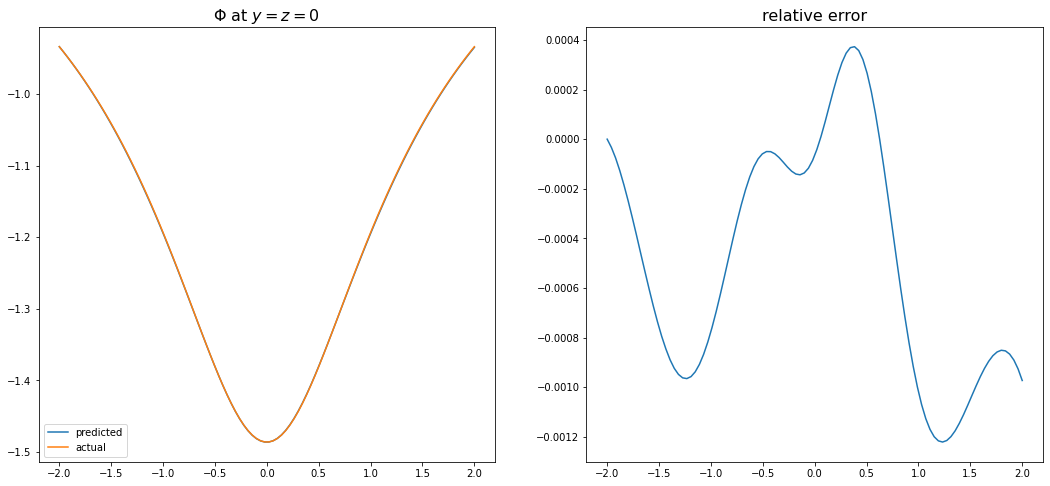

In [124]:
# Visualise
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

n_plot = 100
xs = np.linspace(-2, 2, n_plot)
eta_plot = np.zeros((n_plot, 3))
eta_plot[:, 0] = xs

ypred, ys = phi_model(eta_plot).numpy().reshape(n_plot,), phi(eta_plot)
#ax.plot(xs, ypred)
axs[0].plot(xs, ypred, label="predicted")
axs[0].plot(xs, ys - ys[0] + ypred[0], label="actual")
axs[0].set_title("$\Phi$ at $y=z=0$", fontsize=16)
axs[0].legend()
axs[1].plot(xs, (ys - ys[0] + ypred[0] - ypred)/ypred)
axs[1].set_title("relative error", fontsize=16)

<hr style="border:2px solid gray">

**2.** 
$$
\vec u_{LSR} \neq 0, \Omega_0 = 0, \Phi = 0
$$

Solution: $\vec v = \vec u_{LSR}$

In [2]:
# Generate the data!
n = 2**12
print(f'n={n}')
u_LSR = np.array([0.2, 1.0, 0.3], dtype='f4')

n_dim = 3

eta = np.random.normal(0, 1.0, size=(n, 2*n_dim)).astype('f4')
df_deta = np.random.normal(0, 1.0, size=(n, 2*n_dim)).astype('f4')

# Calculate df/dx such that Stationarity/BE is satisfied
q, p = eta[:, :n_dim], eta[:, n_dim:]
df_dq, df_dp = df_deta[:, :n_dim], df_deta[:, n_dim:]

# Set v = u_LSR
p = np.tile(u_LSR, (n, 1))

df_data = {'eta': np.hstack((q, p)), 'df_deta': df_deta}

# Sanity check
eq_val = np.sum(df_data['eta'][:,n_dim:] - u_LSR)
print(f'validation (should be 0): {eq_val:.1e}')

n=4096
validation (should be 0): 0.0e+00


In [10]:
importlib.reload(potential_frameshift_tf)
importlib.reload(fit_all)

# Train a model

print(params['Phi'])
directory = '../runs/sanity_checks/uniform_v2/'
potential_fname = f'{directory}Phi/phi'
potential_loss = f'{directory}potential_loss_history.png'
loss_history = f'{directory}loss_history_{{:02d}}.txt'
phi_model = fit_all.train_potential(
            df_data,
            potential_fname,
            potential_loss,
            loss_history,
            **params['Phi'], include_frameshift=True)

Tensorflow version 2.3.0
Tensorflow Probability version 0.11.0
Tensorflow version 2.3.0
Tensorflow Probability version 0.11.0
{'n_hidden': 4, 'hidden_size': 512, 'xi': 1.0, 'lam': 1.0, 'l2': 0.1, 'n_epochs': 4096, 'batch_size': 32768, 'lr': {'type': 'step', 'init': 0.001, 'patience': 2048, 'min_delta': 0.005, 'final': 0.0001}, 'optimizer': 'RAdam', 'warmup_proportion': 0.015625, 'max_checkpoints': 128, 'checkpoint_every': 16, 'frameshift': {'omega0': 0.0, 'r_c0': 0.0, 'theta_c0': 0.0, 'phi_c0': 0.0, 'u_LSRx0': 0.0, 'u_LSRy0': 0.0, 'u_LSRz0': 0.0}, 'validation_frac': 0.25}
Using coordinate scale: [0.99975175 1.0108576  1.0069036 ]
790528 variables in the gravitational potential model.
3 variables in the frameshift model.
384 steps planned.
Optimizer: <tensorflow_addons.optimizers.rectified_adam.RectifiedAdam object at 0x7fefd85e7ba8>
Tracing training_step with batch shape (32768, 4, 3) ...
c = 1.0
l2 = 0.1
L2 penalty on <tf.Variable 'Phi/hidden_0/w:0' shape=(3, 512) dtype=float32>
L2 pe

|            |  0% |Elapsed: 0:00:00|ETA:  00:00:00|loss: -0.1118, lr:    0.001

likelihood: 0.72087121
prior_neg: 0.148199096
loss (before penalty): -0.140331194
L2 penalty: 0.0264569521

global norm: 4.18860388
likelihood: 0.72230792
prior_neg: 0.145706892
loss (before penalty): -0.141546503
L2 penalty: 0.0264569465


|            |  0% |Elapsed: 0:00:01|ETA:   0:03:30|loss: -0.1128, lr:    0.001

likelihood: 0.721410036
prior_neg: 0.147786438
loss (before penalty): -0.140186086
L2 penalty: 0.0264569465

global norm: 4.18571806
likelihood: 0.721908271
prior_neg: 0.144460499
loss (before penalty): -0.143444628
L2 penalty: 0.026456926


|            |  0% |Elapsed: 0:00:02|ETA:   0:04:42|loss: -0.1131, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-1
likelihood: 0.719957709
prior_neg: 0.146291986
loss (before penalty): -0.143582031
L2 penalty: 0.026456926

global norm: 4.19416046
likelihood: 0.721397519
prior_neg: 0.142802402
loss (before penalty): -0.145950928
L2 penalty: 0.0264569111


|            |  1% |Elapsed: 0:00:03|ETA:   0:07:46|loss: -0.1141, lr:    0.001

likelihood: 0.72001493
prior_neg: 0.144635111
loss (before penalty): -0.145430326
L2 penalty: 0.0264569111

global norm: 4.16536522
likelihood: 0.720794082
prior_neg: 0.14073047
loss (before penalty): -0.149051622
L2 penalty: 0.0264568906


|            |  1% |Elapsed: 0:00:04|ETA:   0:07:48|loss: -0.1151, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-2
likelihood: 0.719168663
prior_neg: 0.142787158
loss (before penalty): -0.14855133
L2 penalty: 0.0264568906

global norm: 4.17852116
likelihood: 0.713689089
prior_neg: 0.109357089
loss (before penalty): -0.194742933
L2 penalty: 0.0264567342


|            |  1% |Elapsed: 0:00:06|ETA:   0:07:45|loss: -0.1163, lr:    0.001

likelihood: 0.707468867
prior_neg: 0.110244319
loss (before penalty): -0.201243684
L2 penalty: 0.0264567342

global norm: 3.87553668
likelihood: 0.708992124
prior_neg: 0.0773128569
loss (before penalty): -0.240411043
L2 penalty: 0.0264565479


|            |  1% |Elapsed: 0:00:07|ETA:   0:07:41|loss: -0.1246, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-3
likelihood: 0.700726032
prior_neg: 0.0760105848
loss (before penalty): -0.252653956
L2 penalty: 0.0264565479

global norm: 2.89480567
likelihood: 0.710667729
prior_neg: 0.0607498586
loss (before penalty): -0.259525388
L2 penalty: 0.02645633


|            |  2% |Elapsed: 0:00:08|ETA:   0:07:46|loss: -0.1373, lr:    0.001

likelihood: 0.699683189
prior_neg: 0.0586066619
loss (before penalty): -0.276689798
L2 penalty: 0.02645633

global norm: 2.5616622
likelihood: 0.716294229
prior_neg: 0.0780277699
loss (before penalty): -0.230266571
L2 penalty: 0.0264560115


|            |  2% |Elapsed: 0:00:09|ETA:   0:07:47|loss: -0.1499, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-4
likelihood: 0.704429567
prior_neg: 0.0755472183
loss (before penalty): -0.248491198
L2 penalty: 0.0264560115

global norm: 3.74512315
likelihood: 0.723314524
prior_neg: 0.102275401
loss (before penalty): -0.191657126
L2 penalty: 0.0264555868


|            |  2% |Elapsed: 0:00:10|ETA:   0:07:34|loss: -0.1571, lr:    0.001

likelihood: 0.710775793
prior_neg: 0.099674508
loss (before penalty): -0.210165232
L2 penalty: 0.0264555868

global norm: 4.13188267
likelihood: 0.72824651
prior_neg: 0.11774911
loss (before penalty): -0.167241186
L2 penalty: 0.026455069


|            |  2% |Elapsed: 0:00:12|ETA:   0:07:26|loss: -0.1595, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-5
likelihood: 0.714230537
prior_neg: 0.114914469
loss (before penalty): -0.187360212
L2 penalty: 0.026455069

global norm: 4.13662815
likelihood: 0.729438901
prior_neg: 0.121447921
loss (before penalty): -0.161476016
L2 penalty: 0.0264544673


|            |  3% |Elapsed: 0:00:13|ETA:   0:07:25|loss: -0.1596, lr:    0.001

likelihood: 0.716027915
prior_neg: 0.119230539
loss (before penalty): -0.180014044
L2 penalty: 0.0264544673

global norm: 4.10417604
likelihood: 0.726183
prior_neg: 0.113899052
loss (before penalty): -0.174256
L2 penalty: 0.0264538024


|            |  3% |Elapsed: 0:00:14|ETA:   0:07:29|loss: -0.1592, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-6
likelihood: 0.715057731
prior_neg: 0.112365179
loss (before penalty): -0.189439401
L2 penalty: 0.0264538024

global norm: 4.05361462
likelihood: 0.720152497
prior_neg: 0.0964387879
loss (before penalty): -0.202616453
L2 penalty: 0.0264530778


|            |  3% |Elapsed: 0:00:15|ETA:   0:08:07|loss: -0.1594, lr:    0.001

likelihood: 0.709605098
prior_neg: 0.0959183
loss (before penalty): -0.216263026
L2 penalty: 0.0264530778

global norm: 3.98961973
likelihood: 0.71392
prior_neg: 0.0729792267
loss (before penalty): -0.239654809
L2 penalty: 0.0264522936


|            |  3% |Elapsed: 0:00:17|ETA:   0:08:05|loss: -0.1615, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-7
likelihood: 0.705278039
prior_neg: 0.0726285279
loss (before penalty): -0.25114882
L2 penalty: 0.0264522936

global norm: 3.64126277
likelihood: 0.70925
prior_neg: 0.0531284325
loss (before penalty): -0.271312177
L2 penalty: 0.0264514424


|            |  4% |Elapsed: 0:00:18|ETA:   0:07:40|loss: -0.1654, lr:    0.001

likelihood: 0.701038718
prior_neg: 0.0515227
loss (before penalty): -0.284272611
L2 penalty: 0.0264514424

global norm: 2.21721339
likelihood: 0.705921233
prior_neg: 0.0528875701
loss (before penalty): -0.276005447
L2 penalty: 0.0264504701


|            |  4% |Elapsed: 0:00:19|ETA:   0:07:36|loss: -0.1708, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-8
likelihood: 0.699051738
prior_neg: 0.051771719
loss (before penalty): -0.286584765
L2 penalty: 0.0264504701

global norm: 2.41428876
likelihood: 0.705878258
prior_neg: 0.0583141819
loss (before penalty): -0.268935621
L2 penalty: 0.0264494363


|            |  4% |Elapsed: 0:00:20|ETA:   0:07:21|loss: -0.1758, lr:    0.001

likelihood: 0.701120257
prior_neg: 0.0581958592
loss (before penalty): -0.27533704
L2 penalty: 0.0264494363

global norm: 3.28123927
likelihood: 0.707461178
prior_neg: 0.0634934306
loss (before penalty): -0.260125786
L2 penalty: 0.0264483728


|            |  4% |Elapsed: 0:00:21|ETA:   0:07:19|loss: -0.1796, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-9
likelihood: 0.702351213
prior_neg: 0.0638213456
loss (before penalty): -0.266347826
L2 penalty: 0.0264483728

global norm: 3.83167338
likelihood: 0.708168268
prior_neg: 0.0626146
loss (before penalty): -0.260348469
L2 penalty: 0.0264473204


|            |  5% |Elapsed: 0:00:23|ETA:   0:07:18|loss: -0.1827, lr:    0.001

likelihood: 0.703128636
prior_neg: 0.0632566363
loss (before penalty): -0.266070366
L2 penalty: 0.0264473204

global norm: 3.93657351
likelihood: 0.7073915
prior_neg: 0.0547434241
loss (before penalty): -0.271631926
L2 penalty: 0.026446281


|            |  5% |Elapsed: 0:00:24|ETA:   0:07:18|loss: -0.1854, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-10
likelihood: 0.701114833
prior_neg: 0.0545651875
loss (before penalty): -0.28013733
L2 penalty: 0.026446281

global norm: 3.55924892
likelihood: 0.70639205
prior_neg: 0.0410475805
loss (before penalty): -0.291101813
L2 penalty: 0.0264452584


|            |  5% |Elapsed: 0:00:25|ETA:   0:07:16|loss: -0.1885, lr:    0.001

likelihood: 0.698724627
prior_neg: 0.0397206321
loss (before penalty): -0.303208262
L2 penalty: 0.0264452584

global norm: 2.89181948
likelihood: 0.706953406
prior_neg: 0.0315244682
loss (before penalty): -0.303164124
L2 penalty: 0.0264442619


|            |  5% |Elapsed: 0:00:26|ETA:   0:07:12|loss: -0.1923, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-11
likelihood: 0.696696162
prior_neg: 0.0293603167
loss (before penalty): -0.320127487
L2 penalty: 0.0264442619

global norm: 1.82472456
likelihood: 0.70874846
prior_neg: 0.0408405438
loss (before penalty): -0.288230121
L2 penalty: 0.0264432114


|            |  6% |Elapsed: 0:00:28|ETA:   0:07:15|loss: -0.1965, lr:    0.001

likelihood: 0.69795531
prior_neg: 0.0373890512
loss (before penalty): -0.307416379
L2 penalty: 0.0264432114

global norm: 3.081182
likelihood: 0.709720373
prior_neg: 0.044897005
loss (before penalty): -0.281544417
L2 penalty: 0.0264421441


|            |  6% |Elapsed: 0:00:29|ETA:   0:07:16|loss: -0.1999, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-12
likelihood: 0.698119
prior_neg: 0.0410051122
loss (before penalty): -0.302289337
L2 penalty: 0.0264421441

global norm: 3.25227284
likelihood: 0.708954036
prior_neg: 0.0404212922
loss (before penalty): -0.288515449
L2 penalty: 0.0264410675


|            |  6% |Elapsed: 0:00:30|ETA:   0:07:17|loss: -0.2028, lr:    0.001

likelihood: 0.698694885
prior_neg: 0.0370684825
loss (before penalty): -0.306847036
L2 penalty: 0.0264410675

global norm: 2.9913013
likelihood: 0.706930876
prior_neg: 0.0297279898
loss (before penalty): -0.305630594
L2 penalty: 0.0264399648


|            |  7% |Elapsed: 0:00:31|ETA:   0:07:14|loss: -0.2057, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-13
likelihood: 0.69761169
prior_neg: 0.0273743346
loss (before penalty): -0.321602911
L2 penalty: 0.0264399648

global norm: 2.24655271
likelihood: 0.705629945
prior_neg: 0.0236346982
loss (before penalty): -0.315718621
L2 penalty: 0.0264388062


|            |  7% |Elapsed: 0:00:32|ETA:   0:07:11|loss: -0.2089, lr:    0.001

likelihood: 0.69765985
prior_neg: 0.0224127546
loss (before penalty): -0.328403205
L2 penalty: 0.0264388062

global norm: 2.32321596
likelihood: 0.704781413
prior_neg: 0.0258878022
loss (before penalty): -0.313794523
L2 penalty: 0.0264376011


|            |  7% |Elapsed: 0:00:34|ETA:   0:07:10|loss: -0.2121, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-14
likelihood: 0.698539436
prior_neg: 0.0253525916
loss (before penalty): -0.323113024
L2 penalty: 0.0264376011

global norm: 3.45896721
likelihood: 0.704185128
prior_neg: 0.023711998
loss (before penalty): -0.317595571
L2 penalty: 0.0264364239


|            |  7% |Elapsed: 0:00:35|ETA:   0:07:07|loss: -0.2149, lr:    0.001

likelihood: 0.69792974
prior_neg: 0.023984924
loss (before penalty): -0.32584846
L2 penalty: 0.0264364239

global norm: 3.50664473
likelihood: 0.70460695
prior_neg: 0.0192562472
loss (before penalty): -0.32315287
L2 penalty: 0.0264352616


|            |  8% |Elapsed: 0:00:36|ETA:   0:07:08|loss: -0.2177, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-15
likelihood: 0.696304202
prior_neg: 0.0190049633
loss (before penalty): -0.33504045
L2 penalty: 0.0264352616

global norm: 2.09407949
likelihood: 0.704841852
prior_neg: 0.0214295071
loss (before penalty): -0.319831848
L2 penalty: 0.0264340788


|#           |  8% |Elapsed: 0:00:37|ETA:   0:07:09|loss: -0.2205, lr:    0.001

likelihood: 0.697087586
prior_neg: 0.0209495425
loss (before penalty): -0.331234
L2 penalty: 0.0264340788

global norm: 2.54196
likelihood: 0.705768526
prior_neg: 0.0226842854
loss (before penalty): -0.316832691
L2 penalty: 0.0264329165


|#           |  8% |Elapsed: 0:00:38|ETA:   0:07:10|loss: -0.2231, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-16
likelihood: 0.696743727
prior_neg: 0.0216597319
loss (before penalty): -0.330723941
L2 penalty: 0.0264329165

global norm: 3.36221671
likelihood: 0.706670761
prior_neg: 0.0159056857
loss (before penalty): -0.324932158
L2 penalty: 0.0264317896


|#           |  8% |Elapsed: 0:00:40|ETA:   0:07:40|loss: -0.2254, lr:    0.001

likelihood: 0.696510494
prior_neg: 0.0145314243
loss (before penalty): -0.341023892
L2 penalty: 0.0264317896

global norm: 2.57312703
likelihood: 0.706962049
prior_neg: 0.0152078923
loss (before penalty): -0.325495064
L2 penalty: 0.0264306702


|#            |  9% |Elapsed: 0:00:41|ETA:   0:07:36|loss: -0.228, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-17
likelihood: 0.696244717
prior_neg: 0.0136666792
loss (before penalty): -0.342615187
L2 penalty: 0.0264306702

global norm: 2.09202814
likelihood: 0.705433369
prior_neg: 0.0160961021
loss (before penalty): -0.326382041
L2 penalty: 0.0264295638


|#           |  9% |Elapsed: 0:00:42|ETA:   0:07:04|loss: -0.2304, lr:    0.001

likelihood: 0.696598649
prior_neg: 0.0152576324
loss (before penalty): -0.339879125
L2 penalty: 0.0264295638

global norm: 2.52746081
likelihood: 0.704253078
prior_neg: 0.0149705913
loss (before penalty): -0.329582781
L2 penalty: 0.0264284369


|#           |  9% |Elapsed: 0:00:44|ETA:   0:07:06|loss: -0.2327, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-18
likelihood: 0.696843624
prior_neg: 0.0139890872
loss (before penalty): -0.34131816
L2 penalty: 0.0264284369

global norm: 2.24986935
likelihood: 0.705245316
prior_neg: 0.0113120163
loss (before penalty): -0.333296955
L2 penalty: 0.0264273081


|#           |  9% |Elapsed: 0:00:45|ETA:   0:07:00|loss: -0.2348, lr:    0.001

likelihood: 0.695935607
prior_neg: 0.01082284
loss (before penalty): -0.347066253
L2 penalty: 0.0264273081

global norm: 1.62462604
likelihood: 0.70596981
prior_neg: 0.0135536948
loss (before penalty): -0.329166025
L2 penalty: 0.0264261868


|#            | 10% |Elapsed: 0:00:46|ETA:   0:07:02|loss: -0.237, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-19
likelihood: 0.69652915
prior_neg: 0.0130591448
loss (before penalty): -0.343070179
L2 penalty: 0.0264261868

global norm: 3.00585771
likelihood: 0.704643726
prior_neg: 0.0109383408
loss (before penalty): -0.334658802
L2 penalty: 0.0264250934


|#            | 10% |Elapsed: 0:00:47|ETA:   0:07:01|loss: -0.239, lr:    0.001

likelihood: 0.695080161
prior_neg: 0.0104383612
loss (before penalty): -0.348822296
L2 penalty: 0.0264250934

global norm: 2.05466437
likelihood: 0.703148603
prior_neg: 0.0130553674
loss (before penalty): -0.333790421
L2 penalty: 0.0264240112


|#           | 10% |Elapsed: 0:00:48|ETA:   0:06:54|loss: -0.2411, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-20
likelihood: 0.695702434
prior_neg: 0.0132429898
loss (before penalty): -0.343976766
L2 penalty: 0.0264240112

global norm: 2.65932965
likelihood: 0.703706324
prior_neg: 0.0114604607
loss (before penalty): -0.33523947
L2 penalty: 0.0264229421


|#           | 10% |Elapsed: 0:00:50|ETA:   0:06:50|loss: -0.2429, lr:    0.001

likelihood: 0.695440412
prior_neg: 0.0111092813
loss (before penalty): -0.347361803
L2 penalty: 0.0264229421

global norm: 2.13039279
likelihood: 0.705947757
prior_neg: 0.0123365819
loss (before penalty): -0.330889732
L2 penalty: 0.0264218599


|#           | 11% |Elapsed: 0:00:51|ETA:   0:06:50|loss: -0.2447, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-21
likelihood: 0.696899056
prior_neg: 0.0117472149
loss (before penalty): -0.344398826
L2 penalty: 0.0264218599

global norm: 2.86259723
likelihood: 0.705481887
prior_neg: 0.00892352313
loss (before penalty): -0.336304665
L2 penalty: 0.0264207665


|#           | 11% |Elapsed: 0:00:52|ETA:   0:06:52|loss: -0.2464, lr:    0.001

likelihood: 0.694714665
prior_neg: 0.00824945141
loss (before penalty): -0.352449417
L2 penalty: 0.0264207665

global norm: 1.87611663
likelihood: 0.703352153
prior_neg: 0.0144671649
loss (before penalty): -0.331537366
L2 penalty: 0.026419634


|#           | 11% |Elapsed: 0:00:53|ETA:   0:06:49|loss: -0.2481, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-22
likelihood: 0.694640398
prior_neg: 0.013948692
loss (before penalty): -0.344479501
L2 penalty: 0.026419634

global norm: 3.31493545
likelihood: 0.702793777
prior_neg: 0.0130939428
loss (before penalty): -0.334231943
L2 penalty: 0.0264185406


|#           | 11% |Elapsed: 0:00:55|ETA:   0:06:46|loss: -0.2497, lr:    0.001

likelihood: 0.695786834
prior_neg: 0.0123659354
loss (before penalty): -0.345095426
L2 penalty: 0.0264185406

global norm: 2.50206161
likelihood: 0.704506218
prior_neg: 0.0101852417
loss (before penalty): -0.33590427
L2 penalty: 0.0264174528


|#           | 12% |Elapsed: 0:00:56|ETA:   0:06:46|loss: -0.2511, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-23
likelihood: 0.695318103
prior_neg: 0.0102891987
loss (before penalty): -0.348696351
L2 penalty: 0.0264174528

global norm: 2.31968236
likelihood: 0.705857694
prior_neg: 0.0141241094
loss (before penalty): -0.328529358
L2 penalty: 0.0264163557


|#           | 12% |Elapsed: 0:00:57|ETA:   0:06:43|loss: -0.2526, lr:    0.001

likelihood: 0.695805073
prior_neg: 0.0133555215
loss (before penalty): -0.343673229
L2 penalty: 0.0264163557

global norm: 3.31353807
likelihood: 0.704169512
prior_neg: 0.00687735435
loss (before penalty): -0.341017
L2 penalty: 0.0264152866


|#           | 12% |Elapsed: 0:00:58|ETA:   0:06:44|loss: -0.2539, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-24
likelihood: 0.694169939
prior_neg: 0.00641659833
loss (before penalty): -0.355837286
L2 penalty: 0.0264152866

global norm: 2.34259987
likelihood: 0.702717721
prior_neg: 0.0148068825
loss (before penalty): -0.331948161
L2 penalty: 0.0264142361


|#           | 13% |Elapsed: 0:00:59|ETA:   0:06:46|loss: -0.2554, lr:    0.001

likelihood: 0.695414662
prior_neg: 0.0146174
loss (before penalty): -0.342445016
L2 penalty: 0.0264142361

global norm: 3.46298623
likelihood: 0.702767253
prior_neg: 0.0166090708
loss (before penalty): -0.329370648
L2 penalty: 0.0264131874


|#           | 13% |Elapsed: 0:01:00|ETA:   0:06:42|loss: -0.2595, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-25
likelihood: 0.695625126
prior_neg: 0.0169248357
loss (before penalty): -0.338905305
L2 penalty: 0.0264131874

global norm: 3.47365022
likelihood: 0.703927815
prior_neg: 0.00816374272
loss (before penalty): -0.339548767
L2 penalty: 0.026412148


|#           | 13% |Elapsed: 0:01:02|ETA:   0:06:42|loss: -0.2635, lr:    0.001

likelihood: 0.695145488
prior_neg: 0.00822513644
loss (before penalty): -0.351871222
L2 penalty: 0.026412148

global norm: 1.69233501
likelihood: 0.706106722
prior_neg: 0.0158153828
loss (before penalty): -0.325838119
L2 penalty: 0.0264110565


|#           | 13% |Elapsed: 0:01:03|ETA:   0:06:40|loss: -0.2677, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-26
likelihood: 0.694582522
prior_neg: 0.0152439019
loss (before penalty): -0.342734814
L2 penalty: 0.0264110565

global norm: 3.620399
likelihood: 0.705812097
prior_neg: 0.0147633255
loss (before penalty): -0.327705055
L2 penalty: 0.0264099985


|#           | 14% |Elapsed: 0:01:04|ETA:   0:06:37|loss: -0.2717, lr:    0.001

likelihood: 0.694992244
prior_neg: 0.0144063579
loss (before penalty): -0.343337774
L2 penalty: 0.0264099985

global norm: 3.55660915
likelihood: 0.702819824
prior_neg: 0.00836188905
loss (before penalty): -0.340827167
L2 penalty: 0.0264089555


|#           | 14% |Elapsed: 0:01:05|ETA:   0:06:36|loss: -0.2757, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-27
likelihood: 0.693905473
prior_neg: 0.00754335662
loss (before penalty): -0.354607284
L2 penalty: 0.0264089555

global norm: 2.27934384
likelihood: 0.702040315
prior_neg: 0.0121922977
loss (before penalty): -0.336546659
L2 penalty: 0.0264079031


|#           | 14% |Elapsed: 0:01:07|ETA:   0:07:07|loss: -0.2798, lr:    0.001

likelihood: 0.69444108
prior_neg: 0.0115635628
loss (before penalty): -0.348133504
L2 penalty: 0.0264079031

global norm: 3.03538394
likelihood: 0.7032637
prior_neg: 0.00945172831
loss (before penalty): -0.338672936
L2 penalty: 0.0264068786


|#           | 14% |Elapsed: 0:01:08|ETA:   0:07:08|loss: -0.2827, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-28
likelihood: 0.694515586
prior_neg: 0.00885369256
loss (before penalty): -0.351873279
L2 penalty: 0.0264068786

global norm: 2.27477169
likelihood: 0.705286443
prior_neg: 0.00984166656
loss (before penalty): -0.335293651
L2 penalty: 0.0264058597


|#           | 15% |Elapsed: 0:01:09|ETA:   0:06:37|loss: -0.2847, lr:    0.001

likelihood: 0.693350136
prior_neg: 0.00933138095
loss (before penalty): -0.35285157
L2 penalty: 0.0264058597

global norm: 2.92108369
likelihood: 0.704617918
prior_neg: 0.00870207231
loss (before penalty): -0.337825119
L2 penalty: 0.0264048483


|#           | 15% |Elapsed: 0:01:10|ETA:   0:06:36|loss: -0.2862, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-29
likelihood: 0.694981813
prior_neg: 0.00844285917
loss (before penalty): -0.351794451
L2 penalty: 0.0264048483

global norm: 2.86401796
likelihood: 0.701828
prior_neg: 0.00645260699
loss (before penalty): -0.344914973
L2 penalty: 0.0264038332


|#           | 15% |Elapsed: 0:01:12|ETA:   0:06:36|loss: -0.2883, lr:    0.001

likelihood: 0.692947209
prior_neg: 0.00609441055
loss (before penalty): -0.358045191
L2 penalty: 0.0264038332

global norm: 2.06426501
likelihood: 0.701341629
prior_neg: 0.00706245191
loss (before penalty): -0.34474045
L2 penalty: 0.026402805


|#           | 15% |Elapsed: 0:01:13|ETA:   0:06:31|loss: -0.2913, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-30
likelihood: 0.694300056
prior_neg: 0.0068305321
loss (before penalty): -0.355061322
L2 penalty: 0.026402805

global norm: 2.35028934
likelihood: 0.702876031
prior_neg: 0.00519143231
loss (before penalty): -0.345215797
L2 penalty: 0.0264017787


|#           | 16% |Elapsed: 0:01:14|ETA:   0:06:30|loss: -0.2946, lr:    0.001

likelihood: 0.693208694
prior_neg: 0.00498723611
loss (before penalty): -0.359255493
L2 penalty: 0.0264017787

global norm: 1.75377393
likelihood: 0.703416109
prior_neg: 0.00480292412
loss (before penalty): -0.345002
L2 penalty: 0.0264007


|#           | 16% |Elapsed: 0:01:15|ETA:   0:06:31|loss: -0.2982, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-31
likelihood: 0.693504333
prior_neg: 0.00454628188
loss (before penalty): -0.359463662
L2 penalty: 0.0264007

global norm: 1.91817331
likelihood: 0.701706886
prior_neg: 0.00503619155
loss (before penalty): -0.347088
L2 penalty: 0.0263996068


|##          | 16% |Elapsed: 0:01:17|ETA:   0:06:31|loss: -0.3016, lr:    0.001

likelihood: 0.692471445
prior_neg: 0.00421418669
loss (before penalty): -0.361421108
L2 penalty: 0.0263996068

global norm: 1.55886245
likelihood: 0.70181495
prior_neg: 0.00547568267
loss (before penalty): -0.346313596
L2 penalty: 0.0263984688


|##          | 16% |Elapsed: 0:01:18|ETA:   0:06:29|loss: -0.3045, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-32
likelihood: 0.693338037
prior_neg: 0.00447846437
loss (before penalty): -0.359799117
L2 penalty: 0.0263984688

global norm: 1.68493438
likelihood: 0.703030109
prior_neg: 0.00629517809
loss (before penalty): -0.34344095
L2 penalty: 0.0263973083


|##          | 17% |Elapsed: 0:01:19|ETA:   0:06:30|loss: -0.3067, lr:    0.001

likelihood: 0.692202806
prior_neg: 0.00526922289
loss (before penalty): -0.360292941
L2 penalty: 0.0263973083

global norm: 2.09899545
likelihood: 0.702071667
prior_neg: 0.00389371766
loss (before penalty): -0.348189056
L2 penalty: 0.0263961591


|##          | 17% |Elapsed: 0:01:20|ETA:   0:06:30|loss: -0.3082, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-33
likelihood: 0.692842126
prior_neg: 0.00334822247
loss (before penalty): -0.362132162
L2 penalty: 0.0263961591

global norm: 1.35612416
likelihood: 0.700156271
prior_neg: 0.00563002471
loss (before penalty): -0.348442793
L2 penalty: 0.0263949689


|##          | 17% |Elapsed: 0:01:21|ETA:   0:06:26|loss: -0.3097, lr:    0.001

likelihood: 0.692846656
prior_neg: 0.00502563175
loss (before penalty): -0.359719157
L2 penalty: 0.0263949689

global norm: 1.85754716
likelihood: 0.700815856
prior_neg: 0.00449879374
loss (before penalty): -0.349111199
L2 penalty: 0.0263937507


|##          | 17% |Elapsed: 0:01:23|ETA:   0:06:26|loss: -0.3114, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-34
likelihood: 0.691704631
prior_neg: 0.00427684281
loss (before penalty): -0.362432361
L2 penalty: 0.0263937507

global norm: 1.39081788
likelihood: 0.702595592
prior_neg: 0.00516023627
loss (before penalty): -0.345656157
L2 penalty: 0.0263924692


|##          | 18% |Elapsed: 0:01:24|ETA:   0:06:27|loss: -0.3133, lr:    0.001

likelihood: 0.693069339
prior_neg: 0.00466945581
loss (before penalty): -0.359910518
L2 penalty: 0.0263924692

global norm: 2.47468138
likelihood: 0.701697409
prior_neg: 0.00447143475
loss (before penalty): -0.347900867
L2 penalty: 0.026391197


|##          | 18% |Elapsed: 0:01:25|ETA:   0:06:24|loss: -0.3152, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-35
likelihood: 0.692295611
prior_neg: 0.00395910162
loss (before penalty): -0.362039864
L2 penalty: 0.026391197

global norm: 1.63929451
likelihood: 0.699974418
prior_neg: 0.00769146904
loss (before penalty): -0.345783174
L2 penalty: 0.0263898969


|##          | 18% |Elapsed: 0:01:26|ETA:   0:06:23|loss: -0.3169, lr:    0.001

likelihood: 0.692060709
prior_neg: 0.0073277643
loss (before penalty): -0.357548892
L2 penalty: 0.0263898969

global norm: 2.82964683
likelihood: 0.699564
prior_neg: 0.0049950378
loss (before penalty): -0.350183249
L2 penalty: 0.0263886582


|##          | 19% |Elapsed: 0:01:28|ETA:   0:06:21|loss: -0.3179, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-36
likelihood: 0.691430092
prior_neg: 0.00465944689
loss (before penalty): -0.362276942
L2 penalty: 0.0263886582

global norm: 1.80129135
likelihood: 0.701302052
prior_neg: 0.00440765219
loss (before penalty): -0.348551154
L2 penalty: 0.0263874065


|##          | 19% |Elapsed: 0:01:29|ETA:   0:06:14|loss: -0.3188, lr:    0.001

likelihood: 0.692395806
prior_neg: 0.00441943761
loss (before penalty): -0.361234963
L2 penalty: 0.0263874065

global norm: 2.20716929
likelihood: 0.701847315
prior_neg: 0.0053940136
loss (before penalty): -0.346383125
L2 penalty: 0.0263861567


|##          | 19% |Elapsed: 0:01:30|ETA:   0:06:12|loss: -0.3199, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-37
likelihood: 0.691903651
prior_neg: 0.00526350411
loss (before penalty): -0.360730171
L2 penalty: 0.0263861567

global norm: 2.46189189
likelihood: 0.699977398
prior_neg: 0.00392318657
loss (before penalty): -0.351118
L2 penalty: 0.0263849255


|##           | 19% |Elapsed: 0:01:31|ETA:   0:06:10|loss: -0.321, lr:    0.001

likelihood: 0.691658854
prior_neg: 0.00334957102
loss (before penalty): -0.363831431
L2 penalty: 0.0263849255

global norm: 1.43945444
likelihood: 0.699230611
prior_neg: 0.00574188773
loss (before penalty): -0.349596471
L2 penalty: 0.026383657


|##          | 20% |Elapsed: 0:01:32|ETA:   0:06:13|loss: -0.3222, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-38
likelihood: 0.690917969
prior_neg: 0.00509579
loss (before penalty): -0.362385958
L2 penalty: 0.026383657

global norm: 1.99485695
likelihood: 0.700081587
prior_neg: 0.00490870047
loss (before penalty): -0.349571288
L2 penalty: 0.0263823699


|##           | 20% |Elapsed: 0:01:34|ETA:   0:06:39|loss: -0.323, lr:    0.001

likelihood: 0.690647185
prior_neg: 0.00423187576
loss (before penalty): -0.364017546
L2 penalty: 0.0263823699

global norm: 2.31469727
likelihood: 0.700432718
prior_neg: 0.00365215028
loss (before penalty): -0.350856364
L2 penalty: 0.0263811


|##          | 20% |Elapsed: 0:01:35|ETA:   0:06:35|loss: -0.3237, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-39
likelihood: 0.691814721
prior_neg: 0.00289603649
loss (before penalty): -0.36425966
L2 penalty: 0.0263811

global norm: 1.61759579
likelihood: 0.699755907
prior_neg: 0.00334545132
loss (before penalty): -0.352254152
L2 penalty: 0.0263798293


|##          | 20% |Elapsed: 0:01:36|ETA:   0:06:07|loss: -0.3245, lr:    0.001

likelihood: 0.690666795
prior_neg: 0.00271722977
loss (before penalty): -0.36617133
L2 penalty: 0.0263798293

global norm: 1.84463847
likelihood: 0.699544668
prior_neg: 0.00438032765
loss (before penalty): -0.351083457
L2 penalty: 0.0263785701


|##          | 21% |Elapsed: 0:01:37|ETA:   0:06:04|loss: -0.3253, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-40
likelihood: 0.690360963
prior_neg: 0.00398195907
loss (before penalty): -0.364789426
L2 penalty: 0.0263785701

global norm: 1.90489495
likelihood: 0.698946476
prior_neg: 0.00224633701
loss (before penalty): -0.354972303
L2 penalty: 0.0263772961


|##          | 21% |Elapsed: 0:01:39|ETA:   0:06:04|loss: -0.3259, lr:    0.001

likelihood: 0.691252
prior_neg: 0.00190725329
loss (before penalty): -0.36649555
L2 penalty: 0.0263772961

global norm: 1.0781312
likelihood: 0.6998564
prior_neg: 0.00469152909
loss (before penalty): -0.350198746
L2 penalty: 0.0263759382


|##          | 21% |Elapsed: 0:01:40|ETA:   0:06:05|loss: -0.3266, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-41
likelihood: 0.690125346
prior_neg: 0.00404865714
loss (before penalty): -0.365032732
L2 penalty: 0.0263759382

global norm: 1.93929398
likelihood: 0.700233221
prior_neg: 0.00362782809
loss (before penalty): -0.351174384
L2 penalty: 0.0263745971


|##          | 21% |Elapsed: 0:01:41|ETA:   0:06:05|loss: -0.3273, lr:    0.001

likelihood: 0.690233171
prior_neg: 0.00319554
loss (before penalty): -0.366106868
L2 penalty: 0.0263745971

global norm: 1.46635902
likelihood: 0.698566556
prior_neg: 0.00405846443
loss (before penalty): -0.352931976
L2 penalty: 0.0263732355


|##          | 22% |Elapsed: 0:01:42|ETA:   0:06:02|loss: -0.3278, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-42
likelihood: 0.690433681
prior_neg: 0.00378672825
loss (before penalty): -0.364965677
L2 penalty: 0.0263732355

global norm: 1.74557602
likelihood: 0.697755277
prior_neg: 0.00365650444
loss (before penalty): -0.354660064
L2 penalty: 0.0263718497


|##          | 22% |Elapsed: 0:01:43|ETA:   0:05:57|loss: -0.3283, lr:    0.001

likelihood: 0.689598858
prior_neg: 0.00373571739
loss (before penalty): -0.366242677
L2 penalty: 0.0263718497

global norm: 1.59513032
likelihood: 0.699109614
prior_neg: 0.00391694251
loss (before penalty): -0.352360666
L2 penalty: 0.0263704266


|##          | 22% |Elapsed: 0:01:45|ETA:   0:05:54|loss: -0.3288, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-43
likelihood: 0.688503265
prior_neg: 0.00345942099
loss (before penalty): -0.36822319
L2 penalty: 0.0263704266

global norm: 1.90864182
likelihood: 0.699420691
prior_neg: 0.00338358711
loss (before penalty): -0.352676928
L2 penalty: 0.0263690557


|##          | 22% |Elapsed: 0:01:46|ETA:   0:05:56|loss: -0.3293, lr:    0.001

likelihood: 0.691526473
prior_neg: 0.00277713779
loss (before penalty): -0.364845902
L2 penalty: 0.0263690557

global norm: 1.50942409
likelihood: 0.697837472
prior_neg: 0.00367096649
loss (before penalty): -0.354522467
L2 penalty: 0.0263676699


|##          | 23% |Elapsed: 0:01:47|ETA:   0:05:57|loss: -0.3297, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-44
likelihood: 0.689104497
prior_neg: 0.00280466839
loss (before penalty): -0.368300647
L2 penalty: 0.0263676699

global norm: 1.48399127
likelihood: 0.698010206
prior_neg: 0.00436341856
loss (before penalty): -0.353289723
L2 penalty: 0.0263662543


|##          | 23% |Elapsed: 0:01:48|ETA:   0:05:56|loss: -0.3302, lr:    0.001

likelihood: 0.688903093
prior_neg: 0.00345622888
loss (before penalty): -0.367650211
L2 penalty: 0.0263662543

global norm: 1.54444444
likelihood: 0.698705316
prior_neg: 0.00263644196
loss (before penalty): -0.35476
L2 penalty: 0.0263648126


|##          | 23% |Elapsed: 0:01:49|ETA:   0:05:55|loss: -0.3306, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-45
likelihood: 0.689975262
prior_neg: 0.00186443375
loss (before penalty): -0.368401
L2 penalty: 0.0263648126

global norm: 1.23572445
likelihood: 0.697894454
prior_neg: 0.00274795527
loss (before penalty): -0.355757713
L2 penalty: 0.0263633523


|##          | 23% |Elapsed: 0:01:51|ETA:   0:05:54|loss: -0.3311, lr:    0.001

likelihood: 0.688452721
prior_neg: 0.0022243266
loss (before penalty): -0.370082915
L2 penalty: 0.0263633523

global norm: 1.18296349
likelihood: 0.696976662
prior_neg: 0.00251449482
loss (before penalty): -0.357402146
L2 penalty: 0.0263618771


|##          | 24% |Elapsed: 0:01:52|ETA:   0:05:53|loss: -0.3315, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-46
likelihood: 0.688641131
prior_neg: 0.0019166118
loss (before penalty): -0.370255709
L2 penalty: 0.0263618771

global norm: 1.27949095
likelihood: 0.697954595
prior_neg: 0.0027339817
loss (before penalty): -0.355691791
L2 penalty: 0.0263603479


|##          | 24% |Elapsed: 0:01:53|ETA:   0:05:54|loss: -0.3321, lr:    0.001

likelihood: 0.688686311
prior_neg: 0.0021930146
loss (before penalty): -0.369790077
L2 penalty: 0.0263603479

global norm: 1.38241017
likelihood: 0.69815129
prior_neg: 0.00323783862
loss (before penalty): -0.354692429
L2 penalty: 0.0263587926


|##          | 24% |Elapsed: 0:01:54|ETA:   0:05:50|loss: -0.3324, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-47
likelihood: 0.688344181
prior_neg: 0.00273975963
loss (before penalty): -0.369493961
L2 penalty: 0.0263587926

global norm: 1.50572431
likelihood: 0.6971246
prior_neg: 0.00211831462
loss (before penalty): -0.357757121
L2 penalty: 0.0263572428


|###         | 25% |Elapsed: 0:01:56|ETA:   0:05:47|loss: -0.3329, lr:    0.001

likelihood: 0.68867743
prior_neg: 0.00182988448
loss (before penalty): -0.370328754
L2 penalty: 0.0263572428

global norm: 1.08494437
likelihood: 0.696709692
prior_neg: 0.00216811174
loss (before penalty): -0.358279347
L2 penalty: 0.0263556633


|###         | 25% |Elapsed: 0:01:57|ETA:   0:05:48|loss: -0.3334, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-48
likelihood: 0.687311232
prior_neg: 0.00204329379
loss (before penalty): -0.371999562
L2 penalty: 0.0263556633

global norm: 1.27108467
likelihood: 0.696419895
prior_neg: 0.00267626392
loss (before penalty): -0.357967079
L2 penalty: 0.0263540596


|###         | 25% |Elapsed: 0:01:58|ETA:   0:06:12|loss: -0.3339, lr:    0.001

likelihood: 0.688133359
prior_neg: 0.00258802064
loss (before penalty): -0.37001881
L2 penalty: 0.0263540596

global norm: 1.28335965
likelihood: 0.696799099
prior_neg: 0.00212625298
loss (before penalty): -0.358211458
L2 penalty: 0.0263524242


|###         | 25% |Elapsed: 0:01:59|ETA:   0:06:08|loss: -0.3344, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-49
likelihood: 0.688328862
prior_neg: 0.00143174012
loss (before penalty): -0.371410757
L2 penalty: 0.0263524242

global norm: 1.14503598
likelihood: 0.697057128
prior_neg: 0.00340971816
loss (before penalty): -0.356008381
L2 penalty: 0.0263507552


|###         | 26% |Elapsed: 0:02:01|ETA:   0:05:42|loss: -0.3347, lr:    0.001

likelihood: 0.687692285
prior_neg: 0.00280347955
loss (before penalty): -0.370345324
L2 penalty: 0.0263507552

global norm: 1.70233202
likelihood: 0.695386767
prior_neg: 0.00243995828
loss (before penalty): -0.359784335
L2 penalty: 0.0263491161


|###         | 26% |Elapsed: 0:02:02|ETA:   0:05:42|loss: -0.3353, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-50
likelihood: 0.686659813
prior_neg: 0.00208113529
loss (before penalty): -0.372890025
L2 penalty: 0.0263491161

global norm: 1.24602807
likelihood: 0.696019828
prior_neg: 0.00207801582
loss (before penalty): -0.35939604
L2 penalty: 0.0263474621


|###          | 26% |Elapsed: 0:02:03|ETA:   0:05:41|loss: -0.336, lr:    0.001

likelihood: 0.687453866
prior_neg: 0.00167079992
loss (before penalty): -0.372333109
L2 penalty: 0.0263474621

global norm: 1.07081294
likelihood: 0.696634948
prior_neg: 0.00298317755
loss (before penalty): -0.357220501
L2 penalty: 0.0263457689


|###         | 26% |Elapsed: 0:02:04|ETA:   0:05:40|loss: -0.3364, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-51
likelihood: 0.68658179
prior_neg: 0.00254391623
loss (before penalty): -0.372331649
L2 penalty: 0.0263457689

global norm: 1.71645582
likelihood: 0.695066035
prior_neg: 0.00399479968
loss (before penalty): -0.358017564
L2 penalty: 0.0263440963


|###          | 27% |Elapsed: 0:02:05|ETA:   0:05:39|loss: -0.337, lr:    0.001

likelihood: 0.687049747
prior_neg: 0.00282500591
loss (before penalty): -0.371245176
L2 penalty: 0.0263440963

global norm: 1.57181561
likelihood: 0.695357263
prior_neg: 0.00184129621
loss (before penalty): -0.36068511
L2 penalty: 0.0263424311


|###         | 27% |Elapsed: 0:02:07|ETA:   0:05:37|loss: -0.3375, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-52
likelihood: 0.686611
prior_neg: 0.00122034736
loss (before penalty): -0.374211609
L2 penalty: 0.0263424311

global norm: 0.88925153
likelihood: 0.696380258
prior_neg: 0.00383178866
loss (before penalty): -0.356372058
L2 penalty: 0.026340723


|###         | 27% |Elapsed: 0:02:08|ETA:   0:05:34|loss: -0.3379, lr:    0.001

likelihood: 0.68677783
prior_neg: 0.0034743126
loss (before penalty): -0.370698273
L2 penalty: 0.026340723

global norm: 2.27267408
likelihood: 0.694811225
prior_neg: 0.00214358838
loss (before penalty): -0.361034662
L2 penalty: 0.0263390746


|###         | 27% |Elapsed: 0:02:09|ETA:   0:05:36|loss: -0.3384, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-53
likelihood: 0.686248302
prior_neg: 0.00189026527
loss (before penalty): -0.373765171
L2 penalty: 0.0263390746

global norm: 1.16110754
likelihood: 0.694745958
prior_neg: 0.00251535699
loss (before penalty): -0.360595
L2 penalty: 0.0263374206


|###         | 28% |Elapsed: 0:02:10|ETA:   0:05:36|loss: -0.3388, lr:    0.001

likelihood: 0.685970068
prior_neg: 0.00160239427
loss (before penalty): -0.374588
L2 penalty: 0.0263374206

global norm: 1.13120413
likelihood: 0.6961236
prior_neg: 0.00330822892
loss (before penalty): -0.357486844
L2 penalty: 0.0263357349


|###         | 28% |Elapsed: 0:02:11|ETA:   0:05:34|loss: -0.3392, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-54
likelihood: 0.686898708
prior_neg: 0.00274384301
loss (before penalty): -0.371581852
L2 penalty: 0.0263357349

global norm: 1.53428471
likelihood: 0.694874883
prior_neg: 0.00201760978
loss (before penalty): -0.361124098
L2 penalty: 0.0263340473


|###         | 28% |Elapsed: 0:02:13|ETA:   0:05:33|loss: -0.3396, lr:    0.001

likelihood: 0.685305953
prior_neg: 0.00143389753
loss (before penalty): -0.375799626
L2 penalty: 0.0263340473

global norm: 0.977291644
likelihood: 0.69368422
prior_neg: 0.00238773413
loss (before penalty): -0.362302125
L2 penalty: 0.0263322946


|###          | 28% |Elapsed: 0:02:14|ETA:   0:05:33|loss:  -0.34, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-55
likelihood: 0.686246216
prior_neg: 0.00194559665
loss (before penalty): -0.373687744
L2 penalty: 0.0263322946

global norm: 1.30622971
likelihood: 0.694725692
prior_neg: 0.00279708486
loss (before penalty): -0.360220134
L2 penalty: 0.0263305493


|###         | 29% |Elapsed: 0:02:15|ETA:   0:05:33|loss: -0.3404, lr:    0.001

likelihood: 0.684536
prior_neg: 0.00214596605
loss (before penalty): -0.375884086
L2 penalty: 0.0263305493

global norm: 1.46059048
likelihood: 0.694435239
prior_neg: 0.00236792653
loss (before penalty): -0.361252248
L2 penalty: 0.0263288226


|###         | 29% |Elapsed: 0:02:16|ETA:   0:05:28|loss: -0.3407, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-56
likelihood: 0.685672641
prior_neg: 0.00144228514
loss (before penalty): -0.375253677
L2 penalty: 0.0263288226

global norm: 1.01998377
likelihood: 0.693654656
prior_neg: 0.00184300554
loss (before penalty): -0.363127768
L2 penalty: 0.0263270773


|###          | 29% |Elapsed: 0:02:18|ETA:   0:05:28|loss: -0.341, lr:    0.001

likelihood: 0.685188651
prior_neg: 0.00115724991
loss (before penalty): -0.3763735
L2 penalty: 0.0263270773

global norm: 1.08492
likelihood: 0.694313526
prior_neg: 0.00345860282
loss (before penalty): -0.359862655
L2 penalty: 0.0263252743


|###         | 29% |Elapsed: 0:02:19|ETA:   0:05:27|loss: -0.3413, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-57
likelihood: 0.68552953
prior_neg: 0.00321578747
loss (before penalty): -0.372883618
L2 penalty: 0.0263252743

global norm: 2.31136
likelihood: 0.693705916
prior_neg: 0.00157745415
loss (before penalty): -0.363435894
L2 penalty: 0.0263235364


|###         | 30% |Elapsed: 0:02:20|ETA:   0:05:26|loss: -0.3416, lr:    0.001

likelihood: 0.684183121
prior_neg: 0.00130897539
loss (before penalty): -0.377618313
L2 penalty: 0.0263235364

global norm: 1.04081595
likelihood: 0.693001628
prior_neg: 0.00343817403
loss (before penalty): -0.361774
L2 penalty: 0.026321752


|###         | 30% |Elapsed: 0:02:21|ETA:   0:05:26|loss: -0.3419, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-58
likelihood: 0.684631586
prior_neg: 0.00269290037
loss (before penalty): -0.37494871
L2 penalty: 0.026321752

global norm: 1.81796694
likelihood: 0.693884254
prior_neg: 0.00238799723
loss (before penalty): -0.362014532
L2 penalty: 0.0263200253


|###         | 30% |Elapsed: 0:02:23|ETA:   0:05:46|loss: -0.3422, lr:    0.001

likelihood: 0.685387254
prior_neg: 0.00163866207
loss (before penalty): -0.375383288
L2 penalty: 0.0263200253

global norm: 1.08308971
likelihood: 0.693894207
prior_neg: 0.00183895743
loss (before penalty): -0.362789214
L2 penalty: 0.0263182949


|###         | 30% |Elapsed: 0:02:24|ETA:   0:05:46|loss: -0.3425, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-59
likelihood: 0.683690667
prior_neg: 0.00149570557
loss (before penalty): -0.378064454
L2 penalty: 0.0263182949

global norm: 1.24479568
likelihood: 0.691982925
prior_neg: 0.00257348618
loss (before penalty): -0.364482045
L2 penalty: 0.0263165683


|###         | 31% |Elapsed: 0:02:25|ETA:   0:05:22|loss: -0.3428, lr:    0.001

likelihood: 0.684192955
prior_neg: 0.00217066053
loss (before penalty): -0.376347691
L2 penalty: 0.0263165683

global norm: 1.15317583
likelihood: 0.692239344
prior_neg: 0.0020959375
loss (before penalty): -0.364800245
L2 penalty: 0.0263147838


|###         | 31% |Elapsed: 0:02:26|ETA:   0:05:22|loss: -0.3431, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-60
likelihood: 0.684201479
prior_neg: 0.00148992625
loss (before penalty): -0.377327591
L2 penalty: 0.0263147838

global norm: 1.04449427
likelihood: 0.694000483
prior_neg: 0.00319944555
loss (before penalty): -0.360682875
L2 penalty: 0.0263129566


|###         | 31% |Elapsed: 0:02:28|ETA:   0:05:22|loss: -0.3435, lr:    0.001

likelihood: 0.683350921
prior_neg: 0.00285553816
loss (before penalty): -0.376576632
L2 penalty: 0.0263129566

global norm: 2.12769556
likelihood: 0.692573786
prior_neg: 0.00237627979
loss (before penalty): -0.363915324
L2 penalty: 0.0263112225


|###         | 32% |Elapsed: 0:02:29|ETA:   0:05:19|loss: -0.3438, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-61
likelihood: 0.683585584
prior_neg: 0.00174351106
loss (before penalty): -0.377856135
L2 penalty: 0.0263112225

global norm: 1.04052222
likelihood: 0.691324413
prior_neg: 0.00289476826
loss (before penalty): -0.364967465
L2 penalty: 0.0263094585


|###         | 32% |Elapsed: 0:02:30|ETA:   0:05:17|loss: -0.3441, lr:    0.001

likelihood: 0.683538079
prior_neg: 0.00249432586
loss (before penalty): -0.376830399
L2 penalty: 0.0263094585

global norm: 1.46128154
likelihood: 0.692124963
prior_neg: 0.00228642859
loss (before penalty): -0.364690542
L2 penalty: 0.0263076965


|###         | 32% |Elapsed: 0:02:31|ETA:   0:05:17|loss: -0.3445, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-62
likelihood: 0.682979822
prior_neg: 0.0017865363
loss (before penalty): -0.378677487
L2 penalty: 0.0263076965

global norm: 1.01140749
likelihood: 0.692608
prior_neg: 0.00184815377
loss (before penalty): -0.364626229
L2 penalty: 0.0263058729


|###         | 32% |Elapsed: 0:02:32|ETA:   0:05:15|loss: -0.3448, lr:    0.001

likelihood: 0.683811605
prior_neg: 0.00148226193
loss (before penalty): -0.377907544
L2 penalty: 0.0263058729

global norm: 1.28340447
likelihood: 0.691198587
prior_neg: 0.00301917875
loss (before penalty): -0.364969522
L2 penalty: 0.026304055


|###         | 33% |Elapsed: 0:02:34|ETA:   0:05:14|loss: -0.3451, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-63
likelihood: 0.682608724
prior_neg: 0.00194510678
loss (before penalty): -0.378987938
L2 penalty: 0.026304055

global norm: 1.26045966
likelihood: 0.691682339
prior_neg: 0.0019131524
loss (before penalty): -0.365866303
L2 penalty: 0.0263022333


|####        | 33% |Elapsed: 0:02:35|ETA:   0:05:11|loss: -0.3454, lr:    0.001

likelihood: 0.682436943
prior_neg: 0.00120817078
loss (before penalty): -0.380316406
L2 penalty: 0.0263022333

global norm: 0.90761292
likelihood: 0.692121148
prior_neg: 0.00218668859
loss (before penalty): -0.364839792
L2 penalty: 0.0263004


|####        | 33% |Elapsed: 0:02:36|ETA:   0:05:09|loss: -0.3458, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-64
likelihood: 0.682504058
prior_neg: 0.00153718807
loss (before penalty): -0.37973702
L2 penalty: 0.0263004

global norm: 1.33365548
likelihood: 0.690600753
prior_neg: 0.00157056376
loss (before penalty): -0.36792177
L2 penalty: 0.0262985807


|####        | 33% |Elapsed: 0:02:37|ETA:   0:05:10|loss: -0.3461, lr:    0.001

likelihood: 0.682226896
prior_neg: 0.0012045186
loss (before penalty): -0.380628914
L2 penalty: 0.0262985807

global norm: 1.08690608
likelihood: 0.690981269
prior_neg: 0.00173650426
loss (before penalty): -0.367132604
L2 penalty: 0.026296718


|####        | 34% |Elapsed: 0:02:38|ETA:   0:05:10|loss: -0.3464, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-65
likelihood: 0.68211782
prior_neg: 0.00125748559
loss (before penalty): -0.380711
L2 penalty: 0.026296718

global norm: 0.972742915
likelihood: 0.691492438
prior_neg: 0.00138210272
loss (before penalty): -0.366906315
L2 penalty: 0.0262947977


|####        | 34% |Elapsed: 0:02:40|ETA:   0:05:09|loss: -0.3467, lr:    0.001

likelihood: 0.682172298
prior_neg: 0.00117034803
loss (before penalty): -0.380758792
L2 penalty: 0.0262947977

global norm: 1.1167866
likelihood: 0.690526366
prior_neg: 0.00165577023
loss (before penalty): -0.367906272
L2 penalty: 0.0262928884


|####         | 34% |Elapsed: 0:02:41|ETA:   0:05:05|loss: -0.347, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-66
likelihood: 0.681803942
prior_neg: 0.00116254552
loss (before penalty): -0.381309509
L2 penalty: 0.0262928884

global norm: 1.21171558
likelihood: 0.690384209
prior_neg: 0.00159623288
loss (before penalty): -0.368197531
L2 penalty: 0.0262910072


|####        | 34% |Elapsed: 0:02:42|ETA:   0:05:03|loss: -0.3473, lr:    0.001

likelihood: 0.68144834
prior_neg: 0.00126564223
loss (before penalty): -0.381679088
L2 penalty: 0.0262910072

global norm: 1.20163286
likelihood: 0.690799475
prior_neg: 0.00154637417
loss (before penalty): -0.367669821
L2 penalty: 0.026289111


|####        | 35% |Elapsed: 0:02:43|ETA:   0:05:04|loss: -0.3476, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-67
likelihood: 0.680958927
prior_neg: 0.00110494287
loss (before penalty): -0.382631868
L2 penalty: 0.026289111

global norm: 1.17041934
likelihood: 0.690145969
prior_neg: 0.00186800468
loss (before penalty): -0.368148953
L2 penalty: 0.0262872186


|####         | 35% |Elapsed: 0:02:45|ETA:   0:05:03|loss: -0.348, lr:    0.001

likelihood: 0.681930959
prior_neg: 0.00121391646
loss (before penalty): -0.381048352
L2 penalty: 0.0262872186

global norm: 1.02879989
likelihood: 0.689949214
prior_neg: 0.00146252324
loss (before penalty): -0.369019777
L2 penalty: 0.0262852963


|####        | 35% |Elapsed: 0:02:46|ETA:   0:05:00|loss: -0.3483, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-68
likelihood: 0.680878937
prior_neg: 0.000797699206
loss (before penalty): -0.383199871
L2 penalty: 0.0262852963

global norm: 0.831746578
likelihood: 0.690170288
prior_neg: 0.00123116083
loss (before penalty): -0.369034767
L2 penalty: 0.0262833573


|####        | 35% |Elapsed: 0:02:47|ETA:   0:05:21|loss: -0.3486, lr:    0.001

likelihood: 0.681081593
prior_neg: 0.00076250697
loss (before penalty): -0.382954389
L2 penalty: 0.0262833573

global norm: 1.00365734
likelihood: 0.689184725
prior_neg: 0.00133245147
loss (before penalty): -0.370314419
L2 penalty: 0.0262813717


|####        | 36% |Elapsed: 0:02:48|ETA:   0:05:20|loss: -0.3489, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-69
likelihood: 0.680255
prior_neg: 0.00102284038
loss (before penalty): -0.383785099
L2 penalty: 0.0262813717

global norm: 1.04499972
likelihood: 0.689573586
prior_neg: 0.000981423655
loss (before penalty): -0.370259702
L2 penalty: 0.026279388


|####        | 36% |Elapsed: 0:02:50|ETA:   0:04:57|loss: -0.3492, lr:    0.001

likelihood: 0.68074888
prior_neg: 0.000549196266
loss (before penalty): -0.383755356
L2 penalty: 0.026279388

global norm: 0.807649493
likelihood: 0.689695716
prior_neg: 0.00136836816
loss (before penalty): -0.369522572
L2 penalty: 0.0262774117


|####        | 36% |Elapsed: 0:02:51|ETA:   0:04:55|loss: -0.3496, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-70
likelihood: 0.679982781
prior_neg: 0.00103190634
loss (before penalty): -0.384171456
L2 penalty: 0.0262774117

global norm: 1.11490011
likelihood: 0.688674331
prior_neg: 0.0012848794
loss (before penalty): -0.371122867
L2 penalty: 0.0262754299


|####        | 36% |Elapsed: 0:02:52|ETA:   0:04:53|loss: -0.3499, lr:    0.001

likelihood: 0.681179225
prior_neg: 0.000947089749
loss (before penalty): -0.382540464
L2 penalty: 0.0262754299

global norm: 1.09516454
likelihood: 0.688784719
prior_neg: 0.00122368196
loss (before penalty): -0.371051431
L2 penalty: 0.0262734443


|####        | 37% |Elapsed: 0:02:53|ETA:   0:04:54|loss: -0.3501, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-71
likelihood: 0.679413795
prior_neg: 0.000834605424
loss (before penalty): -0.385297179
L2 penalty: 0.0262734443

global norm: 1.05374515
likelihood: 0.688942313
prior_neg: 0.00164830685
loss (before penalty): -0.370208
L2 penalty: 0.0262714624


|####        | 37% |Elapsed: 0:02:55|ETA:   0:04:51|loss: -0.3504, lr:    0.001

likelihood: 0.679572225
prior_neg: 0.00135761045
loss (before penalty): -0.384296089
L2 penalty: 0.0262714624

global norm: 1.48098934
likelihood: 0.687971413
prior_neg: 0.00139807584
loss (before penalty): -0.371977776
L2 penalty: 0.0262695309


|####        | 37% |Elapsed: 0:02:56|ETA:   0:04:48|loss: -0.3507, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-72
likelihood: 0.680096626
prior_neg: 0.000833123573
loss (before penalty): -0.384296268
L2 penalty: 0.0262695309

global norm: 0.990378141
likelihood: 0.688794196
prior_neg: 0.00161850266
loss (before penalty): -0.370465815
L2 penalty: 0.0262675714


|####         | 38% |Elapsed: 0:02:57|ETA:   0:04:47|loss: -0.351, lr:    0.001

likelihood: 0.679453611
prior_neg: 0.00120748451
loss (before penalty): -0.384690762
L2 penalty: 0.0262675714

global norm: 1.16225898
likelihood: 0.688736141
prior_neg: 0.00167310238
loss (before penalty): -0.370470762
L2 penalty: 0.0262656268


|####        | 38% |Elapsed: 0:02:58|ETA:   0:04:47|loss: -0.3513, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-73
likelihood: 0.679318666
prior_neg: 0.00102435332
loss (before penalty): -0.385158151
L2 penalty: 0.0262656268

global norm: 0.982209921
likelihood: 0.687463284
prior_neg: 0.00182958972
loss (before penalty): -0.372089058
L2 penalty: 0.0262636598


|####        | 38% |Elapsed: 0:02:59|ETA:   0:04:47|loss: -0.3516, lr:    0.001

likelihood: 0.678810418
prior_neg: 0.00105510117
loss (before penalty): -0.385860324
L2 penalty: 0.0262636598

global norm: 1.13717949
likelihood: 0.687967122
prior_neg: 0.0015938998
loss (before penalty): -0.371700019
L2 penalty: 0.0262616761


|####        | 38% |Elapsed: 0:03:01|ETA:   0:04:47|loss: -0.3519, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-74
likelihood: 0.679265261
prior_neg: 0.00116830564
loss (before penalty): -0.385025
L2 penalty: 0.0262616761

global norm: 1.10079432
likelihood: 0.687952161
prior_neg: 0.00122884975
loss (before penalty): -0.372251213
L2 penalty: 0.0262597352


|####        | 39% |Elapsed: 0:03:02|ETA:   0:04:44|loss: -0.3522, lr:    0.001

likelihood: 0.678037822
prior_neg: 0.000655879383
loss (before penalty): -0.387585253
L2 penalty: 0.0262597352

global norm: 0.838958681
likelihood: 0.687184095
prior_neg: 0.00212822761
loss (before penalty): -0.372060955
L2 penalty: 0.0262577832


|####        | 39% |Elapsed: 0:03:03|ETA:   0:04:42|loss: -0.3525, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-75
likelihood: 0.678836107
prior_neg: 0.00137711177
loss (before penalty): -0.385348976
L2 penalty: 0.0262577832

global norm: 1.16928625
likelihood: 0.68705678
prior_neg: 0.00101249455
loss (before penalty): -0.373865724
L2 penalty: 0.0262558069


|####        | 39% |Elapsed: 0:03:04|ETA:   0:04:43|loss: -0.3528, lr:    0.001

likelihood: 0.678794265
prior_neg: 0.000613680168
loss (before penalty): -0.386533499
L2 penalty: 0.0262558069

global norm: 0.928279877
likelihood: 0.687626541
prior_neg: 0.00122359034
loss (before penalty): -0.372731507
L2 penalty: 0.0262537934


|####        | 39% |Elapsed: 0:03:05|ETA:   0:04:41|loss: -0.3531, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-76
likelihood: 0.679037809
prior_neg: 0.00101334695
loss (before penalty): -0.385587275
L2 penalty: 0.0262537934

global norm: 1.1260798
likelihood: 0.686693847
prior_neg: 0.00119486195
loss (before penalty): -0.374128163
L2 penalty: 0.0262518171


|####        | 40% |Elapsed: 0:03:07|ETA:   0:04:41|loss: -0.3533, lr:    0.001

likelihood: 0.676895142
prior_neg: 0.000812161481
loss (before penalty): -0.389039755
L2 penalty: 0.0262518171

global norm: 0.892974615
likelihood: 0.686543763
prior_neg: 0.0018126436
loss (before penalty): -0.373448461
L2 penalty: 0.0262498297


|####        | 40% |Elapsed: 0:03:08|ETA:   0:04:42|loss: -0.3537, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-77
likelihood: 0.678206086
prior_neg: 0.00118697772
loss (before penalty): -0.386555374
L2 penalty: 0.0262498297

global norm: 0.983378232
likelihood: 0.686937749
prior_neg: 0.00113949704
loss (before penalty): -0.373854041
L2 penalty: 0.0262478087


|####        | 40% |Elapsed: 0:03:09|ETA:   0:04:40|loss: -0.3539, lr:    0.001

likelihood: 0.678204596
prior_neg: 0.000722712371
loss (before penalty): -0.387241215
L2 penalty: 0.0262478087

global norm: 1.00394869
likelihood: 0.686555088
prior_neg: 0.00123145734
loss (before penalty): -0.374276787
L2 penalty: 0.0262457859


|####        | 40% |Elapsed: 0:03:10|ETA:   0:04:37|loss: -0.3543, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-78
likelihood: 0.677164376
prior_neg: 0.000895939884
loss (before penalty): -0.388519049
L2 penalty: 0.0262457859

global norm: 0.94400686
likelihood: 0.686070323
prior_neg: 0.00155281008
loss (before penalty): -0.374514341
L2 penalty: 0.0262437742


|####        | 41% |Elapsed: 0:03:12|ETA:   0:04:53|loss: -0.3546, lr:    0.001

likelihood: 0.677347362
prior_neg: 0.000979346223
loss (before penalty): -0.388126194
L2 penalty: 0.0262437742

global norm: 1.06449461
likelihood: 0.686046
prior_neg: 0.00198974204
loss (before penalty): -0.373914421
L2 penalty: 0.0262417793


|####        | 41% |Elapsed: 0:03:13|ETA:   0:04:50|loss: -0.3548, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-79
likelihood: 0.676846
prior_neg: 0.00165195682
loss (before penalty): -0.387873709
L2 penalty: 0.0262417793

global norm: 1.31245279
likelihood: 0.686257958
prior_neg: 0.00177379907
loss (before penalty): -0.373920232
L2 penalty: 0.0262397975


|#####       | 41% |Elapsed: 0:03:14|ETA:   0:04:30|loss: -0.3552, lr:    0.001

likelihood: 0.676749706
prior_neg: 0.00130919798
loss (before penalty): -0.388521016
L2 penalty: 0.0262397975

global norm: 1.04437065
likelihood: 0.685270071
prior_neg: 0.00168940693
loss (before penalty): -0.375479758
L2 penalty: 0.026237784


|#####       | 41% |Elapsed: 0:03:15|ETA:   0:04:27|loss: -0.3554, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-80
likelihood: 0.67733252
prior_neg: 0.00130784314
loss (before penalty): -0.38766396
L2 penalty: 0.026237784

global norm: 1.10934794
likelihood: 0.685861349
prior_neg: 0.00186579092
loss (before penalty): -0.374363
L2 penalty: 0.0262357779


|#####       | 42% |Elapsed: 0:03:17|ETA:   0:04:25|loss: -0.3557, lr:    0.001

likelihood: 0.676810741
prior_neg: 0.00170616515
loss (before penalty): -0.387845933
L2 penalty: 0.0262357779

global norm: 1.18910551
likelihood: 0.685450196
prior_neg: 0.00115224265
loss (before penalty): -0.375999808
L2 penalty: 0.0262338053


|#####       | 42% |Elapsed: 0:03:18|ETA:   0:04:24|loss: -0.3559, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-81
likelihood: 0.675922692
prior_neg: 0.000680185971
loss (before penalty): -0.390670836
L2 penalty: 0.0262338053

global norm: 0.88985163
likelihood: 0.684923172
prior_neg: 0.00160608615
loss (before penalty): -0.376106501
L2 penalty: 0.0262318291


|#####       | 42% |Elapsed: 0:03:19|ETA:   0:04:24|loss: -0.3563, lr:    0.001

likelihood: 0.676857531
prior_neg: 0.00140253501
loss (before penalty): -0.388224453
L2 penalty: 0.0262318291

global norm: 1.33951187
likelihood: 0.685893893
prior_neg: 0.00250092056
loss (before penalty): -0.373392791
L2 penalty: 0.0262298938


|#####       | 42% |Elapsed: 0:03:20|ETA:   0:04:22|loss: -0.3565, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-82
likelihood: 0.675789237
prior_neg: 0.0019437623
loss (before penalty): -0.389001787
L2 penalty: 0.0262298938

global norm: 1.49131119
likelihood: 0.684762836
prior_neg: 0.00118011341
loss (before penalty): -0.376960814
L2 penalty: 0.0262279753


|#####       | 43% |Elapsed: 0:03:21|ETA:   0:04:20|loss: -0.3568, lr:    0.001

likelihood: 0.676110327
prior_neg: 0.00071612274
loss (before penalty): -0.390340537
L2 penalty: 0.0262279753

global norm: 0.858900249
likelihood: 0.684725881
prior_neg: 0.001659445
loss (before penalty): -0.376316
L2 penalty: 0.0262260325


|#####       | 43% |Elapsed: 0:03:23|ETA:   0:04:22|loss: -0.3571, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-83
likelihood: 0.676034868
prior_neg: 0.0011164539
loss (before penalty): -0.389860511
L2 penalty: 0.0262260325

global norm: 1.25113821
likelihood: 0.684900165
prior_neg: 0.00119761575
loss (before penalty): -0.376735091
L2 penalty: 0.0262241513


|#####       | 43% |Elapsed: 0:03:24|ETA:   0:04:24|loss: -0.3574, lr:    0.001

likelihood: 0.675911069
prior_neg: 0.0008777412
loss (before penalty): -0.390396
L2 penalty: 0.0262241513

global norm: 1.07751238
likelihood: 0.684475839
prior_neg: 0.0012135579
loss (before penalty): -0.377330631
L2 penalty: 0.0262222774


|#####       | 44% |Elapsed: 0:03:25|ETA:   0:04:22|loss: -0.3577, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-84
likelihood: 0.675183177
prior_neg: 0.000805001531
loss (before penalty): -0.391579747
L2 penalty: 0.0262222774

global norm: 0.954494715
likelihood: 0.684228301
prior_neg: 0.00151571678
loss (before penalty): -0.37725082
L2 penalty: 0.026220385


|#####       | 44% |Elapsed: 0:03:26|ETA:   0:04:19|loss: -0.3579, lr:    0.001

likelihood: 0.675585866
prior_neg: 0.000881909509
loss (before penalty): -0.390870452
L2 penalty: 0.026220385

global norm: 0.914026618
likelihood: 0.683764517
prior_neg: 0.001693564
loss (before penalty): -0.377668053
L2 penalty: 0.0262184348


|#####       | 44% |Elapsed: 0:03:27|ETA:   0:04:18|loss: -0.3582, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-85
likelihood: 0.674688637
prior_neg: 0.00104744686
loss (before penalty): -0.391952813
L2 penalty: 0.0262184348

global norm: 0.974117577
likelihood: 0.684330523
prior_neg: 0.0010435537
loss (before penalty): -0.377790391
L2 penalty: 0.0262164827


|#####       | 44% |Elapsed: 0:03:29|ETA:   0:04:16|loss: -0.3585, lr:    0.001

likelihood: 0.675313652
prior_neg: 0.000661242462
loss (before penalty): -0.391599238
L2 penalty: 0.0262164827

global norm: 0.937440395
likelihood: 0.683818817
prior_neg: 0.000913328782
loss (before penalty): -0.378727555
L2 penalty: 0.0262145493


|#####       | 45% |Elapsed: 0:03:30|ETA:   0:04:15|loss: -0.3588, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-86
likelihood: 0.67516011
prior_neg: 0.000509384729
loss (before penalty): -0.392051339
L2 penalty: 0.0262145493

global norm: 0.828954
likelihood: 0.683528602
prior_neg: 0.0011625574
loss (before penalty): -0.378787369
L2 penalty: 0.026212588


|#####       | 45% |Elapsed: 0:03:31|ETA:   0:04:14|loss: -0.3591, lr:    0.001

likelihood: 0.674715519
prior_neg: 0.000726292608
loss (before penalty): -0.392388195
L2 penalty: 0.026212588

global norm: 0.922304809
likelihood: 0.684026
prior_neg: 0.00122035993
loss (before penalty): -0.377976865
L2 penalty: 0.0262105949


|#####       | 45% |Elapsed: 0:03:32|ETA:   0:04:11|loss: -0.3594, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-87
likelihood: 0.674692094
prior_neg: 0.000733835623
loss (before penalty): -0.392411739
L2 penalty: 0.0262105949

global norm: 0.984343231
likelihood: 0.682913065
prior_neg: 0.00120285328
loss (before penalty): -0.379628032
L2 penalty: 0.0262086093


|#####       | 45% |Elapsed: 0:03:34|ETA:   0:04:09|loss: -0.3597, lr:    0.001

likelihood: 0.674175799
prior_neg: 0.000713985413
loss (before penalty): -0.393205941
L2 penalty: 0.0262086093

global norm: 0.886234343
likelihood: 0.682713091
prior_neg: 0.00109541765
loss (before penalty): -0.380077451
L2 penalty: 0.0262066331


|#####        | 46% |Elapsed: 0:03:35|ETA:   0:04:08|loss:  -0.36, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-88
likelihood: 0.673800826
prior_neg: 0.000553640246
loss (before penalty): -0.393999428
L2 penalty: 0.0262066331

global norm: 0.878206432
likelihood: 0.683653593
prior_neg: 0.00119712926
loss (before penalty): -0.378554255
L2 penalty: 0.0262046587


|#####       | 46% |Elapsed: 0:03:36|ETA:   0:04:23|loss: -0.3603, lr:    0.001

likelihood: 0.674394727
prior_neg: 0.000666290871
loss (before penalty): -0.392952323
L2 penalty: 0.0262046587

global norm: 1.01766288
likelihood: 0.682690144
prior_neg: 0.00189871225
loss (before penalty): -0.378936827
L2 penalty: 0.0262026526


|#####       | 46% |Elapsed: 0:03:37|ETA:   0:04:23|loss: -0.3606, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-89
likelihood: 0.67404
prior_neg: 0.0014142826
loss (before penalty): -0.392369837
L2 penalty: 0.0262026526

global norm: 1.20791757
likelihood: 0.6828655
prior_neg: 0.00112355209
loss (before penalty): -0.379813462
L2 penalty: 0.0262006875


|#####       | 46% |Elapsed: 0:03:38|ETA:   0:04:03|loss: -0.3608, lr:    0.001

likelihood: 0.673619509
prior_neg: 0.000658097328
loss (before penalty): -0.394113362
L2 penalty: 0.0262006875

global norm: 0.825578094
likelihood: 0.682662725
prior_neg: 0.00223858678
loss (before penalty): -0.378480375
L2 penalty: 0.0261987392


|#####       | 47% |Elapsed: 0:03:40|ETA:   0:04:00|loss: -0.3611, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-90
likelihood: 0.673718929
prior_neg: 0.00182338967
loss (before penalty): -0.392239511
L2 penalty: 0.0261987392

global norm: 1.86054683
likelihood: 0.682178855
prior_neg: 0.00146382081
loss (before penalty): -0.380319983
L2 penalty: 0.0261968579


|#####       | 47% |Elapsed: 0:03:41|ETA:   0:04:04|loss: -0.3613, lr:    0.001

likelihood: 0.673416913
prior_neg: 0.000912138
loss (before penalty): -0.394037098
L2 penalty: 0.0261968579

global norm: 1.04915702
likelihood: 0.683015704
prior_neg: 0.00115931442
loss (before penalty): -0.379541516
L2 penalty: 0.026194958


|#####       | 47% |Elapsed: 0:03:42|ETA:   0:04:05|loss: -0.3616, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-91
likelihood: 0.67374146
prior_neg: 0.000699056545
loss (before penalty): -0.393871814
L2 penalty: 0.026194958

global norm: 1.04782498
likelihood: 0.682350755
prior_neg: 0.00130048674
loss (before penalty): -0.380307347
L2 penalty: 0.0261930656


|#####       | 47% |Elapsed: 0:03:43|ETA:   0:04:02|loss: -0.3619, lr:    0.001

likelihood: 0.673148572
prior_neg: 0.000820768881
loss (before penalty): -0.394570678
L2 penalty: 0.0261930656

global norm: 1.13455355
likelihood: 0.680847108
prior_neg: 0.00184739078
loss (before penalty): -0.381707728
L2 penalty: 0.0261911601


|#####       | 48% |Elapsed: 0:03:44|ETA:   0:04:00|loss: -0.3621, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-92
likelihood: 0.672787726
prior_neg: 0.00142416672
loss (before penalty): -0.394210875
L2 penalty: 0.0261911601

global norm: 1.27753174
likelihood: 0.68199122
prior_neg: 0.00119475927
loss (before penalty): -0.380988061
L2 penalty: 0.0261892918


|#####       | 48% |Elapsed: 0:03:46|ETA:   0:03:59|loss: -0.3623, lr:    0.001

likelihood: 0.672892034
prior_neg: 0.000892250915
loss (before penalty): -0.394845217
L2 penalty: 0.0261892918

global norm: 1.00100029
likelihood: 0.682487
prior_neg: 0.00193823897
loss (before penalty): -0.379175872
L2 penalty: 0.0261874348


|#####       | 48% |Elapsed: 0:03:47|ETA:   0:03:58|loss: -0.3626, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-93
likelihood: 0.672700703
prior_neg: 0.00153434277
loss (before penalty): -0.394176573
L2 penalty: 0.0261874348

global norm: 1.59759486
likelihood: 0.681287408
prior_neg: 0.0018837885
loss (before penalty): -0.381009847
L2 penalty: 0.0261856522


|#####       | 48% |Elapsed: 0:03:48|ETA:   0:03:58|loss: -0.3628, lr:    0.001

likelihood: 0.672673464
prior_neg: 0.00124643464
loss (before penalty): -0.394644
L2 penalty: 0.0261856522

global norm: 1.01863837
likelihood: 0.681393862
prior_neg: 0.00215869374
loss (before penalty): -0.380451798
L2 penalty: 0.0261838045


|#####       | 49% |Elapsed: 0:03:49|ETA:   0:03:58|loss: -0.3631, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-94
likelihood: 0.672113419
prior_neg: 0.00150758924
loss (before penalty): -0.395087659
L2 penalty: 0.0261838045

global norm: 1.5094856
likelihood: 0.68089062
prior_neg: 0.00199893909
loss (before penalty): -0.381422102
L2 penalty: 0.0261819847


|#####       | 49% |Elapsed: 0:03:51|ETA:   0:03:55|loss: -0.3633, lr:    0.001

likelihood: 0.672652364
prior_neg: 0.00146405492
loss (before penalty): -0.394352525
L2 penalty: 0.0261819847

global norm: 1.33298981
likelihood: 0.680599093
prior_neg: 0.00120273116
loss (before penalty): -0.383016109
L2 penalty: 0.0261802319


|#####       | 49% |Elapsed: 0:03:52|ETA:   0:03:53|loss: -0.3635, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-95
likelihood: 0.671840131
prior_neg: 0.00079735
loss (before penalty): -0.396548778
L2 penalty: 0.0261802319

global norm: 0.847975791
likelihood: 0.680771887
prior_neg: 0.00127324555
loss (before penalty): -0.382659316
L2 penalty: 0.0261784773


|######      | 50% |Elapsed: 0:03:53|ETA:   0:03:54|loss: -0.3638, lr:    0.001

likelihood: 0.672174573
prior_neg: 0.000897175865
loss (before penalty): -0.39590326
L2 penalty: 0.0261784773

global norm: 0.997339547
likelihood: 0.680715919
prior_neg: 0.0014607237
loss (before penalty): -0.382466733
L2 penalty: 0.0261766817


|######       | 50% |Elapsed: 0:03:54|ETA:   0:03:53|loss: -0.364, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-96
likelihood: 0.671310425
prior_neg: 0.00102671352
loss (before penalty): -0.396995306
L2 penalty: 0.0261766817

global norm: 1.02935743
likelihood: 0.68109262
prior_neg: 0.00115685607
loss (before penalty): -0.382359952
L2 penalty: 0.0261748377


|######      | 50% |Elapsed: 0:03:55|ETA:   0:03:50|loss: -0.3643, lr:    0.001

likelihood: 0.672103167
prior_neg: 0.000629340066
loss (before penalty): -0.396407455
L2 penalty: 0.0261748377

global norm: 0.869808912
likelihood: 0.680594921
prior_neg: 0.00111147738
loss (before penalty): -0.38315618
L2 penalty: 0.0261729863


|######      | 50% |Elapsed: 0:03:57|ETA:   0:03:50|loss: -0.3645, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-97
likelihood: 0.672443748
prior_neg: 0.000731945736
loss (before penalty): -0.395748913
L2 penalty: 0.0261729863

global norm: 0.953343034
likelihood: 0.679823518
prior_neg: 0.00120532559
loss (before penalty): -0.384150624
L2 penalty: 0.0261711515


|######      | 51% |Elapsed: 0:03:58|ETA:   0:03:49|loss: -0.3648, lr:    0.001

likelihood: 0.670131683
prior_neg: 0.000863529509
loss (before penalty): -0.398993254
L2 penalty: 0.0261711515

global norm: 0.971001387
likelihood: 0.680403113
prior_neg: 0.000933622243
loss (before penalty): -0.383698583
L2 penalty: 0.0261692889


|######       | 51% |Elapsed: 0:03:59|ETA:   0:03:48|loss: -0.365, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-98
likelihood: 0.671630085
prior_neg: 0.000538296241
loss (before penalty): -0.39724642
L2 penalty: 0.0261692889

global norm: 0.883663416
likelihood: 0.680083156
prior_neg: 0.00099753309
loss (before penalty): -0.384074658
L2 penalty: 0.0261674114


|######      | 51% |Elapsed: 0:04:00|ETA:   0:03:46|loss: -0.3653, lr:    0.001

likelihood: 0.670278549
prior_neg: 0.000553236867
loss (before penalty): -0.399236858
L2 penalty: 0.0261674114

global norm: 0.871647358
likelihood: 0.679736435
prior_neg: 0.00092706125
loss (before penalty): -0.384687275
L2 penalty: 0.0261655282


|######      | 51% |Elapsed: 0:04:01|ETA:   0:03:43|loss: -0.3656, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-99
likelihood: 0.672027469
prior_neg: 0.000492263935
loss (before penalty): -0.396723807
L2 penalty: 0.0261655282

global norm: 0.811486602
likelihood: 0.679858387
prior_neg: 0.00152553024
loss (before penalty): -0.383629471
L2 penalty: 0.0261636432


|######      | 52% |Elapsed: 0:04:03|ETA:   0:04:00|loss: -0.3658, lr:    0.001

likelihood: 0.670302629
prior_neg: 0.00107342214
loss (before penalty): -0.398425877
L2 penalty: 0.0261636432

global norm: 1.17460477
likelihood: 0.679598212
prior_neg: 0.00134693307
loss (before penalty): -0.384273499
L2 penalty: 0.0261617545


|######       | 52% |Elapsed: 0:04:04|ETA:   0:03:58|loss: -0.366, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-100
likelihood: 0.671412706
prior_neg: 0.000746367848
loss (before penalty): -0.397260249
L2 penalty: 0.0261617545

global norm: 0.995609462
likelihood: 0.679727912
prior_neg: 0.00104257045
loss (before penalty): -0.38453
L2 penalty: 0.0261598621


|######      | 52% |Elapsed: 0:04:05|ETA:   0:03:39|loss: -0.3663, lr:    0.001

likelihood: 0.669743538
prior_neg: 0.000525247597
loss (before penalty): -0.400076479
L2 penalty: 0.0261598621

global norm: 0.871001363
likelihood: 0.679655552
prior_neg: 0.000884449924
loss (before penalty): -0.384868741
L2 penalty: 0.0261579882


|######      | 52% |Elapsed: 0:04:06|ETA:   0:03:38|loss: -0.3665, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-101
likelihood: 0.670971274
prior_neg: 0.000596890401
loss (before penalty): -0.398139685
L2 penalty: 0.0261579882

global norm: 1.03175235
likelihood: 0.67858994
prior_neg: 0.00136137707
loss (before penalty): -0.385734081
L2 penalty: 0.0261560921


|######      | 53% |Elapsed: 0:04:08|ETA:   0:03:37|loss: -0.3668, lr:    0.001

likelihood: 0.669567347
prior_neg: 0.0010844816
loss (before penalty): -0.399505138
L2 penalty: 0.0261560921

global norm: 1.08394384
likelihood: 0.679292
prior_neg: 0.00092674
loss (before penalty): -0.38534075
L2 penalty: 0.0261542052


|######       | 53% |Elapsed: 0:04:09|ETA:   0:03:35|loss: -0.367, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-102
likelihood: 0.670969427
prior_neg: 0.000530384073
loss (before penalty): -0.398241669
L2 penalty: 0.0261542052

global norm: 0.868979
likelihood: 0.679738164
prior_neg: 0.000906516332
loss (before penalty): -0.384714842
L2 penalty: 0.0261523277


|######      | 53% |Elapsed: 0:04:10|ETA:   0:03:34|loss: -0.3672, lr:    0.001

likelihood: 0.669867754
prior_neg: 0.000515342806
loss (before penalty): -0.39990595
L2 penalty: 0.0261523277

global norm: 1.01143
likelihood: 0.678403378
prior_neg: 0.00218707626
loss (before penalty): -0.384794623
L2 penalty: 0.026150465


|######      | 53% |Elapsed: 0:04:11|ETA:   0:03:34|loss: -0.3675, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-103
likelihood: 0.67018342
prior_neg: 0.00164632639
loss (before penalty): -0.397750318
L2 penalty: 0.026150465

global norm: 1.66789031
likelihood: 0.678443611
prior_neg: 0.00112657156
loss (before penalty): -0.386294663
L2 penalty: 0.0261486713


|######      | 54% |Elapsed: 0:04:13|ETA:   0:03:33|loss: -0.3677, lr:    0.001

likelihood: 0.669768333
prior_neg: 0.0007516474
loss (before penalty): -0.399701834
L2 penalty: 0.0261486713

global norm: 0.957247376
likelihood: 0.679094672
prior_neg: 0.000969459361
loss (before penalty): -0.385568082
L2 penalty: 0.0261468496


|######      | 54% |Elapsed: 0:04:14|ETA:   0:03:33|loss: -0.3679, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-104
likelihood: 0.669286966
prior_neg: 0.000539391302
loss (before penalty): -0.400736898
L2 penalty: 0.0261468496

global norm: 0.956041
likelihood: 0.678719401
prior_neg: 0.00219148654
loss (before penalty): -0.384323746
L2 penalty: 0.0261450242


|######      | 54% |Elapsed: 0:04:15|ETA:   0:03:30|loss: -0.3682, lr:    0.001

likelihood: 0.669227719
prior_neg: 0.00148307462
loss (before penalty): -0.399417222
L2 penalty: 0.0261450242

global norm: 1.28573918
likelihood: 0.677700043
prior_neg: 0.00131877745
loss (before penalty): -0.387106478
L2 penalty: 0.0261432622


|######      | 54% |Elapsed: 0:04:16|ETA:   0:03:29|loss: -0.3684, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-105
likelihood: 0.669480264
prior_neg: 0.000968523906
loss (before penalty): -0.39980796
L2 penalty: 0.0261432622

global norm: 1.07049572
likelihood: 0.678311229
prior_neg: 0.00105974427
loss (before penalty): -0.386588097
L2 penalty: 0.0261415


|######      | 55% |Elapsed: 0:04:17|ETA:   0:03:28|loss: -0.3686, lr:    0.001

likelihood: 0.669142962
prior_neg: 0.000653359923
loss (before penalty): -0.400781661
L2 penalty: 0.0261415

global norm: 0.924356699
likelihood: 0.678505182
prior_neg: 0.00109538983
loss (before penalty): -0.386250108
L2 penalty: 0.026139725


|######      | 55% |Elapsed: 0:04:19|ETA:   0:03:27|loss: -0.3689, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-106
likelihood: 0.669446588
prior_neg: 0.000666966545
loss (before penalty): -0.400307983
L2 penalty: 0.026139725

global norm: 0.921505034
likelihood: 0.677579761
prior_neg: 0.00154601375
loss (before penalty): -0.386948824
L2 penalty: 0.0261379313


|######      | 55% |Elapsed: 0:04:20|ETA:   0:03:25|loss: -0.3691, lr:    0.001

likelihood: 0.669089913
prior_neg: 0.000802268391
loss (before penalty): -0.400638491
L2 penalty: 0.0261379313

global norm: 0.892894745
likelihood: 0.677405953
prior_neg: 0.00127544941
loss (before penalty): -0.387603432
L2 penalty: 0.0261361357


|######      | 55% |Elapsed: 0:04:21|ETA:   0:03:24|loss: -0.3693, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-107
likelihood: 0.668148518
prior_neg: 0.000706568
loss (before penalty): -0.402187794
L2 penalty: 0.0261361357

global norm: 0.964314
likelihood: 0.678367555
prior_neg: 0.00162214239
loss (before penalty): -0.385677725
L2 penalty: 0.0261343457


|######      | 56% |Elapsed: 0:04:22|ETA:   0:03:22|loss: -0.3696, lr:    0.001

likelihood: 0.668685853
prior_neg: 0.00110596861
loss (before penalty): -0.400788337
L2 penalty: 0.0261343457

global norm: 1.26626992
likelihood: 0.677508712
prior_neg: 0.000828415272
loss (before penalty): -0.388111085
L2 penalty: 0.026132578


|######      | 56% |Elapsed: 0:04:23|ETA:   0:03:21|loss: -0.3698, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-108
likelihood: 0.668286204
prior_neg: 0.00036148139
loss (before penalty): -0.402497858
L2 penalty: 0.026132578

global norm: 0.843022
likelihood: 0.676735759
prior_neg: 0.00147579215
loss (before penalty): -0.388296068
L2 penalty: 0.0261308048


|######      | 56% |Elapsed: 0:04:25|ETA:   0:03:22|loss: -0.3701, lr:    0.001

likelihood: 0.668783605
prior_neg: 0.000754067209
loss (before penalty): -0.40116787
L2 penalty: 0.0261308048

global norm: 1.03112137
likelihood: 0.677604556
prior_neg: 0.00100097875
loss (before penalty): -0.38771522
L2 penalty: 0.0261290073


|######      | 57% |Elapsed: 0:04:26|ETA:   0:03:20|loss: -0.3703, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-109
likelihood: 0.668628514
prior_neg: 0.000475783803
loss (before penalty): -0.401815265
L2 penalty: 0.0261290073

global norm: 0.887194395
likelihood: 0.677717447
prior_neg: 0.00143705611
loss (before penalty): -0.386906534
L2 penalty: 0.0261272229


|######      | 57% |Elapsed: 0:04:27|ETA:   0:03:19|loss: -0.3705, lr:    0.001

likelihood: 0.667706072
prior_neg: 0.000913277967
loss (before penalty): -0.402540296
L2 penalty: 0.0261272229

global norm: 1.03271341
likelihood: 0.676684141
prior_neg: 0.000952824601
loss (before penalty): -0.389143556
L2 penalty: 0.0261254311


|######      | 57% |Elapsed: 0:04:28|ETA:   0:03:18|loss: -0.3707, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-110
likelihood: 0.667979598
prior_neg: 0.000512181141
loss (before penalty): -0.402731091
L2 penalty: 0.0261254311

global norm: 0.886643589
likelihood: 0.676490843
prior_neg: 0.000953699928
loss (before penalty): -0.389427543
L2 penalty: 0.0261236522


|######      | 57% |Elapsed: 0:04:30|ETA:   0:03:31|loss: -0.3709, lr:    0.001

likelihood: 0.667928457
prior_neg: 0.000449687766
loss (before penalty): -0.402901143
L2 penalty: 0.0261236522

global norm: 0.858069479
likelihood: 0.676792264
prior_neg: 0.000843378482
loss (before penalty): -0.389145672
L2 penalty: 0.0261218753


|######      | 58% |Elapsed: 0:04:31|ETA:   0:03:29|loss: -0.3712, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-111
likelihood: 0.667852879
prior_neg: 0.000406408799
loss (before penalty): -0.403078973
L2 penalty: 0.0261218753

global norm: 0.851242959
likelihood: 0.676909089
prior_neg: 0.000751327141
loss (before penalty): -0.389108896
L2 penalty: 0.0261201


|#######     | 58% |Elapsed: 0:04:32|ETA:   0:03:12|loss: -0.3714, lr:    0.001

likelihood: 0.667400479
prior_neg: 0.000330357434
loss (before penalty): -0.403870076
L2 penalty: 0.0261201

global norm: 0.816225111
likelihood: 0.676329374
prior_neg: 0.00106425234
loss (before penalty): -0.389502674
L2 penalty: 0.0261183269


|#######     | 58% |Elapsed: 0:04:33|ETA:   0:03:11|loss: -0.3716, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-112
likelihood: 0.667424083
prior_neg: 0.000580578693
loss (before penalty): -0.403460175
L2 penalty: 0.0261183269

global norm: 0.87484473
likelihood: 0.67606163
prior_neg: 0.000807109056
loss (before penalty): -0.390277833
L2 penalty: 0.0261165537


|#######     | 58% |Elapsed: 0:04:35|ETA:   0:03:11|loss: -0.3718, lr:    0.001

likelihood: 0.667335391
prior_neg: 0.000362358696
loss (before penalty): -0.403919637
L2 penalty: 0.0261165537

global norm: 0.809387
likelihood: 0.676011622
prior_neg: 0.000790825696
loss (before penalty): -0.390375853
L2 penalty: 0.026114786


|#######     | 59% |Elapsed: 0:04:36|ETA:   0:03:10|loss: -0.3721, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-113
likelihood: 0.666854143
prior_neg: 0.000402195146
loss (before penalty): -0.40458104
L2 penalty: 0.026114786

global norm: 0.884689748
likelihood: 0.676072717
prior_neg: 0.000712976791
loss (before penalty): -0.390400589
L2 penalty: 0.0261130184


|#######     | 59% |Elapsed: 0:04:37|ETA:   0:03:08|loss: -0.3723, lr:    0.001

likelihood: 0.666782856
prior_neg: 0.000333394855
loss (before penalty): -0.404790908
L2 penalty: 0.0261130184

global norm: 0.846724868
likelihood: 0.675797462
prior_neg: 0.00105639268
loss (before penalty): -0.3903
L2 penalty: 0.0261112601


|#######     | 59% |Elapsed: 0:04:38|ETA:   0:03:07|loss: -0.3725, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-114
likelihood: 0.667081833
prior_neg: 0.000659968238
loss (before penalty): -0.403853744
L2 penalty: 0.0261112601

global norm: 1.01343441
likelihood: 0.67661792
prior_neg: 0.00143676088
loss (before penalty): -0.388527334
L2 penalty: 0.0261094924


|#######     | 59% |Elapsed: 0:04:39|ETA:   0:03:07|loss: -0.3727, lr:    0.001

likelihood: 0.666614294
prior_neg: 0.000914198114
loss (before penalty): -0.404173255
L2 penalty: 0.0261094924

global norm: 1.2082566
likelihood: 0.675804
prior_neg: 0.00111206295
loss (before penalty): -0.390208
L2 penalty: 0.026107762


|#######     | 60% |Elapsed: 0:04:41|ETA:   0:03:05|loss: -0.3729, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-115
likelihood: 0.666678429
prior_neg: 0.000494195847
loss (before penalty): -0.404706389
L2 penalty: 0.026107762

global norm: 0.8289814
likelihood: 0.675195217
prior_neg: 0.0011590377
loss (before penalty): -0.39103815
L2 penalty: 0.0261060353


|#######     | 60% |Elapsed: 0:04:42|ETA:   0:03:04|loss: -0.3732, lr:    0.001

likelihood: 0.66645503
prior_neg: 0.000743808574
loss (before penalty): -0.404667079
L2 penalty: 0.0261060353

global norm: 1.11900711
likelihood: 0.676247358
prior_neg: 0.00119935384
loss (before penalty): -0.389424264
L2 penalty: 0.0261043217


|#######     | 60% |Elapsed: 0:04:43|ETA:   0:03:02|loss: -0.3734, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-116
likelihood: 0.666336238
prior_neg: 0.000708371052
loss (before penalty): -0.404898405
L2 penalty: 0.0261043217

global norm: 1.32981813
likelihood: 0.675396323
prior_neg: 0.00100977556
loss (before penalty): -0.390961766
L2 penalty: 0.0261026323


|#######     | 60% |Elapsed: 0:04:44|ETA:   0:03:02|loss: -0.3736, lr:    0.001

likelihood: 0.666588187
prior_neg: 0.000618809136
loss (before penalty): -0.40465492
L2 penalty: 0.0261026323

global norm: 0.97499
likelihood: 0.67485559
prior_neg: 0.00116239837
loss (before penalty): -0.39153558
L2 penalty: 0.0261009522


|#######     | 61% |Elapsed: 0:04:45|ETA:   0:03:01|loss: -0.3738, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-117
likelihood: 0.666124761
prior_neg: 0.000668043038
loss (before penalty): -0.405275911
L2 penalty: 0.0261009522

global norm: 1.01830339
likelihood: 0.675868392
prior_neg: 0.00217262283
loss (before penalty): -0.38854748
L2 penalty: 0.0260992628


|#######     | 61% |Elapsed: 0:04:47|ETA:   0:02:58|loss: -0.3741, lr:    0.001

likelihood: 0.6658023
prior_neg: 0.00163245993
loss (before penalty): -0.404313564
L2 penalty: 0.0260992628

global norm: 1.50633323
likelihood: 0.675695896
prior_neg: 0.0015338693
loss (before penalty): -0.389744669
L2 penalty: 0.0260976385


|#######     | 61% |Elapsed: 0:04:48|ETA:   0:02:57|loss: -0.3742, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-118
likelihood: 0.666007638
prior_neg: 0.00109658111
loss (before penalty): -0.404808939
L2 penalty: 0.0260976385

global norm: 1.22681141
likelihood: 0.674373865
prior_neg: 0.00177857815
loss (before penalty): -0.39133659
L2 penalty: 0.0260960255


|#######     | 61% |Elapsed: 0:04:49|ETA:   0:02:55|loss: -0.3745, lr:    0.001

likelihood: 0.665385842
prior_neg: 0.00136606139
loss (before penalty): -0.405337334
L2 penalty: 0.0260960255

global norm: 1.3182174
likelihood: 0.674582422
prior_neg: 0.0014758968
loss (before penalty): -0.391475886
L2 penalty: 0.0260944553


|#######     | 62% |Elapsed: 0:04:50|ETA:   0:02:56|loss: -0.3747, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-119
likelihood: 0.666359663
prior_neg: 0.00099982915
loss (before penalty): -0.404426515
L2 penalty: 0.0260944553

global norm: 1.09910703
likelihood: 0.675393224
prior_neg: 0.00180272979
loss (before penalty): -0.389794677
L2 penalty: 0.0260928925


|#######     | 62% |Elapsed: 0:04:52|ETA:   0:02:55|loss: -0.3749, lr:    0.001

likelihood: 0.666229486
prior_neg: 0.00124462717
loss (before penalty): -0.404254615
L2 penalty: 0.0260928925

global norm: 1.30247593
likelihood: 0.674450338
prior_neg: 0.00182278536
loss (before penalty): -0.391158104
L2 penalty: 0.0260913167


|#######     | 62% |Elapsed: 0:04:53|ETA:   0:02:54|loss: -0.3751, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-120
likelihood: 0.66553545
prior_neg: 0.00107041467
loss (before penalty): -0.405556262
L2 penalty: 0.0260913167

global norm: 1.04973257
likelihood: 0.673840404
prior_neg: 0.00174157007
loss (before penalty): -0.39218083
L2 penalty: 0.026089726


|#######     | 63% |Elapsed: 0:04:54|ETA:   0:02:52|loss: -0.3753, lr:    0.001

likelihood: 0.665044546
prior_neg: 0.00105879596
loss (before penalty): -0.406310588
L2 penalty: 0.026089726

global norm: 1.11533308
likelihood: 0.674619675
prior_neg: 0.00154836616
loss (before penalty): -0.391313761
L2 penalty: 0.0260881633


|#######     | 63% |Elapsed: 0:04:55|ETA:   0:02:50|loss: -0.3755, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-121
likelihood: 0.665258884
prior_neg: 0.000956936041
loss (before penalty): -0.406141669
L2 penalty: 0.0260881633

global norm: 1.27304506
likelihood: 0.674575746
prior_neg: 0.00126632757
loss (before penalty): -0.391795874
L2 penalty: 0.0260866676


|#######     | 63% |Elapsed: 0:04:57|ETA:   0:03:02|loss: -0.3756, lr:    0.001

likelihood: 0.664732516
prior_neg: 0.000864785863
loss (before penalty): -0.407070428
L2 penalty: 0.0260866676

global norm: 1.03860414
likelihood: 0.674011707
prior_neg: 0.00135853363
loss (before penalty): -0.392494172
L2 penalty: 0.0260851271


|#######     | 63% |Elapsed: 0:04:58|ETA:   0:03:00|loss: -0.3759, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-122
likelihood: 0.665803194
prior_neg: 0.000953397073
loss (before penalty): -0.405330181
L2 penalty: 0.0260851271

global norm: 1.08634937
likelihood: 0.673942804
prior_neg: 0.000864965434
loss (before penalty): -0.393327385
L2 penalty: 0.0260835625


|#######     | 64% |Elapsed: 0:04:59|ETA:   0:02:46|loss: -0.3761, lr:    0.001

likelihood: 0.664879441
prior_neg: 0.000461161224
loss (before penalty): -0.4074561
L2 penalty: 0.0260835625

global norm: 0.872458279
likelihood: 0.673909664
prior_neg: 0.00179731916
loss (before penalty): -0.391995758
L2 penalty: 0.0260820128


|#######     | 64% |Elapsed: 0:05:00|ETA:   0:02:46|loss: -0.3762, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-123
likelihood: 0.665335655
prior_neg: 0.00130538712
loss (before penalty): -0.405503511
L2 penalty: 0.0260820128

global norm: 1.32980776
likelihood: 0.673256874
prior_neg: 0.000962639228
loss (before penalty): -0.39419955
L2 penalty: 0.026080532


|#######     | 64% |Elapsed: 0:05:01|ETA:   0:02:44|loss: -0.3764, lr:    0.001

likelihood: 0.664288044
prior_neg: 0.000517268141
loss (before penalty): -0.408261061
L2 penalty: 0.026080532

global norm: 0.880484402
likelihood: 0.673383892
prior_neg: 0.00192701491
loss (before penalty): -0.392582178
L2 penalty: 0.0260790344


|#######     | 64% |Elapsed: 0:05:03|ETA:   0:02:43|loss: -0.3766, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-124
likelihood: 0.664776742
prior_neg: 0.00143974717
loss (before penalty): -0.406140596
L2 penalty: 0.0260790344

global norm: 1.45382679
likelihood: 0.673523247
prior_neg: 0.000758559734
loss (before penalty): -0.394107282
L2 penalty: 0.0260775536


|#######     | 65% |Elapsed: 0:05:04|ETA:   0:02:41|loss: -0.3768, lr:    0.001

likelihood: 0.664531827
prior_neg: 0.000306959409
loss (before penalty): -0.408210695
L2 penalty: 0.0260775536

global norm: 0.816115856
likelihood: 0.673971176
prior_neg: 0.00172846415
loss (before penalty): -0.392006516
L2 penalty: 0.0260760635


|########     | 65% |Elapsed: 0:05:05|ETA:   0:02:41|loss: -0.377, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-125
likelihood: 0.664628327
prior_neg: 0.00125960563
loss (before penalty): -0.406633854
L2 penalty: 0.0260760635

global norm: 1.42502081
likelihood: 0.67360729
prior_neg: 0.000818381726
loss (before penalty): -0.393893838
L2 penalty: 0.0260746218


|#######     | 65% |Elapsed: 0:05:06|ETA:   0:02:40|loss: -0.3772, lr:    0.001

likelihood: 0.664378464
prior_neg: 0.000302373141
loss (before penalty): -0.408448279
L2 penalty: 0.0260746218

global norm: 0.800415397
likelihood: 0.673031092
prior_neg: 0.00142682658
loss (before penalty): -0.393846184
L2 penalty: 0.0260731671


|#######     | 65% |Elapsed: 0:05:07|ETA:   0:02:38|loss: -0.3773, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-126
likelihood: 0.664048672
prior_neg: 0.000818531611
loss (before penalty): -0.408167928
L2 penalty: 0.0260731671

global norm: 1.12655985
likelihood: 0.67271769
prior_neg: 0.00080682995
loss (before penalty): -0.395231
L2 penalty: 0.0260717012


|#######     | 66% |Elapsed: 0:05:09|ETA:   0:02:37|loss: -0.3775, lr:    0.001

likelihood: 0.664045036
prior_neg: 0.000358680525
loss (before penalty): -0.408865273
L2 penalty: 0.0260717012

global norm: 0.805653036
likelihood: 0.672786355
prior_neg: 0.000816400512
loss (before penalty): -0.39511472
L2 penalty: 0.0260702409


|#######     | 66% |Elapsed: 0:05:10|ETA:   0:02:35|loss: -0.3777, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-127
likelihood: 0.664398313
prior_neg: 0.000417100789
loss (before penalty): -0.408245742
L2 penalty: 0.0260702409

global norm: 0.825891376
likelihood: 0.673009157
prior_neg: 0.00091788522
loss (before penalty): -0.394633472
L2 penalty: 0.026068775


|########    | 66% |Elapsed: 0:05:11|ETA:   0:02:34|loss: -0.3779, lr:    0.001

New minimum loss: -0.3380338945717085.
likelihood: 0.663083434
prior_neg: 0.000479553768
loss (before penalty): -0.410131454
L2 penalty: 0.026068775

global norm: 0.902893245
likelihood: 0.672999263
prior_neg: 0.000767595368
loss (before penalty): -0.394871145
L2 penalty: 0.0260673


|########    | 66% |Elapsed: 0:05:12|ETA:   0:02:31|loss: -0.3781, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-128
likelihood: 0.664144695
prior_neg: 0.000267527736
loss (before penalty): -0.408852547
L2 penalty: 0.0260673

global norm: 0.801865041
likelihood: 0.672780871
prior_neg: 0.00130243879
loss (before penalty): -0.39440161
L2 penalty: 0.0260658264


|########    | 67% |Elapsed: 0:05:14|ETA:   0:02:29|loss: -0.3783, lr:    0.001

likelihood: 0.663567185
prior_neg: 0.000654045376
loss (before penalty): -0.409139931
L2 penalty: 0.0260658264

global norm: 0.969424367
likelihood: 0.672376633
prior_neg: 0.00094254181
loss (before penalty): -0.395535916
L2 penalty: 0.026064327


|########    | 67% |Elapsed: 0:05:15|ETA:   0:02:28|loss: -0.3785, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-129
likelihood: 0.663534284
prior_neg: 0.000390694477
loss (before penalty): -0.409586191
L2 penalty: 0.026064327

global norm: 0.821832657
likelihood: 0.672160566
prior_neg: 0.000894173689
loss (before penalty): -0.395928681
L2 penalty: 0.0260628443


|########    | 67% |Elapsed: 0:05:16|ETA:   0:02:28|loss: -0.3787, lr:    0.001

likelihood: 0.6633237
prior_neg: 0.00050431909
loss (before penalty): -0.409732163
L2 penalty: 0.0260628443

global norm: 0.860233963
likelihood: 0.672665119
prior_neg: 0.00090126507
loss (before penalty): -0.395168781
L2 penalty: 0.0260613598


|########    | 67% |Elapsed: 0:05:17|ETA:   0:02:27|loss: -0.3789, lr:    0.001

New minimum loss: -0.3432747449260205.
Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-130
likelihood: 0.663086653
prior_neg: 0.000488331192
loss (before penalty): -0.410113394
L2 penalty: 0.0260613598

global norm: 0.887538373
likelihood: 0.672497034
prior_neg: 0.000772398547
loss (before penalty): -0.395609736
L2 penalty: 0.0260598809


|########    | 68% |Elapsed: 0:05:18|ETA:   0:02:25|loss: -0.3791, lr:    0.001

likelihood: 0.663361192
prior_neg: 0.000280936103
loss (before penalty): -0.410012275
L2 penalty: 0.0260598809

global norm: 0.81834507
likelihood: 0.671870887
prior_neg: 0.00111747847
loss (before penalty): -0.396027148
L2 penalty: 0.0260584038


|########    | 68% |Elapsed: 0:05:19|ETA:   0:02:25|loss: -0.3793, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-131
likelihood: 0.663161755
prior_neg: 0.000474589411
loss (before penalty): -0.410020977
L2 penalty: 0.0260584038

global norm: 0.892474055
likelihood: 0.671772778
prior_neg: 0.000874206715
loss (before penalty): -0.396534681
L2 penalty: 0.0260569062


|########    | 68% |Elapsed: 0:05:21|ETA:   0:02:25|loss: -0.3795, lr:    0.001

likelihood: 0.662908912
prior_neg: 0.000330255833
loss (before penalty): -0.410619587
L2 penalty: 0.0260569062

global norm: 0.804749429
likelihood: 0.672003806
prior_neg: 0.000776848756
loss (before penalty): -0.39633587
L2 penalty: 0.0260554235


|########    | 69% |Elapsed: 0:05:22|ETA:   0:02:25|loss: -0.3797, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-132
likelihood: 0.663690567
prior_neg: 0.000282191846
loss (before penalty): -0.409514189
L2 penalty: 0.0260554235

global norm: 0.801591933
likelihood: 0.672006
prior_neg: 0.000728957122
loss (before penalty): -0.396403819
L2 penalty: 0.0260539483


|########    | 69% |Elapsed: 0:05:23|ETA:   0:02:36|loss: -0.3799, lr:    0.001

likelihood: 0.661883175
prior_neg: 0.000285489514
loss (before penalty): -0.412235022
L2 penalty: 0.0260539483

global norm: 0.825198531
likelihood: 0.67157197
prior_neg: 0.000661778206
loss (before penalty): -0.397149324
L2 penalty: 0.0260524843


|########    | 69% |Elapsed: 0:05:24|ETA:   0:02:33|loss: -0.3801, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-133
likelihood: 0.66315335
prior_neg: 0.000256684929
loss (before penalty): -0.410362065
L2 penalty: 0.0260524843

global norm: 0.80728817
likelihood: 0.671433628
prior_neg: 0.00071770983
loss (before penalty): -0.397271782
L2 penalty: 0.0260510333


|########    | 69% |Elapsed: 0:05:26|ETA:   0:02:20|loss: -0.3802, lr:    0.001

New minimum loss: -0.3485502013936639.
likelihood: 0.662366033
prior_neg: 0.000318657287
loss (before penalty): -0.411456
L2 penalty: 0.0260510333

global norm: 0.887101889
likelihood: 0.671729624
prior_neg: 0.00071872
loss (before penalty): -0.39683
L2 penalty: 0.0260495879


|########    | 70% |Elapsed: 0:05:27|ETA:   0:02:19|loss: -0.3805, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-134
likelihood: 0.662111223
prior_neg: 0.000322521897
loss (before penalty): -0.411834657
L2 penalty: 0.0260495879

global norm: 0.856917083
likelihood: 0.67184025
prior_neg: 0.000699285476
loss (before penalty): -0.396694392
L2 penalty: 0.0260481443


|########    | 70% |Elapsed: 0:05:28|ETA:   0:02:18|loss: -0.3807, lr:    0.001

likelihood: 0.662794769
prior_neg: 0.000265242415
loss (before penalty): -0.410889685
L2 penalty: 0.0260481443

global norm: 0.835298479
likelihood: 0.671339869
prior_neg: 0.000860211847
loss (before penalty): -0.397199243
L2 penalty: 0.0260467138


|########    | 70% |Elapsed: 0:05:29|ETA:   0:02:17|loss: -0.3808, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-135
likelihood: 0.661972642
prior_neg: 0.000462646189
loss (before penalty): -0.411832392
L2 penalty: 0.0260467138

global norm: 0.972171962
likelihood: 0.671043515
prior_neg: 0.000696130388
loss (before penalty): -0.397884458
L2 penalty: 0.0260452814


|#########    | 70% |Elapsed: 0:05:31|ETA:   0:02:16|loss: -0.381, lr:    0.001

likelihood: 0.662024736
prior_neg: 0.000236891545
loss (before penalty): -0.412094533
L2 penalty: 0.0260452814

global norm: 0.808666885
likelihood: 0.670973778
prior_neg: 0.00085638772
loss (before penalty): -0.397749692
L2 penalty: 0.0260438621


|########    | 71% |Elapsed: 0:05:32|ETA:   0:02:14|loss: -0.3812, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-136
likelihood: 0.661665082
prior_neg: 0.00037483318
loss (before penalty): -0.412429482
L2 penalty: 0.0260438621

global norm: 0.858698785
likelihood: 0.670929492
prior_neg: 0.000673428236
loss (before penalty): -0.398087949
L2 penalty: 0.0260424614


|########    | 71% |Elapsed: 0:05:33|ETA:   0:02:13|loss: -0.3814, lr:    0.001

likelihood: 0.661888599
prior_neg: 0.000234734151
loss (before penalty): -0.412303448
L2 penalty: 0.0260424614

global norm: 0.802230358
likelihood: 0.671008408
prior_neg: 0.000747119775
loss (before penalty): -0.397860765
L2 penalty: 0.0260410663


|########    | 71% |Elapsed: 0:05:34|ETA:   0:02:12|loss: -0.3816, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-137
likelihood: 0.662389
prior_neg: 0.000284879352
loss (before penalty): -0.41147238
L2 penalty: 0.0260410663

global norm: 0.83122772
likelihood: 0.670680881
prior_neg: 0.000811740872
loss (before penalty): -0.398252308
L2 penalty: 0.026039673


|########    | 71% |Elapsed: 0:05:36|ETA:   0:02:12|loss: -0.3817, lr:    0.001

New minimum loss: -0.35381641320418566.
likelihood: 0.661100447
prior_neg: 0.000373321702
loss (before penalty): -0.413285
L2 penalty: 0.026039673

global norm: 0.863998115
likelihood: 0.670741081
prior_neg: 0.000771472347
loss (before penalty): -0.398222685
L2 penalty: 0.0260382835


|########    | 72% |Elapsed: 0:05:37|ETA:   0:02:10|loss: -0.3819, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-138
likelihood: 0.662398279
prior_neg: 0.000366473134
loss (before penalty): -0.4113352
L2 penalty: 0.0260382835

global norm: 0.872464061
likelihood: 0.670985341
prior_neg: 0.000924684457
loss (before penalty): -0.397630811
L2 penalty: 0.0260369126


|#########    | 72% |Elapsed: 0:05:38|ETA:   0:02:09|loss: -0.382, lr:    0.001

likelihood: 0.661347747
prior_neg: 0.000416343595
loss (before penalty): -0.412846148
L2 penalty: 0.0260369126

global norm: 1.13241649
likelihood: 0.669965208
prior_neg: 0.0013282916
loss (before penalty): -0.398548841
L2 penalty: 0.0260355528


|########    | 72% |Elapsed: 0:05:39|ETA:   0:02:08|loss: -0.3822, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-139
likelihood: 0.661232
prior_neg: 0.000850864919
loss (before penalty): -0.412364662
L2 penalty: 0.0260355528

global norm: 1.11555684
likelihood: 0.670428693
prior_neg: 0.000831799232
loss (before penalty): -0.398598015
L2 penalty: 0.0260342155


|########    | 72% |Elapsed: 0:05:40|ETA:   0:02:06|loss: -0.3824, lr:    0.001

likelihood: 0.661682248
prior_neg: 0.000348650326
loss (before penalty): -0.412443072
L2 penalty: 0.0260342155

global norm: 0.850677073
likelihood: 0.671097875
prior_neg: 0.00105165248
loss (before penalty): -0.397274435
L2 penalty: 0.0260328781


|########    | 73% |Elapsed: 0:05:42|ETA:   0:02:06|loss: -0.3825, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-140
likelihood: 0.66137284
prior_neg: 0.000634901342
loss (before penalty): -0.412478089
L2 penalty: 0.0260328781

global norm: 1.17055833
likelihood: 0.670117497
prior_neg: 0.000684788
loss (before penalty): -0.399280906
L2 penalty: 0.0260315631


|########    | 73% |Elapsed: 0:05:43|ETA:   0:02:05|loss: -0.3827, lr:    0.001

likelihood: 0.66136235
prior_neg: 0.000286631286
loss (before penalty): -0.413020074
L2 penalty: 0.0260315631

global norm: 0.820110917
likelihood: 0.669631839
prior_neg: 0.00115563581
loss (before penalty): -0.399303138
L2 penalty: 0.0260302704


|########    | 73% |Elapsed: 0:05:44|ETA:   0:02:04|loss: -0.3829, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-141
likelihood: 0.660984576
prior_neg: 0.000809576595
loss (before penalty): -0.412800848
L2 penalty: 0.0260302704

global norm: 1.04712498
likelihood: 0.670536935
prior_neg: 0.000793669256
loss (before penalty): -0.398493439
L2 penalty: 0.0260289814


|#########    | 73% |Elapsed: 0:05:45|ETA:   0:02:03|loss: -0.383, lr:    0.001

likelihood: 0.660783231
prior_neg: 0.000325430796
loss (before penalty): -0.413837135
L2 penalty: 0.0260289814

global norm: 0.882047534
likelihood: 0.670663536
prior_neg: 0.00085347658
loss (before penalty): -0.398216
L2 penalty: 0.0260276925


|########    | 74% |Elapsed: 0:05:46|ETA:   0:02:01|loss: -0.3832, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-142
likelihood: 0.660638
prior_neg: 0.000405530445
loss (before penalty): -0.413935691
L2 penalty: 0.0260276925

global norm: 0.921742618
likelihood: 0.669793606
prior_neg: 0.000793786137
loss (before penalty): -0.399601191
L2 penalty: 0.0260264017


|########    | 74% |Elapsed: 0:05:48|ETA:   0:02:10|loss: -0.3834, lr:    0.001

likelihood: 0.661021233
prior_neg: 0.000286609924
loss (before penalty): -0.413535863
L2 penalty: 0.0260264017

global norm: 0.819349587
likelihood: 0.669276416
prior_neg: 0.0014241559
loss (before penalty): -0.399432331
L2 penalty: 0.0260251313


|########    | 74% |Elapsed: 0:05:49|ETA:   0:02:09|loss: -0.3836, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-143
likelihood: 0.660920203
prior_neg: 0.000868718838
loss (before penalty): -0.412808597
L2 penalty: 0.0260251313

global norm: 1.18633389
likelihood: 0.670144081
prior_neg: 0.000725451508
loss (before penalty): -0.399180502
L2 penalty: 0.0260238927


|#########   | 75% |Elapsed: 0:05:50|ETA:   0:01:56|loss: -0.3837, lr:    0.001

likelihood: 0.660644948
prior_neg: 0.000242208363
loss (before penalty): -0.414172232
L2 penalty: 0.0260238927

global norm: 0.829254925
likelihood: 0.670591235
prior_neg: 0.00100565935
loss (before penalty): -0.398096889
L2 penalty: 0.0260226578


|#########   | 75% |Elapsed: 0:05:52|ETA:   0:01:55|loss: -0.3839, lr:    0.001

New minimum loss: -0.3589837751351297.
Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-144
likelihood: 0.661365032
prior_neg: 0.000532624195
loss (before penalty): -0.412644327
L2 penalty: 0.0260226578

global norm: 1.09951437
likelihood: 0.669457078
prior_neg: 0.000724259298
loss (before penalty): -0.400206953
L2 penalty: 0.0260214359


|#########   | 75% |Elapsed: 0:05:53|ETA:   0:01:55|loss: -0.3841, lr:    0.001

likelihood: 0.659905076
prior_neg: 0.000304837507
loss (before penalty): -0.415197372
L2 penalty: 0.0260214359

global norm: 0.828352571
likelihood: 0.668795824
prior_neg: 0.00143590977
loss (before penalty): -0.400131881
L2 penalty: 0.0260202084


|#########   | 75% |Elapsed: 0:05:54|ETA:   0:01:54|loss: -0.3843, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-145
likelihood: 0.660422444
prior_neg: 0.00109435129
loss (before penalty): -0.413219929
L2 penalty: 0.0260202084

global norm: 1.34530926
likelihood: 0.669375956
prior_neg: 0.000664000749
loss (before penalty): -0.400418
L2 penalty: 0.0260190275


|#########   | 76% |Elapsed: 0:05:55|ETA:   0:01:52|loss: -0.3845, lr:    0.001

likelihood: 0.660454035
prior_neg: 0.000232999126
loss (before penalty): -0.414475024
L2 penalty: 0.0260190275

global norm: 0.799516082
likelihood: 0.670164
prior_neg: 0.00122301106
loss (before penalty): -0.398409724
L2 penalty: 0.0260178503


|#########   | 76% |Elapsed: 0:05:57|ETA:   0:01:51|loss: -0.3846, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-146
likelihood: 0.660278559
prior_neg: 0.000816143
loss (before penalty): -0.413858324
L2 penalty: 0.0260178503

global norm: 1.42237115
likelihood: 0.669379413
prior_neg: 0.000745625352
loss (before penalty): -0.400291
L2 penalty: 0.0260167103


|#########   | 76% |Elapsed: 0:05:58|ETA:   0:01:50|loss: -0.3848, lr:    0.001

likelihood: 0.660224199
prior_neg: 0.000250089099
loss (before penalty): -0.414797068
L2 penalty: 0.0260167103

global norm: 0.813412189
likelihood: 0.668756604
prior_neg: 0.00120137597
loss (before penalty): -0.400540441
L2 penalty: 0.0260155704


|#########   | 76% |Elapsed: 0:05:59|ETA:   0:01:50|loss: -0.3849, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-147
likelihood: 0.660273194
prior_neg: 0.000656404591
loss (before penalty): -0.414107829
L2 penalty: 0.0260155704

global norm: 1.07784176
likelihood: 0.668964744
prior_neg: 0.000746101723
loss (before penalty): -0.400909364
L2 penalty: 0.0260144603


|#########   | 77% |Elapsed: 0:06:00|ETA:   0:01:48|loss: -0.3851, lr:    0.001

likelihood: 0.659961
prior_neg: 0.000212736835
loss (before penalty): -0.415252268
L2 penalty: 0.0260144603

global norm: 0.812415361
likelihood: 0.669325233
prior_neg: 0.0009521225
loss (before penalty): -0.400063694
L2 penalty: 0.0260133389


|#########   | 77% |Elapsed: 0:06:01|ETA:   0:01:46|loss: -0.3853, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-148
likelihood: 0.660286665
prior_neg: 0.000391924754
loss (before penalty): -0.414487749
L2 penalty: 0.0260133389

global norm: 0.880841196
likelihood: 0.669352
prior_neg: 0.000879601634
loss (before penalty): -0.400131971
L2 penalty: 0.0260122176


|#########   | 77% |Elapsed: 0:06:03|ETA:   0:01:45|loss: -0.3854, lr:    0.001

likelihood: 0.660067797
prior_neg: 0.000367000874
loss (before penalty): -0.414856791
L2 penalty: 0.0260122176

global norm: 0.862956941
likelihood: 0.668913603
prior_neg: 0.000784527161
loss (before penalty): -0.40092814
L2 penalty: 0.0260110982


|#########   | 77% |Elapsed: 0:06:04|ETA:   0:01:43|loss: -0.3856, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-149
likelihood: 0.659257293
prior_neg: 0.000305120106
loss (before penalty): -0.416178763
L2 penalty: 0.0260110982

global norm: 0.809113383
likelihood: 0.668553412
prior_neg: 0.000780474395
loss (before penalty): -0.40147236
L2 penalty: 0.0260099862


|#########   | 78% |Elapsed: 0:06:05|ETA:   0:01:41|loss: -0.3858, lr:    0.001

likelihood: 0.660019457
prior_neg: 0.000340859289
loss (before penalty): -0.414969623
L2 penalty: 0.0260099862

global norm: 0.837861896
likelihood: 0.668525338
prior_neg: 0.000716789858
loss (before penalty): -0.401609331
L2 penalty: 0.0260088872


|#########   | 78% |Elapsed: 0:06:06|ETA:   0:01:41|loss: -0.3859, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-150
likelihood: 0.658882201
prior_neg: 0.000274340389
loss (before penalty): -0.416794121
L2 penalty: 0.0260088872

global norm: 0.835166156
likelihood: 0.668809652
prior_neg: 0.000690796762
loss (before penalty): -0.401223511
L2 penalty: 0.026007792


|#########   | 78% |Elapsed: 0:06:08|ETA:   0:01:40|loss: -0.3861, lr:    0.001

likelihood: 0.660109699
prior_neg: 0.000215154374
loss (before penalty): -0.415023327
L2 penalty: 0.026007792

global norm: 0.812554479
likelihood: 0.669022083
prior_neg: 0.000776826462
loss (before penalty): -0.400777757
L2 penalty: 0.0260066986


|#########   | 78% |Elapsed: 0:06:09|ETA:   0:01:39|loss: -0.3863, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-151
likelihood: 0.658826649
prior_neg: 0.000280922453
loss (before penalty): -0.416868538
L2 penalty: 0.0260066986

global norm: 0.863378823
likelihood: 0.668705583
prior_neg: 0.000728063
loss (before penalty): -0.401323318
L2 penalty: 0.0260056015


|#########   | 79% |Elapsed: 0:06:10|ETA:   0:01:37|loss: -0.3864, lr:    0.001

likelihood: 0.660241246
prior_neg: 0.000244683615
loss (before penalty): -0.414779365
L2 penalty: 0.0260056015

global norm: 0.827491939
likelihood: 0.66844
prior_neg: 0.000700266624
loss (before penalty): -0.401761651
L2 penalty: 0.0260045212


|#########   | 79% |Elapsed: 0:06:11|ETA:   0:01:36|loss: -0.3865, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-152
likelihood: 0.65925014
prior_neg: 0.000255452
loss (before penalty): -0.416264713
L2 penalty: 0.0260045212

global norm: 0.818927169
likelihood: 0.668363333
prior_neg: 0.000806108292
loss (before penalty): -0.401717901
L2 penalty: 0.0260034502


|#########   | 79% |Elapsed: 0:06:13|ETA:   0:01:45|loss: -0.3867, lr:    0.001

likelihood: 0.659285307
prior_neg: 0.000358309917
loss (before penalty): -0.416055501
L2 penalty: 0.0260034502

global norm: 0.92949152
likelihood: 0.668372273
prior_neg: 0.000802636263
loss (before penalty): -0.401709974
L2 penalty: 0.0260023866


|#########   | 79% |Elapsed: 0:06:14|ETA:   0:01:43|loss: -0.3868, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-153
likelihood: 0.659047544
prior_neg: 0.000307967304
loss (before penalty): -0.416492403
L2 penalty: 0.0260023866

global norm: 0.835202396
likelihood: 0.668432891
prior_neg: 0.000842664042
loss (before penalty): -0.401559383
L2 penalty: 0.0260013379


|##########   | 80% |Elapsed: 0:06:15|ETA:   0:01:32|loss: -0.387, lr:    0.001

New minimum loss: -0.3642661481862888.
likelihood: 0.659238875
prior_neg: 0.000356032164
loss (before penalty): -0.41612941
L2 penalty: 0.0260013379

global norm: 0.838512838
likelihood: 0.668430865
prior_neg: 0.000790680817
loss (before penalty): -0.401639968
L2 penalty: 0.0260002911


|#########   | 80% |Elapsed: 0:06:16|ETA:   0:01:31|loss: -0.3871, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-154
likelihood: 0.658822775
prior_neg: 0.000270132
loss (before penalty): -0.416890591
L2 penalty: 0.0260002911

global norm: 0.810767472
likelihood: 0.668338656
prior_neg: 0.000858124
loss (before penalty): -0.401677191
L2 penalty: 0.0259992518


|#########   | 80% |Elapsed: 0:06:18|ETA:   0:01:30|loss: -0.3873, lr:    0.001

likelihood: 0.659134
prior_neg: 0.000334584212
loss (before penalty): -0.41632092
L2 penalty: 0.0259992518

global norm: 0.898614168
likelihood: 0.668181539
prior_neg: 0.000731404638
loss (before penalty): -0.402101249
L2 penalty: 0.025998218


|#########   | 80% |Elapsed: 0:06:19|ETA:   0:01:30|loss: -0.3874, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-155
likelihood: 0.658914089
prior_neg: 0.000234280335
loss (before penalty): -0.416806579
L2 penalty: 0.025998218

global norm: 0.800952375
likelihood: 0.667996526
prior_neg: 0.000767076039
loss (before penalty): -0.402324587
L2 penalty: 0.0259971973


|#########   | 81% |Elapsed: 0:06:20|ETA:   0:01:28|loss: -0.3875, lr:    0.001

likelihood: 0.658864498
prior_neg: 0.000306889124
loss (before penalty): -0.41677177
L2 penalty: 0.0259971973

global norm: 0.836663663
likelihood: 0.667924464
prior_neg: 0.000759262592
loss (before penalty): -0.402444124
L2 penalty: 0.0259961914


|#########   | 81% |Elapsed: 0:06:21|ETA:   0:01:26|loss: -0.3877, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-156
likelihood: 0.65793705
prior_neg: 0.000291914272
loss (before penalty): -0.4182024
L2 penalty: 0.0259961914

global norm: 0.811307251
likelihood: 0.667878
prior_neg: 0.000732258894
loss (before penalty): -0.402554035
L2 penalty: 0.025995208


|#########   | 81% |Elapsed: 0:06:23|ETA:   0:01:25|loss: -0.3878, lr:    0.001

likelihood: 0.659439147
prior_neg: 0.000240647278
loss (before penalty): -0.416000754
L2 penalty: 0.025995208

global norm: 0.803948
likelihood: 0.667819858
prior_neg: 0.000685670704
loss (before penalty): -0.402710587
L2 penalty: 0.0259942263


|##########   | 82% |Elapsed: 0:06:24|ETA:   0:01:24|loss: -0.388, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-157
likelihood: 0.658366323
prior_neg: 0.000205908203
loss (before penalty): -0.417680949
L2 penalty: 0.0259942263

global norm: 0.801944
likelihood: 0.667782128
prior_neg: 0.000680369791
loss (before penalty): -0.402775049
L2 penalty: 0.0259932615


|#########   | 82% |Elapsed: 0:06:25|ETA:   0:01:22|loss: -0.3881, lr:    0.001

likelihood: 0.658835888
prior_neg: 0.000233664818
loss (before penalty): -0.416926146
L2 penalty: 0.0259932615

global norm: 0.826002121
likelihood: 0.66780746
prior_neg: 0.000649211
loss (before penalty): -0.402783602
L2 penalty: 0.0259923078


|#########   | 82% |Elapsed: 0:06:26|ETA:   0:01:22|loss: -0.3882, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-158
likelihood: 0.65842545
prior_neg: 0.00020873631
loss (before penalty): -0.417587
L2 penalty: 0.0259923078

global norm: 0.811186314
likelihood: 0.667658448
prior_neg: 0.000648828922
loss (before penalty): -0.403007269
L2 penalty: 0.0259913635


|#########   | 82% |Elapsed: 0:06:27|ETA:   0:01:21|loss: -0.3884, lr:    0.001

likelihood: 0.65842855
prior_neg: 0.000209247461
loss (before penalty): -0.417581558
L2 penalty: 0.0259913635

global norm: 0.802216053
likelihood: 0.667442262
prior_neg: 0.000703083293
loss (before penalty): -0.403249443
L2 penalty: 0.0259904359


|#########   | 83% |Elapsed: 0:06:29|ETA:   0:01:20|loss: -0.3885, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-159
likelihood: 0.658247828
prior_neg: 0.000258901797
loss (before penalty): -0.417780519
L2 penalty: 0.0259904359

global norm: 0.830782
likelihood: 0.667454958
prior_neg: 0.000750907348
loss (before penalty): -0.403159
L2 penalty: 0.0259895232


|##########  | 83% |Elapsed: 0:06:30|ETA:   0:01:18|loss: -0.3886, lr:    0.001

likelihood: 0.658261776
prior_neg: 0.000262459915
loss (before penalty): -0.417753905
L2 penalty: 0.0259895232

global norm: 0.83784914
likelihood: 0.667473793
prior_neg: 0.00069647067
loss (before penalty): -0.403212309
L2 penalty: 0.0259886142


|##########  | 83% |Elapsed: 0:06:31|ETA:   0:01:16|loss: -0.3887, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-160
likelihood: 0.657738626
prior_neg: 0.000198490059
loss (before penalty): -0.418646038
L2 penalty: 0.0259886142

global norm: 0.807128489
likelihood: 0.66746664
prior_neg: 0.000697719224
loss (before penalty): -0.403220981
L2 penalty: 0.0259877276


|##########  | 83% |Elapsed: 0:06:32|ETA:   0:01:15|loss: -0.3889, lr:    0.001

likelihood: 0.658660889
prior_neg: 0.000197374553
loss (before penalty): -0.417246789
L2 penalty: 0.0259877276

global norm: 0.804089
likelihood: 0.667359
prior_neg: 0.000720450771
loss (before penalty): -0.403348267
L2 penalty: 0.0259868447


|##########   | 84% |Elapsed: 0:06:33|ETA:   0:01:13|loss: -0.389, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-161
likelihood: 0.658055902
prior_neg: 0.000208492653
loss (before penalty): -0.418148518
L2 penalty: 0.0259868447

global norm: 0.805676043
likelihood: 0.667186677
prior_neg: 0.000726626138
loss (before penalty): -0.403596878
L2 penalty: 0.0259859711


|##########  | 84% |Elapsed: 0:06:35|ETA:   0:01:12|loss: -0.3891, lr:    0.001

likelihood: 0.657828867
prior_neg: 0.000215468433
loss (before penalty): -0.418482959
L2 penalty: 0.0259859711

global norm: 0.80807358
likelihood: 0.667129338
prior_neg: 0.000665237661
loss (before penalty): -0.403774738
L2 penalty: 0.0259851124


|##########  | 84% |Elapsed: 0:06:36|ETA:   0:01:11|loss: -0.3892, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-162
likelihood: 0.658549905
prior_neg: 0.000196911569
loss (before penalty): -0.417415977
L2 penalty: 0.0259851124

global norm: 0.798596859
likelihood: 0.667101383
prior_neg: 0.000651153212
loss (before penalty): -0.403837591
L2 penalty: 0.0259842705


|##########  | 84% |Elapsed: 0:06:37|ETA:   0:01:16|loss: -0.3893, lr:    0.001

likelihood: 0.657429516
prior_neg: 0.000209440914
loss (before penalty): -0.419099271
L2 penalty: 0.0259842705

global norm: 0.805236399
likelihood: 0.667112947
prior_neg: 0.000667762244
loss (before penalty): -0.403795362
L2 penalty: 0.0259834416


|##########  | 85% |Elapsed: 0:06:39|ETA:   0:01:14|loss: -0.3895, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-163
likelihood: 0.658502
prior_neg: 0.000225506927
loss (before penalty): -0.417445302
L2 penalty: 0.0259834416

global norm: 0.807053089
likelihood: 0.667067885
prior_neg: 0.00067194266
loss (before penalty): -0.403856784
L2 penalty: 0.0259826239


|##########  | 85% |Elapsed: 0:06:40|ETA:   0:01:09|loss: -0.3896, lr:    0.001

likelihood: 0.656889617
prior_neg: 0.000209033664
loss (before penalty): -0.41992113
L2 penalty: 0.0259826239

global norm: 0.799992919
likelihood: 0.666972518
prior_neg: 0.00068863004
loss (before penalty): -0.403974533
L2 penalty: 0.0259818137


|##########  | 85% |Elapsed: 0:06:41|ETA:   0:01:07|loss: -0.3897, lr:    0.001

New minimum loss: -0.3693564613349736.
Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-164
likelihood: 0.657896876
prior_neg: 0.000202033916
loss (before penalty): -0.418400168
L2 penalty: 0.0259818137

global norm: 0.798397541
likelihood: 0.666857
prior_neg: 0.00072435406
loss (before penalty): -0.404093981
L2 penalty: 0.0259810276


|##########  | 85% |Elapsed: 0:06:42|ETA:   0:01:05|loss: -0.3898, lr:    0.001

likelihood: 0.656706214
prior_neg: 0.000206622659
loss (before penalty): -0.420203984
L2 penalty: 0.0259810276

global norm: 0.80517
likelihood: 0.666879177
prior_neg: 0.000687869964
loss (before penalty): -0.404115498
L2 penalty: 0.0259802472


|###########  | 86% |Elapsed: 0:06:43|ETA:   0:01:05|loss:  -0.39, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-165
likelihood: 0.65956
prior_neg: 0.000181436364
loss (before penalty): -0.415907264
L2 penalty: 0.0259802472

global norm: 0.797324181
likelihood: 0.666873574
prior_neg: 0.000685138686
loss (before penalty): -0.404128
L2 penalty: 0.0259794835


|##########  | 86% |Elapsed: 0:06:45|ETA:   0:01:03|loss: -0.3901, lr:    0.001

likelihood: 0.656574786
prior_neg: 0.000188236765
loss (before penalty): -0.420432031
L2 penalty: 0.0259794835

global norm: 0.799574494
likelihood: 0.666825294
prior_neg: 0.000710528693
loss (before penalty): -0.404162198
L2 penalty: 0.0259787273


|##########  | 86% |Elapsed: 0:06:46|ETA:   0:01:02|loss: -0.3902, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-166
likelihood: 0.657697856
prior_neg: 0.000207851292
loss (before penalty): -0.418693781
L2 penalty: 0.0259787273

global norm: 0.813036919
likelihood: 0.6667943
prior_neg: 0.000694054179
loss (before penalty): -0.404233366
L2 penalty: 0.0259779841


|##########  | 86% |Elapsed: 0:06:47|ETA:   0:01:01|loss: -0.3903, lr:    0.001

likelihood: 0.657063842
prior_neg: 0.000186582038
loss (before penalty): -0.419690102
L2 penalty: 0.0259779841

global norm: 0.802280247
likelihood: 0.666671872
prior_neg: 0.00073473464
loss (before penalty): -0.404355884
L2 penalty: 0.0259772539


|##########  | 87% |Elapsed: 0:06:48|ETA:   0:00:59|loss: -0.3905, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-167
likelihood: 0.657597184
prior_neg: 0.000217913068
loss (before penalty): -0.418831289
L2 penalty: 0.0259772539

global norm: 0.821002126
likelihood: 0.666657805
prior_neg: 0.000721189
loss (before penalty): -0.40439713
L2 penalty: 0.0259765424


|##########  | 87% |Elapsed: 0:06:50|ETA:   0:00:58|loss: -0.3906, lr:    0.001

likelihood: 0.657666683
prior_neg: 0.000210431885
loss (before penalty): -0.418737173
L2 penalty: 0.0259765424

global norm: 0.806955099
likelihood: 0.666662395
prior_neg: 0.000682598562
loss (before penalty): -0.404448062
L2 penalty: 0.0259758383


|##########  | 87% |Elapsed: 0:06:51|ETA:   0:00:57|loss: -0.3907, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-168
likelihood: 0.65701437
prior_neg: 0.000195203902
loss (before penalty): -0.419752419
L2 penalty: 0.0259758383

global norm: 0.801552474
likelihood: 0.666624665
prior_neg: 0.000676555093
loss (before penalty): -0.404513627
L2 penalty: 0.025975151


|##########  | 88% |Elapsed: 0:06:52|ETA:   0:00:56|loss: -0.3908, lr:    0.001

likelihood: 0.657236934
prior_neg: 0.000183452357
loss (before penalty): -0.419431597
L2 penalty: 0.025975151

global norm: 0.80095607
likelihood: 0.666512609
prior_neg: 0.000695953378
loss (before penalty): -0.404652596
L2 penalty: 0.0259744767


|##########  | 88% |Elapsed: 0:06:53|ETA:   0:00:55|loss: -0.3909, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-169
likelihood: 0.656785965
prior_neg: 0.000188606442
loss (before penalty): -0.42011
L2 penalty: 0.0259744767

global norm: 0.802039921
likelihood: 0.666416764
prior_neg: 0.000721112243
loss (before penalty): -0.404758483
L2 penalty: 0.0259738155


|##########  | 88% |Elapsed: 0:06:55|ETA:   0:00:54|loss: -0.3911, lr:    0.001

likelihood: 0.657149911
prior_neg: 0.000200098031
loss (before penalty): -0.419538766
L2 penalty: 0.0259738155

global norm: 0.802849591
likelihood: 0.666437685
prior_neg: 0.000711528934
loss (before penalty): -0.404741585
L2 penalty: 0.0259731654


|##########  | 88% |Elapsed: 0:06:56|ETA:   0:00:53|loss: -0.3911, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-170
likelihood: 0.6575737
prior_neg: 0.0001990686
loss (before penalty): -0.418895721
L2 penalty: 0.0259731654

global norm: 0.802556515
likelihood: 0.666470885
prior_neg: 0.00068632391
loss (before penalty): -0.404729545
L2 penalty: 0.025972534


|##########  | 89% |Elapsed: 0:06:57|ETA:   0:00:51|loss: -0.3913, lr:    0.001

likelihood: 0.657927155
prior_neg: 0.000183336873
loss (before penalty): -0.418382436
L2 penalty: 0.025972534

global norm: 0.802350521
likelihood: 0.666394591
prior_neg: 0.000677947188
loss (before penalty): -0.404856324
L2 penalty: 0.0259719081


|##########  | 89% |Elapsed: 0:06:58|ETA:   0:00:50|loss: -0.3913, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-171
likelihood: 0.656112671
prior_neg: 0.000180907635
loss (before penalty): -0.421147078
L2 penalty: 0.0259719081

global norm: 0.802728117
likelihood: 0.666302204
prior_neg: 0.000704228762
loss (before penalty): -0.404955685
L2 penalty: 0.025971299


|##########  | 89% |Elapsed: 0:06:59|ETA:   0:00:48|loss: -0.3915, lr:    0.001

likelihood: 0.657116711
prior_neg: 0.000195836779
loss (before penalty): -0.419595599
L2 penalty: 0.025971299

global norm: 0.806392908
likelihood: 0.66627717
prior_neg: 0.000693779381
loss (before penalty): -0.405008763
L2 penalty: 0.025970703


|##########  | 89% |Elapsed: 0:07:01|ETA:   0:00:48|loss: -0.3916, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-172
likelihood: 0.656574905
prior_neg: 0.00019087916
loss (before penalty): -0.420427769
L2 penalty: 0.025970703

global norm: 0.799116075
likelihood: 0.666258812
prior_neg: 0.000684612081
loss (before penalty): -0.405050129
L2 penalty: 0.02597012


|##########  | 90% |Elapsed: 0:07:02|ETA:   0:00:50|loss: -0.3917, lr:    0.001

likelihood: 0.657489181
prior_neg: 0.000185585886
loss (before penalty): -0.419044703
L2 penalty: 0.02597012

global norm: 0.800536036
likelihood: 0.666238785
prior_neg: 0.000687208259
loss (before penalty): -0.405076146
L2 penalty: 0.0259695482


|##########  | 90% |Elapsed: 0:07:03|ETA:   0:00:48|loss: -0.3918, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-173
likelihood: 0.656720936
prior_neg: 0.000186060075
loss (before penalty): -0.420212775
L2 penalty: 0.0259695482

global norm: 0.799357355
likelihood: 0.666211605
prior_neg: 0.000687582302
loss (before penalty): -0.40511626
L2 penalty: 0.0259689968


|##########  | 90% |Elapsed: 0:07:05|ETA:   0:00:43|loss: -0.3919, lr:    0.001

likelihood: 0.656671643
prior_neg: 0.000187155179
loss (before penalty): -0.420286089
L2 penalty: 0.0259689968

global norm: 0.799623
likelihood: 0.666162789
prior_neg: 0.000689562876
loss (before penalty): -0.405186594
L2 penalty: 0.0259684604


|###########  | 90% |Elapsed: 0:07:06|ETA:   0:00:42|loss: -0.392, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-174
likelihood: 0.656707287
prior_neg: 0.000184547069
loss (before penalty): -0.420235932
L2 penalty: 0.0259684604

global norm: 0.799289405
likelihood: 0.666134834
prior_neg: 0.000691115798
loss (before penalty): -0.405226111
L2 penalty: 0.0259679351


|##########  | 91% |Elapsed: 0:07:07|ETA:   0:00:41|loss: -0.3921, lr:    0.001

likelihood: 0.657081485
prior_neg: 0.000187569036
loss (before penalty): -0.41966182
L2 penalty: 0.0259679351

global norm: 0.799460292
likelihood: 0.666124105
prior_neg: 0.000694672693
loss (before penalty): -0.405237019
L2 penalty: 0.0259674229


|##########  | 91% |Elapsed: 0:07:08|ETA:   0:00:40|loss: -0.3922, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-175
likelihood: 0.656496525
prior_neg: 0.000186969744
loss (before penalty): -0.420553029
L2 penalty: 0.0259674229

global norm: 0.798559368
likelihood: 0.666091084
prior_neg: 0.000699481345
loss (before penalty): -0.405279219
L2 penalty: 0.0259669218


|########### | 91% |Elapsed: 0:07:09|ETA:   0:00:39|loss: -0.3923, lr:    0.001

likelihood: 0.656974435
prior_neg: 0.000195607703
loss (before penalty): -0.419812441
L2 penalty: 0.0259669218

global norm: 0.801714778
likelihood: 0.666048348
prior_neg: 0.000701587414
loss (before penalty): -0.405340195
L2 penalty: 0.0259664394


|########### | 91% |Elapsed: 0:07:11|ETA:   0:00:37|loss: -0.3924, lr:    0.001

New minimum loss: -0.37440202641300857.
Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-176
likelihood: 0.656677604
prior_neg: 0.000190991574
loss (before penalty): -0.420271218
L2 penalty: 0.0259664394

global norm: 0.801640928
likelihood: 0.666003227
prior_neg: 0.000701737474
loss (before penalty): -0.405407667
L2 penalty: 0.0259659719


|########### | 92% |Elapsed: 0:07:12|ETA:   0:00:36|loss: -0.3924, lr:    0.001

likelihood: 0.657243192
prior_neg: 0.000192606356
loss (before penalty): -0.419408113
L2 penalty: 0.0259659719

global norm: 0.798964262
likelihood: 0.665989459
prior_neg: 0.000695133116
loss (before penalty): -0.405438155
L2 penalty: 0.0259655155


|########### | 92% |Elapsed: 0:07:13|ETA:   0:00:35|loss: -0.3925, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-177
likelihood: 0.656049
prior_neg: 0.000185765588
loss (before penalty): -0.421236724
L2 penalty: 0.0259655155

global norm: 0.800353229
likelihood: 0.665957034
prior_neg: 0.000695447205
loss (before penalty): -0.405486345
L2 penalty: 0.0259650741


|########### | 92% |Elapsed: 0:07:14|ETA:   0:00:34|loss: -0.3926, lr:    0.001

likelihood: 0.656590223
prior_neg: 0.000183411816
loss (before penalty): -0.420415968
L2 penalty: 0.0259650741

global norm: 0.79888922
likelihood: 0.665926218
prior_neg: 0.00069936685
loss (before penalty): -0.405526757
L2 penalty: 0.0259646513


|########### | 92% |Elapsed: 0:07:15|ETA:   0:00:32|loss: -0.3927, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-178
likelihood: 0.656060219
prior_neg: 0.000181048264
loss (before penalty): -0.42122674
L2 penalty: 0.0259646513

global norm: 0.799227953
likelihood: 0.665922046
prior_neg: 0.000696528936
loss (before penalty): -0.405537128
L2 penalty: 0.0259642396


|########### | 93% |Elapsed: 0:07:17|ETA:   0:00:31|loss: -0.3928, lr:    0.001

likelihood: 0.657008886
prior_neg: 0.000179353068
loss (before penalty): -0.419784784
L2 penalty: 0.0259642396

global norm: 0.798965871
likelihood: 0.665931344
prior_neg: 0.000688713626
loss (before penalty): -0.405535161
L2 penalty: 0.0259638466


|########### | 93% |Elapsed: 0:07:18|ETA:   0:00:30|loss: -0.3929, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-179
likelihood: 0.65659833
prior_neg: 0.00017533041
loss (before penalty): -0.420415878
L2 penalty: 0.0259638466

global norm: 0.800664186
likelihood: 0.665896535
prior_neg: 0.00069458707
loss (before penalty): -0.405578375
L2 penalty: 0.0259634685


|############ | 93% |Elapsed: 0:07:19|ETA:   0:00:29|loss: -0.393, lr:    0.001

likelihood: 0.656980634
prior_neg: 0.00018032956
loss (before penalty): -0.419826239
L2 penalty: 0.0259634685

global norm: 0.798809
likelihood: 0.665854931
prior_neg: 0.000701448531
loss (before penalty): -0.405630589
L2 penalty: 0.0259631015


|############ | 94% |Elapsed: 0:07:20|ETA:   0:00:28|loss: -0.393, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-180
likelihood: 0.656320035
prior_neg: 0.000186803
loss (before penalty): -0.420822173
L2 penalty: 0.0259631015

global norm: 0.801070094
likelihood: 0.665838957
prior_neg: 0.000694790157
loss (before penalty): -0.405664563
L2 penalty: 0.0259627532


|########### | 94% |Elapsed: 0:07:22|ETA:   0:00:26|loss: -0.3931, lr:    0.001

likelihood: 0.656132758
prior_neg: 0.000179772745
loss (before penalty): -0.42111811
L2 penalty: 0.0259627532

global norm: 0.798209786
likelihood: 0.665818334
prior_neg: 0.000693646376
loss (before penalty): -0.405697197
L2 penalty: 0.0259624161


|########### | 94% |Elapsed: 0:07:23|ETA:   0:00:25|loss: -0.3932, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-181
likelihood: 0.65567255
prior_neg: 0.000179734285
loss (before penalty): -0.421819717
L2 penalty: 0.0259624161

global norm: 0.799380064
likelihood: 0.665799201
prior_neg: 0.000694317918
loss (before penalty): -0.405724823
L2 penalty: 0.0259620938


|########### | 94% |Elapsed: 0:07:24|ETA:   0:00:24|loss: -0.3933, lr:    0.001

likelihood: 0.6567626
prior_neg: 0.000179839495
loss (before penalty): -0.420158893
L2 penalty: 0.0259620938

global norm: 0.798266351
likelihood: 0.66578126
prior_neg: 0.000693864888
loss (before penalty): -0.405752391
L2 penalty: 0.0259617902


|########### | 95% |Elapsed: 0:07:25|ETA:   0:00:23|loss: -0.3933, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-182
likelihood: 0.656813145
prior_neg: 0.000182091986
loss (before penalty): -0.420078427
L2 penalty: 0.0259617902

global norm: 0.79845953
likelihood: 0.665765047
prior_neg: 0.000698162825
loss (before penalty): -0.405770272
L2 penalty: 0.0259614978


|########### | 95% |Elapsed: 0:07:26|ETA:   0:00:21|loss: -0.3934, lr:    0.001

likelihood: 0.655960679
prior_neg: 0.000181985146
loss (before penalty): -0.421377152
L2 penalty: 0.0259614978

global norm: 0.798986197
likelihood: 0.665758729
prior_neg: 0.000697965559
loss (before penalty): -0.405780017
L2 penalty: 0.025961224


|########### | 95% |Elapsed: 0:07:28|ETA:   0:00:20|loss: -0.3935, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-183
likelihood: 0.656247258
prior_neg: 0.000181177544
loss (before penalty): -0.420941651
L2 penalty: 0.025961224

global norm: 0.799165606
likelihood: 0.665742874
prior_neg: 0.000696036732
loss (before penalty): -0.405806839
L2 penalty: 0.0259609651


|########### | 95% |Elapsed: 0:07:29|ETA:   0:00:20|loss: -0.3936, lr:    0.001

likelihood: 0.656876445
prior_neg: 0.000178190137
loss (before penalty): -0.419988155
L2 penalty: 0.0259609651

global norm: 0.798840404
likelihood: 0.665724277
prior_neg: 0.000696347328
loss (before penalty): -0.405834317
L2 penalty: 0.0259607192


|########### | 96% |Elapsed: 0:07:30|ETA:   0:00:19|loss: -0.3936, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-184
likelihood: 0.657052875
prior_neg: 0.000177381531
loss (before penalty): -0.419720948
L2 penalty: 0.0259607192

global norm: 0.798128963
likelihood: 0.665708899
prior_neg: 0.000697492622
loss (before penalty): -0.405855685
L2 penalty: 0.0259604938


|########### | 96% |Elapsed: 0:07:32|ETA:   0:00:16|loss: -0.3936, lr:    0.001

likelihood: 0.656246603
prior_neg: 0.000180316798
loss (before penalty): -0.420943916
L2 penalty: 0.0259604938

global norm: 0.798865259
likelihood: 0.665693164
prior_neg: 0.000702241203
loss (before penalty): -0.405872136
L2 penalty: 0.0259602796


|########### | 96% |Elapsed: 0:07:33|ETA:   0:00:15|loss: -0.3937, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-185
likelihood: 0.655649304
prior_neg: 0.000182004107
loss (before penalty): -0.421851635
L2 penalty: 0.0259602796

global norm: 0.799386561
likelihood: 0.665688872
prior_neg: 0.000704182661
loss (before penalty): -0.405875713
L2 penalty: 0.0259600822


|########### | 96% |Elapsed: 0:07:34|ETA:   0:00:14|loss: -0.3938, lr:    0.001

likelihood: 0.656793833
prior_neg: 0.000181314244
loss (before penalty): -0.420109093
L2 penalty: 0.0259600822

global norm: 0.79863
likelihood: 0.665684104
prior_neg: 0.000704739185
loss (before penalty): -0.405881882
L2 penalty: 0.0259599


|########### | 97% |Elapsed: 0:07:35|ETA:   0:00:13|loss: -0.3938, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-186
likelihood: 0.655854464
prior_neg: 0.000184272139
loss (before penalty): -0.421535492
L2 penalty: 0.0259599

global norm: 0.799013078
likelihood: 0.665672
prior_neg: 0.000703754427
loss (before penalty): -0.405901581
L2 penalty: 0.0259597357


|########### | 97% |Elapsed: 0:07:36|ETA:   0:00:12|loss: -0.3939, lr:    0.001

likelihood: 0.656183779
prior_neg: 0.000181419469
loss (before penalty): -0.421038
L2 penalty: 0.0259597357

global norm: 0.800272167
likelihood: 0.665661335
prior_neg: 0.000702783815
loss (before penalty): -0.405919015
L2 penalty: 0.0259595867


|########### | 97% |Elapsed: 0:07:38|ETA:   0:00:11|loss: -0.3939, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-187
likelihood: 0.655789495
prior_neg: 0.000180705189
loss (before penalty): -0.421639979
L2 penalty: 0.0259595867

global norm: 0.798648179
likelihood: 0.665652335
prior_neg: 0.000700898876
loss (before penalty): -0.405935466
L2 penalty: 0.0259594563


|############ | 97% |Elapsed: 0:07:39|ETA:   0:00:09|loss: -0.394, lr:    0.001

likelihood: 0.656823158
prior_neg: 0.000182278382
loss (before penalty): -0.4200629
L2 penalty: 0.0259594563

global norm: 0.79924494
likelihood: 0.665643454
prior_neg: 0.000700328266
loss (before penalty): -0.405949503
L2 penalty: 0.0259593409


|########### | 98% |Elapsed: 0:07:40|ETA:   0:00:08|loss: -0.3941, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-188
likelihood: 0.656142
prior_neg: 0.000177847221
loss (before penalty): -0.421107024
L2 penalty: 0.0259593409

global norm: 0.798330963
likelihood: 0.665635824
prior_neg: 0.000701400102
loss (before penalty): -0.405959338
L2 penalty: 0.025959244


|########### | 98% |Elapsed: 0:07:41|ETA:   0:00:07|loss: -0.3941, lr:    0.001

likelihood: 0.656374037
prior_neg: 0.000180253512
loss (before penalty): -0.420749903
L2 penalty: 0.025959244

global norm: 0.798276961
likelihood: 0.665632
prior_neg: 0.000702076126
loss (before penalty): -0.405964077
L2 penalty: 0.0259591639


|########### | 98% |Elapsed: 0:07:42|ETA:   0:00:06|loss: -0.3941, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-189
likelihood: 0.656616628
prior_neg: 0.000177846698
loss (before penalty): -0.420384109
L2 penalty: 0.0259591639

global norm: 0.799092174
likelihood: 0.665629864
prior_neg: 0.000702302
loss (before penalty): -0.405967057
L2 penalty: 0.0259590931


|########### | 98% |Elapsed: 0:07:44|ETA:   0:00:04|loss: -0.3942, lr:    0.001

likelihood: 0.655713916
prior_neg: 0.000177572772
loss (before penalty): -0.421759933
L2 penalty: 0.0259590931

global norm: 0.798484206
likelihood: 0.66562885
prior_neg: 0.000701842946
loss (before penalty): -0.405969203
L2 penalty: 0.0259590447


|########### | 99% |Elapsed: 0:07:45|ETA:   0:00:03|loss: -0.3942, lr:    0.001

New minimum loss: -0.379526742734015.
Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-190
likelihood: 0.656409681
prior_neg: 0.000178818023
loss (before penalty): -0.420697719
L2 penalty: 0.0259590447

global norm: 0.79848057
likelihood: 0.665628314
prior_neg: 0.000701488811
loss (before penalty): -0.405970633
L2 penalty: 0.025959013


|########### | 99% |Elapsed: 0:07:46|ETA:   0:00:02|loss: -0.3943, lr:    0.001

likelihood: 0.655669034
prior_neg: 0.000176492467
loss (before penalty): -0.42183
L2 penalty: 0.025959013

global norm: 0.798394203
likelihood: 0.665627718
prior_neg: 0.000701276469
loss (before penalty): -0.405971885
L2 penalty: 0.0259589981


|########### | 99% |Elapsed: 0:07:47|ETA:   0:00:01|loss: -0.3943, lr:    0.001

Checkpointing ...
  --> ../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-191
likelihood: 0.656597733
prior_neg: 0.000180089439
loss (before penalty): -0.42040953
L2 penalty: 0.0259589981

global norm: 0.798141956
likelihood: 0.665627718
prior_neg: 0.000701276469
loss (before penalty): -0.405971795
L2 penalty: 0.0259589981


|############|100% |Elapsed: 0:07:49|ETA:  00:00:00|loss: -0.3944, lr:    0.001

<loss> = -0.39438


In [179]:
# name = tf.train.latest_checkpoint('../runs/sanity_checks/uniform_v2/Phi')
name = '../runs/sanity_checks/uniform_v2/Phi/phi_chkpt-381'
tmp1 = potential_frameshift_tf.PhiNN()
tf.train.Checkpoint(frameshift=tmp1).restore(name)
tmp1._name
#tf.train.list_variables(name)

'Phi'

Tensorflow version 2.3.0
Tensorflow Probability version 0.11.0
Tensorflow version 2.3.0
Tensorflow Probability version 0.11.0
../runs/sanity_checks/uniform_v2/Phi/phi-1
PhiNN(n_hidden=4, hidden_size=512)
../runs/sanity_checks/uniform_v2/Phi/phi-1


name=FrameShift
  n_dim=3
  omega=0.0000
  r_c=(r=0.0000, theta=0.0000, phi=0.0000)
  u_LSR=(0.0850, 0.2332, 0.1907)
Initial:
  u_LSR=(0.2000, 1.0000, 0.3000)


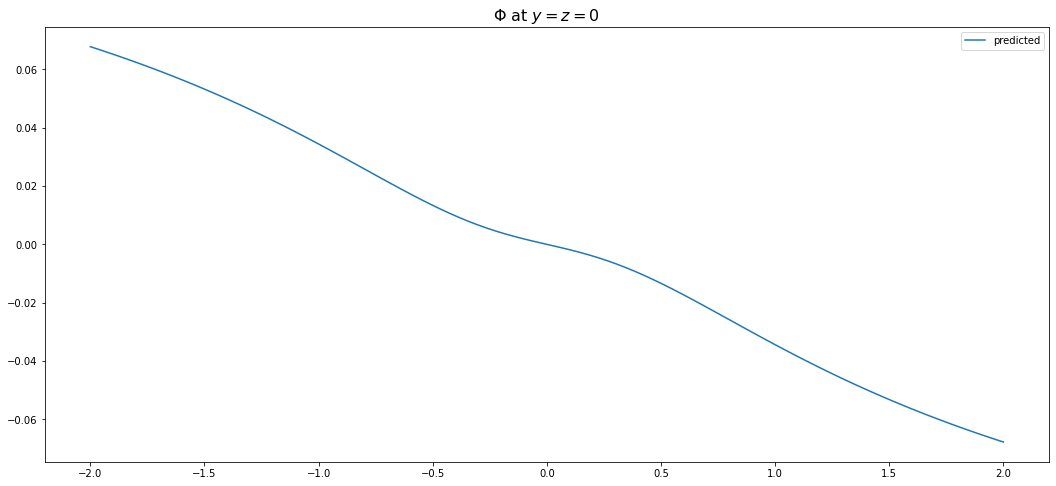

In [164]:
# Load models and visualise/check them!
importlib.reload(potential_frameshift_tf)
importlib.reload(fit_all)

directory = '../runs/sanity_checks/uniform_v2/'
checkpoint_dir = f"{directory}Phi/"
latest = tf.train.latest_checkpoint(checkpoint_dir)
phi_model = potential_frameshift_tf.PhiNN.load(latest)
#print(phi_model._layers[0].w_init.std)
fs_model = potential_frameshift_tf.FrameShift.load(latest)

print('\n')
fs_model.debug()
print(f'Initial:\n  u_LSR=({u_LSR[0]:.4f}, {u_LSR[1]:.4f}, {u_LSR[2]:.4f})')


n_plot = 100
xs = np.linspace(-2, 2, n_plot)
eta_plot = np.zeros((n_plot, 3))
eta_plot[:, 0] = xs

ypred, ys = phi_model(eta_plot).numpy().reshape(n_plot,), 0

%matplotlib inline 
#ax.plot(xs, ypred)
fig, axs = plt.subplots(figsize=(18, 8))
axs.plot(xs, ypred, label="predicted")
axs.set_title("$\Phi$ at $y=z=0$", fontsize=16)
axs.legend()
plt.show()
#axs[1].plot(xs, (ys - ys[0] + ypred[0] - ypred)/ypred)
#axs[1].set_title("relative error", fontsize=16)

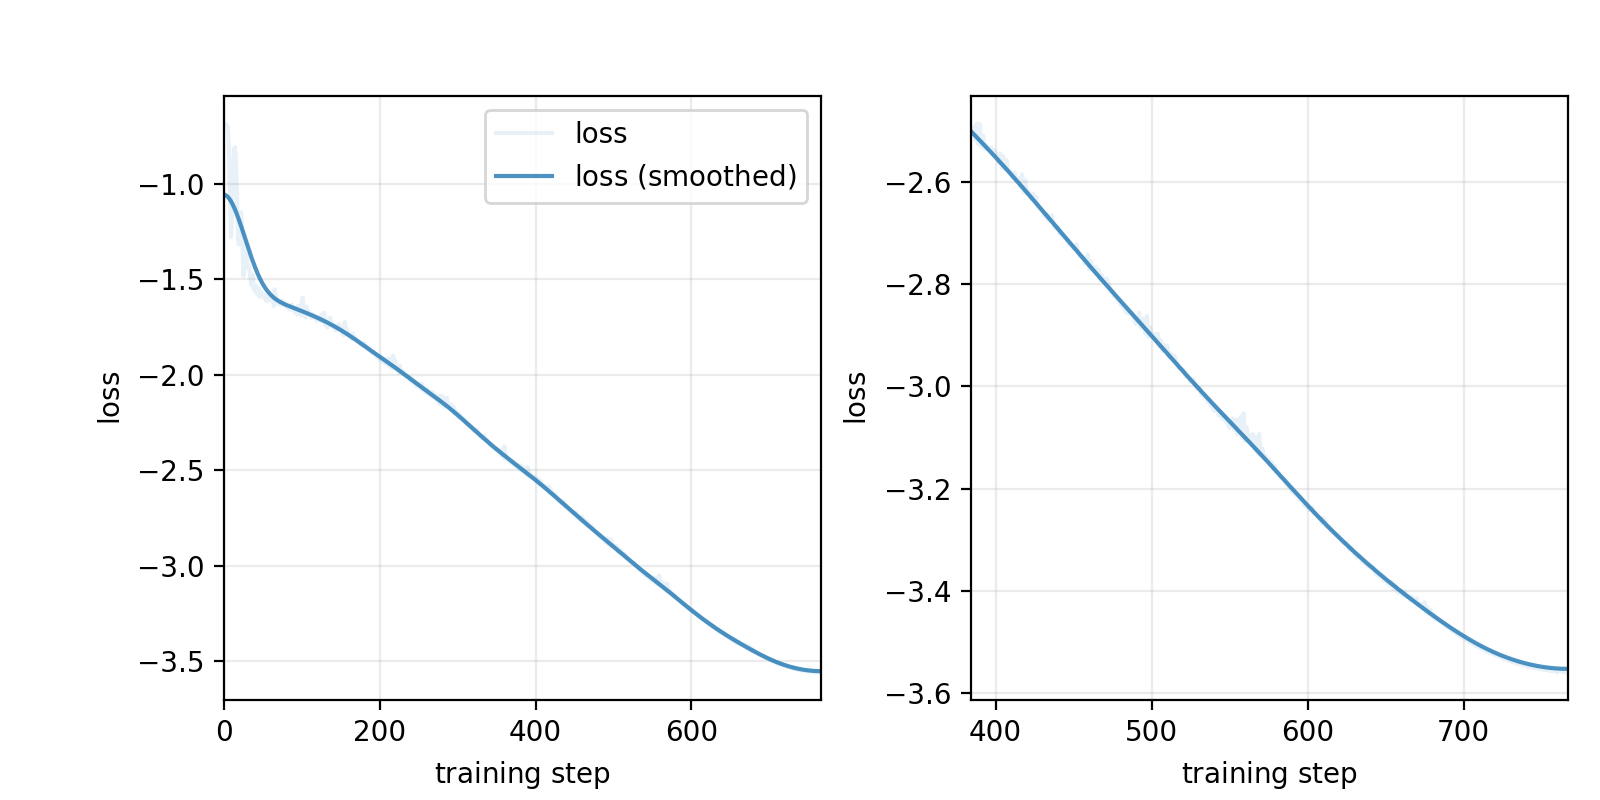

In [40]:
from IPython.display import Image
Image(filename='../runs/sanity_checks/uniform_v2/potential_loss_history.png') 

<hr style="border:2px solid gray">

**3.** 
$$
v_{LSR} = 0, \Omega_0 \neq 0, x_c = 0, \Phi = 0
$$

Solution: $\vec v = \vec u_{LSR}$

<hr style="border:2px solid gray">

**4.** 
$$
v_{LSR} \neq 0, \Omega_0 \neq 0, x_c \neq 0, \Phi = 0
$$

Solution: $\vec v = \vec u_{LSR}$

In [173]:
n = 2**13
print(f'n={n}')

u_LSR = np.array([0.2, 1.0, 0.3])
omega0 = 0.05
xc = np.array([1.3, 2.15, 1.57]) # r, theta, phi


n_dim = 3

eta = np.random.normal(0, 1.0, size=(n, 2*n_dim))
df_deta = np.random.normal(0, 1.0, size=(n, 2*n_dim))

q, p = eta[:, :n_dim], eta[:, n_dim:]
df_dq, df_dp = df_deta[:, :n_dim], df_deta[:, n_dim:]


u = np.tile(u_LSR, (n, 1))
u[:, 0] -= omega0*q[:, 1]
u[:, 1] += omega0*q[:, 0]

du_dt = np.zeros((n, 3))
du_dt[:, 0] -= omega0*p[:, 1]
du_dt[:, 1] += omega0*p[:, 0]

A = p - u
rhs = np.sum(du_dt*df_dp, axis=1)
rhs -= np.sum(A[:, 1:]*df_dq[:, 1:], axis=1)
df_dq[:, 0] = rhs/A[:, 0]

df_data = {'eta': eta, 'df_deta': df_deta}

n=8192


In [201]:
u0 = tf.constant([u_LSR[0], u_LSR[1], u_LSR[2]])
q = tf.constant(df_data['eta'][:,:n_dim])

u = tf.tile(tf.reshape(u0, [1, n_dim]), tf.constant([q.shape[0], 1]))
du_dt = tf.constant(0, shape=q.shape)
du_dt

<tf.Tensor: shape=(8192, 3), dtype=int32, numpy=
array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       ...,
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]], dtype=int32)>